# GAN that generates images similar to MNIST dataset

The goal of this lecture is to implement a generative adversarial network (GAN) in Tensorflow that learns to generate images similar to the MNSIT dataset.

---
### Course of Action

* Please write all executable python code in ```Code```-Cells (```Cell```->```Cell Type```->```Code```) and all Text as [Markdown](http://commonmark.org/help/) in ```Markdown```-Cells
* Describe your thinking and your decisions (where appropriate) in an extra Markdown Cell or via Python comments
* In general: discuss all your results and comment on them (are they good/bad/unexpected, could they be improved, how?, etc.). Furthermore, visualise your data (input and output).
* Write a short general conclusion at the end of the notebook
* Further experiments are encouraged. However, don't forget to comment on your reasoning.
* Use a scientific approach for all experiments (i.e. develop a hypothesis or concrete question, make observations, evaluate results)

### Submission

E-Mail your complete Notebook to [maucher@hdm-stuttgart.de](mailto:maucher@hdm-stuttgart.de) until the start of the next lecture. One Notebook per Group is enough. Edit the teammember table below.

**Important**: Also attach a HTML version of your notebook (```File```->```Download as```->```HTML```) in addition to the ```.ipynb```-File.

| Teammember |                    |
|------------|--------------------|
| 1.         | Christopher Caldwell |
| 2.         | Fabian Müller      |
| 3.         | An Dang         |

## Prerequisities
1. Make sure you have a general understanding how GANs are able to produce realistic looking images. A good practice-oriented overview of the theory is given in the [DCGAN Notebook](http://nbviewer.jupyter.org/urls/maucher.home.hdm-stuttgart.de/nb/ML/DCGAN.ipynb) from the [Machine Learning](http://maucher.pages.mi.hdm-stuttgart.de/ai/page/ml/) lecture. A more theoretical overview is given in the [paper](https://arxiv.org/pdf/1701.00160.pdf) for the NIPS 2016 Workshop on GANs. Specifically make sure you understand the following concepts:
    * How the generator and discriminator work together to produce realistically looking images
    * What the discriminator and generator use as input

2. Make sure to have the following python libraries installed (e.g. via ```pip install```)
    * tensorflow
    * numpy
    * matplotlib

## The MNIST Dataset
By now you should be fairly familiar with the MNIST Dataset. This time, we normalize the input images right after loading so we can feed a normalized input to the model later on.

#### Tasks:
* Load the dataset, normalize the images and display one entry as an inline image

#### Hint:
* use the jupyter magic command [```%matplotlib```](http://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-matplotlib) to activate the inline backend

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

tf.reset_default_graph()

(70000, 28, 28)
(28, 28)
float64
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         

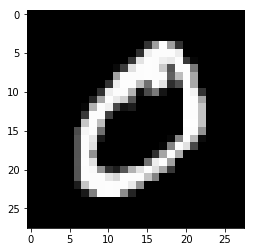

In [2]:
from tensorflow.keras.datasets.mnist import load_data
(train_X, train_y),(test_X, test_y) = load_data()

train_X = train_X/255.0
train_y = train_y/255.0

test_X = test_X/255.0
test_y = test_y/255.0


train = np.append(train_X, test_X, axis=0) #Use both Train and Testset for GAN

print(train.shape)

image = train[1]

print(image.shape)
print(image.dtype)
plt.imshow(image.reshape(28,28), cmap='gray')

print(image)

## Discriminator

The discriminator has the job to differentiate if an image is generated or a real sample from the dataset. For this the GAN will use a relativley simple CNN architecture. This part of the network should therefore accept *MNIST-shaped* images (28x28). The network should have the following layers:


1. **```Input```**: accepts 28px x 28px monochromatic images
2. **```1st convolution```**: filtersize 5x5, 32 features, ```SAME``` padding, ReLU Activation 
3. **```Average Pooling```**: 2x2 kernel, 2x2 stride
4. **```2nd convolution```**: fitersize 5x5, 64 features, ```SAME``` padding, ReLU Activation
5. **```Average Pooling```**: 2x2 kernel, 2x2 stride
6. **```1st fully-connected```**: 1024 neurons, ReLU activation
7. **```2nd fully-connected```**: $K$ neurons, sigmoid activation


Note that the final layer should have a sigmoid activation function. This is a natural choice, since the discriminator should use [cross entropy](https://en.wikipedia.org/wiki/Cross_entropy) loss during training and therefore should output a probability distribution. However, Tensorflow [discourages](https://github.com/tensorflow/tensorflow/issues/2462) the use of the sigmoid activation function when using it as a part of calculating cross entropy. Instead it provides the [```sigmoid_cross_entropy_with_logits```](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits) function which expects unscaled logits as input and calculates the cross-entropy in an optimized and numerically stable fashion. However, this function expects the target distribution (the *labels*) as a second parameter.

To keep things easy, you could pass the labels as a [```tf.placeholder```](https://www.tensorflow.org/api_docs/python/tf/placeholder) and supply them during training. However, since there are only 2 possible labels (real or fake) and we know, depending on the input, all labels, it is actually easier to return the unscaled outputs for now and calculate the cross-entropy later.

#### Tasks:
* what is the value of $K$ in the output layer?
* write a function ```discriminator``` that expects an ```images``` parameter. The images parameter is the input to the network and can either be the output of the generator or a real image. The function builds the network and returns the unscaled output

#### Hint:
You later need to be able to call the discriminator function multiple times (once to pass the *real image* placefolder, once to pass the *generator output* as input. However, you do not want multiple discriminators, otherwise one discriminator would be trained to only predict images as fake and another to only predict images as real. Therefore, we need to make sure Tensorflow reuses all variables (weights and biases) that are adjusted during training.

* use a [```tf.variable_scope```](https://www.tensorflow.org/api_docs/python/tf/variable_scope) to which all discriminator variables are added.
* use [```tf.get_variable```](https://www.tensorflow.org/api_docs/python/tf/get_variable) to get an existing, named variable or create a new one.
* add another parameter to the ```discriminator``` function to specify if variables should be reused or not
* depending on this parameter, use [```VariableScope.reuse_variables()```](https://www.tensorflow.org/api_docs/python/tf/VariableScope#reuse_variables) on the scope to make sure tensorflow reuses all variables and does not create new ones.


![architecture](data:image/svg+xml,%3C%3Fxml%20version%3D%221.0%22%20encoding%3D%22UTF-8%22%20standalone%3D%22no%22%3F%3E%0D%0A%3C%21DOCTYPE%20svg%20PUBLIC%20%22-%2F%2FW3C%2F%2FDTD%20SVG%201.1%2F%2FEN%22%20%22http%3A%2F%2Fwww.w3.org%2FGraphics%2FSVG%2F1.1%2FDTD%2Fsvg11.dtd%22%3E%0D%0A%3Csvg%20width%3D%22100%25%22%20height%3D%22100%25%22%20viewBox%3D%220%200%201536%20591%22%20version%3D%221.1%22%20xmlns%3D%22http%3A%2F%2Fwww.w3.org%2F2000%2Fsvg%22%20xmlns%3Axlink%3D%22http%3A%2F%2Fwww.w3.org%2F1999%2Fxlink%22%20xml%3Aspace%3D%22preserve%22%20xmlns%3Aserif%3D%22http%3A%2F%2Fwww.serif.com%2F%22%20style%3D%22fill-rule%3Aevenodd%3Bclip-rule%3Aevenodd%3Bstroke-linecap%3Around%3Bstroke-linejoin%3Around%3Bstroke-miterlimit%3A1.5%3B%22%3E%0D%0A%20%20%20%20%3Cg%20id%3D%22Input%22%20transform%3D%22matrix%281.34164%2C0%2C0%2C1.34164%2C-203.163%2C-115.923%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C4.32316%2C-101.985%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M290.952%2C200.664L290.952%2C427.091L178.748%2C540.271L178.748%2C313.34L290.952%2C200.664Z%22%20style%3D%22fill%3Argb%28235%2C235%2C235%29%3Bfill-opacity%3A0.498039%3Bstroke%3Ablack%3Bstroke-width%3A0.75px%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C34.1886%2C55.7998%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22167.468px%22%20y%3D%22463.455px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A20.833px%3B%22%3E28x28x1%3C%2Ftext%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%280.000171407%2C-0.329494%2C1.09737%2C0.000570864%2C-280.71%2C564.006%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M205.739%2C471.418C208.872%2C471.337%20214.459%2C469.671%20216.432%2C468.064C218.405%2C466.457%20219.718%2C464.249%20220.369%2C461.442C221.02%2C458.634%20221.363%2C451.949%20221.403%2C445.154C221.444%2C438.359%20221.579%2C441.416%20221.782%2C439.26C222.148%2C435.842%20220.975%2C433.095%20221.972%2C431.02C222.969%2C428.945%20223.02%2C427.287%20224.484%2C426.046C225.949%2C424.805%20227.821%2C423.859%20230.1%2C423.208C231.646%2C422.801%20234.169%2C422.598%20237.668%2C422.598L241.086%2C422.598L241.073%2C424.647L239.181%2C424.647C234.949%2C424.647%20232.142%2C425.41%20230.758%2C426.936C229.375%2C428.462%20228.683%2C431.869%20228.683%2C437.159C228.683%2C447.82%20228.459%2C454.554%20228.012%2C457.362C227.279%2C461.716%20226.028%2C465.073%20224.258%2C467.433C222.488%2C469.793%20219.711%2C471.888%20215.927%2C473.719C220.403%2C475.591%20223.648%2C478.449%20225.662%2C482.295C227.676%2C486.14%20228.683%2C492.437%20228.683%2C501.185C228.683%2C509.12%20228.765%2C513.84%20228.927%2C515.345C229.253%2C518.112%20230.077%2C520.045%20231.399%2C521.143C232.722%2C522.242%20235.316%2C522.791%20239.181%2C522.791L241.073%2C522.791L241.061%2C524.841L237.643%2C524.841C237.17%2C524.841%20236.712%2C524.836%20236.27%2C524.827C232.985%2C524.759%20230.554%2C524.438%20228.976%2C523.864C226.372%2C522.928%20225.396%2C521.412%20223.687%2C519.317C221.978%2C517.221%20222.723%2C514.566%20222.215%2C511.352C221.706%2C508.137%20221.444%2C510.401%20221.403%2C503.077C221.363%2C495.752%20221.013%2C488.803%20220.362%2C485.996C219.711%2C483.188%20218.399%2C480.97%20216.426%2C479.343C214.452%2C477.715%20208.862%2C476.04%20205.729%2C475.959L205.739%2C471.418Z%22%20style%3D%22fill-rule%3Anonzero%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20id%3D%22Filter-1%22%20serif%3Aid%3D%22Filter%201%22%20transform%3D%22matrix%280.105539%2C0%2C0%2C0.105539%2C302.562%2C179.745%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C4.32316%2C-101.985%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%289.47513%2C-0%2C-0%2C9.47513%2C-2871.14%2C-1601.12%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%3Cuse%20xlink%3Ahref%3D%22%23_Image1%22%20x%3D%22325.337%22%20y%3D%22190.473%22%20width%3D%2212.842px%22%20height%3D%2236.842px%22%20transform%3D%22matrix%280.987848%2C0%2C0%2C0.995728%2C0%2C0%29%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%28132.554%2C0%2C0%2C1.03062%2C-22503.1%2C-13.4204%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%280.071481%2C-0%2C-0%2C9.19362%2C148.138%2C-1639.48%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%3Cuse%20xlink%3Ahref%3D%22%23_Image2%22%20x%3D%22149.013%22%20y%3D%22176.39%22%20width%3D%22174.12px%22%20height%3D%2260.633px%22%20transform%3D%22matrix%280.994971%2C0%2C0%2C0.993991%2C0%2C0%29%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1.03062%2C124.129%2C-126.179%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%289.47513%2C-0%2C-0%2C9.19362%2C-2990.95%2C-1530.07%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%3Cuse%20xlink%3Ahref%3D%22%23_Image3%22%20x%3D%22148.294%22%20y%3D%22141.901%22%20width%3D%22185.962px%22%20height%3D%2262.28px%22%20transform%3D%22matrix%280.999796%2C0%2C0%2C0.988574%2C0%2C0%29%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%289.47513%2C0%2C0%2C9.47513%2C-3141.6%2C-1560.98%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22155.7px%22%20y%3D%22199.55px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A27.917px%3B%22%3E3%3C%2Ftext%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%282.53216%2C0.000506193%2C-0.00111812%2C5.59322%2C-2053.62%2C-2407.73%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M205.739%2C471.418C208.872%2C471.337%20214.459%2C469.671%20216.432%2C468.064C218.405%2C466.457%20219.718%2C464.249%20220.369%2C461.442C221.02%2C458.634%20221.363%2C451.949%20221.403%2C445.154C221.444%2C438.359%20221.579%2C441.416%20221.782%2C439.26C222.148%2C435.842%20220.975%2C433.095%20221.972%2C431.02C222.969%2C428.945%20223.02%2C427.287%20224.484%2C426.046C225.949%2C424.805%20227.821%2C423.859%20230.1%2C423.208C231.646%2C422.801%20234.169%2C422.598%20237.668%2C422.598L241.086%2C422.598L241.073%2C424.647L239.181%2C424.647C234.949%2C424.647%20232.142%2C425.41%20230.758%2C426.936C229.375%2C428.462%20228.683%2C431.869%20228.683%2C437.159C228.683%2C447.82%20228.459%2C454.554%20228.012%2C457.362C227.279%2C461.716%20226.028%2C465.073%20224.258%2C467.433C222.488%2C469.793%20219.711%2C471.888%20215.927%2C473.719C220.403%2C475.591%20223.648%2C478.449%20225.662%2C482.295C227.676%2C486.14%20228.683%2C492.437%20228.683%2C501.185C228.683%2C509.12%20228.765%2C513.84%20228.927%2C515.345C229.253%2C518.112%20230.077%2C520.045%20231.399%2C521.143C232.722%2C522.242%20235.316%2C522.791%20239.181%2C522.791L241.073%2C522.791L241.061%2C524.841L237.643%2C524.841C237.17%2C524.841%20236.712%2C524.836%20236.27%2C524.827C232.985%2C524.759%20230.554%2C524.438%20228.976%2C523.864C226.372%2C522.928%20225.396%2C521.412%20223.687%2C519.317C221.978%2C517.221%20222.723%2C514.566%20222.215%2C511.352C221.706%2C508.137%20221.444%2C510.401%20221.403%2C503.077C221.363%2C495.752%20221.013%2C488.803%20220.362%2C485.996C219.711%2C483.188%20218.399%2C480.97%20216.426%2C479.343C214.452%2C477.715%20208.862%2C476.04%20205.729%2C475.959L205.739%2C471.418Z%22%20style%3D%22fill-rule%3Anonzero%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%289.47513%2C0%2C0%2C9.47513%2C-2961.57%2C-2157.91%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22155.7px%22%20y%3D%22199.55px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A27.917px%3B%22%3E3%3C%2Ftext%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281.77871%2C1.80222%2C-3.29791%2C3.25488%2C-169.369%2C-2176.9%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M205.739%2C471.418C208.872%2C471.337%20214.459%2C469.671%20216.432%2C468.064C218.405%2C466.457%20219.718%2C464.249%20220.369%2C461.442C221.02%2C458.634%20221.363%2C451.949%20221.403%2C445.154C221.444%2C438.359%20221.579%2C441.416%20221.782%2C439.26C222.148%2C435.842%20220.975%2C433.095%20221.972%2C431.02C222.969%2C428.945%20223.02%2C427.287%20224.484%2C426.046C225.949%2C424.805%20227.821%2C423.859%20230.1%2C423.208C231.646%2C422.801%20234.169%2C422.598%20237.668%2C422.598L241.086%2C422.598L241.073%2C424.647L239.181%2C424.647C234.949%2C424.647%20232.142%2C425.41%20230.758%2C426.936C229.375%2C428.462%20228.683%2C431.869%20228.683%2C437.159C228.683%2C447.82%20228.459%2C454.554%20228.012%2C457.362C227.279%2C461.716%20226.028%2C465.073%20224.258%2C467.433C222.488%2C469.793%20219.711%2C471.888%20215.927%2C473.719C220.403%2C475.591%20223.648%2C478.449%20225.662%2C482.295C227.676%2C486.14%20228.683%2C492.437%20228.683%2C501.185C228.683%2C509.12%20228.765%2C513.84%20228.927%2C515.345C229.253%2C518.112%20230.077%2C520.045%20231.399%2C521.143C232.722%2C522.242%20235.316%2C522.791%20239.181%2C522.791L241.073%2C522.791L241.061%2C524.841L237.643%2C524.841C237.17%2C524.841%20236.712%2C524.836%20236.27%2C524.827C232.985%2C524.759%20230.554%2C524.438%20228.976%2C523.864C226.372%2C522.928%20225.396%2C521.412%20223.687%2C519.317C221.978%2C517.221%20222.723%2C514.566%20222.215%2C511.352C221.706%2C508.137%20221.444%2C510.401%20221.403%2C503.077C221.363%2C495.752%20221.013%2C488.803%20220.362%2C485.996C219.711%2C483.188%20218.399%2C480.97%20216.426%2C479.343C214.452%2C477.715%20208.862%2C476.04%20205.729%2C475.959L205.739%2C471.418Z%22%20style%3D%22fill-rule%3Anonzero%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20id%3D%22Conv-Layer-1%22%20serif%3Aid%3D%22Conv%20Layer%201%22%20transform%3D%22matrix%281.08485%2C0%2C0%2C1.08485%2C79.4814%2C-27.5273%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C-34.1855%2C-101.985%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M317.03%2C142.539L317.03%2C422.577L178.163%2C562.532L178.163%2C281.989L317.03%2C142.539Z%22%20style%3D%22fill%3Argb%28235%2C235%2C235%29%3Bfill-opacity%3A0.498039%3Bstroke%3Ablack%3Bstroke-width%3A0.92px%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C-24.9676%2C-101.985%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M317.03%2C142.539L317.03%2C422.577L178.163%2C562.532L178.163%2C281.989L317.03%2C142.539Z%22%20style%3D%22fill%3Argb%28235%2C235%2C235%29%3Bfill-opacity%3A0.498039%3Bstroke%3Ablack%3Bstroke-width%3A0.92px%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C-15.7498%2C-101.985%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M317.03%2C142.539L317.03%2C422.577L178.163%2C562.532L178.163%2C281.989L317.03%2C142.539Z%22%20style%3D%22fill%3Argb%28235%2C235%2C235%29%3Bfill-opacity%3A0.498039%3Bstroke%3Ablack%3Bstroke-width%3A0.92px%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C-6.53195%2C-101.985%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M317.03%2C142.539L317.03%2C422.577L178.163%2C562.532L178.163%2C281.989L317.03%2C142.539Z%22%20style%3D%22fill%3Argb%28235%2C235%2C235%29%3Bfill-opacity%3A0.498039%3Bstroke%3Ablack%3Bstroke-width%3A0.92px%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1.03062%2C124.129%2C-126.179%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M197.121%2C161.78L158.612%2C161.78L19.848%2C297.086L58.357%2C297.086L197.121%2C161.78Z%22%20style%3D%22fill%3Argb%28235%2C235%2C235%29%3Bfill-opacity%3A0.498039%3Bstroke%3Ablack%3Bstroke-width%3A0.91px%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1.03062%2C124.129%2C100.004%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M197.121%2C213.727L158.612%2C213.727L19.848%2C349.831L58.357%2C349.831L197.121%2C213.727Z%22%20style%3D%22fill%3Argb%28235%2C235%2C235%29%3Bfill-opacity%3A0.498039%3Bstroke%3Ablack%3Bstroke-width%3A0.91px%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%283.11186%2C0%2C0%2C1.17529%2C-349.512%2C-76.8268%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Crect%20x%3D%22158.584%22%20y%3D%22218.525%22%20width%3D%2212.375%22%20height%3D%22238.701%22%20style%3D%22fill%3Argb%28235%2C235%2C235%29%3Bfill-opacity%3A0.498039%3Bstroke%3Ablack%3Bstroke-width%3A0.39px%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281.2367%2C0%2C0%2C1.2367%2C-38.5711%2C-207.607%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M290.952%2C200.664L290.952%2C427.091L178.748%2C540.271L178.748%2C313.34L290.952%2C200.664Z%22%20style%3D%22fill%3Argb%28235%2C235%2C235%29%3Bfill-opacity%3A0.498039%3Bstroke%3Ablack%3Bstroke-width%3A0.75px%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281.2367%2C0%2C0%2C1.2367%2C-30.2118%2C-12.4745%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22167.468px%22%20y%3D%22463.455px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A20.833px%3B%22%3E28x28x32%3C%2Ftext%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%280.000211979%2C-0.407486%2C1.73577%2C0.00090297%2C-589.806%2C615.942%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M205.739%2C471.418C208.872%2C471.337%20214.459%2C469.671%20216.432%2C468.064C218.405%2C466.457%20219.718%2C464.249%20220.369%2C461.442C221.02%2C458.634%20221.363%2C451.949%20221.403%2C445.154C221.444%2C438.359%20221.579%2C441.416%20221.782%2C439.26C222.148%2C435.842%20220.975%2C433.095%20221.972%2C431.02C222.969%2C428.945%20223.02%2C427.287%20224.484%2C426.046C225.949%2C424.805%20227.821%2C423.859%20230.1%2C423.208C231.646%2C422.801%20234.169%2C422.598%20237.668%2C422.598L241.086%2C422.598L241.073%2C424.647L239.181%2C424.647C234.949%2C424.647%20232.142%2C425.41%20230.758%2C426.936C229.375%2C428.462%20228.683%2C431.869%20228.683%2C437.159C228.683%2C447.82%20228.459%2C454.554%20228.012%2C457.362C227.279%2C461.716%20226.028%2C465.073%20224.258%2C467.433C222.488%2C469.793%20219.711%2C471.888%20215.927%2C473.719C220.403%2C475.591%20223.648%2C478.449%20225.662%2C482.295C227.676%2C486.14%20228.683%2C492.437%20228.683%2C501.185C228.683%2C509.12%20228.765%2C513.84%20228.927%2C515.345C229.253%2C518.112%20230.077%2C520.045%20231.399%2C521.143C232.722%2C522.242%20235.316%2C522.791%20239.181%2C522.791L241.073%2C522.791L241.061%2C524.841L237.643%2C524.841C237.17%2C524.841%20236.712%2C524.836%20236.27%2C524.827C232.985%2C524.759%20230.554%2C524.438%20228.976%2C523.864C226.372%2C522.928%20225.396%2C521.412%20223.687%2C519.317C221.978%2C517.221%20222.723%2C514.566%20222.215%2C511.352C221.706%2C508.137%20221.444%2C510.401%20221.403%2C503.077C221.363%2C495.752%20221.013%2C488.803%20220.362%2C485.996C219.711%2C483.188%20218.399%2C480.97%20216.426%2C479.343C214.452%2C477.715%20208.862%2C476.04%20205.729%2C475.959L205.739%2C471.418Z%22%20style%3D%22fill-rule%3Anonzero%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20id%3D%22Dropout-1%22%20serif%3Aid%3D%22Dropout%201%22%20transform%3D%22matrix%280.105539%2C0%2C0%2C0.105539%2C463.559%2C300.492%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C4.32316%2C-101.985%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%289.47513%2C-0%2C-0%2C9.47513%2C-4396.6%2C-2745.22%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%3Cuse%20xlink%3Ahref%3D%22%23_Image4%22%20x%3D%22488.314%22%20y%3D%22311.738%22%20width%3D%2212.842px%22%20height%3D%2236.842px%22%20transform%3D%22matrix%280.987848%2C0%2C0%2C0.995728%2C0%2C0%29%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%28132.554%2C0%2C0%2C1.03062%2C-22503.1%2C-13.4204%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%280.071481%2C-0%2C-0%2C9.19362%2C136.629%2C-2749.59%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%3Cuse%20xlink%3Ahref%3D%22%23_Image5%22%20x%3D%22310.823%22%20y%3D%22303.102%22%20width%3D%22174.12px%22%20height%3D%2248.325px%22%20transform%3D%22matrix%280.994971%2C0%2C0%2C0.986217%2C0%2C0%29%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1.03062%2C124.129%2C-126.179%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%289.47513%2C-0%2C-0%2C9.19362%2C-4516.41%2C-2640.18%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%3Cuse%20xlink%3Ahref%3D%22%23_Image6%22%20x%3D%22309.323%22%20y%3D%22276.638%22%20width%3D%22185.962px%22%20height%3D%2249.49px%22%20transform%3D%22matrix%280.999796%2C0%2C0%2C0.989803%2C0%2C0%29%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%289.47513%2C0%2C0%2C9.47513%2C-3151.04%2C-1605.96%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22155.7px%22%20y%3D%22199.55px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A27.917px%3B%22%3E2%3C%2Ftext%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%282.53216%2C0.000506193%2C-0.000840418%2C4.20407%2C-2062.42%2C-1789.96%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M205.739%2C471.418C208.872%2C471.337%20214.459%2C469.671%20216.432%2C468.064C218.405%2C466.457%20219.718%2C464.249%20220.369%2C461.442C221.02%2C458.634%20221.363%2C451.949%20221.403%2C445.154C221.444%2C438.359%20221.579%2C441.416%20221.782%2C439.26C222.148%2C435.842%20220.975%2C433.095%20221.972%2C431.02C222.969%2C428.945%20223.02%2C427.287%20224.484%2C426.046C225.949%2C424.805%20227.821%2C423.859%20230.1%2C423.208C231.646%2C422.801%20234.169%2C422.598%20237.668%2C422.598L241.086%2C422.598L241.073%2C424.647L239.181%2C424.647C234.949%2C424.647%20232.142%2C425.41%20230.758%2C426.936C229.375%2C428.462%20228.683%2C431.869%20228.683%2C437.159C228.683%2C447.82%20228.459%2C454.554%20228.012%2C457.362C227.279%2C461.716%20226.028%2C465.073%20224.258%2C467.433C222.488%2C469.793%20219.711%2C471.888%20215.927%2C473.719C220.403%2C475.591%20223.648%2C478.449%20225.662%2C482.295C227.676%2C486.14%20228.683%2C492.437%20228.683%2C501.185C228.683%2C509.12%20228.765%2C513.84%20228.927%2C515.345C229.253%2C518.112%20230.077%2C520.045%20231.399%2C521.143C232.722%2C522.242%20235.316%2C522.791%20239.181%2C522.791L241.073%2C522.791L241.061%2C524.841L237.643%2C524.841C237.17%2C524.841%20236.712%2C524.836%20236.27%2C524.827C232.985%2C524.759%20230.554%2C524.438%20228.976%2C523.864C226.372%2C522.928%20225.396%2C521.412%20223.687%2C519.317C221.978%2C517.221%20222.723%2C514.566%20222.215%2C511.352C221.706%2C508.137%20221.444%2C510.401%20221.403%2C503.077C221.363%2C495.752%20221.013%2C488.803%20220.362%2C485.996C219.711%2C483.188%20218.399%2C480.97%20216.426%2C479.343C214.452%2C477.715%20208.862%2C476.04%20205.729%2C475.959L205.739%2C471.418Z%22%20style%3D%22fill-rule%3Anonzero%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%289.47513%2C0%2C0%2C9.47513%2C-2999.44%2C-2079.72%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22155.7px%22%20y%3D%22199.55px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A27.917px%3B%22%3E2%3C%2Ftext%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281.68164%2C1.70387%2C-2.32717%2C2.29681%2C-644.855%2C-1629.42%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M205.739%2C471.418C208.872%2C471.337%20214.459%2C469.671%20216.432%2C468.064C218.405%2C466.457%20219.718%2C464.249%20220.369%2C461.442C221.02%2C458.634%20221.363%2C451.949%20221.403%2C445.154C221.444%2C438.359%20221.579%2C441.416%20221.782%2C439.26C222.148%2C435.842%20220.975%2C433.095%20221.972%2C431.02C222.969%2C428.945%20223.02%2C427.287%20224.484%2C426.046C225.949%2C424.805%20227.821%2C423.859%20230.1%2C423.208C231.646%2C422.801%20234.169%2C422.598%20237.668%2C422.598L241.086%2C422.598L241.073%2C424.647L239.181%2C424.647C234.949%2C424.647%20232.142%2C425.41%20230.758%2C426.936C229.375%2C428.462%20228.683%2C431.869%20228.683%2C437.159C228.683%2C447.82%20228.459%2C454.554%20228.012%2C457.362C227.279%2C461.716%20226.028%2C465.073%20224.258%2C467.433C222.488%2C469.793%20219.711%2C471.888%20215.927%2C473.719C220.403%2C475.591%20223.648%2C478.449%20225.662%2C482.295C227.676%2C486.14%20228.683%2C492.437%20228.683%2C501.185C228.683%2C509.12%20228.765%2C513.84%20228.927%2C515.345C229.253%2C518.112%20230.077%2C520.045%20231.399%2C521.143C232.722%2C522.242%20235.316%2C522.791%20239.181%2C522.791L241.073%2C522.791L241.061%2C524.841L237.643%2C524.841C237.17%2C524.841%20236.712%2C524.836%20236.27%2C524.827C232.985%2C524.759%20230.554%2C524.438%20228.976%2C523.864C226.372%2C522.928%20225.396%2C521.412%20223.687%2C519.317C221.978%2C517.221%20222.723%2C514.566%20222.215%2C511.352C221.706%2C508.137%20221.444%2C510.401%20221.403%2C503.077C221.363%2C495.752%20221.013%2C488.803%20220.362%2C485.996C219.711%2C483.188%20218.399%2C480.97%20216.426%2C479.343C214.452%2C477.715%20208.862%2C476.04%20205.729%2C475.959L205.739%2C471.418Z%22%20style%3D%22fill-rule%3Anonzero%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20id%3D%22Dropout-Layer-1%22%20serif%3Aid%3D%22Dropout%20Layer%201%22%20transform%3D%22matrix%281.08485%2C0%2C0%2C1.08485%2C295.842%2C-81.6337%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C-34.1855%2C-101.985%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M252.502%2C293.782L252.547%2C465.668L178.703%2C539.606L178.703%2C366.625L252.502%2C293.782Z%22%20style%3D%22fill%3Argb%28235%2C235%2C235%29%3Bfill-opacity%3A0.498039%3Bstroke%3Ablack%3Bstroke-width%3A0.92px%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C-24.9676%2C-101.985%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M252.502%2C293.782L252.547%2C465.668L178.703%2C539.606L178.703%2C366.625L252.502%2C293.782Z%22%20style%3D%22fill%3Argb%28235%2C235%2C235%29%3Bfill-opacity%3A0.498039%3Bstroke%3Ablack%3Bstroke-width%3A0.92px%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C-15.7498%2C-101.985%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M252.502%2C293.782L252.547%2C465.668L178.703%2C539.606L178.703%2C366.625L252.502%2C293.782Z%22%20style%3D%22fill%3Argb%28235%2C235%2C235%29%3Bfill-opacity%3A0.498039%3Bstroke%3Ablack%3Bstroke-width%3A0.92px%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C-6.53195%2C-101.985%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M252.502%2C293.782L252.547%2C465.668L178.703%2C539.606L178.703%2C366.625L252.502%2C293.782Z%22%20style%3D%22fill%3Argb%28235%2C235%2C235%29%3Bfill-opacity%3A0.498039%3Bstroke%3Ablack%3Bstroke-width%3A0.92px%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1.03062%2C124.129%2C-44.0769%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M132.571%2C228.866L94.062%2C228.866L20.433%2C299.545L58.941%2C299.545L132.571%2C228.866Z%22%20style%3D%22fill%3Argb%28235%2C235%2C235%29%3Bfill-opacity%3A0.498039%3Bstroke%3Ablack%3Bstroke-width%3A0.91px%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1.03062%2C124.129%2C100.004%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M132.571%2C255.872L94.062%2C255.872L20.433%2C327.587L58.941%2C327.587L132.571%2C255.872Z%22%20style%3D%22fill%3Argb%28235%2C235%2C235%29%3Bfill-opacity%3A0.498039%3Bstroke%3Ablack%3Bstroke-width%3A0.91px%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%283.11186%2C0%2C0%2C0.765086%2C-349.512%2C103.068%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M171.146%2C211.181L158.771%2C211.181L158.757%2C437.275L171.146%2C437.275L171.146%2C211.181Z%22%20style%3D%22fill%3Argb%28235%2C235%2C235%29%3Bfill-opacity%3A0.498039%3Bstroke%3Ablack%3Bstroke-width%3A0.41px%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C4.32316%2C-101.985%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M252.377%2C293.782L252.377%2C465.695L178.748%2C539.606L178.748%2C366.625L252.377%2C293.782Z%22%20style%3D%22fill%3Argb%28235%2C235%2C235%29%3Bfill-opacity%3A0.498039%3Bstroke%3Ablack%3Bstroke-width%3A0.92px%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281.2367%2C0%2C0%2C1.2367%2C-62.8068%2C37.3999%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22167.468px%22%20y%3D%22463.455px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A20.833px%3B%22%3E14x14x32%3C%2Ftext%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%280.000211979%2C-0.407486%2C1.09721%2C0.00057078%2C-319.211%2C665.955%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M205.739%2C471.418C208.872%2C471.337%20214.459%2C469.671%20216.432%2C468.064C218.405%2C466.457%20219.718%2C464.249%20220.369%2C461.442C221.02%2C458.634%20221.363%2C451.949%20221.403%2C445.154C221.444%2C438.359%20221.579%2C441.416%20221.782%2C439.26C222.148%2C435.842%20220.975%2C433.095%20221.972%2C431.02C222.969%2C428.945%20223.02%2C427.287%20224.484%2C426.046C225.949%2C424.805%20227.821%2C423.859%20230.1%2C423.208C231.646%2C422.801%20234.169%2C422.598%20237.668%2C422.598L241.086%2C422.598L241.073%2C424.647L239.181%2C424.647C234.949%2C424.647%20232.142%2C425.41%20230.758%2C426.936C229.375%2C428.462%20228.683%2C431.869%20228.683%2C437.159C228.683%2C447.82%20228.459%2C454.554%20228.012%2C457.362C227.279%2C461.716%20226.028%2C465.073%20224.258%2C467.433C222.488%2C469.793%20219.711%2C471.888%20215.927%2C473.719C220.403%2C475.591%20223.648%2C478.449%20225.662%2C482.295C227.676%2C486.14%20228.683%2C492.437%20228.683%2C501.185C228.683%2C509.12%20228.765%2C513.84%20228.927%2C515.345C229.253%2C518.112%20230.077%2C520.045%20231.399%2C521.143C232.722%2C522.242%20235.316%2C522.791%20239.181%2C522.791L241.073%2C522.791L241.061%2C524.841L237.643%2C524.841C237.17%2C524.841%20236.712%2C524.836%20236.27%2C524.827C232.985%2C524.759%20230.554%2C524.438%20228.976%2C523.864C226.372%2C522.928%20225.396%2C521.412%20223.687%2C519.317C221.978%2C517.221%20222.723%2C514.566%20222.215%2C511.352C221.706%2C508.137%20221.444%2C510.401%20221.403%2C503.077C221.363%2C495.752%20221.013%2C488.803%20220.362%2C485.996C219.711%2C483.188%20218.399%2C480.97%20216.426%2C479.343C214.452%2C477.715%20208.862%2C476.04%20205.729%2C475.959L205.739%2C471.418Z%22%20style%3D%22fill-rule%3Anonzero%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20id%3D%22Filter-11%22%20serif%3Aid%3D%22Filter%201%22%20transform%3D%22matrix%280.105539%2C0%2C0%2C0.105539%2C665.921%2C297.226%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C4.32316%2C-101.985%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%289.47513%2C-0%2C-0%2C9.47513%2C-6314.01%2C-2714.27%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%3Cuse%20xlink%3Ahref%3D%22%23_Image1%22%20x%3D%22693.165%22%20y%3D%22308.458%22%20width%3D%2212.842px%22%20height%3D%2236.842px%22%20transform%3D%22matrix%280.987848%2C0%2C0%2C0.995728%2C0%2C0%29%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%28132.554%2C0%2C0%2C1.03062%2C-22503.1%2C-13.4204%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%280.071481%2C-0%2C-0%2C9.19362%2C122.164%2C-2719.56%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%3Cuse%20xlink%3Ahref%3D%22%23_Image2%22%20x%3D%22514.208%22%20y%3D%22294.581%22%20width%3D%22174.12px%22%20height%3D%2260.633px%22%20transform%3D%22matrix%280.994971%2C0%2C0%2C0.993991%2C0%2C0%29%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1.03062%2C124.129%2C-126.179%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%289.47513%2C-0%2C-0%2C9.19362%2C-6433.81%2C-2610.15%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%3Cuse%20xlink%3Ahref%3D%22%23_Image3%22%20x%3D%22511.727%22%20y%3D%22260.74%22%20width%3D%22185.962px%22%20height%3D%2262.28px%22%20transform%3D%22matrix%280.999796%2C0%2C0%2C0.988574%2C0%2C0%29%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%289.47513%2C0%2C0%2C9.47513%2C-3135.52%2C-1565.54%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22155.7px%22%20y%3D%22199.55px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A27.917px%3B%22%3E3%3C%2Ftext%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%282.53216%2C0.000506193%2C-0.00111812%2C5.59322%2C-2066.5%2C-2412.29%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M205.739%2C471.418C208.872%2C471.337%20214.459%2C469.671%20216.432%2C468.064C218.405%2C466.457%20219.718%2C464.249%20220.369%2C461.442C221.02%2C458.634%20221.363%2C451.949%20221.403%2C445.154C221.444%2C438.359%20221.579%2C441.416%20221.782%2C439.26C222.148%2C435.842%20220.975%2C433.095%20221.972%2C431.02C222.969%2C428.945%20223.02%2C427.287%20224.484%2C426.046C225.949%2C424.805%20227.821%2C423.859%20230.1%2C423.208C231.646%2C422.801%20234.169%2C422.598%20237.668%2C422.598L241.086%2C422.598L241.073%2C424.647L239.181%2C424.647C234.949%2C424.647%20232.142%2C425.41%20230.758%2C426.936C229.375%2C428.462%20228.683%2C431.869%20228.683%2C437.159C228.683%2C447.82%20228.459%2C454.554%20228.012%2C457.362C227.279%2C461.716%20226.028%2C465.073%20224.258%2C467.433C222.488%2C469.793%20219.711%2C471.888%20215.927%2C473.719C220.403%2C475.591%20223.648%2C478.449%20225.662%2C482.295C227.676%2C486.14%20228.683%2C492.437%20228.683%2C501.185C228.683%2C509.12%20228.765%2C513.84%20228.927%2C515.345C229.253%2C518.112%20230.077%2C520.045%20231.399%2C521.143C232.722%2C522.242%20235.316%2C522.791%20239.181%2C522.791L241.073%2C522.791L241.061%2C524.841L237.643%2C524.841C237.17%2C524.841%20236.712%2C524.836%20236.27%2C524.827C232.985%2C524.759%20230.554%2C524.438%20228.976%2C523.864C226.372%2C522.928%20225.396%2C521.412%20223.687%2C519.317C221.978%2C517.221%20222.723%2C514.566%20222.215%2C511.352C221.706%2C508.137%20221.444%2C510.401%20221.403%2C503.077C221.363%2C495.752%20221.013%2C488.803%20220.362%2C485.996C219.711%2C483.188%20218.399%2C480.97%20216.426%2C479.343C214.452%2C477.715%20208.862%2C476.04%20205.729%2C475.959L205.739%2C471.418Z%22%20style%3D%22fill-rule%3Anonzero%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%289.47513%2C0%2C0%2C9.47513%2C-2946.01%2C-2143.52%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22155.7px%22%20y%3D%22199.55px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A27.917px%3B%22%3E3%3C%2Ftext%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281.77871%2C1.80222%2C-3.29791%2C3.25488%2C-153.816%2C-2181.46%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M205.739%2C471.418C208.872%2C471.337%20214.459%2C469.671%20216.432%2C468.064C218.405%2C466.457%20219.718%2C464.249%20220.369%2C461.442C221.02%2C458.634%20221.363%2C451.949%20221.403%2C445.154C221.444%2C438.359%20221.579%2C441.416%20221.782%2C439.26C222.148%2C435.842%20220.975%2C433.095%20221.972%2C431.02C222.969%2C428.945%20223.02%2C427.287%20224.484%2C426.046C225.949%2C424.805%20227.821%2C423.859%20230.1%2C423.208C231.646%2C422.801%20234.169%2C422.598%20237.668%2C422.598L241.086%2C422.598L241.073%2C424.647L239.181%2C424.647C234.949%2C424.647%20232.142%2C425.41%20230.758%2C426.936C229.375%2C428.462%20228.683%2C431.869%20228.683%2C437.159C228.683%2C447.82%20228.459%2C454.554%20228.012%2C457.362C227.279%2C461.716%20226.028%2C465.073%20224.258%2C467.433C222.488%2C469.793%20219.711%2C471.888%20215.927%2C473.719C220.403%2C475.591%20223.648%2C478.449%20225.662%2C482.295C227.676%2C486.14%20228.683%2C492.437%20228.683%2C501.185C228.683%2C509.12%20228.765%2C513.84%20228.927%2C515.345C229.253%2C518.112%20230.077%2C520.045%20231.399%2C521.143C232.722%2C522.242%20235.316%2C522.791%20239.181%2C522.791L241.073%2C522.791L241.061%2C524.841L237.643%2C524.841C237.17%2C524.841%20236.712%2C524.836%20236.27%2C524.827C232.985%2C524.759%20230.554%2C524.438%20228.976%2C523.864C226.372%2C522.928%20225.396%2C521.412%20223.687%2C519.317C221.978%2C517.221%20222.723%2C514.566%20222.215%2C511.352C221.706%2C508.137%20221.444%2C510.401%20221.403%2C503.077C221.363%2C495.752%20221.013%2C488.803%20220.362%2C485.996C219.711%2C483.188%20218.399%2C480.97%20216.426%2C479.343C214.452%2C477.715%20208.862%2C476.04%20205.729%2C475.959L205.739%2C471.418Z%22%20style%3D%22fill-rule%3Anonzero%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20id%3D%22Conv-Layer-2%22%20serif%3Aid%3D%22Conv%20Layer%202%22%20transform%3D%22matrix%281.08485%2C0%2C0%2C1.08485%2C485.842%2C-81.6337%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C-34.1855%2C-101.985%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M252.502%2C293.782L252.547%2C465.668L178.703%2C539.606L178.703%2C366.625L252.502%2C293.782Z%22%20style%3D%22fill%3Argb%28235%2C235%2C235%29%3Bfill-opacity%3A0.498039%3Bstroke%3Ablack%3Bstroke-width%3A0.92px%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C-24.9676%2C-101.985%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M252.502%2C293.782L252.547%2C465.668L178.703%2C539.606L178.703%2C366.625L252.502%2C293.782Z%22%20style%3D%22fill%3Argb%28235%2C235%2C235%29%3Bfill-opacity%3A0.498039%3Bstroke%3Ablack%3Bstroke-width%3A0.92px%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C-15.7498%2C-101.985%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M252.502%2C293.782L252.547%2C465.668L178.703%2C539.606L178.703%2C366.625L252.502%2C293.782Z%22%20style%3D%22fill%3Argb%28235%2C235%2C235%29%3Bfill-opacity%3A0.498039%3Bstroke%3Ablack%3Bstroke-width%3A0.92px%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C-6.53195%2C-101.985%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M252.502%2C293.782L252.547%2C465.668L178.703%2C539.606L178.703%2C366.625L252.502%2C293.782Z%22%20style%3D%22fill%3Argb%28235%2C235%2C235%29%3Bfill-opacity%3A0.498039%3Bstroke%3Ablack%3Bstroke-width%3A0.92px%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C2.6859%2C-101.985%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M252.502%2C293.782L252.547%2C465.668L178.703%2C539.606L178.703%2C366.625L252.502%2C293.782Z%22%20style%3D%22fill%3Argb%28235%2C235%2C235%29%3Bfill-opacity%3A0.498039%3Bstroke%3Ablack%3Bstroke-width%3A0.92px%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C11.9037%2C-101.985%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M252.502%2C293.782L252.547%2C465.668L178.703%2C539.606L178.703%2C366.625L252.502%2C293.782Z%22%20style%3D%22fill%3Argb%28235%2C235%2C235%29%3Bfill-opacity%3A0.498039%3Bstroke%3Ablack%3Bstroke-width%3A0.92px%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C21.1216%2C-101.985%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M252.502%2C293.782L252.547%2C465.668L178.703%2C539.606L178.703%2C366.625L252.502%2C293.782Z%22%20style%3D%22fill%3Argb%28235%2C235%2C235%29%3Bfill-opacity%3A0.498039%3Bstroke%3Ablack%3Bstroke-width%3A0.92px%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C30.3394%2C-101.985%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M252.502%2C293.782L252.547%2C465.668L178.703%2C539.606L178.703%2C366.625L252.502%2C293.782Z%22%20style%3D%22fill%3Argb%28235%2C235%2C235%29%3Bfill-opacity%3A0.498039%3Bstroke%3Ablack%3Bstroke-width%3A0.92px%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1.03062%2C124.129%2C-44.0769%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M170.228%2C228.866L94.062%2C228.866L20.433%2C299.545L96.599%2C299.545L170.228%2C228.866Z%22%20style%3D%22fill%3Argb%28235%2C235%2C235%29%3Bfill-opacity%3A0.498039%3Bstroke%3Ablack%3Bstroke-width%3A0.91px%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1.03062%2C124.129%2C100.004%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M170.228%2C255.872L94.062%2C255.872L20.433%2C327.587L96.599%2C327.587L170.228%2C255.872Z%22%20style%3D%22fill%3Argb%28235%2C235%2C235%29%3Bfill-opacity%3A0.498039%3Bstroke%3Ablack%3Bstroke-width%3A0.91px%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%286.15144%2C0%2C0%2C0.765086%2C-832.067%2C103.068%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M171.146%2C211.181L158.771%2C211.181L158.757%2C437.275L171.146%2C437.275L171.146%2C211.181Z%22%20style%3D%22fill%3Argb%28235%2C235%2C235%29%3Bfill-opacity%3A0.498039%3Bstroke%3Ablack%3Bstroke-width%3A0.21px%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C22.7588%2C-101.985%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M271.599%2C293.782L271.599%2C465.695L197.97%2C539.606L197.97%2C366.625L271.599%2C293.782Z%22%20style%3D%22fill%3Argb%28235%2C235%2C235%29%3Bfill-opacity%3A0.498039%3Bstroke%3Ablack%3Bstroke-width%3A0.92px%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281.2367%2C0%2C0%2C1.2367%2C-44.3711%2C37.3999%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22167.468px%22%20y%3D%22463.455px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A20.833px%3B%22%3E14x14x64%3C%2Ftext%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%280.000211979%2C-0.407486%2C1.46559%2C0.000762419%2C-474.89%2C665.874%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M205.739%2C471.418C208.872%2C471.337%20214.459%2C469.671%20216.432%2C468.064C218.405%2C466.457%20219.718%2C464.249%20220.369%2C461.442C221.02%2C458.634%20221.363%2C451.949%20221.403%2C445.154C221.444%2C438.359%20221.579%2C441.416%20221.782%2C439.26C222.148%2C435.842%20220.975%2C433.095%20221.972%2C431.02C222.969%2C428.945%20223.02%2C427.287%20224.484%2C426.046C225.949%2C424.805%20227.821%2C423.859%20230.1%2C423.208C231.646%2C422.801%20234.169%2C422.598%20237.668%2C422.598L241.086%2C422.598L241.073%2C424.647L239.181%2C424.647C234.949%2C424.647%20232.142%2C425.41%20230.758%2C426.936C229.375%2C428.462%20228.683%2C431.869%20228.683%2C437.159C228.683%2C447.82%20228.459%2C454.554%20228.012%2C457.362C227.279%2C461.716%20226.028%2C465.073%20224.258%2C467.433C222.488%2C469.793%20219.711%2C471.888%20215.927%2C473.719C220.403%2C475.591%20223.648%2C478.449%20225.662%2C482.295C227.676%2C486.14%20228.683%2C492.437%20228.683%2C501.185C228.683%2C509.12%20228.765%2C513.84%20228.927%2C515.345C229.253%2C518.112%20230.077%2C520.045%20231.399%2C521.143C232.722%2C522.242%20235.316%2C522.791%20239.181%2C522.791L241.073%2C522.791L241.061%2C524.841L237.643%2C524.841C237.17%2C524.841%20236.712%2C524.836%20236.27%2C524.827C232.985%2C524.759%20230.554%2C524.438%20228.976%2C523.864C226.372%2C522.928%20225.396%2C521.412%20223.687%2C519.317C221.978%2C517.221%20222.723%2C514.566%20222.215%2C511.352C221.706%2C508.137%20221.444%2C510.401%20221.403%2C503.077C221.363%2C495.752%20221.013%2C488.803%20220.362%2C485.996C219.711%2C483.188%20218.399%2C480.97%20216.426%2C479.343C214.452%2C477.715%20208.862%2C476.04%20205.729%2C475.959L205.739%2C471.418Z%22%20style%3D%22fill-rule%3Anonzero%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20id%3D%22Dropout-2%22%20serif%3Aid%3D%22Dropout%202%22%20transform%3D%22matrix%280.105539%2C0%2C0%2C0.105539%2C920.559%2C247.492%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C-90.4281%2C-7.23389%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%289.47513%2C-0%2C-0%2C9.47513%2C-8631.99%2C-2337.79%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%3Cuse%20xlink%3Ahref%3D%22%23_Image4%22%20x%3D%22940.813%22%20y%3D%22268.554%22%20width%3D%2212.842px%22%20height%3D%2236.842px%22%20transform%3D%22matrix%280.987848%2C0%2C0%2C0.995728%2C0%2C0%29%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%28132.554%2C0%2C0%2C1.03062%2C-22597.9%2C81.3309%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%280.071481%2C-0%2C-0%2C9.19362%2C104.677%2C-2354.26%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%3Cuse%20xlink%3Ahref%3D%22%23_Image5%22%20x%3D%22760.082%22%20y%3D%22259.501%22%20width%3D%22174.12px%22%20height%3D%2248.325px%22%20transform%3D%22matrix%280.994971%2C0%2C0%2C0.986217%2C0%2C0%29%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1.03062%2C29.3782%2C-31.4282%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%289.47513%2C-0%2C-0%2C9.19362%2C-8751.79%2C-2244.86%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%3Cuse%20xlink%3Ahref%3D%22%23_Image6%22%20x%3D%22756.415%22%20y%3D%22233.195%22%20width%3D%22185.962px%22%20height%3D%2249.49px%22%20transform%3D%22matrix%280.999796%2C0%2C0%2C0.989803%2C0%2C0%29%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%289.47513%2C0%2C0%2C9.47513%2C-3244.28%2C-1510.46%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22155.7px%22%20y%3D%22199.55px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A27.917px%3B%22%3E2%3C%2Ftext%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%282.53216%2C0.000506193%2C-0.000840418%2C4.20407%2C-2165.37%2C-1694.45%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M205.739%2C471.418C208.872%2C471.337%20214.459%2C469.671%20216.432%2C468.064C218.405%2C466.457%20219.718%2C464.249%20220.369%2C461.442C221.02%2C458.634%20221.363%2C451.949%20221.403%2C445.154C221.444%2C438.359%20221.579%2C441.416%20221.782%2C439.26C222.148%2C435.842%20220.975%2C433.095%20221.972%2C431.02C222.969%2C428.945%20223.02%2C427.287%20224.484%2C426.046C225.949%2C424.805%20227.821%2C423.859%20230.1%2C423.208C231.646%2C422.801%20234.169%2C422.598%20237.668%2C422.598L241.086%2C422.598L241.073%2C424.647L239.181%2C424.647C234.949%2C424.647%20232.142%2C425.41%20230.758%2C426.936C229.375%2C428.462%20228.683%2C431.869%20228.683%2C437.159C228.683%2C447.82%20228.459%2C454.554%20228.012%2C457.362C227.279%2C461.716%20226.028%2C465.073%20224.258%2C467.433C222.488%2C469.793%20219.711%2C471.888%20215.927%2C473.719C220.403%2C475.591%20223.648%2C478.449%20225.662%2C482.295C227.676%2C486.14%20228.683%2C492.437%20228.683%2C501.185C228.683%2C509.12%20228.765%2C513.84%20228.927%2C515.345C229.253%2C518.112%20230.077%2C520.045%20231.399%2C521.143C232.722%2C522.242%20235.316%2C522.791%20239.181%2C522.791L241.073%2C522.791L241.061%2C524.841L237.643%2C524.841C237.17%2C524.841%20236.712%2C524.836%20236.27%2C524.827C232.985%2C524.759%20230.554%2C524.438%20228.976%2C523.864C226.372%2C522.928%20225.396%2C521.412%20223.687%2C519.317C221.978%2C517.221%20222.723%2C514.566%20222.215%2C511.352C221.706%2C508.137%20221.444%2C510.401%20221.403%2C503.077C221.363%2C495.752%20221.013%2C488.803%20220.362%2C485.996C219.711%2C483.188%20218.399%2C480.97%20216.426%2C479.343C214.452%2C477.715%20208.862%2C476.04%20205.729%2C475.959L205.739%2C471.418Z%22%20style%3D%22fill-rule%3Anonzero%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%289.47513%2C0%2C0%2C9.47513%2C-3064.26%2C-2003.16%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22155.7px%22%20y%3D%22199.55px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A27.917px%3B%22%3E2%3C%2Ftext%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281.77871%2C1.80222%2C-2.32717%2C2.29681%2C-757.707%2C-1553.4%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M205.739%2C471.418C208.872%2C471.337%20214.459%2C469.671%20216.432%2C468.064C218.405%2C466.457%20219.718%2C464.249%20220.369%2C461.442C221.02%2C458.634%20221.363%2C451.949%20221.403%2C445.154C221.444%2C438.359%20221.579%2C441.416%20221.782%2C439.26C222.148%2C435.842%20220.975%2C433.095%20221.972%2C431.02C222.969%2C428.945%20223.02%2C427.287%20224.484%2C426.046C225.949%2C424.805%20227.821%2C423.859%20230.1%2C423.208C231.646%2C422.801%20234.169%2C422.598%20237.668%2C422.598L241.086%2C422.598L241.073%2C424.647L239.181%2C424.647C234.949%2C424.647%20232.142%2C425.41%20230.758%2C426.936C229.375%2C428.462%20228.683%2C431.869%20228.683%2C437.159C228.683%2C447.82%20228.459%2C454.554%20228.012%2C457.362C227.279%2C461.716%20226.028%2C465.073%20224.258%2C467.433C222.488%2C469.793%20219.711%2C471.888%20215.927%2C473.719C220.403%2C475.591%20223.648%2C478.449%20225.662%2C482.295C227.676%2C486.14%20228.683%2C492.437%20228.683%2C501.185C228.683%2C509.12%20228.765%2C513.84%20228.927%2C515.345C229.253%2C518.112%20230.077%2C520.045%20231.399%2C521.143C232.722%2C522.242%20235.316%2C522.791%20239.181%2C522.791L241.073%2C522.791L241.061%2C524.841L237.643%2C524.841C237.17%2C524.841%20236.712%2C524.836%20236.27%2C524.827C232.985%2C524.759%20230.554%2C524.438%20228.976%2C523.864C226.372%2C522.928%20225.396%2C521.412%20223.687%2C519.317C221.978%2C517.221%20222.723%2C514.566%20222.215%2C511.352C221.706%2C508.137%20221.444%2C510.401%20221.403%2C503.077C221.363%2C495.752%20221.013%2C488.803%20220.362%2C485.996C219.711%2C483.188%20218.399%2C480.97%20216.426%2C479.343C214.452%2C477.715%20208.862%2C476.04%20205.729%2C475.959L205.739%2C471.418Z%22%20style%3D%22fill-rule%3Anonzero%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20id%3D%22Dropout-Layer-2%22%20serif%3Aid%3D%22Dropout%20Layer%202%22%20transform%3D%22matrix%281.08485%2C0%2C0%2C1.08485%2C745.842%2C-31.6337%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C-34.1855%2C-101.985%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M215.567%2C330.765L215.656%2C416.223L178.748%2C453.178L178.703%2C366.625L215.567%2C330.765Z%22%20style%3D%22fill%3Argb%28235%2C235%2C235%29%3Bfill-opacity%3A0.498039%3Bstroke%3Ablack%3Bstroke-width%3A0.92px%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C-24.9676%2C-101.985%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M215.567%2C330.765L215.656%2C416.223L178.748%2C453.178L178.703%2C366.625L215.567%2C330.765Z%22%20style%3D%22fill%3Argb%28235%2C235%2C235%29%3Bfill-opacity%3A0.498039%3Bstroke%3Ablack%3Bstroke-width%3A0.92px%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C-15.7498%2C-101.985%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M215.567%2C330.765L215.656%2C416.223L178.748%2C453.178L178.703%2C366.625L215.567%2C330.765Z%22%20style%3D%22fill%3Argb%28235%2C235%2C235%29%3Bfill-opacity%3A0.498039%3Bstroke%3Ablack%3Bstroke-width%3A0.92px%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C-6.53195%2C-101.985%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M215.567%2C330.765L215.656%2C416.223L178.748%2C453.178L178.703%2C366.625L215.567%2C330.765Z%22%20style%3D%22fill%3Argb%28235%2C235%2C235%29%3Bfill-opacity%3A0.498039%3Bstroke%3Ablack%3Bstroke-width%3A0.92px%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C2.6859%2C-101.985%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M215.567%2C330.765L215.656%2C416.223L178.748%2C453.178L178.703%2C366.625L215.567%2C330.765Z%22%20style%3D%22fill%3Argb%28235%2C235%2C235%29%3Bfill-opacity%3A0.498039%3Bstroke%3Ablack%3Bstroke-width%3A0.92px%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C11.9037%2C-101.985%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M215.567%2C330.765L215.656%2C416.223L178.748%2C453.178L178.703%2C366.625L215.567%2C330.765Z%22%20style%3D%22fill%3Argb%28235%2C235%2C235%29%3Bfill-opacity%3A0.498039%3Bstroke%3Ablack%3Bstroke-width%3A0.92px%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C21.1216%2C-101.985%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M215.567%2C330.765L215.656%2C416.223L178.748%2C453.178L178.703%2C366.625L215.567%2C330.765Z%22%20style%3D%22fill%3Argb%28235%2C235%2C235%29%3Bfill-opacity%3A0.498039%3Bstroke%3Ablack%3Bstroke-width%3A0.92px%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C30.3394%2C-101.985%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M215.567%2C330.765L215.656%2C416.223L178.748%2C453.178L178.703%2C366.625L215.567%2C330.765Z%22%20style%3D%22fill%3Argb%28235%2C235%2C235%29%3Bfill-opacity%3A0.498039%3Bstroke%3Ablack%3Bstroke-width%3A0.92px%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1.03062%2C124.129%2C-44.0769%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M133.414%2C264.587L57.247%2C264.587L20.433%2C299.545L96.599%2C299.545L133.414%2C264.587Z%22%20style%3D%22fill%3Argb%28235%2C235%2C235%29%3Bfill-opacity%3A0.498039%3Bstroke%3Ablack%3Bstroke-width%3A0.91px%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1.03062%2C124.129%2C100.004%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M133.414%2C207.869L57.247%2C207.869L20.433%2C243.727L96.599%2C243.727L133.414%2C207.869Z%22%20style%3D%22fill%3Argb%28235%2C235%2C235%29%3Bfill-opacity%3A0.498039%3Bstroke%3Ablack%3Bstroke-width%3A0.91px%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%286.15144%2C0%2C0%2C0.38282%2C-832.067%2C183.795%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M171.146%2C211.181L158.771%2C211.181L158.757%2C437.275L171.146%2C437.275L171.146%2C211.181Z%22%20style%3D%22fill%3Argb%28235%2C235%2C235%29%3Bfill-opacity%3A0.498039%3Bstroke%3Ablack%3Bstroke-width%3A0.21px%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C22.7588%2C-101.985%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M234.784%2C330.597L234.784%2C416.082L197.97%2C453.178L197.97%2C366.625L234.784%2C330.597Z%22%20style%3D%22fill%3Argb%28235%2C235%2C235%29%3Bfill-opacity%3A0.498039%3Bstroke%3Ablack%3Bstroke-width%3A0.92px%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281.2367%2C0%2C0%2C1.2367%2C-48.0583%2C-8.68926%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22167.468px%22%20y%3D%22463.455px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A20.833px%3B%22%3E7x7x64%3C%2Ftext%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%280.000211979%2C-0.407486%2C1.10553%2C0.000575107%2C-322.726%2C619.864%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M205.739%2C471.418C208.872%2C471.337%20214.459%2C469.671%20216.432%2C468.064C218.405%2C466.457%20219.718%2C464.249%20220.369%2C461.442C221.02%2C458.634%20221.363%2C451.949%20221.403%2C445.154C221.444%2C438.359%20221.579%2C441.416%20221.782%2C439.26C222.148%2C435.842%20220.975%2C433.095%20221.972%2C431.02C222.969%2C428.945%20223.02%2C427.287%20224.484%2C426.046C225.949%2C424.805%20227.821%2C423.859%20230.1%2C423.208C231.646%2C422.801%20234.169%2C422.598%20237.668%2C422.598L241.086%2C422.598L241.073%2C424.647L239.181%2C424.647C234.949%2C424.647%20232.142%2C425.41%20230.758%2C426.936C229.375%2C428.462%20228.683%2C431.869%20228.683%2C437.159C228.683%2C447.82%20228.459%2C454.554%20228.012%2C457.362C227.279%2C461.716%20226.028%2C465.073%20224.258%2C467.433C222.488%2C469.793%20219.711%2C471.888%20215.927%2C473.719C220.403%2C475.591%20223.648%2C478.449%20225.662%2C482.295C227.676%2C486.14%20228.683%2C492.437%20228.683%2C501.185C228.683%2C509.12%20228.765%2C513.84%20228.927%2C515.345C229.253%2C518.112%20230.077%2C520.045%20231.399%2C521.143C232.722%2C522.242%20235.316%2C522.791%20239.181%2C522.791L241.073%2C522.791L241.061%2C524.841L237.643%2C524.841C237.17%2C524.841%20236.712%2C524.836%20236.27%2C524.827C232.985%2C524.759%20230.554%2C524.438%20228.976%2C523.864C226.372%2C522.928%20225.396%2C521.412%20223.687%2C519.317C221.978%2C517.221%20222.723%2C514.566%20222.215%2C511.352C221.706%2C508.137%20221.444%2C510.401%20221.403%2C503.077C221.363%2C495.752%20221.013%2C488.803%20220.362%2C485.996C219.711%2C483.188%20218.399%2C480.97%20216.426%2C479.343C214.452%2C477.715%20208.862%2C476.04%20205.729%2C475.959L205.739%2C471.418Z%22%20style%3D%22fill-rule%3Anonzero%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20id%3D%22Flatten%22%20transform%3D%22matrix%280.105539%2C0%2C0%2C0.105539%2C1150.56%2C247.492%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%28132.554%2C0%2C0%2C1.03062%2C-22597.9%2C81.3309%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%280.071481%2C-0%2C-0%2C9.19362%2C88.2367%2C-2354.26%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%3Cuse%20xlink%3Ahref%3D%22%23_Image7%22%20x%3D%22987.669%22%20y%3D%225.086%22%20width%3D%22187.454px%22%20height%3D%22524.147px%22%20transform%3D%22matrix%280.997095%2C0%2C0%2C0.998374%2C0%2C0%29%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1.03062%2C29.3782%2C-31.4282%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%289.47513%2C-0%2C-0%2C9.19362%2C-10931.1%2C-2244.86%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%3Cuse%20xlink%3Ahref%3D%22%23_Image8%22%20x%3D%22987.669%22%20y%3D%225.096%22%20width%3D%22187.454px%22%20height%3D%22251.089px%22%20transform%3D%22matrix%280.997095%2C0%2C0%2C0.996384%2C0%2C0%29%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20id%3D%22Fully-Connected-1%22%20serif%3Aid%3D%22Fully%20Connected%201%22%20transform%3D%22matrix%281%2C0%2C0%2C1%2C50%2C-24%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%285.52071%2C0%2C0%2C2.31385%2C245.302%2C-459.062%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M171.146%2C211.181L158.771%2C211.181L158.757%2C437.275L171.146%2C437.275L171.146%2C211.181Z%22%20style%3D%22fill%3Argb%28235%2C235%2C235%29%3Bfill-opacity%3A0.498039%3Bstroke%3Ablack%3Bstroke-width%3A0.24px%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C901.102%2C21.5266%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Ccircle%20cx%3D%22255%22%20cy%3D%2255%22%20r%3D%2225%22%20style%3D%22fill%3Awhite%3Bstroke%3Ablack%3Bstroke-width%3A1px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A4%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C901.102%2C10.5266%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M244%2C74L264%2C74%22%20style%3D%22fill%3Anone%3Bstroke%3Argb%28102%2C102%2C102%29%3Bstroke-width%3A1px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A10%3Bstroke-dasharray%3A3%2C3%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C901.102%2C10.5266%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M254%2C79L254%2C55%22%20style%3D%22fill%3Anone%3Bstroke%3Argb%28102%2C102%2C102%29%3Bstroke-width%3A1px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A10%3Bstroke-dasharray%3A3%2C3%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C901.102%2C10.5266%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M244%2C74L254%2C74%22%20style%3D%22fill%3Anone%3Bstroke%3Argb%28215%2C155%2C0%29%3Bstroke-width%3A1px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A10%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C901.102%2C10.5266%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M254%2C74L269%2C59%22%20style%3D%22fill%3Anone%3Bstroke%3Argb%28215%2C155%2C0%29%3Bstroke-width%3A1px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A10%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C901.102%2C101.527%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Ccircle%20cx%3D%22255%22%20cy%3D%2255%22%20r%3D%2225%22%20style%3D%22fill%3Awhite%3Bstroke%3Ablack%3Bstroke-width%3A1px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A4%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C901.102%2C90.5266%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M244%2C74L264%2C74%22%20style%3D%22fill%3Anone%3Bstroke%3Argb%28102%2C102%2C102%29%3Bstroke-width%3A1px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A10%3Bstroke-dasharray%3A3%2C3%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C901.102%2C90.5266%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M254%2C79L254%2C55%22%20style%3D%22fill%3Anone%3Bstroke%3Argb%28102%2C102%2C102%29%3Bstroke-width%3A1px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A10%3Bstroke-dasharray%3A3%2C3%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C901.102%2C90.5266%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M244%2C74L254%2C74%22%20style%3D%22fill%3Anone%3Bstroke%3Argb%28215%2C155%2C0%29%3Bstroke-width%3A1px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A10%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C901.102%2C90.5266%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M254%2C74L269%2C59%22%20style%3D%22fill%3Anone%3Bstroke%3Argb%28215%2C155%2C0%29%3Bstroke-width%3A1px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A10%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C901.102%2C181.527%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Ccircle%20cx%3D%22255%22%20cy%3D%2255%22%20r%3D%2225%22%20style%3D%22fill%3Awhite%3Bstroke%3Ablack%3Bstroke-width%3A1px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A4%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C901.102%2C170.527%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M244%2C74L264%2C74%22%20style%3D%22fill%3Anone%3Bstroke%3Argb%28102%2C102%2C102%29%3Bstroke-width%3A1px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A10%3Bstroke-dasharray%3A3%2C3%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C901.102%2C170.527%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M254%2C79L254%2C55%22%20style%3D%22fill%3Anone%3Bstroke%3Argb%28102%2C102%2C102%29%3Bstroke-width%3A1px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A10%3Bstroke-dasharray%3A3%2C3%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C901.102%2C170.527%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M244%2C74L254%2C74%22%20style%3D%22fill%3Anone%3Bstroke%3Argb%28215%2C155%2C0%29%3Bstroke-width%3A1px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A10%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C901.102%2C170.527%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M254%2C74L269%2C59%22%20style%3D%22fill%3Anone%3Bstroke%3Argb%28215%2C155%2C0%29%3Bstroke-width%3A1px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A10%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C901.102%2C251.527%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Ccircle%20cx%3D%22255%22%20cy%3D%2255%22%20r%3D%2225%22%20style%3D%22fill%3Awhite%3Bstroke%3Ablack%3Bstroke-width%3A1px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A4%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C901.102%2C240.527%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M244%2C74L264%2C74%22%20style%3D%22fill%3Anone%3Bstroke%3Argb%28102%2C102%2C102%29%3Bstroke-width%3A1px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A10%3Bstroke-dasharray%3A3%2C3%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C901.102%2C240.527%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M254%2C79L254%2C55%22%20style%3D%22fill%3Anone%3Bstroke%3Argb%28102%2C102%2C102%29%3Bstroke-width%3A1px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A10%3Bstroke-dasharray%3A3%2C3%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C901.102%2C240.527%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M244%2C74L254%2C74%22%20style%3D%22fill%3Anone%3Bstroke%3Argb%28215%2C155%2C0%29%3Bstroke-width%3A1px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A10%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C901.102%2C240.527%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M254%2C74L269%2C59%22%20style%3D%22fill%3Anone%3Bstroke%3Argb%28215%2C155%2C0%29%3Bstroke-width%3A1px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A10%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C901.102%2C321.527%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Ccircle%20cx%3D%22255%22%20cy%3D%2255%22%20r%3D%2225%22%20style%3D%22fill%3Awhite%3Bstroke%3Ablack%3Bstroke-width%3A1px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A4%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C901.102%2C310.527%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M244%2C74L264%2C74%22%20style%3D%22fill%3Anone%3Bstroke%3Argb%28102%2C102%2C102%29%3Bstroke-width%3A1px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A10%3Bstroke-dasharray%3A3%2C3%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C901.102%2C310.527%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M254%2C79L254%2C55%22%20style%3D%22fill%3Anone%3Bstroke%3Argb%28102%2C102%2C102%29%3Bstroke-width%3A1px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A10%3Bstroke-dasharray%3A3%2C3%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C901.102%2C310.527%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M244%2C74L254%2C74%22%20style%3D%22fill%3Anone%3Bstroke%3Argb%28215%2C155%2C0%29%3Bstroke-width%3A1px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A10%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C901.102%2C310.527%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M254%2C74L269%2C59%22%20style%3D%22fill%3Anone%3Bstroke%3Argb%28215%2C155%2C0%29%3Bstroke-width%3A1px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A10%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C901.102%2C451.527%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Ccircle%20cx%3D%22255%22%20cy%3D%2255%22%20r%3D%2225%22%20style%3D%22fill%3Awhite%3Bstroke%3Ablack%3Bstroke-width%3A1px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A4%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C901.102%2C440.527%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M244%2C74L264%2C74%22%20style%3D%22fill%3Anone%3Bstroke%3Argb%28102%2C102%2C102%29%3Bstroke-width%3A1px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A10%3Bstroke-dasharray%3A3%2C3%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C901.102%2C440.527%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M254%2C79L254%2C55%22%20style%3D%22fill%3Anone%3Bstroke%3Argb%28102%2C102%2C102%29%3Bstroke-width%3A1px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A10%3Bstroke-dasharray%3A3%2C3%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C901.102%2C440.527%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M244%2C74L254%2C74%22%20style%3D%22fill%3Anone%3Bstroke%3Argb%28215%2C155%2C0%29%3Bstroke-width%3A1px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A10%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C901.102%2C440.527%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M254%2C74L269%2C59%22%20style%3D%22fill%3Anone%3Bstroke%3Argb%28215%2C155%2C0%29%3Bstroke-width%3A1px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A10%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C-52%2C36%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Ccircle%20cx%3D%221208.07%22%20cy%3D%22396.945%22%20r%3D%222.728%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C-52%2C46%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Ccircle%20cx%3D%221208.07%22%20cy%3D%22396.945%22%20r%3D%222.728%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C-52%2C56%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Ccircle%20cx%3D%221208.07%22%20cy%3D%22396.945%22%20r%3D%222.728%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281.34164%2C0%2C0%2C1.34164%2C888.706%2C-17.0603%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22167.468px%22%20y%3D%22463.455px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A20.833px%3B%22%3E7%2A7%2A64%3C%2Ftext%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%280.000229966%2C-0.442063%2C0.690262%2C0.000359082%2C827.961%2C664.949%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M205.739%2C471.418C208.872%2C471.337%20214.459%2C469.671%20216.432%2C468.064C218.405%2C466.457%20219.718%2C464.249%20220.369%2C461.442C221.02%2C458.634%20221.363%2C451.949%20221.403%2C445.154C221.444%2C438.359%20221.579%2C441.416%20221.782%2C439.26C222.148%2C435.842%20220.975%2C433.095%20221.972%2C431.02C222.969%2C428.945%20223.02%2C427.287%20224.484%2C426.046C225.949%2C424.805%20227.821%2C423.859%20230.1%2C423.208C231.646%2C422.801%20234.169%2C422.598%20237.668%2C422.598L241.086%2C422.598L241.073%2C424.647L239.181%2C424.647C234.949%2C424.647%20232.142%2C425.41%20230.758%2C426.936C229.375%2C428.462%20228.683%2C431.869%20228.683%2C437.159C228.683%2C447.82%20228.459%2C454.554%20228.012%2C457.362C227.279%2C461.716%20226.028%2C465.073%20224.258%2C467.433C222.488%2C469.793%20219.711%2C471.888%20215.927%2C473.719C220.403%2C475.591%20223.648%2C478.449%20225.662%2C482.295C227.676%2C486.14%20228.683%2C492.437%20228.683%2C501.185C228.683%2C509.12%20228.765%2C513.84%20228.927%2C515.345C229.253%2C518.112%20230.077%2C520.045%20231.399%2C521.143C232.722%2C522.242%20235.316%2C522.791%20239.181%2C522.791L241.073%2C522.791L241.061%2C524.841L237.643%2C524.841C237.17%2C524.841%20236.712%2C524.836%20236.27%2C524.827C232.985%2C524.759%20230.554%2C524.438%20228.976%2C523.864C226.372%2C522.928%20225.396%2C521.412%20223.687%2C519.317C221.978%2C517.221%20222.723%2C514.566%20222.215%2C511.352C221.706%2C508.137%20221.444%2C510.401%20221.403%2C503.077C221.363%2C495.752%20221.013%2C488.803%20220.362%2C485.996C219.711%2C483.188%20218.399%2C480.97%20216.426%2C479.343C214.452%2C477.715%20208.862%2C476.04%20205.729%2C475.959L205.739%2C471.418Z%22%20style%3D%22fill-rule%3Anonzero%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20id%3D%22Fully-Connected-Weights%22%20serif%3Aid%3D%22Fully%20Connected%20Weights%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C950.996%2C-1.54216%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M280.19%2C54.86L446.867%2C268.693%22%20style%3D%22fill%3Anone%3Bstroke%3Argb%28165%2C219%2C224%29%3Bstroke-width%3A4.17px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A10%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C950.996%2C-1.54216%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M280.106%2C137.639L446.867%2C268.693%22%20style%3D%22fill%3Anone%3Bstroke%3Argb%28165%2C219%2C224%29%3Bstroke-width%3A4.17px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A10%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C950.996%2C-1.54216%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M280.19%2C214.824L446.867%2C268.693%22%20style%3D%22fill%3Anone%3Bstroke%3Argb%28165%2C219%2C224%29%3Bstroke-width%3A4.17px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A10%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C950.996%2C-1.54216%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M280.19%2C287.589L446.867%2C268.693%22%20style%3D%22fill%3Anone%3Bstroke%3Argb%28165%2C219%2C224%29%3Bstroke-width%3A4.17px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A10%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C950.996%2C-1.54216%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M280.19%2C355.396L446.867%2C268.693%22%20style%3D%22fill%3Anone%3Bstroke%3Argb%28165%2C219%2C224%29%3Bstroke-width%3A4.17px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A10%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C950.996%2C-1.54216%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M280.19%2C487.465L446.867%2C268.693%22%20style%3D%22fill%3Anone%3Bstroke%3Argb%28165%2C219%2C224%29%3Bstroke-width%3A4.17px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A10%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20id%3D%22Fully-Connected-2%22%20serif%3Aid%3D%22Fully%20Connected%202%22%20transform%3D%22matrix%281%2C0%2C0%2C1%2C90%2C-14%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%285.52071%2C0%2C0%2C0.751578%2C422.302%2C35.5453%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M171.146%2C211.181L158.771%2C211.181L158.757%2C437.275L171.146%2C437.275L171.146%2C211.181Z%22%20style%3D%22fill%3Argb%28235%2C235%2C235%29%3Bfill-opacity%3A0.498039%3Bstroke%3Ablack%3Bstroke-width%3A0.25px%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C837.863%2C140.527%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Ccircle%20cx%3D%22495%22%20cy%3D%2285%22%20r%3D%2225%22%20style%3D%22fill%3Awhite%3Bstroke%3Ablack%3Bstroke-width%3A1px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A4%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C837.863%2C129.527%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M485%2C99L505%2C99%22%20style%3D%22fill%3Anone%3Bstroke%3Argb%28102%2C102%2C102%29%3Bstroke-width%3A1px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A10%3Bstroke-dasharray%3A3%2C3%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C837.863%2C129.527%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M495%2C109L495%2C85%22%20style%3D%22fill%3Anone%3Bstroke%3Argb%28102%2C102%2C102%29%3Bstroke-width%3A1px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A10%3Bstroke-dasharray%3A3%2C3%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C837.863%2C129.527%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M484%2C106L487%2C105.5C489%2C105.167%20491.667%2C102.833%20495%2C98.5L497.5%2C95.25C499.167%2C93.083%20501.333%2C91.833%20504%2C91.5L508%2C91%22%20style%3D%22fill%3Anone%3Bstroke%3Argb%28215%2C155%2C0%29%3Bstroke-width%3A1px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A10%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C837.863%2C249.527%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Ccircle%20cx%3D%22495%22%20cy%3D%2285%22%20r%3D%2225%22%20style%3D%22fill%3Awhite%3Bstroke%3Ablack%3Bstroke-width%3A1px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A4%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C837.863%2C238.527%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M485%2C99L505%2C99%22%20style%3D%22fill%3Anone%3Bstroke%3Argb%28102%2C102%2C102%29%3Bstroke-width%3A1px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A10%3Bstroke-dasharray%3A3%2C3%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C837.863%2C238.527%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M495%2C109L495%2C85%22%20style%3D%22fill%3Anone%3Bstroke%3Argb%28102%2C102%2C102%29%3Bstroke-width%3A1px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A10%3Bstroke-dasharray%3A3%2C3%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C837.863%2C238.527%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M484%2C106L487%2C105.5C489%2C105.167%20491.667%2C102.833%20495%2C98.5L497.5%2C95.25C499.167%2C93.083%20501.333%2C91.833%20504%2C91.5L508%2C91%22%20style%3D%22fill%3Anone%3Bstroke%3Argb%28215%2C155%2C0%29%3Bstroke-width%3A1px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A10%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C124%2C-124%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Ccircle%20cx%3D%221208.07%22%20cy%3D%22396.945%22%20r%3D%222.728%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C124%2C-114%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Ccircle%20cx%3D%221208.07%22%20cy%3D%22396.945%22%20r%3D%222.728%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C124%2C-104%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Ccircle%20cx%3D%221208.07%22%20cy%3D%22396.945%22%20r%3D%222.728%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281.34164%2C0%2C0%2C1.34164%2C1098.71%2C-27.0603%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22167.468px%22%20y%3D%22463.455px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A20.833px%3B%22%3EK%3C%2Ftext%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%280.000229966%2C-0.442063%2C0.690262%2C0.000359082%2C1005.96%2C654.949%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M205.739%2C471.418C208.872%2C471.337%20214.459%2C469.671%20216.432%2C468.064C218.405%2C466.457%20219.718%2C464.249%20220.369%2C461.442C221.02%2C458.634%20221.363%2C451.949%20221.403%2C445.154C221.444%2C438.359%20221.579%2C441.416%20221.782%2C439.26C222.148%2C435.842%20220.975%2C433.095%20221.972%2C431.02C222.969%2C428.945%20223.02%2C427.287%20224.484%2C426.046C225.949%2C424.805%20227.821%2C423.859%20230.1%2C423.208C231.646%2C422.801%20234.169%2C422.598%20237.668%2C422.598L241.086%2C422.598L241.073%2C424.647L239.181%2C424.647C234.949%2C424.647%20232.142%2C425.41%20230.758%2C426.936C229.375%2C428.462%20228.683%2C431.869%20228.683%2C437.159C228.683%2C447.82%20228.459%2C454.554%20228.012%2C457.362C227.279%2C461.716%20226.028%2C465.073%20224.258%2C467.433C222.488%2C469.793%20219.711%2C471.888%20215.927%2C473.719C220.403%2C475.591%20223.648%2C478.449%20225.662%2C482.295C227.676%2C486.14%20228.683%2C492.437%20228.683%2C501.185C228.683%2C509.12%20228.765%2C513.84%20228.927%2C515.345C229.253%2C518.112%20230.077%2C520.045%20231.399%2C521.143C232.722%2C522.242%20235.316%2C522.791%20239.181%2C522.791L241.073%2C522.791L241.061%2C524.841L237.643%2C524.841C237.17%2C524.841%20236.712%2C524.836%20236.27%2C524.827C232.985%2C524.759%20230.554%2C524.438%20228.976%2C523.864C226.372%2C522.928%20225.396%2C521.412%20223.687%2C519.317C221.978%2C517.221%20222.723%2C514.566%20222.215%2C511.352C221.706%2C508.137%20221.444%2C510.401%20221.403%2C503.077C221.363%2C495.752%20221.013%2C488.803%20220.362%2C485.996C219.711%2C483.188%20218.399%2C480.97%20216.426%2C479.343C214.452%2C477.715%20208.862%2C476.04%20205.729%2C475.959L205.739%2C471.418Z%22%20style%3D%22fill-rule%3Anonzero%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cdefs%3E%0D%0A%20%20%20%20%20%20%20%20%3Cimage%20id%3D%22_Image1%22%20width%3D%2213px%22%20height%3D%2237px%22%20xlink%3Ahref%3D%22data%3Aimage%2Fpng%3Bbase64%2CiVBORw0KGgoAAAANSUhEUgAAAA0AAAAlCAYAAACZFGMnAAAACXBIWXMAAA7EAAAOxAGVKw4bAAABS0lEQVQ4je3Vy07CQBQG4H9Ojy3lERQTA7j0gr6A8X5ZqUnrQ1jqy4DgmiBEH0KXytaFspM9LhlEQBcWpGlpxz1neWa%2BzH%2BSSQ7wjyJNbGtML%2F8BO3qCPwBINUBiV09w%2B%2BrmQgKQrAD2WNdqlwUrmcmlfnuxwOC6U7STy5uLf%2F0IsM8G152CZWY3Uv6zKeCADa6FAQAIzOSBW6domdlcEAQQkThkg6v5a8vMrIcDXzwicaQCxi8JEsdscMUt2WZ6bSESAAAJEidzBlfcshoAABYCVbdk6%2BlVNQAANBx860sr88oAiPkRMzRD0dVstKAxSWX0%2BvSOYv6%2BM%2BgPT5XQCHx99s8APMait2c%2FAGJmCgORaAR6XT%2BYijwgw0AoigMB1Gy0JiM9TItOk6Dg3HV63f55FBiVdMu21BPcBrAVd3mMvA2nDODtUHUA4AeZt4TdCj20UQAAAABJRU5ErkJggg%3D%3D%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3Cimage%20id%3D%22_Image2%22%20width%3D%22175px%22%20height%3D%2261px%22%20xlink%3Ahref%3D%22data%3Aimage%2Fpng%3Bbase64%2CiVBORw0KGgoAAAANSUhEUgAAAK8AAAA9CAYAAADbPDk9AAAACXBIWXMAAA7EAAAOxAGVKw4bAAAHn0lEQVR4nO2dS27jyhWG%2F2KRlGVcJINkh0HWkFm2kFm2kFmWkWnayb3dbfkl25IskSIl8VXvqgxItS132%2B70wzLt%2BgCBgG0IRePDOecvqChCw2AWxqEMY3ommXqnhP4AYNS9FgAcPJ4XCAHA%2FvrPPyG5XGExzjAZpc3sNFXL6XqglcFgGE8AfGAlP3IOx2ilPgXQ7HXlnjcPAcD%2B%2Fu%2B%2FgJDPf1lvOBaXGRbjHPPzzFwfJ%2FVinGGdlIdRHJZhTM%2BVNP%2BVTP2K22p9DcA%2B61143iSPyvsQ1jrksw0W4xyLyxzTk5TPTlORXK0iXot4MIxvSECORSOPjLbbMeQEwPrn3IbnLfJN8j6GaCQW3QiyGOd2Mkrqm7OlzW%2BKQxDw%2BCC6dNa9Z5V4h1boEwDnANSPWYHnrfDD5X0I54BNWn6q1jdnSzkZJWwxzmm1ZgeDYZQFYXCiuD5SQr9HK%2FUIQAIfGj1f4NnkfQwtDdLrFRaXOeYXmZuepM3sNNXL6ebAaOMGw%2FgawEdW8nddaDyBD41vnhch72NUa4bkMsdinOPmfKknx0kzH2dkk1aHURxuHgiNE%2FjQ%2BOp58fI%2BhDUW2az4tBsyO035ZJSK9GoVCSajwWE8I4SMeC3eWeM%2B4jY0bva8dM8PorfyPgavZVutL3PMz7M2NJ63oTGgAYsG4aU19jdeyyPcztZj%2BNDYK16lvA%2FhHLBO7oTG01ROTlKWjHNabdjBYBgtaRiciEYdaWXe47Zap%2FCh8cXxpuR9DCV0GxrHOebjbWhc6my6PjDG2sEwvnbOfeCV2IbG0%2B7F9rz0N4uX9wmcA%2Bp1g%2Fk4R3KZ4%2BY805NR0swvMlIsq8MoDtdhTM%2Bl0EeK6221HgGYwofGn4qX9zuwxmI53SC5zDEf55idJGx6ksr0eh1LrsJ4GE0JIce8Fkf3QmOx56W%2FCry8PwlWiS40rjC%2FWNrJcVLfnGduNS%2BGNAxYOAjHVn8xNOq9LrxHeHmfGWddGxq7vevZ2VJOjhOWXOVhveGDwTBKHwiNS%2FjQuIOX9wWhhEZydSc0jpI2NM42Q2ediYfR1QOhke956XvBy9sDnAOqVdNu8Y0z3Jwv1WSUssU4I0VWH0aDaB1GwZkS%2Bkhy%2FRtux5ApXnG19vL2HKMtltN1J3aO2WnahcZVrISmj4TGcs9L%2F268vK8YVopPs%2FV8nNnJcVLPz5dutSgPaRjUD4TGS%2FQkNHp53yDOOqwWJRbjDPNxjpuzpZiMEp5crcKm4IODwzgJKLkfGkcAsj0vfQcvr2cHyRWSq1W7d32RuckorWenqclmmyEAHR98Fhq3hwmePTR6eT1fhXNAmdXtGNIeJlDdYYKgyOphfBCtwoieKaG2oXE7W8%2Fwk0Kjl9fz3WhlkE23ZxpvT6Cn1%2BtYS03jYTQhwEe2W61P8Z2h0cvr%2Bak0Bb8NjRftx1Pn55lbLYrDMKJVNAjHRttfeS3%2Fg93QaJ56by%2BvZy8465DPi9stvrNUTEcpT67ysCnF4OAwXgSUjHi9cwJ9BCDfvoeX1%2FPiEEwhvVphPs6waM801rOzpcmmmyEIVHwQXRlt%2F%2BXl9fQG54Aiq7C4yPG3P%2F8D4b4X5PF8LYQAv%2F%2FjL%2FjdH34BAAR7Xo%2FH8814eT29xcvr6S1eXk9v8fJ6eouX19NbvLye3uLl9fQWL6%2Bnt3h5Pb3Fy%2BvpLV5eT2%2Fx8np6i5fX01u8vJ7e4uX19BYvr6e3eHk9vcXL6%2BktXl5Pb%2FHyenqLPz3seVE4B2ipwSoBXkvw7spqAV5J8FqAlQKAl9fzg3DWQTAFXney3ZevuzYF103BVF1wzUphWSXAK0F4IwPJVKiEjgE4GlFGQ8oCSioSkJIQUjrrVtbYtRI6AzD28r5xrLGtZJ8Eayscq2%2FlY5VAU3DZFFx30rnub4loFJVcRVqaiIaBpmHAAho0AQ0qEpAKzq2dw8ZomyuhMmvcGu0D9oo71%2BLez4SWBlo%2B%2FrgyL29P0dK0LbRrpZ9XO4GmFLYpuGqrHTes2konA9FIqoSOjLYhjQJBQ8opDeq2yqEEyMZauzbKZJLrDJ8Ldl%2B%2BymirjX6%2B70308j4jzrUPb%2BZ357cvyNcU3DQFk00hTCcdeC0Ir2UguQol15GzjoQx5dvWGgRBBaBwcGtn3Forkymhczxc3bbX2ihrjerfl3V6eb8CZx1480B42MpXSdQFU12lM00pbNdyiWCKSqZCLXVMAmJoSFnXXtvWCmycdWujba6lzo22KzzdWrmWxj3VWl8zr1peo7fz3N05blc8VgnXVjmum0KYpuSOVwKslkQyFUqmQq1MTMNA7MxzBCWAje2kU1xlzmGDJ1qrM05ao6HE3v4tr4YXJ%2B92q2Qr3d3KxmsBtg0RJbd1FyK6Suc%2BtdY2tUZGW0qjgIch5cGdec45rJ3daa33ZbsvYWW0Nc85z3me5ofJ6xwgmdwNDl%2BQr25la0NEyS0rheNVm1oF77ZKnMPOVgkhJQlI6ZxbW21XWppcK%2FO185zr4zzneZoQAFjJd2e6O6l1W%2BnuVDnNSr5NrUQ0kgqmQi1NHFCid%2Ba5rrV%2B41bJm57nPE9DaBjMQXBAKWU0DJrbrZJunvs%2FtkoAqD3dh%2BcN8j9Gh4Q656la4gAAAABJRU5ErkJggg%3D%3D%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3Cimage%20id%3D%22_Image3%22%20width%3D%22186px%22%20height%3D%2263px%22%20xlink%3Ahref%3D%22data%3Aimage%2Fpng%3Bbase64%2CiVBORw0KGgoAAAANSUhEUgAAALoAAAA%2FCAYAAABXc9KaAAAACXBIWXMAAA7EAAAOxAGVKw4bAAALCklEQVR4nO2dfXAU5R3Hv3u3z7O7d0kuuc3eWy7cS3IXIAKhKFIRRSkKilQsUl8H0YLvOp3W6XT6OuPYqVPH6lTtv%2BLoFFvtSJKq41CFEMiBipJLCgLhHTsttRWSu73du9z1j7sLRyAxwCV3uXs%2Bf97L7i%2FJZ57vb5%2Fs786I4mEJocatgokuTOiDCQBHAeiFLopRGhgLXUCGxVQiGx58fkWlf2adP3Iq9p3TXw08JZrpfCY9Ix9whS4AwPVUIm89%2FsoqqXG2e%2BjByNcqPv9oP0Kt4f5DPV9SKpJOtV97DcB7APoLVi1jUlJo0RdSkX%2F7sZdXmQJz6kd8EZOecakUUvQFVOTfefSl203By6eM%2BU2RUzHs%2Fmgfulp7%2Bg%2BFT1Aqkm1qv7YeTHrGKBRK9PlU5FsffnGlaeqVnos%2ByAjSvwbgXTDpGTkUQvR5RODbH37hNvO0b%2FvydtDIqRi6N%2B%2FH9o1hJj3jHCZa9LlU5N9d99wKc%2FPV%2FnE7SVb6rtZw%2F8HuE5SKZHumvWHSlykTKfocIvDvr%2F3drRUzrmmYsJOOIH12pT89YYUwCspEiT6bCPwHDzy7vGLWwsAEnfJcoqdj2L15P7o2MunLjYkQfSYR%2BE1rfnNL5exFwQk43djISh9qDff37T5BqUi6ctobJn2JMd6izyACv2n10zdXzrlhaqH37EdkBOlfA%2FA3MOlLgvGUr5kI%2FIf3%2Fnpp5RVLpxet5MOJno6he8sBdG3s7u%2FbfYIKEg1FT8fWg0k%2FqRkvAacRgf%2Fw7l8usVx5c%2FOkkXw4Q9K3hvv7Pj9OqUhCOe3NqULXxxg74yFhExH4zXf9%2FAbLvFtmTFrJh6P2a%2BkL2bOlz7Y3TPoiJ98iBojAd9zx08WWq26dWTKSD2e49IJEd%2BS0N0z6IiSfMjYQge%2B4%2FalF1QtWthjyeNyiJit9qC3cf%2BCz41SQ6M7o6dirYNIXFfkS3UcEfuv3fnR9zbWrZpeN5MPJlb7vsxMClUh2pW8Hk76g5EN0DxVJ561PXltz3Z1zimWQo%2BCoAxq6Nx9AV2s3k74IuFTR66lIOpc%2FtkBedM8VTPIRGJK%2BLdzft%2Bu4QCWSbW%2BY9BPEpYheRyWybdlDV9cuXj2XST5GstKH2sIDB3Ydpxnp1wNoA5N%2B3LhY0V1UIp03rbtKuXHNPD6vFZUR6oCGcHqfnkk%2FzlyM6A4qkc4l98%2BzL117FZM8T%2BRI339g13GBivzH0X7tVTDp88KFim6jEulcvHquY9lDV5NxqYgxJH2orWdg%2F6fHaEb67Er%2FdaHrm4xciOgKlcjWRfdc4Vr%2B6AIm%2BQQRi2jo3tKHUGuYSX8JjFV0WTCRzoV3zKn77uPXEq5k%2F%2BdZ3AxJ3xYe2P%2FJMUpF%2FpOc9oZJPwpjUdYqmEjHgpWz62%2F74XWUSV4cjCD9egCtYNKfwzdpWyOY6Jb5K2Z6Vv54EZO8SIlFNIQ7%2BtDVyqQfidHUtQgmumXe8su83%2F%2FJYoFJPjnISh9q6xnY9%2FFRSkX%2B05z25n8FLq9gjKSvRTDRD%2BfeNL3hzp%2FdyCSfpIwgfXalLyvpz6dwlWCif798ybTA3b9YwiQvEWIRHeGOA2Ur%2FXCNKwUT2fStxVOD9%2F5qqcgZmOWlyJD07T0D%2B3YepUTkd6np9qZkpc812Sya6aZZCwNTVz99M5O8TBhB%2BuxK%2F99C15cvsjabRDP9YMY1Dc1rnrmFSV6mxCI6erb2oastXHLScwAk0Uzfb57vn3n%2Fb5eLBiY5A2ekD7X1DHyx8wglIv9ZTnsz6aTnxAr6niDRBWueWWZ0NtSi0moGuwBl5KJF9aHdmxzp1wPYiEkiPccZuLWimS7kOG6arsY9nIHjZZdFdTXW8u4mm8nhlTm71wqlvgZEYDcrljtaVEd4ax9CrZNL%2BuFrNwdABhAEECQC30xFftZgIhnQ1LhSYZFUu8866G6ymZz%2BWuLwyrD7rKiSK1gKlCFZ6Xe09Qzs3XGEEpH%2FPKe9%2BarA5Z3FhehJAPgANAEISBVCC2fgpuuxuBcpELnOoroaFb4uoJicfpmze2TYPCwFyoUh6dt7I3tDhwmVyO7MuOBGFIH0%2BVqHrcikAE%2BM0wUTacmkgM1sETW7x5pwB22Ss1Ghdo8VDp8VFqWSpUCJokV19HQeRKitZ2Bv6DAtBunHWzUegBeZFBDNdJbBaGjOpIBodVZFnQ21RneTzezwyZzDm04BKrLb3UsFTY0P7d7sDR0mROS7M%2B3NhEpfyDW1GpkUMPKGaaKZzk4OpoKxqG43VQqaLZ0CoqtREexeK%2BxeK2pslWB7%2FJMXTY2jt7MPXa1p6alEwjkr%2FX%2FG89zFaA0PYApyU4A3XBaPJbzJwaRkdVapTn8t526yVTh8Mmf3yrB7aiCYaIHLZlwIWelD7b2RPdsPESqR7vGUvhhFHw0LgAAyKSCYaEsqmWrSVN0pmgXdNqUm7m6yia6GMylgdVSxFChyzpK%2B6xAhwlntTV6kLxUDjADqkUkBwURm8sQ4I64lfIOJpLnGXhl1pFPA7PTXGuxeK%2BweK0QzS4FiIy39QYTaeyJ7ug4RKg61N%2B%2FgEqQvFdFHowpAI4CgwchNFc3C7FQq1aRFdZcg0bgypSbuDtqEuoAi2j2ZFHBZwG6FKDxZ6Xe090T%2BcYnSl%2FNf0wDAjXQKBKlELiPUODOuDfoT8URFta0y6myo5dxBm9nhkw0Onwy71wqpQihw2eWJHoujZ%2BsZ6YnAh3Pam5Pf9P5yFn00KnCeFNDVuJsIfEKpr9HdQYW6AjbJkbkWkF0WGIxl%2B0HCE4oey7Q3bUMrfU%2FOSn9e6ZnoF4YBgAvDUiChDzbE9USVRamIOP21nDtoMzn8stHhTaeAqUoscNmlS1b6He29kd7tB0eUnomeP8wAGnAmBVoATNOiupunfFKpr9bqAjZaF1Ck7I6Q4q5mKZBHziN9b1Z6Jvr4wwFwIpsCIt9MBH5WQh9s0LVEtUWpiDp8csodtJmdftno8Mmwe6wwV0sFLntyo8fi6N12CK0vd%2Bgnj319koleWCSkrwUCHIepUqWYTgFVrzfyxpTirtbqAgqpC9pM2S1Rpb4GRp6lwFjYEzqMPz75diSuJZYx0YsTDoAdZ6UAmZWIDzbqsXhNlWzOpoDJ6Zd5u0%2BGw2uFudrEbpTL8MXOI3jlibeieiyxHMA29muZfIhIXwsEOA5TxQqhheO4dAoYDQa5rjpWF1CIO5sCXisUdw14Wj7f1bD%2F02N46dE%2FR%2FVYYgWADoBdjJYSHAAFmRQgAj%2BdSqQloQ826rG4XGk1qQ6vnEwPzci8PbMjVGqjkwd2HccfHnkzqscSKwF8lH28hH5ExigIAPwYlgK6Gp9SSqOTB3efwIsPvanqanwVgE25zzHRy5vs6OSZFEiPTgY1NV6bHp2Uk%2B4mRSr20clD4S%2FxwroNqq7G7wLw%2FvDni6xcRhFBkR6dDAIIihVCiyE9OunJjE7GXI2K0R1UTA5fYUcnj%2FT%2BE79f%2BydVi8bvRfqLjM%2BBic64GIYG6DOjk9kUsJktomr3ykl3QBEnYnTy6J5%2F4fkH3lC1aHw10p8YfF6Y6Ix8QpAenQwCCOYM0HuQgmh1ValOf60hX6OTx%2Ff9G8%2Fd94aqx%2BI%2FSCVTfx3ttUx0xkRRg7NHJ1syKXBmdLLJJrkaFDqW0ckT%2B0%2FiufteVzU1%2FmAqmfrLN52cic4oNDwAD7LXAunRyebM6KQpM0BvyNwuzdm9MlKpFF5ct0GNRfVHUsnUhrGchInOKGYsGJYCycFUk67F5eRg6olUMvX6WA%2F0f5k4LGnOPGBAAAAAAElFTkSuQmCC%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3Cimage%20id%3D%22_Image4%22%20width%3D%2213px%22%20height%3D%2237px%22%20xlink%3Ahref%3D%22data%3Aimage%2Fpng%3Bbase64%2CiVBORw0KGgoAAAANSUhEUgAAAA0AAAAlCAYAAACZFGMnAAAACXBIWXMAAA7EAAAOxAGVKw4bAAABQElEQVQ4je3VSVLCQBQG4P91XmXwCCYcwQFPYKk4rtSqDNxBb4OCWy0E9RC6VLYeQNjjksaqSFyYYIQMzZ5%2F2d1f9d%2FViwcsEI1oh4V4XwTsmsyfAKQSEER7JvPwxq9LAJIVQE3XtE7D9VeqTgUAUIgEUc1g7jZc39pyKphE0e96AdhPg397OeDAYO5kgcx6Mbi%2Fcn2rmgHmkCA6NJjb125gbTpOXvO%2FeoLoSAVMbxJExwbzXdMLrA27GAAAC6ITg%2Fm25dWtddsuBQDABLSbXqCrAgAQ31Gkr62qA6Dgc5doicrTG%2FTBQkhl9Nr%2FwOXTwyicTE6VUAK%2BwvAMwEspepsBQMmbskAhSsB4BuSiGMgskInKwBzqDfrpSs951UUaXDx2R%2BMwPC8CSWTLC6TJPASwXXZ4iuIJpwwQz1B1AOAHOKSHgNrMiz8AAAAASUVORK5CYII%3D%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3Cimage%20id%3D%22_Image5%22%20width%3D%22175px%22%20height%3D%2249px%22%20xlink%3Ahref%3D%22data%3Aimage%2Fpng%3Bbase64%2CiVBORw0KGgoAAAANSUhEUgAAAK8AAAAxCAYAAACs%2FvlGAAAACXBIWXMAAA7EAAAOxAGVKw4bAAAGJklEQVR4nO2cy27bRhSG%2F3NmSFvOKkHjrLKMs2xfIw8S9BEK9BX6GkXX2bdvUBRFgjhtLpasi28xr7JkiaLI6YJDiVZs2UmdyLTPBxDkDDkUafw%2F5%2FfRhTTzvqNU5irdSbPsn9N08gZA0y4tACcQhBsIARi9eP4jelGEXhRi1%2FcnTd8bd4IQx4OTDcVqtO7oPQDvT8bjbQPsYC7uIwBmlTcg3F0IwOjvn34GnbMzNwbeYIBeHKEXhuiEQb7jeae7gZ8d9vtraZapdcc5VETN8XS6nUyn7zEXdgfA5FvejHC3WCreyxgkCbpRWDy1wxBN3ztt%2BV66F8U6Gp2uN1w3cli1p3n273Ay2cY8irQA9K%2FzRoS7x%2F8S7zLSLMN%2BHFtxh2gHwaTpeeNOGOB4MNhg4nEljryWOCJ8Ll9NvMswALzBoBB2JY60gyA77MdryXSqGo57qJhaNo68g8QRYYGViPcyBkmCXhTNxN30vVHL9yZn4wh3pnlejSNlJJE4cke4keJdRpplOOjH6Ia2OhL4adPzRufFkWGSvMmM%2BYC5uA8hceTWUDvxLqOMIz37T2QnCPId3zvd9f15HHHdo0p15B2Kp3UTQBsSR2rFrRLvZQyTBF1bz%2B5FEZpeEUd6UaTi8WhjTevQVWoxjpTVkXi1Vy8scqfEu4zFONIOgrTpH4%2FaxZs1DSaeVOLI9kIcOQKQr%2FQG7iAi3itgAPhldaQSR9qBnx3EsZtMp3rdcY%2F0%2BdURiSNfCRHvNTBMEvTiCN3wwjgSnRNHykgiceQL0au%2BgNvAvbU1PN18hKebj8quhl0wzXMcxPGDbhQ%2B6EXhD7v%2B0jhyXnVE4sgFiHi%2FMpoZj%2B%2Ffx%2BP798suxy5FHBkOnV4YbnWjcKsTBs%2Ba9rMjB%2F3%2BWpKmquG6Hy%2F47EgbQLKKe7opSGy4wVTjyF4Uoel7o2YZR0YXxpGy9Hfr44g8eW8wnxNH2kGQ7tg3az6enDSIaNJwnH1j8P50cqY60gJwgFsQR0S8NeWKceRJNwqfdMPw2Y53PGwHQbbfj90kTZ11xznSzK1ROt2eZJ9UR2oRRyQ23EGGkwn2Kp8dafneeMf3kr0oVtHotLGmdewq1T2nOnKj4og8ee8g91wXW5ub2NrcLLvW7VLEkX78oBdGD7pR%2BH078C%2BKIx8W4kgT3ziOyJNXuDI2jmAvCtGNInTDwOx43nDX9z%2BJI8l0%2BmZ89s2aXVxzHBHxCtdGGUd6Vtwtb14dsXGk7yrVyYx5O0iS1zhbHYk%2B9%2FVEvMI3wcYR9MIia3eCIN3xj0edIMTRSb9BRGnDcfYBfBgmyeurxBERr7ByDIBgOJw9sbthYJqeN9wN%2FGw%2Fjt1xEUc%2BVuLIWwCvRLzCjed0Mpl9g70bRWj53vjFq5drUm0Qbjwbrouth5vYelhURwyw%2FuLVS%2FCKr0sQvhgRr1BbRLxCbRHxCrVFxCvUFhGvUFtEvEJtEfEKtUXEK9QWEa9QW0S8Qm0R8Qq1RcQr1BYRr1BbRLxCbRHxCrVFxCvUFhGvUFtEvEJt0QDwyx%2B%2Fp1oxO6xYKyYmhmKGZoZiAlO5bRei%2BfZCWzODbbscMx9vjyNeOl7ZczDJ10KFi9EAnv%2F215%2Ff2W0NQBOgFbOrmB0CHLZrIqquFYgcGGgiOAAUih960wCUARQMtIFRALQxhk2xVgZQxhg2BmxglO1jYwzndoGdFZgoZ6KciAwT5YrIEFFuTWCYyShiw0SmMIBd01kzFMZR0Mxk%2B6jYVqQVkyImrZg0M1f6WCtmzeqKJqUFk1df%2B6xprzR%2B4TXFzGfRAH5d7DQofiRimq%2F0VzAJAOfG6NyY0liMislQGKbavmy%2FWui7bL8GoAhwKmbWROQwkWtNrMu1ATSBSjNrUxhbo9injDGz81vDlqYuDDwz88zUnBvD9hi2f5SciXJmNtbYpXFt2xqY2FjBm8osahQzzdsKmsm2FeliH5UG10qxNTVbo7NWzLPxS8xZGk8zg0vD2v3MdMn4eVvb48%2BO55lAhHpAmJtTXbBeNOVl%2B7%2FoHAQ4TKSZ2VVExUxMpJnILWdme60OgZxyZjaALmdqO7vOzlmZkatrtjO0MiZn21a5MayYB%2F8BEJFdMvWSzM0AAAAASUVORK5CYII%3D%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3Cimage%20id%3D%22_Image6%22%20width%3D%22186px%22%20height%3D%2250px%22%20xlink%3Ahref%3D%22data%3Aimage%2Fpng%3Bbase64%2CiVBORw0KGgoAAAANSUhEUgAAALoAAAAyCAYAAADr7cFEAAAACXBIWXMAAA7EAAAOxAGVKw4bAAAKX0lEQVR4nO2c%2F28b5R3H3%2Bd77s53buKvbUmb72kbaEpZR9euoyoUKIwNCmwgsSEx2BgIxIYmoU2TNmmaNG3T%2FgtY%2Ba79MKGhtbSsaVqSNE1MW0qalsZfk9gpJLGd3Pe7%2FWC7cULShNaO4%2BR5%2Feg7332UvJ%2Fz6z7Pc8ei9HyXZ8lpl8D%2FjAFaDcsSAYwDyCzBuSkUAABT4uPvEgj5z98OPuaqdjrRG41anaHBzPnhIYF1ONIsw5xMq%2BpHAD4B8DkAq8T1UFYppQz6ToGQD%2F%2Fx2I%2FW7GvZNGODZdu4cvUqgvEYusOhqZ5IxEqrCityXHBSVY%2BYtn0SQA%2BAqRLWR1lFlCroOwRCDv%2F90cfX3LNp86K%2BcDWTQTAew5loROsMDSrRsTFJ4vkrqmEcVQ2jHdmrfqJE9VJWOKUI%2Bh0CIUf%2B%2BsijVfduab3hgyi6jvPDQ%2BiNZXXns%2BFhgXU4UizDnEqr6hFkg98PqjuURVDsoG8XCPnoLw8fXHN%2F661FPbZl2%2Fji6iiCsZzuRCNWRlUdIscF04py2AZOAjgDQC7meSkrg2KGcZtAyNE%2F%2F%2BDhqgdv21rqm1wAWd3pi8dwJhLWOkMhJTY%2BJs6hO8mlqIWyvClWILcKhBz700M%2FrH5oa9uShHwu5Jzu9OW6O5%2BNDDtZh2PMwTAnM6p6FNngXwTVnVVHMUJ5m0DIsT8%2B%2BJD74W23ly3kc5HXnb6s7kyeiUaQUVVIHBdMKephG%2FZJAL2gurPiudlgtgqE%2FO8PD3zf%2Fcjt25dVyOdjNJNBMBZFT667Ex8fF0WOv6yZxrEC3Rktd52U4nIz4dwsEHL89wcedD%2B2%2FQ5H0SpaYqY0Las7090dJ2HZMQfDdMzSHbvMpVJughsNeotASPtv7zvg%2BfG3dlRsyOfCsm1cHh1FMB5FVyg02RuNIqOpkDiuL6c7p5Dt7ijlrpWyeG4k6E0CISdeu%2Fd%2B75M7vr2iQj4fyXQawXgMPZGw1hUKKfGJcVHi%2BcuzujtXy10nZX6%2BadAbnBzX8erd%2B70%2FuXMnW5KKKoApTcO5gu7OhZFhJ8eyXzEzdWcAVHeWDd8k6PVOjuv49b57fD%2Fd%2BZ1VG%2FK5sGwbl0aTCMZi6AwNZvpiUWZK0yFypLegu9MHqjtlY7FBrxU5ruOlvfsCz%2BzaTUO%2BCBLpdLa7E4moXeFBdWhiQpR4%2FpJqzOjuUN1ZIhYT9A0ix5184a69ged27yElr2iFMqlpOD8UR28sanaGBicvjIw4eZb9EsCJSU07hmzwL4HqTklYKOg1Isd1PL%2FnrnW%2F2PM9GvIiktedvlgUXaFQpjcaZWRdt50cOZNW1SO2fU131HLXuhK4XtBvETnuxHO796x%2F4a693JJVtIoZSaUQjMdwOhxWu8MhdTg1IUo8PyDr%2BlHdNE8ge9X%2Fstx1ViLzBX2dyHEnntm1u%2BalvftoyMvEpKri3PDQtSezPk9c0532At25DKo7CzJX0NeKHNf%2B9M5dG1%2FZdzcN%2BTLCtCwM5Lo7XdnujkPWDTOnO4dt2z4FIAiqO19jdtD9EsefeOrOO2t%2Fdfd%2BriIWr6xyRlIp9BV0d0ZSKVHi%2BYuzdOerctdZbgqz7JM4vv2JHTvqfrP%2FPp6GvDKZVFWcHRpCbyxidYYGM%2F2JhMizbBIzuztfYJXpTj7PXonnjz%2B%2B%2FY6G1%2B47QEO%2BgjAtCxeTyfzanUxfLOpQDcMUCOkp6O4EAWjlrrWUMADcEs8fP7hte%2BPvDjwg0JCvbGwAI6kJBGMxnI6E1a5QSE2kU6LE8%2F2zdGeszKUWFUbkuA4XL%2Bx49Z79jjqPF7VeL%2FwuV8lf%2BEJZPmRUFWeH4uiNZiezLiYTIs%2BShG3b7VO69jGywb%2BCCtYdBsAjLMPsXCMI22xgk6IbGy3b4tdVVcn1Xi9aAmulBp%2BP1Hq8qPN4UeN2gzhWxaLFVYthWRhIJtBX0N3RTNMQCOlJKcphAKcAfIoK0p35LtxuAE0AmgE0u3i%2BjTgct2qmWa8ahtstinKtx2O2%2BANCkz%2FgrPVmB8FGjwcunl%2B66ilLgg1geGICwXgU3eGw0h0Oacl02uni%2Bf5JTfvIsKwOZK%2F642UudV5uxFAEAPXIDQInIa0CIVtN226WNW29wHF6TXW11uQPkGZ%2FQKrzehmqRCuPtKrgbHwIvbGI2Tk4mBlIJkSBcAlrpu4MYpnoTrFz5wBwC3KDgGWYTRIvtDEMNiu6sWFaiXxoCQTEBp%2Bfyw4CD2qqqRJVMoZl4WIigWA8is7BwXRfPMbqWd05nVKU%2FyIb%2FE8B6OWob6kvsDOUaI0gbGMZpnUhJar1eCBRJaoobABDE%2BP57o7SHQ7pyXRayOnOkZzudGKJdGc5mYQAoAGzlMiwrCZF19cLHKdvqHZrjX4%2F2xIIuOq8PqbW7aFKVEGkVQWfxuPoi0bNT0JXMgPJpOQk3PAs3QmhBLpTKfn4mhJNd4n0jZZtc1SJKg%2FDstCfGMk%2FmZUOxmNEN02NZ9nu3Ps1TwE4iyLoTqUEfSHcyA0CBkyLS%2BDbWIbZklcijyjJtR6P2RzIKZHHQ5VoGWIDiI%2BP59buhJXucFgfzaQFF89%2FPkt3Jr7psVdK0K%2FH15TIyXFthmU1yZq2bi4lqvN4UOvxwkeVqOykFAVn43GciUaMztDg5KXRpCRy3LBp2ccLdCeMBXRntf8fHQBqUKBELkHYBqAlr0Trq6rlep8Xzf6A1ODzk7wSbah2g6VKtOTopon%2BRAJ9sajdFRrMBOMxYliWyrOkO60qed05h1m6s9qDvhBzKVG%2BS1Q9W4nqPNmb41o3VaKlwgYQGx%2FLv05cPh0JG1czGV7i%2BQtT05NZXTToN44TM5VoS6ESOTlO3%2BB2a40%2BP2kOBCSqREvHhCJf050Pzp8zx2U5Sf%2FepWGGEhGHY7PE820ANsm6vgEAt25NlVzvy60l8vpIndeLWo8XNdXVVImKRFc4hFfff3dKMYyDNOjlwYNrSoQWlyBspUpUXHoiYbzy3jtTimE8DqCdBn35MVuJWp0c16abZqOs6%2BvEa0oUIC2B6bVEGz0eqkQ5emNRvPzOW1OKYTwB4GOA3oxWGg4AG5AdBE3zKVGDz8c0BwLialSiYCyGl959S5Z1%2FUkAR%2FOf06CvLGYrUWGXqMor5ZTIPz1xll9PJHKV%2F8KHs%2FE4XnznTVnW9acAHC7cRoO%2BenACaETu12CxSlTr9cArLX8lOj88hF%2B%2BdUiWdf1pAB%2FO3r7c66csDYVKNFeXiKyfXksk1S8zJbowMoLn33xDntL1ZwB8MNc%2BNOiUxeBF7pdgMUqUHQTZOYNSK1F%2FIoGfv%2FmGPKVpzwL493z70aBTbpZCJcour%2Ba4NiOrRGslns%2BvJZr1xNnNK9FAMolnD70uK7r%2BvGXb%2F7revjTolFLCIqtETbiOEjV4c10in5%2Fk5wxuqbq%2BEl0aTeLZf74uy7r%2BomXb7y1UCA06pZzklaiwS7RFNc16zTCqfJJL3uhxmy2Btc5Gn1%2FIK5FuWnjh7UPylKa9bNn224s5EQ06ZbkiomDiTOS4W3lCthqm2agZhte07Vcs2z602IP9H1dETUCFe2R8AAAAAElFTkSuQmCC%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3Cimage%20id%3D%22_Image7%22%20width%3D%22188px%22%20height%3D%22525px%22%20xlink%3Ahref%3D%22data%3Aimage%2Fpng%3Bbase64%2CiVBORw0KGgoAAAANSUhEUgAAALwAAAINCAYAAACEQBVSAAAACXBIWXMAAA7EAAAOxAGVKw4bAAAgAElEQVR4nO3deVxV5aI%2B8LXXuwZAZXBEHHPWFBUZ0lLUzDEUxWM3kRJBS009zkPmLIpCgWUnT3VuoJiI9rOy47FOZje7dspMwJFMUXECB5RxrbXX5v7R73SwHBj22u8anu%2BfRXs9sJ%2FP%2B3lCeGUYAGt43MayP9EOAeAKdYggnGQYpoylnQRAa5wovt2sW%2FcK2jkANGdj2SgPH5%2B8mfsPZjA44cHkOrOESwyPS8h0q%2BepMgzDoPBgVh5EEDJ6T4w926Jnr6J%2F%2F0MUHkyJCMImv67%2Btj7RsRcr%2F3MUHkzHxrLPCx4ew0avSzhpY%2B%2BtOAoPZtPBxpKk8LiETHcvb%2FX3%2F5KjkQhAI%2B5EEDJCJkw81zIg8O79PgAnPJgGEYQ3mnbuwj8V%2B%2FKFB30MCg%2BmYGPZcbyb28jR8W%2F8YbdXhsKDGbSzseTNUWs3ZHp4%2B9gf9oHY8GB0bkQQMoLHR51vHfTEnUd9ME54MDQiCIlNOnYW%2B06ZnluVj0fhwchG86Lb6DEbHr7bK0PhwajasDz%2Fl5Fr4rPq%2BNR%2F6G6vDBsejEgkgrAzcNz4C4%2BF9C6szn%2BIEx4MhwjChsbtOtQJnTbzfHX%2FWxQejGYkxwvjxmxIOlHV3V4ZCg9G0prl%2Bb%2BGrV6fVbdhwyrv9sqw4cEoBCIIOwMinrvQts9Tt2v6IjjhwRAIz69r2Kat14AZs6u92ytD4cEIniWCOD5iQ9Lxmuz2ylB40LuWLM%2B%2FG7ZibXa9xk2U2r4YNjzoGc8J4s7u4REX2%2FUNveWMF8QJD7pFeH5t%2Fdat6w%2BcNTfXWa%2BJwoNeDSO88ELExuRslhCnXaKEwoMeNSM8%2F7cRy1ZnezbxrfVurwwbHvSG4wRxZ7ew8LwO%2FQfedPaL44QHXSE8v9qnRYtGg%2BYsOKfF66PwoCeDWZ6PjkjYdNyZu70yFB70wo%2FwfMrwpSuPezX1k7V6CDY86AHHiW7pXYc9m9dp4DM3tHwQTnigjuW4Zd5%2Bfr6D5i3SZLff8yytHwDwCAMJz0%2BJSHwzm3Cc5n9pAQoPNPkSnt86bMnyE95%2BzTTb7ZVhwwMthBPFD7sMHna18zNDC1z1UJzwQAURhKWevk1bDF649BdXPheFBxr621h2WkTCJpfs9spQeHC1xoTntw1d9NqJ%2Bi1aSq5%2BODY8uBLhRHF7p6cHX3986Ih8GgFwwoPLsBy3qF5j38eGLl52lloGWg8Gy%2BnLEjJzbOKmbMLz1P6SYBQeXKEh4fntQxYuPVG%2FZatymkGw4UFrLCeKaR0HDCroOjyMym6%2FJwztAGBuLMfPr9uwcfuhS5ZT2%2B2VofCgpT4sYeeOTUzO4gTBQTsMw6DwoJ0GRBB2PDN30YkGrdtQ3e2VYcODFlhOFLe279f%2Fpv%2FI0ddph6kMJzw4HUvI7DoNGnYe%2Ftrqn2ln%2BT0UHpwtxEbIwoiNSbrZ7ZWh8OBMPkQQdg6as%2FBko7bty2iHuR9seHAWGyeKKW2f7He7R3jENdphHgQnPDgFS8hMD5%2F63UYsX51DO8vDoPDgDIE2Ql6NSEjO5kU33e32ylB4qC0vIggZA2fNO9W4XYdS2mEeBRseasPGiW4fPPZE7zsBEeOu0g5TFTjhocZYQqa7e3n1DFsZp%2BvdXhkKDzUVYGPJsjEbk7J5N3dd7%2FbKMGmgJryIIGT0f%2BXPp307di6hHaY6UHioLhsnur3fOiikJHDc%2BCu0w1QXJg1UC0vIy26ensFhq9adpp2lJlB4qI7uNpasjNiYlCl4eBhmt1eGSQNV5UkEYVfo1BlnfDt1MdRurwyFh6qwcYL415aBQWVBz0ddph2mNjBp4JFsNjZGrFevz8jV8Ybc7ZWh8PAo%2FizHxY2JfyNLrFPHkLu9MkwaeJh6RBAy%2Bk6eluPXtVsx7TDOgMLDg9g4UXyneY8AOSRqYh7tMM6CSQP3ZWPZiYJHnX6j1mww%2FG6vDIWH%2B3mcJVz8mA1vZLnVq6fSDuNMmDTwe3WIIGQ8GfPSz826dS%2BiHcbZUHi4ByeKbzfr1sPR%2B8WYS7SzaAGTBn5jY9kowcPj6VFxG07RzqIVFB7%2BrTNLuMTwuIRMd08vU%2B32yjBpgGEYxoMIQkbvF2PPtujZy3S7vTKc8MAQQdjk19Xf1ic69iLtLFpD4S3OxrLjBQ%2BPYaPXJZy0seavg%2Fk%2FQ3iYjjaWJIXHJWS6e3mbdrdXhg1vXe5EEDJCJkz8pWVA4F3aYVwFhbcoThSTfTt14Z6KffkC7SyuhEljQTaWHceJ4ojR8a9bYrdXZq3PFhiGYdrZWPJmeFxCloe3j512GFfDpLEWNyIIGcHjo863Cgy%2BQzsMDTjhLYQIQmKTjp3FvlOm59LOQgsKbx1jeNFt9JgNb1hut1dm3c%2FcWtqwHP%2BXkWvis%2Br41Lfcbq8MG978RCIIGYHjxuc%2BFtK7kHYY2nDCmxwRhI2N23eoEzpt5nnaWfQAhTe3UZwg%2FmlMfNJxK%2B%2F2yvBVMK%2FWLM9vCVu1Lqtuw4aW3u2VYcObk0AEYWdAxHMX2vZ56jbtMHqCE96ECM%2Bva9S2ndeAGbOx238HhTefZ4kgjo%2FYkIzdfh%2F4iphLS5bn3w1bsTa7bqNGCu0weoQNbx48J4g7u4dHXGzXN%2FQW7TB6hRPeJAjPx9Vv3br%2BwFlzc2ln0TMU3hyGEV6IitiYnM0SUkE7jJ6h8MbXnOX5v41Ytjrbs4kvdvsjYMMbG88JYrr%2FyPBLHfoPvEk7jBHghDcwwvOrfFq2bPT07AX4fnsVofDGNZjl%2BeiIjcnHsdurDoU3Jj%2FC8ykjlq7K9mrqJ9MOYyTY8MbDcaJbetdhz%2BZ1HDgIu72acMIbDMtxy7z9%2FHwHzVt0jnYWI0LhjeVpwvMvRSS%2BmU04Dru9BlB44%2FAlPL912JLlx739mmG31xA2vDEQThQ%2F7DJ42JXOzwwtoB3GyHDCGwDLcUs9fZu2GLxw6S%2B0sxgdCq9%2F%2FVmOmzYWu90pUHh9a0x4ftvQxcuO%2BzRvIdEOYwbY8PpFOFHc3mnQkOuPDxmO3e4kOOF1iuW4RfUa%2Bz42dNFrZ2lnMRMUXp%2F6soTMHJu4KZvwPHa7E6Hw%2BtOI8Pz2IQuXnqjfslU57TBmgw2vLywnimkdBwwq6Do8LJ92GDPCCa8jLMcvqNuwcbuhS5Zjt2sEhdePPixh54xNTM7iBMFBO4xZofD60IAIwo5n5i460aB1G%2Bx2DWHD08dyori1fb8BN%2FxHjr5OO4zZ4YSnjOX5OXUbNOo8%2FLVV2O0ugMLTFcKy7IIxCUnY7S6CwtPjQwRh59OzF5xs1KZdGe0wVoENT4eNE8XUtk%2F2u90jPOIa7TBWghOeApaQWR71G3QbsXx1Du0sVoPCu16QjZAlERuTsnjRDbvdxVB41%2FImgrBz4Kx5pxq361BKO4wVYcO7jo0T3T547InedwIixl2lHcaqcMK7CEvIdHdv755hK%2BOw2ylC4V0jwMaSZREbkjJ5N3fsdoowabTnRQQhY8CM2aebdOyE3U4ZCq8tGye6vd86OKS415%2Bev0I7DGDSaIol5GU3T8%2BgsJXrztDOAr9C4bXT3caSlREbk7IEDw%2Fsdp3ApNGGJxGEXaFTZ5zx7dSlhHYY%2BA8U3vlsnCC%2B2zIwqCzo%2BajLtMPAvTBpnMxmY2PFevV6j1wdf5p2FvgjFN65%2FFmOWzsm%2Fo0ssU4d7HYdwqRxnnpEEDL6Tpme49e1WzHtMHB%2FKLxz2DhRfKdFj15yyIQX82iHgQfDpHECG8tOFOvU7Tdq7YZTtLPAw6Hwtfc4S7j40fGvZ4l162K36xwmTe3UJYKw68mYl35u1q17Ee0w8GgofC1wovh2s2491N4vxlyinQWqBpOmhmws%2B4Lg4TFwVBx2u5Gg8DXT2caShPC4hEx3Ty%2BVdhioOkya6vMggpDRe2LsLy169sJuNxgUvpo4UXzL7%2FFutj4TYy%2FQzgLVh0lTDTaWHc%2B7uw8JX5dw0sbiS2dEeNeqriNLuKTwuIRMdy9v7HaDwqSpGnciCBlPREX%2F0jIg8C7tMFBzKHwVcKKY7NupC%2FdkzEvY7QaHSfMINpZ9jndze3Z0%2FOvY7SaAd%2FDh2ttYsmnU2o2ZHt4%2BdtphoPYwaR7MjQhCRvD4qPOtAoPv0A4DzoET%2FgGIILzepGNnoe%2BU6bm0s4DzoPD3YWPZsbzoFj5mwxvY7SaDd%2FOP2thYsnnkmvisOj71sdtNBhv%2BXiIRhIzA5yJzHwvpXUg7DDgfTvhKiCBsbNy%2Bg0fo1BnnaWcBbaDw%2FzGKE8Q%2FjYlPOoHdbl54Z3%2FVmuX5LWGr1mXVbdgQu93EsOEZRiCCsDNg7H9daNvnqdu0w4C2LH%2FCE55f36htO68Br%2FwZu90CrF74MCKIz0dsSD6O3W4NVn6XW7I8%2F27YirXZdRs1UmiHAdew6obnOUHc2WP02Avt%2Bobeoh0GXMeSJzzh%2Bbj6rVv7DJg5J5d2FnAtKxZ%2BGOGFCREbk4%2BzhFTQDgOuZbXCN2d5%2Fm8jlq%2FJ9mzii91uQVba8Dwnuu30Dxt1qUPoAOx2i7LMCU94fpVPixYNn569AN9vtzCrFH4Iy%2FPR2O1ghcL7EZ7%2FYMTSVdleTf1k2mGALrNveI4TxPSuw8PyOg4cdJN2GKDP1Cc8y3HLvZs18x00b9E52llAH8xc%2BKcJz0%2BOSHwzm3AcdjswDGPewvsSnt86bMmK495%2BzbDb4Tdm3PCEE8UPuwwZfqXzM0Nu0A4D%2BmK6E57luKVeTf1aDF7w6i%2B0s4D%2BmK3w%2FVmOmxaRsAm7He7LTIVvQnghbejiZcd9mreQaIcBfTLLhiecKG7vNGjItceHDC%2BgHQb0yxQnPMtxi%2Bs19m09dNFrZ2lnAX0zQ%2BH7soTMGJu4KZvwPHY7PJTRC9%2BI8Pz2IQuXnqjfslU57TCgf0be8CwnimkdBz5T0HV4WD7tMGAMhj3hWY5fUK9R43bDliz%2FmXYWMA6jFr4PS9jZEQnJWdjtUB1GLHwDIgg7npm3%2BGSD1m2w26FajLbhWU4Ut7YPHXDTPyz8Ou0wYDyGOuFZjp9bt0GjzsOXrsJuhxoxUuGfsLG2%2BWMSkrI4QXDQDgPGZJTC1yeCkD5ozsKTjdq0K6MdBozLCBvexoliStsn%2B93uER5xjXYYMDbdn%2FAsIbM86jfoNmL56hzaWcD49F74IBshSyI2JmXxoht2O9SangvvTQRh59N%2Fnn%2BqcbsOpbTDgDnodcPbONHtgza9%2B9zpOeZPV2mHAfPQ5QnPEjLd3du7x7Mr1mK3g1PpsfABNkKWR2xIyuLd3LHbwan0VngvIgi7BsyYfapJx07Y7eB0etrwNk50%2B1vr4JCiXn96%2FgrtMGBOujnhWUKmunl6BoatXHeGdhYwL70UvoeNJSsiNiZlCR4e2O2gGT1MGk8iCBmhU2ec8e3UpYR2GDA32oW3cYL4bqvA4LKg56MuU84CFkB10rCETHbz9Owdtnr9aZo5wDpoFt7fxpI1Yza8kSXWqYPdDi5Ba9LUI4KQ0XfK9JymXboWU8oAFkSj8DZOFLe06NFLDpnwYh6F54OFuXzS2GxstFinbt9RazeccvWzAVxd%2BK4sR%2BJHx7%2BeJdati90OLufKSVOXCELGkzEv5TTr1r3Ihc8F%2BI3LCs%2BJ4tvN%2FHvYe78Yc8lVzwT4PZdMGhvLviB41BkYHpeA77cDVa4ofGeWcAmj1yVmutWrp7rgeQAPpPWk8SCCkNFn4uSzzXv0xG4H6jQtPCeKb%2Fk93s3We2LMRS2fA1BVmk0aG8tG8u7uQ8LXJZy0sXr5KWSwOq2a2NHGkjfC4xIy3b28sdtBN7SYNO5EEDKeiIr%2BpWVA4F0NXh%2BgxpxeeE4UN%2Fl26sI9GfPSBWe%2FNkBtOXXS2Fj2Od7NbcTo%2BNex20GXnNnK9jaWbBq1dmOmh7eP3YmvC%2BA0zpo0bkQQMoLHv3CuVWDwHSe9JoDTOeWEJ4Lwum%2FHzmLfKdOw20HXal14G8uO5UW38NEb3jiB3Q56V9uGtrWxZPPINfFZdXzqY7eD7tVmw4tEEHYGPheZ%2B1hI70KnJQLQUI1PeCIICY3bd%2FAInTrjvDMDAWippoUP5wRx7Jj4JOx2MJSatPUxluO3hK1al1W3YUPsdjCU6m54gRPFnT0jnstt2%2Bep25okAtBQtU54ThDjG7Zp6znglT9jt4MhVafwYYTn%2FytiQ%2FJx7HYwqqo2tyXL8399duXarLqNGimaJgLQUFU2PM%2BJbhk9wiMutnsqFLsdDO2RJzzh%2Bbj6rVp5D5g5J9cFeQA09ajCDye8MCFiY%2FJxlpAKlyQC0NDDCt%2Bc5fn3Ryxfk%2B3ZxBe7HUzhQRue50S3DP%2BwUZc6hA645dJEABq67wlPeH61T4sWDZ6evQDfbwdTuV%2Fhh7A8PxG7Hczo94X3Izz%2FwYjXVmd7NfWTqSQC0FDlDc9xgpjedcTIvI4Dnr5JLRGAhn474QkvrPBu3tx30NyF52gGAtDSvws%2FiOVIbETCpmzCcdjtYFoswzBNCc%2BnDluy4ri3XzPsdjA1jnNz295l8LArnZ8ZcoN2GACtsfby8icGz1%2FyC%2B0gAK7AMgzD4PvtYBX4TQ6wFBQeLAWFB0tB4cFSUHiwFBQeLAWFB0tB4cFSUHiwFBQeLAWFB0tB4cFSUHiwFBQeLAWFB0tB4cFSUHiwFBQeLAWFB0tB4cFSUHiwFBQeLAWFB0tB4cFSUHiwFBQeLAWFB0tB4cFSUHiwFBQeLAWFB0tB4cFSUHiwFBQeLAWFB0tB4cFSUHiwFBQeLAWFB0tB4cFSUHiwFBQeLAWFB0tB4cFSUHiwFBQeLAWFB0tB4cFSUHiwFBQeLAWFB0tB4cFSUHiwFBQeLAWFB0tB4cFSUHiwFBQeLAWFB0tB4cFSUHiwFBQeLAWFB0tB4cFSUHiwFBQeLAWFB0tB4cFSUHiwFBQeLAWFB0tB4cFSUHiwFBQeLAWFB0tB4cFSUHiwFBQeLAWFB0tB4cFSUHiwFBQeLAWFB0tB4cFSUHiwFBQeLAWFB0tB4cFSUHiwFBQeLAWFB0thGYZhigryedpBAFyBJTyflDppQnDhlcsC7TAAWmNVRVlSdqfwvdRJkSE3L%2BS60Q4EoCWWYZgKh92%2BUiouSdoW%2B0Jw%2FtkcD9qhALTy2%2F%2B0OuzKRrm0ZG3alOigqydP1KEZCkAr93yXxqGqm5XysiUfTo8Nyjv2Uz1aoQC08odvS1Y4HP9tl6Q%2Fp896OTD3h%2B%2B8aIQC0Mp9vw9f4XDsUBXlpV1zZ%2FY6e%2BhrH1eHAtDKA%2F%2FgqcLh2KPK8gt7Fs%2FvefrAFw1dGQpAK4%2F6k9Z%2FqIr83N7lr%2Fof37e3sUsSAWioKj9a8JWqyKP2xa3scmzPbl%2FNEwFoqKo%2FS3PYoSgjvkhc3%2FFIepqfpokANFSdHx770aEogw%2B%2BldT2u9S%2FtdAsEYCGqvvTktmqogw89O5fWn6zZXMrTRIBaKgmPx58RlWU0H%2BlpfgeSE58zOmJADRU05%2BHP6fKcr%2Bju9Pr749f29apiQA0VJtfALmkynLf7M8%2B9ti7cmn7CofDaaEAtFLb33i6pspy6OkvP2c%2FXrqgE0oPeueMX%2FG7ocrygF8OfSPtnjeri0NVbU54TQBNOOt3WgvtsjTowo%2FfF6bPmvq4qigoPeiSM3%2BJu8guSUOvZGde%2FXBarL8ileMXxEF3nF3KUrskhV3POX027aXo7nJpKUoPuqJFIcvtkjTm5rlzmVtjo3qWFxURDZ4BUCNancCKXZbGF17OO5w6aUJAaeFtTqPnAFSLlpPDbpekiXevX%2F0iNTqyV%2FGNGyg9UKf1xnaosjy1%2BEbB%2F0uJHh9099pV3H0DVLnifyorVEWZW1ZYuC0lOjL4dt4l0QXPBLgvV30XpUJV5FfLi%2B6%2BvTVmQsiN87%2B4u%2Bi5APdw6bcNHXZ7nFRcHL8t9sXg62dO48IncDmXf5%2FcoarJSnnZirSpk4IvZ2fVdfXzwdqo%2FMGQQ1W32MvL5%2B%2BYMSXo4tEjnjQygDVR%2B5PQCodjqyrL0zNmTw88d%2FiQN60cYC1U%2F%2Bi%2FwuHYZZekSR8tmBOQ8%2FVX9WlmAWvQw8%2B67FUVefwnSxf2OPXFPxrRDgPmpofCMwzD%2FFNV5Ii9K1%2FrmvXpnia0w4B56aXwDMMw3zjsStj%2BDWs7Hd2V3pR2GDAnPRWeYRjme4eiDD2QnND%2B%2B7TU5rTDgPnorfAMwzCZqqIM%2Bp933mz97ft%2FbUk7DJiLHgvPMAxzUlWUAYc%2FeLfZwc3JuPsGnEavhWcYhvlZVZR%2BR9LTGv7z9fg2tMOAOei58AzDMBdUWe57bM9uz31rV7TDNSBQW3ovPMMwzBVVlvud2P934dMVSzqi9FAbRig8wzBMvirL%2FXMOHrB%2FtGhOZ9x9AzVllMIzDMPcUmV5UO53h0sy5rzSRbXbUXqoNiMVnmEY5o5dlgbnHTtasOOVKV3tsmy0%2FECZEQtTbJekEddOnbi4feokf6W8zIifA1Bi1LKU2SUpPP%2FnnJPbJr%2FYQyopMernAS5m5KJIqiyPu3XxwpGtMRMCyu7ewYVP8EhGLjzD%2FHr3TVThlcsHU6MjA0tu38LdN%2FBQRi88wzCMqsrylKKC%2FL0pE8cHFuVf52kHAv0yQ%2BEZ5tcLn2aW3rq5MyU6MrjwymVc%2BAT3ZZbCM8yvFz4tLC%2B6%2B17qpMiQmxdy3WgHAv0xU%2BEZhmEqVFleKRWXJG2LjQrJP5uDu2%2FgHmYrPMMwDOOwKxvl0tI1aVOig66ePFGHdh7QD1MWnmEYxqGqm5XysiUfTo8Nzjv2Uz3aeUAfTFt4hmGYCofjv%2B2SNCt91suBuT9850U7D9Bn6sIzDMNUOBw77JI0Zdfcmb3OHvrah3YeoMv0hf%2F%2FPlZl%2BYU9i%2Bf3PH3gi4a0wwA9Vik8wzDMP1RFHrd3%2Bav%2Bx%2FftbUw7DNBhpcIzDMMcVBV51L64lV2O7dntSzsMuJ7VCs8wDHPYoSjDv0hc3%2FFIepof7TDgWlYsPMMwzFGHogw%2B%2BFZS28Mp77egHQZcx6qFZxiGyVYVZeC3721p%2Bc2Wza1ohwHXsHLhGYZhzqiKHPqvtBTfA8mJuPDJAqxeeIZhmHOqLPc7ujvdZ3%2F82ra4BsTcUPhfXVJluV%2F2Zx97fLZ6WXuU3rxQ%2BP%2B4pspy6OkvP2c%2FXrqgE0pvTij8vW6osjzgl0PfSLvnzeqCC5%2FMB4X%2Fo0K7LA268OP3hemzpj6uKgpKbyIo%2FP0V2SVp6JXszKsfTov1V6RyfJ1MAm%2Fkg5XaJSnses7ps2kvRXeXS0vxtTIBvIkPV26XpDE3z53L3Bob1bO8qAh33xgcCv9oil2WxhdezjucOmlCQGnhbdx9Y2AofNXY7ZI08e71q5%2BnRkf2Ki4owN03BoXCV51DleVpxTcKPkqZFBl099pV3H1jQCh89VSoijKvrLAwNSU6MvjWpYsi7UBQPSh89VWoiry0vOju21tjJoQUnDvrTjsQVB0KX0MOuz1OLilZnzZ5YvD1M6dx4ZNBoPC14FDVTUp52fK0qZOCL2dn1aWdBx4Nha8lh6r%2B1V5ePm%2FHjClBF48e8aSdBx4OhXeCCodjmyrL0zJmTw88d%2FiQN%2B088GAovJNUOBy77ZIU%2FdHCOQE5X39Vn3YeuD8U3rk%2BU2X5%2BU%2BWLuxx8vN9jWiHgT9C4Z3vS1WRx3y2alnXrE%2F3NKEdBu6FwmvjkMOuPLt%2Fw9pOR3elN6UdBv4DhdfODw5FGXogOaH9v7alNKcdBn6FwmsrU1WUQd9seav1t%2B9taUk7DKDwrnBSVZT%2Bh1Pfb3ZwczLuvqEMhXeNs6os9zuSntbwn6%2FHt6EdxspQeNe5oMpy32N7dnvuW7uiHa4BoQOFd60rqiz3O7H%2F78Kny5d0QOldD4V3vXxVlkNzvj6gfrRoTmfcfeNaKDwdt1VZHpT73eHijDmvdFHtdpTeRVB4eu7YZWlI3rGjBTtemdLVLst4L1wAX2S6iu2SNOLaqRMXtk%2Bd5K%2BUl%2BH90Bi%2BwPSV2SUpPP%2FnnBPbJr%2FYQyouxnuiIXxx9UFWZfm5WxcvHEmNmRBQdvcOLnzSCAqvH3a7JEXduXrlYGp0ZK%2BSWzdx4ZMGUHh9UVVZnlJUkL83JToyqCj%2FOi58cjIUXn8cqizPKr11c0dKdGRw4eU83H3jRCi8PlWoirKovOjuu6kxE4JvXsh1ox3ILFB4%2FapQZXmVVFLyxrbYqJD8szm4%2B8YJUHidcyhKglxauiZtSnTQ1ZMn6tDOY3QovAE4VHWzUl62%2BMPpsUF5x36qRzuPkaHwBlHhcHxgl6RZ6bNeDsz94Tsv2nmMCoU3kAqHI90uSZN3zZ3Z6%2Byhr31o5zEiFN54PlFlOWrP4vk9Tx%2F4oiHtMEaDwhvTflWRx%2B1d%2Fqr%2F8X17G9MOYyQovHEdVBV51L64lV2O7dntSzuMUaDwxnbYoSjD%2F5m4vuOR9DQ%2F2mGMAIU3vqOqogw%2B%2BFZS28Mp77egHUbvUHhzyFYVZeC3773T4n%2FeeasV7TB6hsKbxxlVUUK%2F357qeyA5ERc%2BPQAKby7nVVnue3R3us%2F%2B%2BLVtcQ3IH6Hw5pOnynLf7M8%2Bdv9s9bL2KP29UHhzuq7KcujpLz9n97w6vxNK%2Fx8ovHndVGV5wLlvD0m75s3sgguffoXCm1uhXZYGXfzxh8L0mS93VRXF8qVH4c2vyC5JQ68cz7q8fVqMvyKVW%2Fo9t%2FQnbyGldkkKy88583PalInd5dJSy77vlv3ELUiyS1LEzfPnM7fGRvUsLyqy5N03KLy1KHZZer7wct7%2FpkZHBpQW3rbc3TcovPWodkmKvpt%2F7fOU6MjA4oICS919g8Jbk0OV5WklNwp2p0yKDLp77apAO5CroPDWVaEqyrzS27c%2BSImODL516aIlLnxC4a2twmG3Lysvurt5a8yEkIJzZ91pB9IaCg%2BMw25fJ5eUrE%2BbPDH42plTpr77BoUHhmEYxqGqm5Ty8mXbp8YEXc7Oqks7j1ZQePiNQ7W%2Fay8vn7djxpSgi5ZV%2FD8AAARhSURBVEePeNLOowUUHu5R4XBsU2V5Wsbs6YHnDh%2Fypp3H2VB4%2BIMKh2O3XZKiP1o4JyDn4IEGtPM4EwoPD%2FKZKsvPf%2FLaou4nP9%2FXiHYYZ0Hh4WG%2BVBV5zGerlnXN%2BnRPE9phnAGFh0c55LArz%2B7fsLbTjxk7mtIOU1soPFTFDw5FGfLVpsT2%2F9qW0px2mNpA4aGqslRFefqbLZtbf%2Fvelpa0w9QUCg%2FVcUpV5P6HU99vdnBzsiHvvkHhobrOqrLc90h6WoMvEte3oR2mulB4qImLqiz3y%2Fz4o3p%2FX7O8nZGuAUHhoaauqLLc7%2BTn%2B%2FhPly%2FuaJTSo%2FBQGwWqLPfP%2Bfor%2B0eL5nQ2wt03KDzU1m1Vlgflfne4OGP29MdVu13XpUfhwRnu2GVpcF7mT%2Fk7pk%2FuZpdl3fZKt8HAcErskjTi2umTudtfjvZXyst02S1dhgLDKrNLUnj%2B2Z9PbI19oYdUXKy7fukuEBierMryc7cvXTySGjMhoOzuHV1d%2BITCgxbsdkmKunP1ylep0ZG9Sm7d1M2FTyg8aEVVZfmlooL8vSnRkUFF%2Bdd1ceETCg9acqiyPKv01s0PU6Ijgwsv51G%2F%2BwaFB61VqIqyuLzo7rupMROCb17IdaMZBoUHV6hQZXmVXFLy%2BrbYqJD8szketIKg8OAyqqIkyqWlq9OmRAddPXmCyoVPKDy4lENV31bKyxZ%2FOD02KO%2FYT%2FVc%2FXwUHlyuwuH4wC5Js9JnvRyY%2B8N3Xq58NgoPVFQ4HOl2SZq8a%2B7MXmcPfe3jquei8EDTJ6osR%2B1ZPL%2Fn6QNfNHTFA1F4oG2%2Fqsjj9i5%2F1f%2F4vr2NtX4YCg96cFBV5JH74lZ2ObZnt6%2BWD0LhQS%2B%2BcyjKsH8mru94JD3NT6uHoPCgJz%2BpivLMwbeS2h5Oeb%2BFFg9A4UFvjquKMuDb995p8T%2FvvNXK2S%2BOwoMe5aiKEvr99lTfL5MSnHrhEwoPenVeleW%2BP32002f%2F%2BjVtnXUNCAoPepanynLf7L9%2F4v7Z6mUdnFF6FB707roqy6Gnv%2Fyc2fPq%2FE61LT0KD0ZwU5XlAee%2BPVS%2Ba97MLrW5%2BwaFB6O4Y5elZy7%2B%2BMPtnbOmdlUVpUalR%2BHBSIrskjTsyvGsy9unxfgrUnm1%2B4vCg9GU2iUpLD%2FnTE7alInd5dLSanUYhQcjkuySNPbm%2BfOZW2OjepYXFVX57hsUHoxKscvS84WX8%2F43NToyoLTwdpXuvkHhwchUuyRF382%2Ftj8lOjKwuKDgkXffoPBgdA5VlqeX3CjYlRI9PujO1SvCwz4YhQczqFAVZX5p4e0PUidFBt%2B6dPGBFz6h8GAWFQ67fVl5UfFbW2MmhBScO%2Bt%2Bvw9C4cFUHHZlvVxSsi5t8sTga2dO%2FeHuGxQeTMehqm8q5eXLtk%2BNCbqcnXnP3TcoPJiSQ7W%2Fay8vn7tjxkuBF45870k7D4BL2Fg2ghPF%2FLGvv7WfYZgy2nkAXGE44YV8BoUHCxloY9ns%2FwPO2BpQvISNjQAAAABJRU5ErkJggg%3D%3D%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3Cimage%20id%3D%22_Image8%22%20width%3D%22188px%22%20height%3D%22252px%22%20xlink%3Ahref%3D%22data%3Aimage%2Fpng%3Bbase64%2CiVBORw0KGgoAAAANSUhEUgAAALwAAAD8CAYAAADNEc7HAAAACXBIWXMAAA7EAAAOxAGVKw4bAAAdbElEQVR4nO3daWBM1%2FsH8Oeec%2B85k1UiRIQQgpAEVUuLovZ9TTdVLUpplZbad2pp7Es33a0l0dZOW61qKa01iT32IBuJJZHM3Ll3%2Fi%2BIX5D4F7lzZibP5%2BU9J3xfPD19TO6cBwChoiEMAP4SHQIhe%2FAAgIOSJA0QHQQhwxFKv5Io3QQAkugsCBlKIqQHSFISAJQWnQUho4WCJKVLhESKDoKQ0dyILB%2BiClsmOghChpM5%2F4JQehYAionOgpChJEJeAoBbANBEdBaEjFZJIiRdZnyu6CAIGc1EGTtAGTsCACbRYRAyFGXsYwC4CQA1RWdByFASIV0BIJvIykjRWRAyWgWJ0isyN%2F0NAFR0GISMxGTO90qUZgBABdFhEDKUzPg8AMiWCOktOgtChpII6QgA2TLn6wFfDEMurhyR5TSiKMkAUFJ0GISMpMiM74HbrUxH0WEQMhRVlJlwu5X5SnQWhAwlEdIWALIpY2cAwEt0HoSMVIbIcgrcfjGsvugwCBlJlrlpFwBkU4VNFx0GIUNRhU2D2337IQBgovMgZBiJkJYAcAsk6Qbcvm4DIZcVQGQ5CQCyCaXviQ6DkJGozPl2iZAsmfPtAEBEB0LIMJSxiTLn14kspwJAkOg8CBmpCVWUdMpYhkRId9FhEDKSP1WUi17%2BpZJlbooGfDEMuTAic%2F6rb1C5S1RhFwHAV3QghAxDZHm0Z0n%2FS4qbW4pESCvReRAyUkOZ8xS%2F4Irn7nwhGyGX5UcVlljh2YYnKWMnAMBddCCEjEJkzreUq1PvOGUsFQBqG%2FUXyUb9wQj9V0RRhnr6layadSVNB4BPAGC%2F6EwIGeUZmfPUsNbt4mTO%2FwUARXQghIziSxk7X%2FvlV%2FcRWUkFgMqiAyFkFEnmfH3lxk1jvUoFnCOU2mX%2BEr6Mg4QglA5yL%2B5Xg7m769nXMo7rmrZYdCaEjFKbMpba7L1hO4miJAFAgOhACBmlGGXsTJOB7%2B1yK1bsskRIN3v%2B5fixJLInSeambyo8U%2F%2FmpdhDXmpOzm82Xf9RdCiEDEEofcfLv9T5ViPG7qCMnQecv4Rc2FNUYakvzFn0s%2BLmlgIAjUUHQsgo3pSxhGbvD%2FsrMLz6caoos0UFwR4eGU2SGf%2ByfJ162ZrFQlISTlg1VR0nOhRChiBU7ufhV%2BJCz6%2BWbaQKSwWAGqIzIWSU6lRhqa99uWRT8XLlTxNZGSE6EH5XEBnFkzK2r1G%2Fd65kXr3CDv20RrWacxoDgCY6GEKFTZI5Xxb8TP347p99vfnOi2HBokMhZAiJkDfcfYsnDty4bY2HX4kLEiG9RGdCyChhVGGpPb74blNY63YHZM7XgQO1zvixJCpM7pSxmAa93zqVdfUqO%2FH7rwGaqrYGAJvoYAgVOpnzb8rVrntk0Nbta7inV5JESAfRmRAyhETIq24%2BPpcG%2F%2FxHTHC9Z%2BNlzr8UnQkho4RShaV2%2F%2FSrzXdeDDsNAJ6iQyFkBDfKWGzDvgP29P9h408y5ymA85eQq5I5X1y2Zq2jI%2F4%2BsKpUaNUTd0bTIOR6JEJeNHl7Xx60dfuahn0H7JY5Pwg4fwm5qBAiKykvL%2Fp8yxtLvt9AFSUNAKqJDoWQEbjM%2BYFn33jzn2F%2F7V3tE1j2LKF0sOhQCBmCMrYoMKL6sRF%2FH1hVq9tLe2XOfwe88gW5IomQriYvr6R3N%2F%2B25qWFn20hipIMAGVF50LICMFEUZJfnPfx1vd%2F2xXt7ut7USLkFdGhEDICkznfW6%2FHG%2F%2BM3HNoVZWmzQ%2FJJpy%2FhFyUzPjcgGphJ0b8fWBVh8nTf6OKkgg4fwm5IomQjszDM2nghl9%2FGLhx2xrm7pGM85eQqwoiipIUOWvBLyP3HFoVVKv2EcrYItGhHhe%2BD48eRpG5KaZml26JlRo1Sd%2F7%2FfKyl4%2FEU81iGSk6GEKFjipKlH%2BV0JPDd%2B1f3Xf12rV35i89LToXQoVOIqQNc%2FdIfnvtlh%2BH79q%2FukTFkATK2ATRuZ4U%2FnYM5SeQUPptu%2FFT4r0DSlv%2BWvxx%2BWsXL6ZrFst00cGeFPbw6H6yzPjqiPadLoY2bX71Unyc578rl1fUrWpDALCKDodQoaIKm1qiYkjCsJ37Vg%2FdsSfaq1TAeUJpf9G5Cgu2NOguiZAWRKZ9I2cvjKeybPt11oyQ7GsZR3VN%2B0J0tsKCLQ3KFUAoXdJ2zKTDPoFlLKd27vA98vPmQF1V24MLXbOBBY8AAKjM%2BfdhrdslV2vZ%2Bkr2jet005TxETZNewcAkkWHK0zY0iCgjI3zDigd1GrE2FMAAJsmjw%2B1ms2%2F2XT9J9HZChsWPGoiEfJObt8et2FtqXN793hbzeZBooMZAVuaoq0kVdiKNqPGHykeVM58IzmJbZsbFaZZLC8AwHXR4YyABV90EZnzFVWbt0oNb9M%2B1abrsG7siDCbpi8DgL9EhzMKtjRFFJGVEV4lS4W0GT0hAQDgn%2BXfBaUknFCtFrNLz1%2FCE75oakAoGRI5Z%2BFuqii2tNMJbju%2F%2FLyyplpaAECO6HBGwhO%2B6PGjjK1qOWz0Ub%2FywTma1Sr9NGpYhM1mmwUAcaLDGQ1P%2BKKFyJwvq9yk6dUaHbukAAD88fG8CjdTU5J0qzpXdDh7wIIvQqiiDPH0K1mt3bgpewEALhzc731gTXSwblXrQREZNoYtTdFRTyJkZLfZ8%2BNkxnQ1J5usHzcywqZrwwHgnOhw9oIFXzT4Usaim78%2F%2FFjJipWyAQC2TJ9SyZyZecCm60tFh7MnbGlcnyRzviSkYaNrT3V9IQkA4MTv2%2FxObt9WSlPVVuBCL4b9F3jCuzhC6bvuvsVrtJ849SQAQFZGurxl2qQIXdPeAoArguPZHRa8a6stUTo%2Bctb8OIWbdACAjRPGVNWs6gabrm8SHU4EbGlcVzHKWEyzwUOP%2B1cOvQUAcOCH6NKJsQdMmsUyVHQ4UbDgXZMkc9PXwc88e%2FPpF165DABw7dJFvn3hnKqaxdIZADIF5xMGWxoXRCgdYPL2rttx0vQTAAA2XYefRn8QZtNtXwLAHsHxhMKCdz01JUInR86aH8fc3XUAgF3ffBGcfv5clqZapogOJxq2NK7FmzK2psnbg08GVA3LAgBIPn7UY8%2BSr0M0VW0MABbB%2BYTDgncdkmwyfVnu6TrZdbu%2FdhEAQFNVad2YERE2XZ8CAMcE53MI2NK4CELlN7mHZ4NOH0Ydz322be7MiplX087omvaJyGyOBE9411BdImR614%2Fm%2Fss9PHQAgLP%2F7PaJ27g2SFfV2gCgC87nMLDgnZ8nZSzmuX5vJ5SpXiMTAMCcmUk2ThoTYdO09wDgkuB8DgUL3snJnH9atmYt9dmevRNzn22eOqGKJTt7l03XV4vM5oiwh3diEiGvM3ePZp2nzbrbtx%2F5eXPJ07t2%2BllzcgaIzOaosOCdVzVC5dldZ8yJNXl5aQAAmWlpys9RU8M01dILADLExnNM2NI4J3fKWEyDXv1OlX2q1s3ch%2BvGj6yqW60xAPCbwGwODQveCcmcLwoMry7V7%2FXmhdxne79fXjbp6GGiWSyjRGZzdFjwTkYipLvi5tamy4zZf0vkdkd69fw5047PFlbRLJY2AHBLbELHhj28c6lCqLygy%2FTZsW7FfDQAAF3TpLWjhoYDwCIAOCA2nuPDE955uFHGYp7p2etMuafr3Mh9%2BOfnHwdfu3w5XbNYZogM5yyw4J2EzPm8UqHV2HNvDrj7Tsyl%2BFivvd8vr6Bb1QaA85f%2BE2xpnIBEyAsy5526Rs09ktu3q%2BYcsm7siHCw6eMA4JTYhM4DC97xhUiEftJpalSsh2%2Fxu6f4LzOnh2Rfv3ZU17QvRYZzNtjSODYucx5T5%2BVXz1aoV%2F%2Fufe2ndu7wPfbLlkBNVdtBEbtm40nhCe%2FAKGOz%2FCtVcW88YNC53Gd35i9V1zXtbQBIEZfOOWHBOyiJkC4y4y92jZp3OLdvBwDYNGlcqNVs%2FtWm62sFxnNa2NI4pmCJ0s87TpkR61mixN2%2BPW79T6XO7fvHW7NYBosM58yw4B0PkzmPrhX58vmQBs%2FdfQHsRnIS2zZvpkvPX7IHbGkcjMz4DL8KFYs1fff9s7nPbLoOa8cOD7Np%2BlJw4flL9oAF70AkQjoQRXk1cub8e%2Fr2Pcu%2BDUo7leDy85fsAVsaxxEkUfplh4lT4738S6m5D1NPnXTf9dXiyppqaQ4AZoH5XAIWvGNQZG6KrtGpS2Llxs%2Bn5z7UrFZp7ejh4TawzQSAeIH5XAa2NA6AKsqHxcuV82v%2B%2FvCzeZ9vXzS3ws3UlMu6qs4Tlc3V4AkvmERIG6IovSJnLfibUHr3t6YXDuzzPvhDTPmiNH%2FJHvCEFyuQUPpt%2B3FT4r0DSt%2B9Bs9y6xZZP35U7vyl8wLzuRw84cWRZW5aHdGuw6XQZi2u5l3Y%2BtGUyubMzP02XV8mKpyrwoIXhCpsok%2BZMqVbfDBqf97nx3%2F%2FtcTJ7b%2F5a6raEvDFsEKHLY0YzYhM34qctSCeyvLdos7KSJe3TpscrmtaPyiC85fsAQve%2FkpRRVnWdszEwz5lyt7zufqGCaNDNau63qbrm0WFc3XY0tgXlTn%2FvlrLNknVWrZJy7tw4IfVgRdjD7ppFssHosIVBXjC2xFlbKx3QOnyrUeNP533ecbFRL594dyqmsXSA4rw%2FCV7wIK3n8YSIQMjZy%2BMy9u323Qd1o4ZFm7TbYsB4B%2BB%2BYoELHj7KEkVtrL1iLFHigeVu6dv3%2Fn158Hp58%2FdxPlL9oE9vPGIzPmK0GYtUyPadUzNu5B8%2FKjHP0u%2Fq6iplsYAoBbw86gQ4QlvMCIrI7xK%2BldqO2ZiQt7nmqpKa8cMj7Dp2hQAOF7Aj6NChgVvrAaEkqGRsxfEUUW555dI2%2BZGhWRdvXJa17RPRYUrirClMU5xytiqlh%2BMOuIXXDEn78KZPbt84jauK6uramfA%2BUt2hQVvDCJzvqxy4%2Bev1ujU9Z6rNG7PXxobYdO0wYDzl%2BwOWxoDUEUZ4uFXIqztuMkJ969tnjqhipqTs9Om69EishV1WPCFrx5I0sjIWfPjFG66p105snWTP85fEgtbmsLlQxmLbjFkxLGSIZWz8y5kpqUpP8%2BcFqaplh4AcE1QviIPC77wSDLnSyo2eO7aU11fSMq7YNN1WDdueDXdal0NOH9JKGxpCgmhdKCbj2%2FNDhOnnrx%2Fbe%2BqFWWTjh2VcP6SeHjCF46nJUonRs6cv1sxud3Tt189d8b05%2BeLqmgWS2sAyC7g55Gd4An%2F5IpRxmKaDhpyrFRo1XsGiumaJq0dPSzcpusLAOCgoHwoDzzhn4wkc9PXwfWeyaz9YvfL9y%2F%2B%2Bdmi4GuXL6frVmuUiHDoQVjwT4BQ2t%2Fk7V2v4%2BQZe%2B5fuxQf67V31YoKulWtDzh%2FyWFgS%2FP4akiETukWNS%2BWubvf07ffmb8UATbbWAA4XcDPIwHwhH88XpSxNY0HDDpZOiw86%2F7FO%2FOXDuua9SsR4VDBsOAfnSQz%2FkW52nVy6r3a8%2BL9i6f%2B2lEc5y85LmxpHhGhch%2Fu5fVcpw%2BjHniH%2Fc78pQicv%2BS4sOAfTYREyIyuH82N5Z6eD7zWu3HS2FCrxfwLzl9yXNjS%2FHeelLGY5%2FoOSChTvcYDNwvErv8p4Py%2Bf71w%2FpJjw4L%2Fj2TOPylbo5b27Ot9Eu9fu5GcxH6bN7OaZrFEAsANAfHQf4QtzX8gEdKTubs37zQt6tj9a7nzl3SrdQkA7BQQDz0CLPj%2FXzVC5Tldps%2BOdfMu9sA97XuWflsuNeGkRVPV8SLCoUeDLc3DuVPGYur36ns6qFbtm%2Fcvpp466b7r68WVcP6S88CCfwiZ84WlwyKkBr36PjCUQLNapbWjhoUD2KIA5y85DWxpCiAR8opiMrXt%2BtGco3lHSObavmhuhZtXUi9pqjpfQDz0mPCEz19lidAFnafN2u9WzOeBvj3P%2FKW6gPOXnAoW%2FINMMudr6vV4%2FWz5OvUe%2BIjRcusWWT9uZIRN14YBwAUB%2BdATwJbmPpSxuaWqVGXP9X37XH7rW2dMrmzOytpn0%2FXldo6GCgGe8HlIhLygcFOXrjPn%2FZ1f3378919LnPxju7%2BmWloAvhjmlPCE%2F5%2BKEqGfdJoaFefhW%2FyBL2z8b%2F6StS8AXM3n55ETwBP%2BNi5zHlP7xe7nKjxTP987YzaMH11Vs6rrbLq%2Bxd7hUOHBEx4AKGMzS1aq7NHkncFn81s%2FsGZV4MW4g9xqNuP8JSdX5AteIqSzrLCXukXNP5xf355xMZFvXzQvd%2F7SA99uQs6lqBd8eYnSxR2nzIjzLFHigb49d%2F6SrmmfAcC%2FAvKhQlaUe3gmMx79VLcXL4Q0bJSR34bc%2BUu61TrV3uGQMYpswcuMT%2FerUMGn6aAhh%2FJbTzp6xOOfpd%2BGaKr6HOD8JZdRJFsaiZD2RJZ7RM5acJhQ%2BsDn6ZqqSuvGDo%2Bw6fpkADghICIySFEs%2BLISpV%2B1nzg13su%2FVL4n969zPgrJSr96CucvuZ6i1tIoMjfF1OjYObFKk6bp%2BW04s2eXT%2Fym9WV1Ve0EOH%2FJ5RSpE54qyhTfoCC%2F5kNG5Pt5e575S4MA4IG7IpHzKzIFLxHSmihK74L6dgCATR%2BOr6JmZ%2F9p0%2FUYe%2BdD9lFUWprShNLv2o2bfLhY6UBLfhsOb9nof2b3ruKaxfKOvcMh%2BykKBS%2FLJtPq8DbtL1Vt1vJKfhtupqYov8yaHqZZLK8Czl9yaS7f0lCFTShWOjCw5bDR%2Bd7ia9N1WD9%2BZDXdal0FAL%2FbOR6yM1cv%2BGZEpv1fmL0wnspyvn37nflLoFkso%2B0dDtmfK7c0paiiLGszesJhnzJl871CI8%2F8pVaA85eKBFcteCpzvrJayzbJYa3apuW3Qdc06afRwyJsuj4fAPJ9vQC5HpdsaShjY7xLBQS3HjnuVEF7dny6MPj65ctXdKt1pj2zIbFc8YRvJEnSu5GzF%2B6mipJv334x7pDXvtUrcf5SEeRqJ3wJqigrW48cd6R4ufI5%2BW1QzTlk%2FbiREWCzjQGcv1TkuNIJT2TOV4Q2bZEW0a5jakGbfomaFpJ9%2FVq8rlm%2Ftmc45BhcpuCJrAz3LOFfuc2YifsK2pPw5x%2FFj%2F26NVBT1baA12wUSa7S0tQnlHwQOXt%2BvMxYvm84Zl%2B%2FRjd%2FOCFC17QBAFDg%2FwGQa3OFgi9OGVvd4oNRR0tUCCnws%2FQ785d%2Btun6OnuGQ47F2VsaSeZ8aaVGTa7W7NQ1uaBNset%2BDDi%2Ff6%2BXZrG8Z89wyPE49QlPFWWIR3G%2F8HbjpyQUtOd60mW27fb8pdcA5y8Vec5c8HVBkkZ1mzU%2FXuGmfPt2m67DurHDw2ya9h0A7LJvPOSInLXgfShj0c3fH37Mv1KVWwVt2r3km3KppxLMmqpOsGc45LicsYeXZG76rmL9BtdrdXsxqaBNqQkn3P%2F%2BZnFlTVWbAs5fQnc43QlPKB3o5uNTq8OkaScL2qNZrdLa0cMiAGAGABy2Xzrk6Jyt4J%2BWCJ3Qbea8OMXkVuCNAtsXzqlw80paIs5fQvdzppamGGUspum7Q04EhFYr8FLT8%2Fv%2B9T7445rc%2BUt4zQa6h7MUvCRz01fBdZ%2FJqv1S90sFbbLcukU2TBhd3aZrHwDOX0L5cIqWhlD6lsnL65kOk6cff9i%2BLdMnVTZnZf1r0%2FUV9sqGnIsznPA1JEI%2F7DZz3r%2Fcw6PAFuX4tl9KJOzYXlJTVZy%2FhArk6AXvRRlb07j%2FuydLh0VkFrQpKyNd3jJjSriuab0B5y%2Bhh3DkgpdkzhcH1apjrtfj9YsP27h%2B%2FKiqutW61qbrW%2B0VDjknh%2B3hCZV7cw%2FPRp2nRh172L79Md8HXoo7xKzmnGH2yoacl6Oe8OESIR91jZq7l3t6Fti3pyde4H98PL%2BqZrG0B5y%2FhP4DRyx4D8pYTMM3%2ByeUqV7zZkGbbLoOa0d%2FEH7nDve9dsyHnJjDFbzM%2BaeB1Wvqz%2FbsnfiwfTu%2F%2Biw4I%2FHCDd1qnWavbMj5OVTBS4T0ZO7uzbtMn7U7vxGSuZKOHvH4Z9l3IZqqNgScv4QegSP9o7UqofKcLtNnx7p5F9MK2mS1WMjascOr23R9EgAU%2BAIZQvlxlBPenTIWU%2F%2BNN08H1apdYN8OALBtzkcVb6VfPXlndipCj8QhCl7mfEHpauG0Qe9%2B5x%2B278zunT7xmzfg%2FCX02IS3NBIhLysmU%2FsuH805%2BrC%2B3ZyZSTZOHlfdpmnvAs5fQo9JdMFXlghd2HnarFh3H9%2BH3vG4acr4UDU7%2Bw%2Bbrq%2BxVzjkekS2NCbKWEy9V3ueLV%2Bn3vWHbTy8eYP%2FmT27fHH%2BEnpSwk54yticgNBqvNFbA889bF%2Be%2BUtvAMBD%2F8NA6P8jpOAlQrop3NS168x5Rx7Wt%2BuaJq0dOzzMpunfA8B2%2ByVErkpEwVeUCP2s44cz4jx8ixfYt%2BuaJv04%2FP1qqSdOXLNazGPsGRC5Lnv38JwyFl37xe7nKj7bsMDxkLqmSWuGDgpLPHTghtVibgM4fwkVErue8JSxKP9KlT2fH%2FhevqPfAW5fsRHz%2FsDwxEP7063mnNYA8NBfRCH0KOxW8BIhnWSFvdwtan6BfbumqlL04AERF%2BMOplrN5nYAUOC3nBB6HPZqacpLlH7RccqMWM%2BSJfN92UtTVWn1oP7Vk44duWQ1mzsDQIFX6CH0uOxR8IrMTdFPdYk8H9KwUUZ%2BG6wWC1n17lvVU04cO281m7sC9uzIIIa3NDLj0%2F2Cg32bDh56Lr911ZxDvn%2F7zRopJ46dsZrNXQCLHRnI0IKXCGlHZLlnt5nz4wmlD1ydoeZkk5UD%2BtRIPXXypNVs7gYA%2BU7eQ6iwGFnwZSVKv24%2F4cN471IBD%2FTtllu3yIr%2BvWteOXPmmNVsfgHwhl9kB0b18LLMTdHVO3S%2BWOX5Zg%2FcE3O72Hs9lX7hQpzVnNMd8FtLyE4MOeGpwqb4BgWVbDF0xJn718xZWWR5v9drpZ8%2Ff8BqznkFsNiRHRV6wUuEtCIy7RM5a8EDfbs5M5Ms69vz6YyLif9aLebXAMe%2BIzsr7JamNKH0u3ZjJx8uVjrQknch%2B8Z1urzfG7VuJCf9bTWbewNAgd9bRcgohVnwVOZ8VXib9pertmh1Je9C9vVrdFnfN56%2BmZq8w2o29wMsdiRIobU0RJbHFysdWKbl8DGn8z6%2FdS1DXtqnZ%2B2bqcm%2FW83mvoDFjgQqrIJvSmT57cjZC%2BOpLN%2Ft27My0uWlfV6rfTMtZavVbO4P%2BMVrJFhhFLw%2FVZTlbUZPOOxbNujuZ%2BmZV67IS%2Fu8VifzStoGzWIZCFjsyAE8aQ9PZc5XVm3ROjm8dbu03IeZaWnK0r4962RnZPyoWSxDAQcUIAfxRCc8ZWy0l39AhTajxp%2FKfXYjJVlZ0qdH3eyMjGirxYzFjhzKkxR8I0mSBkXOXhBPFcUGAHA96TJb2ue1utnXMlZYLeYRgMWOHMzjFnwJqigrW40Ye8SvfHAOAMC1y5fYsjd71su5cWOJpqpjAIsdOaDH6eGJzPnyKs83T6vevlMqAEDGxUS%2BvN%2Frdc1ZWV9oqmVKIWdEqNA88glPZGWYZ4mSoW3HTjoFAJB%2B4bxpWd%2Be9cxZWZ9pFix25NgeteDrE0qGRc5eECczpl89d8a0vN%2Fr9cyZWQs0iwUHEyCH9ygtTXHK2KoWQ0ceLVEhJDvtzCm3lf371FVzsmfrVnWuYQkREkCSOd9QtXnLgyP3HFrVe3n0eu7plUQVZbDoYAgVOqooQ7xLB54bumNPdK8lq9ZzD88kQilebIpcUh3KWGrv5dHr3%2Fhu5Qbm7pFEKO0vOhRCRihGGTvbcviYHa9%2Fs3wjc%2FdIJlR%2BU3QohIwgydz0U5UmzWJf%2B3LpRsXNLZnIci%2FRoRAyBKH0XS%2F%2FUudfXvT5FsXNLUUipIfoTAgZpRZVWGqrEWN3yCZTikTIK6IDIWQUb8rYqYj2nWJlzlMkQl4UHQgho0gyN0X7lAm6dKfYu4oOhJBh7nzcmE1kOUMipJPoPAgZqQZI0g2QpJsSIR1Eh0HISF6UsRMSITclQtqKDoOQkSSZ8xUgSTckQlqJDoOQoSRCegPANYnQ5qKzIGQH0m6J0KaiUyBkD%2F8H7KIDhyDCzGcAAAAASUVORK5CYII%3D%22%2F%3E%0D%0A%20%20%20%20%3C%2Fdefs%3E%0D%0A%3C%2Fsvg%3E%0D%0A)

In [3]:


def discriminator(X, reuse_vars=None):
    with tf.variable_scope('dis', reuse=reuse_vars):
        
        # First Convolution
        ## NORMAL RELU
        #conv1 = tf.layers.conv2d(inputs=X, filters=32, kernel_size=[5,5], padding="same", activation=tf.nn.relu, name="conv1")
        
        ## LEAKY RELU
        conv1 = tf.layers.conv2d(inputs=X, filters=32, kernel_size=[5,5], padding="same", name="conv1")
        conv1_leaky = tf.nn.leaky_relu(conv1, alpha=0.1, name="conv1_leaky_Discr")
        
        # First Pooling
        pool1 = tf.layers.average_pooling2d(inputs=conv1_leaky, pool_size=[2,2], strides=2, name="pool1")

        
        # Second Convolution
        ## NORMAL RELU
        #conv2 = tf.layers.conv2d(inputs=pool1, filters=64, kernel_size=[5,5], padding="same",activation=tf.nn.relu, name="conv2")
             
        ## LEAKY RELU
        conv2 = tf.layers.conv2d(inputs=pool1, filters=64, kernel_size=[5,5], padding="same", name="conv2")
        conv2_leaky = tf.nn.leaky_relu(conv2, alpha=0.1, name="conv2_leaky_Discr")
        
        # Second Pooling
        pool2 = tf.layers.average_pooling2d(inputs=conv2_leaky, pool_size=[2,2], strides=2, name="pool2")

        # Flatten
        flat_layer = tf.reshape(pool2, [-1, 7 * 7 * 64], name="flatten")

        # Dense layer
        ## NORMAL RELU
        #dense = tf.layers.dense(inputs=flat_layer, units=1024, activation=tf.nn.relu, name="dense")
        
        ## LEAKY RELU
        dense = tf.layers.dense(inputs=flat_layer, units=1024, name="dense")
        dense_leaky = tf.nn.leaky_relu(dense, alpha=0.1, name="dense_leaky_Discr")
        
        # Logits layer
        logits = tf.layers.dense(inputs=dense_leaky, units=1, name="dense2") # use dense as input for normal Relu
        
        output = tf.sigmoid(logits, name="sigmoid")
        
        return output, logits



## Generator
The generator has the job to produce realistic looking images to ultimatley deceive the discriminator. To succeed in this task, the generator takes a noise vector as input, upsamples it and, through multiple layers of convolution, shapes this noise to have the same distribution as the samples from the dataset.

The generator should have the following architecture:

1. **```Input```**: accepts a noise vector of length $N$
2. **```1st fully-connected```**: upsamples the input vector to length $L$, applies ReLU activation function
3. **```1st convolutional```**: filtersize 3x3, 2x2 strides, $N/2$ features, ```SAME``` padding, ReLU activation
4. **[```BatchNormalization```](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization)**: using the default parameters
5. **```upsample```**: factor 2x2, bilinear
5. **```2nd convolutional```**: filtersize 3x3, 2x2 strides, $N/4$ features, ```SAME``` padding, ReLU activation
7. **```BatchNormalization```**: using the default parameters
8. **```upsample```**: factor 2x2, bilinear
9. **```3rd convolutional```**: filtersize 3x3, 2x2 strides, 1 feature, sigmoid activation

The final layer only outputs one feature. This is the generated image. The sigmoid activation function maps the unscaled output to values in the interval [0, 1] (one gray channel).

#### Tasks:
* what is the value of $L$, the number of neurons in the upscaling layer?
* implement the ```generator()``` function that expects an input noise vector of size $N$ and returns the the operation to calculate the sigmoid-scaled output of the sub-network. 
* test the generator by generating a test image from a noise vector. Use $N = 100$.

#### Hint:
* use a [```tf.variable_scope```](https://www.tensorflow.org/api_docs/python/tf/variable_scope) to which all generator variables are added.
* use the [```tf.reshape```](https://www.tensorflow.org/api_docs/python/tf/reshape) function to reshape the upscaled 3D tensor with shape [batch_size, $L$, 1] to a 4D tensor with shape [batch_size, $\sqrt L$, $\sqrt L$, 1] before feeding it into the subsequent convolutional layers
* use the helper function [```tf.image.resize_images```](https://www.tensorflow.org/api_docs/python/tf/image/resize_images) to resize (upsample) a whole batch of 4D tensors using bilinear interpolation.
* You can test the generator in a [```tf.Session```](https://www.tensorflow.org/api_docs/python/tf/Session) and feeding it a noise vector of length $N$. The output can be visualized using the [```imshow```](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.imshow.html) function from matplotlib. Don't forget to **remove the constructed generator network from the default graph** using [```tf.reset_default_graph()```](https://www.tensorflow.org/api_docs/python/tf/reset_default_graph) or to instantiate it in a new graph. 

![generator architecture](data:image/svg+xml,%3C%3Fxml%20version%3D%221.0%22%20encoding%3D%22UTF-8%22%20standalone%3D%22no%22%3F%3E%0D%0A%3C%21DOCTYPE%20svg%20PUBLIC%20%22-%2F%2FW3C%2F%2FDTD%20SVG%201.1%2F%2FEN%22%20%22http%3A%2F%2Fwww.w3.org%2FGraphics%2FSVG%2F1.1%2FDTD%2Fsvg11.dtd%22%3E%0D%0A%3Csvg%20width%3D%22100%25%22%20height%3D%22100%25%22%20viewBox%3D%220%200%201536%20591%22%20version%3D%221.1%22%20xmlns%3D%22http%3A%2F%2Fwww.w3.org%2F2000%2Fsvg%22%20xmlns%3Axlink%3D%22http%3A%2F%2Fwww.w3.org%2F1999%2Fxlink%22%20xml%3Aspace%3D%22preserve%22%20xmlns%3Aserif%3D%22http%3A%2F%2Fwww.serif.com%2F%22%20style%3D%22fill-rule%3Aevenodd%3Bclip-rule%3Aevenodd%3Bstroke-linecap%3Around%3Bstroke-linejoin%3Around%3Bstroke-miterlimit%3A1.5%3B%22%3E%0D%0A%20%20%20%20%3Cg%20id%3D%22Fully-Connected-1%22%20serif%3Aid%3D%22Fully%20Connected%201%22%20transform%3D%22matrix%281%2C0%2C0%2C1%2C-1260%2C-15%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%285.52071%2C0%2C0%2C0.751578%2C422.302%2C35.5453%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M171.146%2C211.181L158.771%2C211.181L158.757%2C437.275L171.146%2C437.275L171.146%2C211.181Z%22%20style%3D%22fill%3Argb%28235%2C235%2C235%29%3Bfill-opacity%3A0.498039%3Bstroke%3Ablack%3Bstroke-width%3A0.25px%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C837.863%2C140.527%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Ccircle%20cx%3D%22495%22%20cy%3D%2285%22%20r%3D%2225%22%20style%3D%22fill%3Awhite%3Bstroke%3Ablack%3Bstroke-width%3A1px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A4%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C837.863%2C129.527%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M485%2C99L505%2C99%22%20style%3D%22fill%3Anone%3Bstroke%3Argb%28102%2C102%2C102%29%3Bstroke-width%3A1px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A10%3Bstroke-dasharray%3A3%2C3%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C837.863%2C129.527%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M495%2C109L495%2C85%22%20style%3D%22fill%3Anone%3Bstroke%3Argb%28102%2C102%2C102%29%3Bstroke-width%3A1px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A10%3Bstroke-dasharray%3A3%2C3%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C837.863%2C129.527%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M484%2C106L487%2C105.5C489%2C105.167%20491.667%2C102.833%20495%2C98.5L497.5%2C95.25C499.167%2C93.083%20501.333%2C91.833%20504%2C91.5L508%2C91%22%20style%3D%22fill%3Anone%3Bstroke%3Argb%28215%2C155%2C0%29%3Bstroke-width%3A1px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A10%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C837.863%2C249.527%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Ccircle%20cx%3D%22495%22%20cy%3D%2285%22%20r%3D%2225%22%20style%3D%22fill%3Awhite%3Bstroke%3Ablack%3Bstroke-width%3A1px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A4%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C837.863%2C238.527%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M485%2C99L505%2C99%22%20style%3D%22fill%3Anone%3Bstroke%3Argb%28102%2C102%2C102%29%3Bstroke-width%3A1px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A10%3Bstroke-dasharray%3A3%2C3%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C837.863%2C238.527%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M495%2C109L495%2C85%22%20style%3D%22fill%3Anone%3Bstroke%3Argb%28102%2C102%2C102%29%3Bstroke-width%3A1px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A10%3Bstroke-dasharray%3A3%2C3%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C837.863%2C238.527%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M484%2C106L487%2C105.5C489%2C105.167%20491.667%2C102.833%20495%2C98.5L497.5%2C95.25C499.167%2C93.083%20501.333%2C91.833%20504%2C91.5L508%2C91%22%20style%3D%22fill%3Anone%3Bstroke%3Argb%28215%2C155%2C0%29%3Bstroke-width%3A1px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A10%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C124%2C-124%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Ccircle%20cx%3D%221208.07%22%20cy%3D%22396.945%22%20r%3D%222.728%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C124%2C-114%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Ccircle%20cx%3D%221208.07%22%20cy%3D%22396.945%22%20r%3D%222.728%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C124%2C-104%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Ccircle%20cx%3D%221208.07%22%20cy%3D%22396.945%22%20r%3D%222.728%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281.34164%2C0%2C0%2C1.34164%2C1098.71%2C-27.0603%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22167.468px%22%20y%3D%22463.455px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A20.833px%3B%22%3EN%3C%2Ftext%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%280.000229966%2C-0.442063%2C0.690262%2C0.000359082%2C1005.96%2C654.949%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M205.739%2C471.418C208.872%2C471.337%20214.459%2C469.671%20216.432%2C468.064C218.405%2C466.457%20219.718%2C464.249%20220.369%2C461.442C221.02%2C458.634%20221.363%2C451.949%20221.403%2C445.154C221.444%2C438.359%20221.579%2C441.416%20221.782%2C439.26C222.148%2C435.842%20220.975%2C433.095%20221.972%2C431.02C222.969%2C428.945%20223.02%2C427.287%20224.484%2C426.046C225.949%2C424.805%20227.821%2C423.859%20230.1%2C423.208C231.646%2C422.801%20234.169%2C422.598%20237.668%2C422.598L241.086%2C422.598L241.073%2C424.647L239.181%2C424.647C234.949%2C424.647%20232.142%2C425.41%20230.758%2C426.936C229.375%2C428.462%20228.683%2C431.869%20228.683%2C437.159C228.683%2C447.82%20228.459%2C454.554%20228.012%2C457.362C227.279%2C461.716%20226.028%2C465.073%20224.258%2C467.433C222.488%2C469.793%20219.711%2C471.888%20215.927%2C473.719C220.403%2C475.591%20223.648%2C478.449%20225.662%2C482.295C227.676%2C486.14%20228.683%2C492.437%20228.683%2C501.185C228.683%2C509.12%20228.765%2C513.84%20228.927%2C515.345C229.253%2C518.112%20230.077%2C520.045%20231.399%2C521.143C232.722%2C522.242%20235.316%2C522.791%20239.181%2C522.791L241.073%2C522.791L241.061%2C524.841L237.643%2C524.841C237.17%2C524.841%20236.712%2C524.836%20236.27%2C524.827C232.985%2C524.759%20230.554%2C524.438%20228.976%2C523.864C226.372%2C522.928%20225.396%2C521.412%20223.687%2C519.317C221.978%2C517.221%20222.723%2C514.566%20222.215%2C511.352C221.706%2C508.137%20221.444%2C510.401%20221.403%2C503.077C221.363%2C495.752%20221.013%2C488.803%20220.362%2C485.996C219.711%2C483.188%20218.399%2C480.97%20216.426%2C479.343C214.452%2C477.715%20208.862%2C476.04%20205.729%2C475.959L205.739%2C471.418Z%22%20style%3D%22fill-rule%3Anonzero%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20id%3D%22Fully-Connected-Weights%22%20serif%3Aid%3D%22Fully%20Connected%20Weights%22%20transform%3D%22matrix%28-0.998651%2C0%2C0%2C1%2C1494.54%2C-1%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C950.996%2C-1.54216%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M280.19%2C54.86L446.867%2C268.693%22%20style%3D%22fill%3Anone%3Bstroke%3Argb%28165%2C219%2C224%29%3Bstroke-width%3A4.17px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A10%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C950.996%2C-1.54216%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M280.106%2C137.639L446.867%2C268.693%22%20style%3D%22fill%3Anone%3Bstroke%3Argb%28165%2C219%2C224%29%3Bstroke-width%3A4.17px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A10%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C950.996%2C-1.54216%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M280.19%2C214.824L446.867%2C268.693%22%20style%3D%22fill%3Anone%3Bstroke%3Argb%28165%2C219%2C224%29%3Bstroke-width%3A4.17px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A10%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C950.996%2C-1.54216%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M280.19%2C287.589L446.867%2C268.693%22%20style%3D%22fill%3Anone%3Bstroke%3Argb%28165%2C219%2C224%29%3Bstroke-width%3A4.17px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A10%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C950.996%2C-1.54216%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M280.19%2C355.396L446.867%2C268.693%22%20style%3D%22fill%3Anone%3Bstroke%3Argb%28165%2C219%2C224%29%3Bstroke-width%3A4.17px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A10%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C950.996%2C-1.54216%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M280.19%2C487.465L446.867%2C268.693%22%20style%3D%22fill%3Anone%3Bstroke%3Argb%28165%2C219%2C224%29%3Bstroke-width%3A4.17px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A10%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20id%3D%22Fully-Connected-2%22%20serif%3Aid%3D%22Fully%20Connected%202%22%20transform%3D%22matrix%281%2C0%2C0%2C1%2C-866%2C-25%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%285.52071%2C0%2C0%2C2.31385%2C245.302%2C-459.062%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M171.146%2C211.181L158.771%2C211.181L158.757%2C437.275L171.146%2C437.275L171.146%2C211.181Z%22%20style%3D%22fill%3Argb%28235%2C235%2C235%29%3Bfill-opacity%3A0.498039%3Bstroke%3Ablack%3Bstroke-width%3A0.24px%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C901.102%2C21.5266%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Ccircle%20cx%3D%22255%22%20cy%3D%2255%22%20r%3D%2225%22%20style%3D%22fill%3Awhite%3Bstroke%3Ablack%3Bstroke-width%3A1px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A4%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C901.102%2C10.5266%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M244%2C74L264%2C74%22%20style%3D%22fill%3Anone%3Bstroke%3Argb%28102%2C102%2C102%29%3Bstroke-width%3A1px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A10%3Bstroke-dasharray%3A3%2C3%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C901.102%2C10.5266%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M254%2C79L254%2C55%22%20style%3D%22fill%3Anone%3Bstroke%3Argb%28102%2C102%2C102%29%3Bstroke-width%3A1px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A10%3Bstroke-dasharray%3A3%2C3%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C901.102%2C10.5266%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M244%2C74L254%2C74%22%20style%3D%22fill%3Anone%3Bstroke%3Argb%28215%2C155%2C0%29%3Bstroke-width%3A1px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A10%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C901.102%2C10.5266%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M254%2C74L269%2C59%22%20style%3D%22fill%3Anone%3Bstroke%3Argb%28215%2C155%2C0%29%3Bstroke-width%3A1px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A10%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C901.102%2C101.527%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Ccircle%20cx%3D%22255%22%20cy%3D%2255%22%20r%3D%2225%22%20style%3D%22fill%3Awhite%3Bstroke%3Ablack%3Bstroke-width%3A1px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A4%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C901.102%2C90.5266%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M244%2C74L264%2C74%22%20style%3D%22fill%3Anone%3Bstroke%3Argb%28102%2C102%2C102%29%3Bstroke-width%3A1px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A10%3Bstroke-dasharray%3A3%2C3%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C901.102%2C90.5266%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M254%2C79L254%2C55%22%20style%3D%22fill%3Anone%3Bstroke%3Argb%28102%2C102%2C102%29%3Bstroke-width%3A1px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A10%3Bstroke-dasharray%3A3%2C3%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C901.102%2C90.5266%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M244%2C74L254%2C74%22%20style%3D%22fill%3Anone%3Bstroke%3Argb%28215%2C155%2C0%29%3Bstroke-width%3A1px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A10%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C901.102%2C90.5266%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M254%2C74L269%2C59%22%20style%3D%22fill%3Anone%3Bstroke%3Argb%28215%2C155%2C0%29%3Bstroke-width%3A1px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A10%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C901.102%2C181.527%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Ccircle%20cx%3D%22255%22%20cy%3D%2255%22%20r%3D%2225%22%20style%3D%22fill%3Awhite%3Bstroke%3Ablack%3Bstroke-width%3A1px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A4%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C901.102%2C170.527%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M244%2C74L264%2C74%22%20style%3D%22fill%3Anone%3Bstroke%3Argb%28102%2C102%2C102%29%3Bstroke-width%3A1px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A10%3Bstroke-dasharray%3A3%2C3%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C901.102%2C170.527%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M254%2C79L254%2C55%22%20style%3D%22fill%3Anone%3Bstroke%3Argb%28102%2C102%2C102%29%3Bstroke-width%3A1px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A10%3Bstroke-dasharray%3A3%2C3%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C901.102%2C170.527%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M244%2C74L254%2C74%22%20style%3D%22fill%3Anone%3Bstroke%3Argb%28215%2C155%2C0%29%3Bstroke-width%3A1px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A10%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C901.102%2C170.527%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M254%2C74L269%2C59%22%20style%3D%22fill%3Anone%3Bstroke%3Argb%28215%2C155%2C0%29%3Bstroke-width%3A1px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A10%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C901.102%2C251.527%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Ccircle%20cx%3D%22255%22%20cy%3D%2255%22%20r%3D%2225%22%20style%3D%22fill%3Awhite%3Bstroke%3Ablack%3Bstroke-width%3A1px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A4%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C901.102%2C240.527%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M244%2C74L264%2C74%22%20style%3D%22fill%3Anone%3Bstroke%3Argb%28102%2C102%2C102%29%3Bstroke-width%3A1px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A10%3Bstroke-dasharray%3A3%2C3%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C901.102%2C240.527%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M254%2C79L254%2C55%22%20style%3D%22fill%3Anone%3Bstroke%3Argb%28102%2C102%2C102%29%3Bstroke-width%3A1px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A10%3Bstroke-dasharray%3A3%2C3%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C901.102%2C240.527%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M244%2C74L254%2C74%22%20style%3D%22fill%3Anone%3Bstroke%3Argb%28215%2C155%2C0%29%3Bstroke-width%3A1px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A10%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C901.102%2C240.527%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M254%2C74L269%2C59%22%20style%3D%22fill%3Anone%3Bstroke%3Argb%28215%2C155%2C0%29%3Bstroke-width%3A1px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A10%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C901.102%2C321.527%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Ccircle%20cx%3D%22255%22%20cy%3D%2255%22%20r%3D%2225%22%20style%3D%22fill%3Awhite%3Bstroke%3Ablack%3Bstroke-width%3A1px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A4%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C901.102%2C310.527%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M244%2C74L264%2C74%22%20style%3D%22fill%3Anone%3Bstroke%3Argb%28102%2C102%2C102%29%3Bstroke-width%3A1px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A10%3Bstroke-dasharray%3A3%2C3%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C901.102%2C310.527%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M254%2C79L254%2C55%22%20style%3D%22fill%3Anone%3Bstroke%3Argb%28102%2C102%2C102%29%3Bstroke-width%3A1px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A10%3Bstroke-dasharray%3A3%2C3%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C901.102%2C310.527%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M244%2C74L254%2C74%22%20style%3D%22fill%3Anone%3Bstroke%3Argb%28215%2C155%2C0%29%3Bstroke-width%3A1px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A10%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C901.102%2C310.527%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M254%2C74L269%2C59%22%20style%3D%22fill%3Anone%3Bstroke%3Argb%28215%2C155%2C0%29%3Bstroke-width%3A1px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A10%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C901.102%2C451.527%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Ccircle%20cx%3D%22255%22%20cy%3D%2255%22%20r%3D%2225%22%20style%3D%22fill%3Awhite%3Bstroke%3Ablack%3Bstroke-width%3A1px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A4%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C901.102%2C440.527%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M244%2C74L264%2C74%22%20style%3D%22fill%3Anone%3Bstroke%3Argb%28102%2C102%2C102%29%3Bstroke-width%3A1px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A10%3Bstroke-dasharray%3A3%2C3%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C901.102%2C440.527%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M254%2C79L254%2C55%22%20style%3D%22fill%3Anone%3Bstroke%3Argb%28102%2C102%2C102%29%3Bstroke-width%3A1px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A10%3Bstroke-dasharray%3A3%2C3%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C901.102%2C440.527%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M244%2C74L254%2C74%22%20style%3D%22fill%3Anone%3Bstroke%3Argb%28215%2C155%2C0%29%3Bstroke-width%3A1px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A10%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C901.102%2C440.527%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M254%2C74L269%2C59%22%20style%3D%22fill%3Anone%3Bstroke%3Argb%28215%2C155%2C0%29%3Bstroke-width%3A1px%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke-miterlimit%3A10%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C-52%2C36%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Ccircle%20cx%3D%221208.07%22%20cy%3D%22396.945%22%20r%3D%222.728%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C-52%2C46%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Ccircle%20cx%3D%221208.07%22%20cy%3D%22396.945%22%20r%3D%222.728%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C-52%2C56%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Ccircle%20cx%3D%221208.07%22%20cy%3D%22396.945%22%20r%3D%222.728%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281.34164%2C0%2C0%2C1.34164%2C921.706%2C-17.0603%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22167.468px%22%20y%3D%22463.455px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A20.833px%3B%22%3EL%3C%2Ftext%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%280.000229966%2C-0.442063%2C0.690262%2C0.000359082%2C827.961%2C664.949%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M205.739%2C471.418C208.872%2C471.337%20214.459%2C469.671%20216.432%2C468.064C218.405%2C466.457%20219.718%2C464.249%20220.369%2C461.442C221.02%2C458.634%20221.363%2C451.949%20221.403%2C445.154C221.444%2C438.359%20221.579%2C441.416%20221.782%2C439.26C222.148%2C435.842%20220.975%2C433.095%20221.972%2C431.02C222.969%2C428.945%20223.02%2C427.287%20224.484%2C426.046C225.949%2C424.805%20227.821%2C423.859%20230.1%2C423.208C231.646%2C422.801%20234.169%2C422.598%20237.668%2C422.598L241.086%2C422.598L241.073%2C424.647L239.181%2C424.647C234.949%2C424.647%20232.142%2C425.41%20230.758%2C426.936C229.375%2C428.462%20228.683%2C431.869%20228.683%2C437.159C228.683%2C447.82%20228.459%2C454.554%20228.012%2C457.362C227.279%2C461.716%20226.028%2C465.073%20224.258%2C467.433C222.488%2C469.793%20219.711%2C471.888%20215.927%2C473.719C220.403%2C475.591%20223.648%2C478.449%20225.662%2C482.295C227.676%2C486.14%20228.683%2C492.437%20228.683%2C501.185C228.683%2C509.12%20228.765%2C513.84%20228.927%2C515.345C229.253%2C518.112%20230.077%2C520.045%20231.399%2C521.143C232.722%2C522.242%20235.316%2C522.791%20239.181%2C522.791L241.073%2C522.791L241.061%2C524.841L237.643%2C524.841C237.17%2C524.841%20236.712%2C524.836%20236.27%2C524.827C232.985%2C524.759%20230.554%2C524.438%20228.976%2C523.864C226.372%2C522.928%20225.396%2C521.412%20223.687%2C519.317C221.978%2C517.221%20222.723%2C514.566%20222.215%2C511.352C221.706%2C508.137%20221.444%2C510.401%20221.403%2C503.077C221.363%2C495.752%20221.013%2C488.803%20220.362%2C485.996C219.711%2C483.188%20218.399%2C480.97%20216.426%2C479.343C214.452%2C477.715%20208.862%2C476.04%20205.729%2C475.959L205.739%2C471.418Z%22%20style%3D%22fill-rule%3Anonzero%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20id%3D%22Reshape%22%20transform%3D%22matrix%28-0.10563%2C0%2C0%2C0.105539%2C345.928%2C246.492%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1.03062%2C29.3782%2C2953.24%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%28-9.46699%2C0%2C0%2C9.19362%2C3245.52%2C-5131.65%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%3Cuse%20xlink%3Ahref%3D%22%23_Image1%22%20x%3D%22324.403%22%20y%3D%22319.643%22%20width%3D%22292.83px%22%20height%3D%22209.199px%22%20transform%3D%22matrix%280.99942%2C0%2C0%2C0.996186%2C0%2C0%29%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1.03062%2C29.3782%2C1484.59%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%28-9.46699%2C0%2C0%2C9.19362%2C3245.52%2C-3706.64%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%3Cuse%20xlink%3Ahref%3D%22%23_Image2%22%20x%3D%22324.403%22%20y%3D%22256.753%22%20width%3D%22292.83px%22%20height%3D%22155.721px%22%20transform%3D%22matrix%280.99942%2C0%2C0%2C0.99821%2C0%2C0%29%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1.03062%2C29.3782%2C1929.92%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%28-9.46699%2C0%2C0%2C9.19362%2C3245.52%2C-4138.74%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%3Cuse%20xlink%3Ahref%3D%22%23_Image3%22%20x%3D%22324.646%22%20y%3D%22190.583%22%20width%3D%22292.611px%22%20height%3D%22147.485px%22%20transform%3D%22matrix%280.998673%2C0%2C0%2C0.996522%2C0%2C0%29%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1.03062%2C29.3782%2C-50.3785%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%28-9.46699%2C0%2C0%2C9.19362%2C3245.52%2C-2217.27%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%3Cuse%20xlink%3Ahref%3D%22%23_Image4%22%20x%3D%22324.317%22%20y%3D%2294.463%22%20width%3D%22293.395px%22%20height%3D%22155.721px%22%20transform%3D%22matrix%280.997943%2C0%2C0%2C0.99821%2C0%2C0%29%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%28132.554%2C0%2C0%2C1.03062%2C-22597.9%2C3018.37%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%28-0.0714196%2C0%2C0%2C9.19362%2C195.186%2C-5194.85%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%3Cuse%20xlink%3Ahref%3D%22%23_Image5%22%20x%3D%22324.305%22%20y%3D%224.081%22%20width%3D%22141.961px%22%20height%3D%22523.582px%22%20transform%3D%22matrix%280.999724%2C0%2C0%2C0.999202%2C0%2C0%29%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1.03062%2C29.3782%2C-31.4282%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%28-9.46699%2C0%2C0%2C9.19362%2C3245.52%2C-2235.66%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%3Cuse%20xlink%3Ahref%3D%22%23_Image6%22%20x%3D%22324.403%22%20y%3D%224.098%22%20width%3D%22292.83px%22%20height%3D%22163.172px%22%20transform%3D%22matrix%280.99942%2C0%2C0%2C0.994954%2C0%2C0%29%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20id%3D%22_2D-Noise%22%20serif%3Aid%3D%222D%20Noise%22%20transform%3D%22matrix%281.08485%2C0%2C0%2C1.08485%2C309.481%2C-28.5273%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C-34.1855%2C-101.985%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M317.03%2C142.539L317.03%2C422.577L178.163%2C562.532L178.163%2C281.989L317.03%2C142.539Z%22%20style%3D%22fill%3Argb%28235%2C235%2C235%29%3Bfill-opacity%3A0.819608%3Bstroke%3Ablack%3Bstroke-width%3A0.92px%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281.2367%2C0%2C0%2C1.2367%2C-51.4129%2C-12.4745%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22167.468px%22%20y%3D%22447.926px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A20.833px%3B%22%3E%E2%88%9A%3C%2Ftext%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22184.822px%22%20y%3D%22463.455px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A20.833px%3B%22%3ELx%3C%2Ftext%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22208.843px%22%20y%3D%22447.926px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A20.833px%3B%22%3E%E2%88%9A%3C%2Ftext%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22226.197px%22%20y%3D%22463.455px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A20.833px%3B%22%3ELx1%3C%2Ftext%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%280.000211979%2C-0.407486%2C1.36015%2C0.000707564%2C-431.066%2C616.024%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M205.739%2C471.418C208.872%2C471.337%20214.459%2C469.671%20216.432%2C468.064C218.405%2C466.457%20219.718%2C464.249%20220.369%2C461.442C221.02%2C458.634%20221.363%2C451.949%20221.403%2C445.154C221.444%2C438.359%20221.579%2C441.416%20221.782%2C439.26C222.148%2C435.842%20220.975%2C433.095%20221.972%2C431.02C222.969%2C428.945%20223.02%2C427.287%20224.484%2C426.046C225.949%2C424.805%20227.821%2C423.859%20230.1%2C423.208C231.646%2C422.801%20234.169%2C422.598%20237.668%2C422.598L241.086%2C422.598L241.073%2C424.647L239.181%2C424.647C234.949%2C424.647%20232.142%2C425.41%20230.758%2C426.936C229.375%2C428.462%20228.683%2C431.869%20228.683%2C437.159C228.683%2C447.82%20228.459%2C454.554%20228.012%2C457.362C227.279%2C461.716%20226.028%2C465.073%20224.258%2C467.433C222.488%2C469.793%20219.711%2C471.888%20215.927%2C473.719C220.403%2C475.591%20223.648%2C478.449%20225.662%2C482.295C227.676%2C486.14%20228.683%2C492.437%20228.683%2C501.185C228.683%2C509.12%20228.765%2C513.84%20228.927%2C515.345C229.253%2C518.112%20230.077%2C520.045%20231.399%2C521.143C232.722%2C522.242%20235.316%2C522.791%20239.181%2C522.791L241.073%2C522.791L241.061%2C524.841L237.643%2C524.841C237.17%2C524.841%20236.712%2C524.836%20236.27%2C524.827C232.985%2C524.759%20230.554%2C524.438%20228.976%2C523.864C226.372%2C522.928%20225.396%2C521.412%20223.687%2C519.317C221.978%2C517.221%20222.723%2C514.566%20222.215%2C511.352C221.706%2C508.137%20221.444%2C510.401%20221.403%2C503.077C221.363%2C495.752%20221.013%2C488.803%20220.362%2C485.996C219.711%2C483.188%20218.399%2C480.97%20216.426%2C479.343C214.452%2C477.715%20208.862%2C476.04%20205.729%2C475.959L205.739%2C471.418Z%22%20style%3D%22fill-rule%3Anonzero%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20id%3D%22Filter-1%22%20serif%3Aid%3D%22Filter%201%22%20transform%3D%22matrix%280.105539%2C0%2C0%2C0.105539%2C663.562%2C198.745%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C4.32316%2C-101.985%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%289.47513%2C-0%2C-0%2C9.47513%2C-6291.66%2C-1781.15%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%3Cuse%20xlink%3Ahref%3D%22%23_Image7%22%20x%3D%22690.778%22%20y%3D%22209.554%22%20width%3D%2212.842px%22%20height%3D%2236.842px%22%20transform%3D%22matrix%280.987848%2C0%2C0%2C0.995728%2C0%2C0%29%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%28132.554%2C0%2C0%2C1.03062%2C-22503.1%2C-13.4204%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%280.071481%2C-0%2C-0%2C9.19362%2C122.333%2C-1814.16%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%3Cuse%20xlink%3Ahref%3D%22%23_Image8%22%20x%3D%22511.837%22%20y%3D%22195.504%22%20width%3D%22174.12px%22%20height%3D%2260.633px%22%20transform%3D%22matrix%280.994971%2C0%2C0%2C0.993991%2C0%2C0%29%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1.03062%2C124.129%2C-126.179%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%289.47513%2C-0%2C-0%2C9.19362%2C-6411.47%2C-1704.75%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%3Cuse%20xlink%3Ahref%3D%22%23_Image9%22%20x%3D%22509.368%22%20y%3D%22161.121%22%20width%3D%22185.962px%22%20height%3D%2262.28px%22%20transform%3D%22matrix%280.999796%2C0%2C0%2C0.988574%2C0%2C0%29%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%289.47513%2C0%2C0%2C9.47513%2C-3141.6%2C-1560.98%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22155.7px%22%20y%3D%22199.55px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A27.917px%3B%22%3E3%3C%2Ftext%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%282.53216%2C0.000506193%2C-0.00111812%2C5.59322%2C-2053.62%2C-2407.73%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M205.739%2C471.418C208.872%2C471.337%20214.459%2C469.671%20216.432%2C468.064C218.405%2C466.457%20219.718%2C464.249%20220.369%2C461.442C221.02%2C458.634%20221.363%2C451.949%20221.403%2C445.154C221.444%2C438.359%20221.579%2C441.416%20221.782%2C439.26C222.148%2C435.842%20220.975%2C433.095%20221.972%2C431.02C222.969%2C428.945%20223.02%2C427.287%20224.484%2C426.046C225.949%2C424.805%20227.821%2C423.859%20230.1%2C423.208C231.646%2C422.801%20234.169%2C422.598%20237.668%2C422.598L241.086%2C422.598L241.073%2C424.647L239.181%2C424.647C234.949%2C424.647%20232.142%2C425.41%20230.758%2C426.936C229.375%2C428.462%20228.683%2C431.869%20228.683%2C437.159C228.683%2C447.82%20228.459%2C454.554%20228.012%2C457.362C227.279%2C461.716%20226.028%2C465.073%20224.258%2C467.433C222.488%2C469.793%20219.711%2C471.888%20215.927%2C473.719C220.403%2C475.591%20223.648%2C478.449%20225.662%2C482.295C227.676%2C486.14%20228.683%2C492.437%20228.683%2C501.185C228.683%2C509.12%20228.765%2C513.84%20228.927%2C515.345C229.253%2C518.112%20230.077%2C520.045%20231.399%2C521.143C232.722%2C522.242%20235.316%2C522.791%20239.181%2C522.791L241.073%2C522.791L241.061%2C524.841L237.643%2C524.841C237.17%2C524.841%20236.712%2C524.836%20236.27%2C524.827C232.985%2C524.759%20230.554%2C524.438%20228.976%2C523.864C226.372%2C522.928%20225.396%2C521.412%20223.687%2C519.317C221.978%2C517.221%20222.723%2C514.566%20222.215%2C511.352C221.706%2C508.137%20221.444%2C510.401%20221.403%2C503.077C221.363%2C495.752%20221.013%2C488.803%20220.362%2C485.996C219.711%2C483.188%20218.399%2C480.97%20216.426%2C479.343C214.452%2C477.715%20208.862%2C476.04%20205.729%2C475.959L205.739%2C471.418Z%22%20style%3D%22fill-rule%3Anonzero%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%289.47513%2C0%2C0%2C9.47513%2C-2961.57%2C-2157.91%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22155.7px%22%20y%3D%22199.55px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A27.917px%3B%22%3E3%3C%2Ftext%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281.77871%2C1.80222%2C-3.29791%2C3.25488%2C-169.369%2C-2176.9%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M205.739%2C471.418C208.872%2C471.337%20214.459%2C469.671%20216.432%2C468.064C218.405%2C466.457%20219.718%2C464.249%20220.369%2C461.442C221.02%2C458.634%20221.363%2C451.949%20221.403%2C445.154C221.444%2C438.359%20221.579%2C441.416%20221.782%2C439.26C222.148%2C435.842%20220.975%2C433.095%20221.972%2C431.02C222.969%2C428.945%20223.02%2C427.287%20224.484%2C426.046C225.949%2C424.805%20227.821%2C423.859%20230.1%2C423.208C231.646%2C422.801%20234.169%2C422.598%20237.668%2C422.598L241.086%2C422.598L241.073%2C424.647L239.181%2C424.647C234.949%2C424.647%20232.142%2C425.41%20230.758%2C426.936C229.375%2C428.462%20228.683%2C431.869%20228.683%2C437.159C228.683%2C447.82%20228.459%2C454.554%20228.012%2C457.362C227.279%2C461.716%20226.028%2C465.073%20224.258%2C467.433C222.488%2C469.793%20219.711%2C471.888%20215.927%2C473.719C220.403%2C475.591%20223.648%2C478.449%20225.662%2C482.295C227.676%2C486.14%20228.683%2C492.437%20228.683%2C501.185C228.683%2C509.12%20228.765%2C513.84%20228.927%2C515.345C229.253%2C518.112%20230.077%2C520.045%20231.399%2C521.143C232.722%2C522.242%20235.316%2C522.791%20239.181%2C522.791L241.073%2C522.791L241.061%2C524.841L237.643%2C524.841C237.17%2C524.841%20236.712%2C524.836%20236.27%2C524.827C232.985%2C524.759%20230.554%2C524.438%20228.976%2C523.864C226.372%2C522.928%20225.396%2C521.412%20223.687%2C519.317C221.978%2C517.221%20222.723%2C514.566%20222.215%2C511.352C221.706%2C508.137%20221.444%2C510.401%20221.403%2C503.077C221.363%2C495.752%20221.013%2C488.803%20220.362%2C485.996C219.711%2C483.188%20218.399%2C480.97%20216.426%2C479.343C214.452%2C477.715%20208.862%2C476.04%20205.729%2C475.959L205.739%2C471.418Z%22%20style%3D%22fill-rule%3Anonzero%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20id%3D%22Conv-Layer-2%22%20serif%3Aid%3D%22Conv%20Layer%202%22%20transform%3D%22matrix%281.08485%2C0%2C0%2C1.08485%2C485.842%2C-82.6337%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C-34.1855%2C-101.985%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M252.502%2C293.782L252.547%2C465.668L178.703%2C539.606L178.703%2C366.625L252.502%2C293.782Z%22%20style%3D%22fill%3Argb%28235%2C235%2C235%29%3Bfill-opacity%3A0.498039%3Bstroke%3Ablack%3Bstroke-width%3A0.92px%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C-24.9676%2C-101.985%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M252.502%2C293.782L252.547%2C465.668L178.703%2C539.606L178.703%2C366.625L252.502%2C293.782Z%22%20style%3D%22fill%3Argb%28235%2C235%2C235%29%3Bfill-opacity%3A0.498039%3Bstroke%3Ablack%3Bstroke-width%3A0.92px%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C-15.7498%2C-101.985%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M252.502%2C293.782L252.547%2C465.668L178.703%2C539.606L178.703%2C366.625L252.502%2C293.782Z%22%20style%3D%22fill%3Argb%28235%2C235%2C235%29%3Bfill-opacity%3A0.498039%3Bstroke%3Ablack%3Bstroke-width%3A0.92px%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C-6.53195%2C-101.985%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M252.502%2C293.782L252.547%2C465.668L178.703%2C539.606L178.703%2C366.625L252.502%2C293.782Z%22%20style%3D%22fill%3Argb%28235%2C235%2C235%29%3Bfill-opacity%3A0.498039%3Bstroke%3Ablack%3Bstroke-width%3A0.92px%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1.03062%2C124.129%2C-44.0769%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M132.571%2C228.866L94.062%2C228.866L20.433%2C299.545L58.941%2C299.545L132.571%2C228.866Z%22%20style%3D%22fill%3Argb%28235%2C235%2C235%29%3Bfill-opacity%3A0.498039%3Bstroke%3Ablack%3Bstroke-width%3A0.91px%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1.03062%2C124.129%2C100.004%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M132.571%2C255.872L94.062%2C255.872L20.433%2C327.587L58.941%2C327.587L132.571%2C255.872Z%22%20style%3D%22fill%3Argb%28235%2C235%2C235%29%3Bfill-opacity%3A0.498039%3Bstroke%3Ablack%3Bstroke-width%3A0.91px%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%283.11186%2C0%2C0%2C0.765086%2C-349.512%2C103.068%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M171.146%2C211.181L158.771%2C211.181L158.757%2C437.275L171.146%2C437.275L171.146%2C211.181Z%22%20style%3D%22fill%3Argb%28235%2C235%2C235%29%3Bfill-opacity%3A0.498039%3Bstroke%3Ablack%3Bstroke-width%3A0.41px%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C4.32316%2C-101.985%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M252.377%2C293.782L252.377%2C465.695L178.748%2C539.606L178.748%2C366.625L252.377%2C293.782Z%22%20style%3D%22fill%3Argb%28235%2C235%2C235%29%3Bfill-opacity%3A0.498039%3Bstroke%3Ablack%3Bstroke-width%3A0.92px%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281.2367%2C0%2C0%2C1.2367%2C-55.4325%2C37.3999%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22167.468px%22%20y%3D%22463.455px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A20.833px%3B%22%3E%3Fx%3FxN%2F2%3C%2Ftext%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%280.000211979%2C-0.407486%2C1.09721%2C0.00057078%2C-319.211%2C665.955%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M205.739%2C471.418C208.872%2C471.337%20214.459%2C469.671%20216.432%2C468.064C218.405%2C466.457%20219.718%2C464.249%20220.369%2C461.442C221.02%2C458.634%20221.363%2C451.949%20221.403%2C445.154C221.444%2C438.359%20221.579%2C441.416%20221.782%2C439.26C222.148%2C435.842%20220.975%2C433.095%20221.972%2C431.02C222.969%2C428.945%20223.02%2C427.287%20224.484%2C426.046C225.949%2C424.805%20227.821%2C423.859%20230.1%2C423.208C231.646%2C422.801%20234.169%2C422.598%20237.668%2C422.598L241.086%2C422.598L241.073%2C424.647L239.181%2C424.647C234.949%2C424.647%20232.142%2C425.41%20230.758%2C426.936C229.375%2C428.462%20228.683%2C431.869%20228.683%2C437.159C228.683%2C447.82%20228.459%2C454.554%20228.012%2C457.362C227.279%2C461.716%20226.028%2C465.073%20224.258%2C467.433C222.488%2C469.793%20219.711%2C471.888%20215.927%2C473.719C220.403%2C475.591%20223.648%2C478.449%20225.662%2C482.295C227.676%2C486.14%20228.683%2C492.437%20228.683%2C501.185C228.683%2C509.12%20228.765%2C513.84%20228.927%2C515.345C229.253%2C518.112%20230.077%2C520.045%20231.399%2C521.143C232.722%2C522.242%20235.316%2C522.791%20239.181%2C522.791L241.073%2C522.791L241.061%2C524.841L237.643%2C524.841C237.17%2C524.841%20236.712%2C524.836%20236.27%2C524.827C232.985%2C524.759%20230.554%2C524.438%20228.976%2C523.864C226.372%2C522.928%20225.396%2C521.412%20223.687%2C519.317C221.978%2C517.221%20222.723%2C514.566%20222.215%2C511.352C221.706%2C508.137%20221.444%2C510.401%20221.403%2C503.077C221.363%2C495.752%20221.013%2C488.803%20220.362%2C485.996C219.711%2C483.188%20218.399%2C480.97%20216.426%2C479.343C214.452%2C477.715%20208.862%2C476.04%20205.729%2C475.959L205.739%2C471.418Z%22%20style%3D%22fill-rule%3Anonzero%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20id%3D%22Upsample1%22%20transform%3D%22matrix%280.105539%2C0%2C0%2C0.105539%2C900.559%2C236.492%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C-90.4281%2C-7.23389%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%289.47513%2C-0%2C-0%2C9.47513%2C-8442.48%2C-2233.56%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%3Cuse%20xlink%3Ahref%3D%22%23_Image10%22%20x%3D%22939.078%22%20y%3D%22229.922%22%20width%3D%2227.101px%22%20height%3D%2270.321px%22%20transform%3D%22matrix%280.967883%2C0%2C0%2C0.990435%2C0%2C0%29%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%28132.554%2C0%2C0%2C1.03062%2C-22597.9%2C81.3309%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%280.071481%2C-0%2C-0%2C9.19362%2C106.107%2C-2253.13%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%3Cuse%20xlink%3Ahref%3D%22%23_Image11%22%20x%3D%22738.184%22%20y%3D%22255.125%22%20width%3D%22174.463px%22%20height%3D%2246.365px%22%20transform%3D%22matrix%280.99693%2C0%2C0%2C0.98649%2C0%2C0%29%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1.03062%2C29.3782%2C-31.4282%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%289.47513%2C-0%2C-0%2C9.19362%2C-8562.29%2C-2143.73%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%3Cuse%20xlink%3Ahref%3D%22%23_Image12%22%20x%3D%22737.252%22%20y%3D%22229.749%22%20width%3D%22199.638px%22%20height%3D%2240.638px%22%20transform%3D%22matrix%280.99819%2C0%2C0%2C0.99118%2C0%2C0%29%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%289.47513%2C0%2C0%2C9.47513%2C-1605.09%2C-1444.13%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22155.7px%22%20y%3D%22199.55px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A27.917px%3B%22%3E2%3C%2Ftext%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%282.53216%2C0.000506193%2C-0.000840418%2C4.20407%2C-526.178%2C-1628.12%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M205.739%2C471.418C208.872%2C471.337%20214.459%2C469.671%20216.432%2C468.064C218.405%2C466.457%20219.718%2C464.249%20220.369%2C461.442C221.02%2C458.634%20221.363%2C451.949%20221.403%2C445.154C221.444%2C438.359%20221.579%2C441.416%20221.782%2C439.26C222.148%2C435.842%20220.975%2C433.095%20221.972%2C431.02C222.969%2C428.945%20223.02%2C427.287%20224.484%2C426.046C225.949%2C424.805%20227.821%2C423.859%20230.1%2C423.208C231.646%2C422.801%20234.169%2C422.598%20237.668%2C422.598L241.086%2C422.598L241.073%2C424.647L239.181%2C424.647C234.949%2C424.647%20232.142%2C425.41%20230.758%2C426.936C229.375%2C428.462%20228.683%2C431.869%20228.683%2C437.159C228.683%2C447.82%20228.459%2C454.554%20228.012%2C457.362C227.279%2C461.716%20226.028%2C465.073%20224.258%2C467.433C222.488%2C469.793%20219.711%2C471.888%20215.927%2C473.719C220.403%2C475.591%20223.648%2C478.449%20225.662%2C482.295C227.676%2C486.14%20228.683%2C492.437%20228.683%2C501.185C228.683%2C509.12%20228.765%2C513.84%20228.927%2C515.345C229.253%2C518.112%20230.077%2C520.045%20231.399%2C521.143C232.722%2C522.242%20235.316%2C522.791%20239.181%2C522.791L241.073%2C522.791L241.061%2C524.841L237.643%2C524.841C237.17%2C524.841%20236.712%2C524.836%20236.27%2C524.827C232.985%2C524.759%20230.554%2C524.438%20228.976%2C523.864C226.372%2C522.928%20225.396%2C521.412%20223.687%2C519.317C221.978%2C517.221%20222.723%2C514.566%20222.215%2C511.352C221.706%2C508.137%20221.444%2C510.401%20221.403%2C503.077C221.363%2C495.752%20221.013%2C488.803%20220.362%2C485.996C219.711%2C483.188%20218.399%2C480.97%20216.426%2C479.343C214.452%2C477.715%20208.862%2C476.04%20205.729%2C475.959L205.739%2C471.418Z%22%20style%3D%22fill-rule%3Anonzero%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%289.47513%2C0%2C0%2C9.47513%2C-1425.06%2C-1936.84%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22155.7px%22%20y%3D%22199.55px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A27.917px%3B%22%3E2%3C%2Ftext%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20id%3D%22Upsampled-Layer-1%22%20serif%3Aid%3D%22Upsampled%20Layer%201%22%20transform%3D%22matrix%281.08485%2C0%2C0%2C1.08485%2C679.481%2C-28.5273%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C-34.1855%2C-101.985%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M317.03%2C142.539L317.03%2C422.577L178.163%2C562.532L178.163%2C281.989L317.03%2C142.539Z%22%20style%3D%22fill%3Argb%28235%2C235%2C235%29%3Bfill-opacity%3A0.498039%3Bstroke%3Ablack%3Bstroke-width%3A0.92px%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C-24.9676%2C-101.985%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M317.03%2C142.539L317.03%2C422.577L178.163%2C562.532L178.163%2C281.989L317.03%2C142.539Z%22%20style%3D%22fill%3Argb%28235%2C235%2C235%29%3Bfill-opacity%3A0.498039%3Bstroke%3Ablack%3Bstroke-width%3A0.92px%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C-15.7498%2C-101.985%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M317.03%2C142.539L317.03%2C422.577L178.163%2C562.532L178.163%2C281.989L317.03%2C142.539Z%22%20style%3D%22fill%3Argb%28235%2C235%2C235%29%3Bfill-opacity%3A0.498039%3Bstroke%3Ablack%3Bstroke-width%3A0.92px%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C-6.53195%2C-101.985%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M317.03%2C142.539L317.03%2C422.577L178.163%2C562.532L178.163%2C281.989L317.03%2C142.539Z%22%20style%3D%22fill%3Argb%28235%2C235%2C235%29%3Bfill-opacity%3A0.498039%3Bstroke%3Ablack%3Bstroke-width%3A0.92px%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1.03062%2C124.129%2C-126.179%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M197.121%2C161.78L158.612%2C161.78L19.848%2C297.086L58.357%2C297.086L197.121%2C161.78Z%22%20style%3D%22fill%3Argb%28235%2C235%2C235%29%3Bfill-opacity%3A0.498039%3Bstroke%3Ablack%3Bstroke-width%3A0.91px%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1.03062%2C124.129%2C100.004%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M197.121%2C213.727L158.612%2C213.727L19.848%2C349.831L58.357%2C349.831L197.121%2C213.727Z%22%20style%3D%22fill%3Argb%28235%2C235%2C235%29%3Bfill-opacity%3A0.498039%3Bstroke%3Ablack%3Bstroke-width%3A0.91px%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%283.11186%2C0%2C0%2C1.17529%2C-349.512%2C-76.8268%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Crect%20x%3D%22158.584%22%20y%3D%22218.525%22%20width%3D%2212.375%22%20height%3D%22238.701%22%20style%3D%22fill%3Argb%28235%2C235%2C235%29%3Bfill-opacity%3A0.498039%3Bstroke%3Ablack%3Bstroke-width%3A0.39px%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281.2367%2C0%2C0%2C1.2367%2C-38.5711%2C-207.607%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M290.952%2C200.664L290.952%2C427.091L178.748%2C540.271L178.748%2C313.34L290.952%2C200.664Z%22%20style%3D%22fill%3Argb%28235%2C235%2C235%29%3Bfill-opacity%3A0.498039%3Bstroke%3Ablack%3Bstroke-width%3A0.75px%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281.2367%2C0%2C0%2C1.2367%2C-47.7257%2C-12.4745%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22167.468px%22%20y%3D%22447.926px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A20.833px%3B%22%3E%E2%88%9A%3C%2Ftext%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22184.822px%22%20y%3D%22463.455px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A20.833px%3B%22%3ELx%3C%2Ftext%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22208.843px%22%20y%3D%22447.926px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A20.833px%3B%22%3E%E2%88%9A%3C%2Ftext%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22226.197px%22%20y%3D%22463.455px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A20.833px%3B%22%3EL%3C%2Ftext%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22239.218px%22%20y%3D%22463.455px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A20.833px%3B%22%3ExN%2F2%3C%2Ftext%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%280.000211979%2C-0.407486%2C1.73577%2C0.00090297%2C-589.806%2C615.942%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M205.739%2C471.418C208.872%2C471.337%20214.459%2C469.671%20216.432%2C468.064C218.405%2C466.457%20219.718%2C464.249%20220.369%2C461.442C221.02%2C458.634%20221.363%2C451.949%20221.403%2C445.154C221.444%2C438.359%20221.579%2C441.416%20221.782%2C439.26C222.148%2C435.842%20220.975%2C433.095%20221.972%2C431.02C222.969%2C428.945%20223.02%2C427.287%20224.484%2C426.046C225.949%2C424.805%20227.821%2C423.859%20230.1%2C423.208C231.646%2C422.801%20234.169%2C422.598%20237.668%2C422.598L241.086%2C422.598L241.073%2C424.647L239.181%2C424.647C234.949%2C424.647%20232.142%2C425.41%20230.758%2C426.936C229.375%2C428.462%20228.683%2C431.869%20228.683%2C437.159C228.683%2C447.82%20228.459%2C454.554%20228.012%2C457.362C227.279%2C461.716%20226.028%2C465.073%20224.258%2C467.433C222.488%2C469.793%20219.711%2C471.888%20215.927%2C473.719C220.403%2C475.591%20223.648%2C478.449%20225.662%2C482.295C227.676%2C486.14%20228.683%2C492.437%20228.683%2C501.185C228.683%2C509.12%20228.765%2C513.84%20228.927%2C515.345C229.253%2C518.112%20230.077%2C520.045%20231.399%2C521.143C232.722%2C522.242%20235.316%2C522.791%20239.181%2C522.791L241.073%2C522.791L241.061%2C524.841L237.643%2C524.841C237.17%2C524.841%20236.712%2C524.836%20236.27%2C524.827C232.985%2C524.759%20230.554%2C524.438%20228.976%2C523.864C226.372%2C522.928%20225.396%2C521.412%20223.687%2C519.317C221.978%2C517.221%20222.723%2C514.566%20222.215%2C511.352C221.706%2C508.137%20221.444%2C510.401%20221.403%2C503.077C221.363%2C495.752%20221.013%2C488.803%20220.362%2C485.996C219.711%2C483.188%20218.399%2C480.97%20216.426%2C479.343C214.452%2C477.715%20208.862%2C476.04%20205.729%2C475.959L205.739%2C471.418Z%22%20style%3D%22fill-rule%3Anonzero%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20id%3D%22Filter-2%22%20serif%3Aid%3D%22Filter%202%22%20transform%3D%22matrix%280.105539%2C0%2C0%2C0.105539%2C1073.56%2C238.745%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C4.32316%2C-101.985%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%289.47513%2C-0%2C-0%2C9.47513%2C-10176.5%2C-2160.15%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%3Cuse%20xlink%3Ahref%3D%22%23_Image7%22%20x%3D%221105.82%22%20y%3D%22249.726%22%20width%3D%2212.842px%22%20height%3D%2236.842px%22%20transform%3D%22matrix%280.987848%2C0%2C0%2C0.995728%2C0%2C0%29%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%28132.554%2C0%2C0%2C1.03062%2C-22503.1%2C-13.4204%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%280.071481%2C-0%2C-0%2C9.19362%2C93.0257%2C-2181.91%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%3Cuse%20xlink%3Ahref%3D%22%23_Image8%22%20x%3D%22923.91%22%20y%3D%22235.746%22%20width%3D%22174.12px%22%20height%3D%2260.633px%22%20transform%3D%22matrix%280.994971%2C0%2C0%2C0.993991%2C0%2C0%29%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1.03062%2C124.129%2C-126.179%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%289.47513%2C-0%2C-0%2C9.19362%2C-10296.3%2C-2072.5%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%3Cuse%20xlink%3Ahref%3D%22%23_Image9%22%20x%3D%22919.451%22%20y%3D%22201.583%22%20width%3D%22185.962px%22%20height%3D%2262.28px%22%20transform%3D%22matrix%280.999796%2C0%2C0%2C0.988574%2C0%2C0%29%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%289.47513%2C0%2C0%2C9.47513%2C-3141.6%2C-1560.98%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22155.7px%22%20y%3D%22199.55px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A27.917px%3B%22%3E3%3C%2Ftext%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%282.53216%2C0.000506193%2C-0.00111812%2C5.59322%2C-2053.62%2C-2407.73%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M205.739%2C471.418C208.872%2C471.337%20214.459%2C469.671%20216.432%2C468.064C218.405%2C466.457%20219.718%2C464.249%20220.369%2C461.442C221.02%2C458.634%20221.363%2C451.949%20221.403%2C445.154C221.444%2C438.359%20221.579%2C441.416%20221.782%2C439.26C222.148%2C435.842%20220.975%2C433.095%20221.972%2C431.02C222.969%2C428.945%20223.02%2C427.287%20224.484%2C426.046C225.949%2C424.805%20227.821%2C423.859%20230.1%2C423.208C231.646%2C422.801%20234.169%2C422.598%20237.668%2C422.598L241.086%2C422.598L241.073%2C424.647L239.181%2C424.647C234.949%2C424.647%20232.142%2C425.41%20230.758%2C426.936C229.375%2C428.462%20228.683%2C431.869%20228.683%2C437.159C228.683%2C447.82%20228.459%2C454.554%20228.012%2C457.362C227.279%2C461.716%20226.028%2C465.073%20224.258%2C467.433C222.488%2C469.793%20219.711%2C471.888%20215.927%2C473.719C220.403%2C475.591%20223.648%2C478.449%20225.662%2C482.295C227.676%2C486.14%20228.683%2C492.437%20228.683%2C501.185C228.683%2C509.12%20228.765%2C513.84%20228.927%2C515.345C229.253%2C518.112%20230.077%2C520.045%20231.399%2C521.143C232.722%2C522.242%20235.316%2C522.791%20239.181%2C522.791L241.073%2C522.791L241.061%2C524.841L237.643%2C524.841C237.17%2C524.841%20236.712%2C524.836%20236.27%2C524.827C232.985%2C524.759%20230.554%2C524.438%20228.976%2C523.864C226.372%2C522.928%20225.396%2C521.412%20223.687%2C519.317C221.978%2C517.221%20222.723%2C514.566%20222.215%2C511.352C221.706%2C508.137%20221.444%2C510.401%20221.403%2C503.077C221.363%2C495.752%20221.013%2C488.803%20220.362%2C485.996C219.711%2C483.188%20218.399%2C480.97%20216.426%2C479.343C214.452%2C477.715%20208.862%2C476.04%20205.729%2C475.959L205.739%2C471.418Z%22%20style%3D%22fill-rule%3Anonzero%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%289.47513%2C0%2C0%2C9.47513%2C-2961.57%2C-2157.91%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22155.7px%22%20y%3D%22199.55px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A27.917px%3B%22%3E3%3C%2Ftext%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281.77871%2C1.80222%2C-3.29791%2C3.25488%2C-169.369%2C-2176.9%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M205.739%2C471.418C208.872%2C471.337%20214.459%2C469.671%20216.432%2C468.064C218.405%2C466.457%20219.718%2C464.249%20220.369%2C461.442C221.02%2C458.634%20221.363%2C451.949%20221.403%2C445.154C221.444%2C438.359%20221.579%2C441.416%20221.782%2C439.26C222.148%2C435.842%20220.975%2C433.095%20221.972%2C431.02C222.969%2C428.945%20223.02%2C427.287%20224.484%2C426.046C225.949%2C424.805%20227.821%2C423.859%20230.1%2C423.208C231.646%2C422.801%20234.169%2C422.598%20237.668%2C422.598L241.086%2C422.598L241.073%2C424.647L239.181%2C424.647C234.949%2C424.647%20232.142%2C425.41%20230.758%2C426.936C229.375%2C428.462%20228.683%2C431.869%20228.683%2C437.159C228.683%2C447.82%20228.459%2C454.554%20228.012%2C457.362C227.279%2C461.716%20226.028%2C465.073%20224.258%2C467.433C222.488%2C469.793%20219.711%2C471.888%20215.927%2C473.719C220.403%2C475.591%20223.648%2C478.449%20225.662%2C482.295C227.676%2C486.14%20228.683%2C492.437%20228.683%2C501.185C228.683%2C509.12%20228.765%2C513.84%20228.927%2C515.345C229.253%2C518.112%20230.077%2C520.045%20231.399%2C521.143C232.722%2C522.242%20235.316%2C522.791%20239.181%2C522.791L241.073%2C522.791L241.061%2C524.841L237.643%2C524.841C237.17%2C524.841%20236.712%2C524.836%20236.27%2C524.827C232.985%2C524.759%20230.554%2C524.438%20228.976%2C523.864C226.372%2C522.928%20225.396%2C521.412%20223.687%2C519.317C221.978%2C517.221%20222.723%2C514.566%20222.215%2C511.352C221.706%2C508.137%20221.444%2C510.401%20221.403%2C503.077C221.363%2C495.752%20221.013%2C488.803%20220.362%2C485.996C219.711%2C483.188%20218.399%2C480.97%20216.426%2C479.343C214.452%2C477.715%20208.862%2C476.04%20205.729%2C475.959L205.739%2C471.418Z%22%20style%3D%22fill-rule%3Anonzero%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20id%3D%22Conv-Layer-3%22%20serif%3Aid%3D%22Conv%20Layer%203%22%20transform%3D%22matrix%281.08485%2C0%2C0%2C1.08485%2C893.842%2C-82.6337%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C-34.1855%2C-101.985%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M252.502%2C293.782L252.547%2C465.668L178.703%2C539.606L178.703%2C366.625L252.502%2C293.782Z%22%20style%3D%22fill%3Argb%28235%2C235%2C235%29%3Bfill-opacity%3A0.498039%3Bstroke%3Ablack%3Bstroke-width%3A0.92px%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C-24.9676%2C-101.985%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M252.502%2C293.782L252.547%2C465.668L178.703%2C539.606L178.703%2C366.625L252.502%2C293.782Z%22%20style%3D%22fill%3Argb%28235%2C235%2C235%29%3Bfill-opacity%3A0.498039%3Bstroke%3Ablack%3Bstroke-width%3A0.92px%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C-15.7498%2C-101.985%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M252.502%2C293.782L252.547%2C465.668L178.703%2C539.606L178.703%2C366.625L252.502%2C293.782Z%22%20style%3D%22fill%3Argb%28235%2C235%2C235%29%3Bfill-opacity%3A0.498039%3Bstroke%3Ablack%3Bstroke-width%3A0.92px%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1.03062%2C124.129%2C-44.0769%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M112.377%2C228.866L94.062%2C228.866L20.433%2C299.545L38.747%2C299.545L112.377%2C228.866Z%22%20style%3D%22fill%3Argb%28235%2C235%2C235%29%3Bfill-opacity%3A0.498039%3Bstroke%3Ablack%3Bstroke-width%3A0.91px%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%282.05048%2C0%2C0%2C0.765086%2C-181.011%2C103.068%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M167.845%2C211.181L158.771%2C211.181L158.757%2C437.275L167.845%2C437.275L167.845%2C211.181Z%22%20style%3D%22fill%3Argb%28235%2C235%2C235%29%3Bfill-opacity%3A0.498039%3Bstroke%3Ablack%3Bstroke-width%3A0.6px%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281.2367%2C0%2C0%2C1.2367%2C-64.6504%2C37.3999%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22167.468px%22%20y%3D%22463.455px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A20.833px%3B%22%3E%3Fx%3FxN%2F4%3C%2Ftext%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%280.000211979%2C-0.407486%2C0.902543%2C0.000469514%2C-236.946%2C665.998%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M205.739%2C471.418C208.872%2C471.337%20214.459%2C469.671%20216.432%2C468.064C218.405%2C466.457%20219.718%2C464.249%20220.369%2C461.442C221.02%2C458.634%20221.363%2C451.949%20221.403%2C445.154C221.444%2C438.359%20221.579%2C441.416%20221.782%2C439.26C222.148%2C435.842%20220.975%2C433.095%20221.972%2C431.02C222.969%2C428.945%20223.02%2C427.287%20224.484%2C426.046C225.949%2C424.805%20227.821%2C423.859%20230.1%2C423.208C231.646%2C422.801%20234.169%2C422.598%20237.668%2C422.598L241.086%2C422.598L241.073%2C424.647L239.181%2C424.647C234.949%2C424.647%20232.142%2C425.41%20230.758%2C426.936C229.375%2C428.462%20228.683%2C431.869%20228.683%2C437.159C228.683%2C447.82%20228.459%2C454.554%20228.012%2C457.362C227.279%2C461.716%20226.028%2C465.073%20224.258%2C467.433C222.488%2C469.793%20219.711%2C471.888%20215.927%2C473.719C220.403%2C475.591%20223.648%2C478.449%20225.662%2C482.295C227.676%2C486.14%20228.683%2C492.437%20228.683%2C501.185C228.683%2C509.12%20228.765%2C513.84%20228.927%2C515.345C229.253%2C518.112%20230.077%2C520.045%20231.399%2C521.143C232.722%2C522.242%20235.316%2C522.791%20239.181%2C522.791L241.073%2C522.791L241.061%2C524.841L237.643%2C524.841C237.17%2C524.841%20236.712%2C524.836%20236.27%2C524.827C232.985%2C524.759%20230.554%2C524.438%20228.976%2C523.864C226.372%2C522.928%20225.396%2C521.412%20223.687%2C519.317C221.978%2C517.221%20222.723%2C514.566%20222.215%2C511.352C221.706%2C508.137%20221.444%2C510.401%20221.403%2C503.077C221.363%2C495.752%20221.013%2C488.803%20220.362%2C485.996C219.711%2C483.188%20218.399%2C480.97%20216.426%2C479.343C214.452%2C477.715%20208.862%2C476.04%20205.729%2C475.959L205.739%2C471.418Z%22%20style%3D%22fill-rule%3Anonzero%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20id%3D%22Upsample2%22%20transform%3D%22matrix%280.105539%2C0%2C0%2C0.105539%2C1280.56%2C236.492%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C-90.4281%2C-7.23389%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%289.47513%2C-0%2C-0%2C9.47513%2C-12043%2C-2233.56%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%3Cuse%20xlink%3Ahref%3D%22%23_Image10%22%20x%3D%221331.69%22%20y%3D%22229.922%22%20width%3D%2227.101px%22%20height%3D%2270.321px%22%20transform%3D%22matrix%280.967883%2C0%2C0%2C0.990435%2C0%2C0%29%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%28132.554%2C0%2C0%2C1.03062%2C-22597.9%2C81.3309%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%280.071481%2C-0%2C-0%2C9.19362%2C78.9442%2C-2253.13%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%3Cuse%20xlink%3Ahref%3D%22%23_Image11%22%20x%3D%221119.35%22%20y%3D%22255.125%22%20width%3D%22174.463px%22%20height%3D%2246.365px%22%20transform%3D%22matrix%280.99693%2C0%2C0%2C0.98649%2C0%2C0%29%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1.03062%2C29.3782%2C-31.4282%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%289.47513%2C-0%2C-0%2C9.19362%2C-12162.8%2C-2143.73%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%3Cuse%20xlink%3Ahref%3D%22%23_Image12%22%20x%3D%221117.94%22%20y%3D%22229.749%22%20width%3D%22199.638px%22%20height%3D%2240.638px%22%20transform%3D%22matrix%280.99819%2C0%2C0%2C0.99118%2C0%2C0%29%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%289.47513%2C0%2C0%2C9.47513%2C-1605.09%2C-1444.13%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22155.7px%22%20y%3D%22199.55px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A27.917px%3B%22%3E2%3C%2Ftext%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%282.53216%2C0.000506193%2C-0.000840418%2C4.20407%2C-526.178%2C-1628.12%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M205.739%2C471.418C208.872%2C471.337%20214.459%2C469.671%20216.432%2C468.064C218.405%2C466.457%20219.718%2C464.249%20220.369%2C461.442C221.02%2C458.634%20221.363%2C451.949%20221.403%2C445.154C221.444%2C438.359%20221.579%2C441.416%20221.782%2C439.26C222.148%2C435.842%20220.975%2C433.095%20221.972%2C431.02C222.969%2C428.945%20223.02%2C427.287%20224.484%2C426.046C225.949%2C424.805%20227.821%2C423.859%20230.1%2C423.208C231.646%2C422.801%20234.169%2C422.598%20237.668%2C422.598L241.086%2C422.598L241.073%2C424.647L239.181%2C424.647C234.949%2C424.647%20232.142%2C425.41%20230.758%2C426.936C229.375%2C428.462%20228.683%2C431.869%20228.683%2C437.159C228.683%2C447.82%20228.459%2C454.554%20228.012%2C457.362C227.279%2C461.716%20226.028%2C465.073%20224.258%2C467.433C222.488%2C469.793%20219.711%2C471.888%20215.927%2C473.719C220.403%2C475.591%20223.648%2C478.449%20225.662%2C482.295C227.676%2C486.14%20228.683%2C492.437%20228.683%2C501.185C228.683%2C509.12%20228.765%2C513.84%20228.927%2C515.345C229.253%2C518.112%20230.077%2C520.045%20231.399%2C521.143C232.722%2C522.242%20235.316%2C522.791%20239.181%2C522.791L241.073%2C522.791L241.061%2C524.841L237.643%2C524.841C237.17%2C524.841%20236.712%2C524.836%20236.27%2C524.827C232.985%2C524.759%20230.554%2C524.438%20228.976%2C523.864C226.372%2C522.928%20225.396%2C521.412%20223.687%2C519.317C221.978%2C517.221%20222.723%2C514.566%20222.215%2C511.352C221.706%2C508.137%20221.444%2C510.401%20221.403%2C503.077C221.363%2C495.752%20221.013%2C488.803%20220.362%2C485.996C219.711%2C483.188%20218.399%2C480.97%20216.426%2C479.343C214.452%2C477.715%20208.862%2C476.04%20205.729%2C475.959L205.739%2C471.418Z%22%20style%3D%22fill-rule%3Anonzero%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%289.47513%2C0%2C0%2C9.47513%2C-1425.06%2C-1936.84%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22155.7px%22%20y%3D%22199.55px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A27.917px%3B%22%3E2%3C%2Ftext%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20id%3D%22Upsampled-Layer-2%22%20serif%3Aid%3D%22Upsampled%20Layer%202%22%20transform%3D%22matrix%281.08485%2C0%2C0%2C1.08485%2C1029.48%2C-28.5273%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C-34.1855%2C-101.985%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M317.03%2C142.539L317.03%2C422.577L178.163%2C562.532L178.163%2C281.989L317.03%2C142.539Z%22%20style%3D%22fill%3Argb%28235%2C235%2C235%29%3Bfill-opacity%3A0.498039%3Bstroke%3Ablack%3Bstroke-width%3A0.92px%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C-24.9676%2C-101.985%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M317.03%2C142.539L317.03%2C422.577L178.163%2C562.532L178.163%2C281.989L317.03%2C142.539Z%22%20style%3D%22fill%3Argb%28235%2C235%2C235%29%3Bfill-opacity%3A0.498039%3Bstroke%3Ablack%3Bstroke-width%3A0.92px%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C-15.7498%2C-101.985%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M317.03%2C142.539L317.03%2C422.577L178.163%2C562.532L178.163%2C281.989L317.03%2C142.539Z%22%20style%3D%22fill%3Argb%28235%2C235%2C235%29%3Bfill-opacity%3A0.498039%3Bstroke%3Ablack%3Bstroke-width%3A0.92px%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1.03062%2C124.129%2C-126.179%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M177.048%2C161.78L158.612%2C161.78L19.848%2C297.086L38.284%2C297.086L177.048%2C161.78Z%22%20style%3D%22fill%3Argb%28235%2C235%2C235%29%3Bfill-opacity%3A0.498039%3Bstroke%3Ablack%3Bstroke-width%3A0.91px%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281.49564%2C0%2C0%2C1.17529%2C-93.2065%2C-76.8268%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Crect%20x%3D%22158.584%22%20y%3D%22218.525%22%20width%3D%2212.375%22%20height%3D%22238.701%22%20style%3D%22fill%3Argb%28235%2C235%2C235%29%3Bfill-opacity%3A0.498039%3Bstroke%3Ablack%3Bstroke-width%3A0.69px%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281.2367%2C0%2C0%2C1.2367%2C-58.7871%2C-12.4745%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22167.468px%22%20y%3D%22447.926px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A20.833px%3B%22%3E%E2%88%9A%3C%2Ftext%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22184.822px%22%20y%3D%22463.455px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A20.833px%3B%22%3ELx%3C%2Ftext%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22208.843px%22%20y%3D%22447.926px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A20.833px%3B%22%3E%E2%88%9A%3C%2Ftext%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22226.197px%22%20y%3D%22463.455px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A20.833px%3B%22%3ELxN%2F4%3C%2Ftext%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%280.000211979%2C-0.407486%2C1.53943%2C0.00080083%2C-506.832%2C615.985%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M205.739%2C471.418C208.872%2C471.337%20214.459%2C469.671%20216.432%2C468.064C218.405%2C466.457%20219.718%2C464.249%20220.369%2C461.442C221.02%2C458.634%20221.363%2C451.949%20221.403%2C445.154C221.444%2C438.359%20221.579%2C441.416%20221.782%2C439.26C222.148%2C435.842%20220.975%2C433.095%20221.972%2C431.02C222.969%2C428.945%20223.02%2C427.287%20224.484%2C426.046C225.949%2C424.805%20227.821%2C423.859%20230.1%2C423.208C231.646%2C422.801%20234.169%2C422.598%20237.668%2C422.598L241.086%2C422.598L241.073%2C424.647L239.181%2C424.647C234.949%2C424.647%20232.142%2C425.41%20230.758%2C426.936C229.375%2C428.462%20228.683%2C431.869%20228.683%2C437.159C228.683%2C447.82%20228.459%2C454.554%20228.012%2C457.362C227.279%2C461.716%20226.028%2C465.073%20224.258%2C467.433C222.488%2C469.793%20219.711%2C471.888%20215.927%2C473.719C220.403%2C475.591%20223.648%2C478.449%20225.662%2C482.295C227.676%2C486.14%20228.683%2C492.437%20228.683%2C501.185C228.683%2C509.12%20228.765%2C513.84%20228.927%2C515.345C229.253%2C518.112%20230.077%2C520.045%20231.399%2C521.143C232.722%2C522.242%20235.316%2C522.791%20239.181%2C522.791L241.073%2C522.791L241.061%2C524.841L237.643%2C524.841C237.17%2C524.841%20236.712%2C524.836%20236.27%2C524.827C232.985%2C524.759%20230.554%2C524.438%20228.976%2C523.864C226.372%2C522.928%20225.396%2C521.412%20223.687%2C519.317C221.978%2C517.221%20222.723%2C514.566%20222.215%2C511.352C221.706%2C508.137%20221.444%2C510.401%20221.403%2C503.077C221.363%2C495.752%20221.013%2C488.803%20220.362%2C485.996C219.711%2C483.188%20218.399%2C480.97%20216.426%2C479.343C214.452%2C477.715%20208.862%2C476.04%20205.729%2C475.959L205.739%2C471.418Z%22%20style%3D%22fill-rule%3Anonzero%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20id%3D%22Filter-3%22%20serif%3Aid%3D%22Filter%203%22%20transform%3D%22matrix%280.105539%2C0%2C0%2C0.105539%2C1393.56%2C288.745%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C4.32316%2C-101.985%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%289.47513%2C-0%2C-0%2C9.47513%2C-13208.5%2C-2633.91%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%3Cuse%20xlink%3Ahref%3D%22%23_Image7%22%20x%3D%221429.76%22%20y%3D%22299.941%22%20width%3D%2212.842px%22%20height%3D%2236.842px%22%20transform%3D%22matrix%280.987848%2C0%2C0%2C0.995728%2C0%2C0%29%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%28132.554%2C0%2C0%2C1.03062%2C-22503.1%2C-13.4204%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%280.071481%2C-0%2C-0%2C9.19362%2C70.1518%2C-2641.59%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%3Cuse%20xlink%3Ahref%3D%22%23_Image8%22%20x%3D%221245.53%22%20y%3D%22286.049%22%20width%3D%22174.12px%22%20height%3D%2260.633px%22%20transform%3D%22matrix%280.994971%2C0%2C0%2C0.993991%2C0%2C0%29%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1.03062%2C124.129%2C-126.179%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%289.47513%2C-0%2C-0%2C9.19362%2C-13328.3%2C-2532.18%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%3Cuse%20xlink%3Ahref%3D%22%23_Image9%22%20x%3D%221239.52%22%20y%3D%22252.161%22%20width%3D%22185.962px%22%20height%3D%2262.28px%22%20transform%3D%22matrix%280.999796%2C0%2C0%2C0.988574%2C0%2C0%29%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%289.47513%2C0%2C0%2C9.47513%2C-3141.6%2C-1560.98%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22155.7px%22%20y%3D%22199.55px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A27.917px%3B%22%3E3%3C%2Ftext%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%282.53216%2C0.000506193%2C-0.00111812%2C5.59322%2C-2053.62%2C-2407.73%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M205.739%2C471.418C208.872%2C471.337%20214.459%2C469.671%20216.432%2C468.064C218.405%2C466.457%20219.718%2C464.249%20220.369%2C461.442C221.02%2C458.634%20221.363%2C451.949%20221.403%2C445.154C221.444%2C438.359%20221.579%2C441.416%20221.782%2C439.26C222.148%2C435.842%20220.975%2C433.095%20221.972%2C431.02C222.969%2C428.945%20223.02%2C427.287%20224.484%2C426.046C225.949%2C424.805%20227.821%2C423.859%20230.1%2C423.208C231.646%2C422.801%20234.169%2C422.598%20237.668%2C422.598L241.086%2C422.598L241.073%2C424.647L239.181%2C424.647C234.949%2C424.647%20232.142%2C425.41%20230.758%2C426.936C229.375%2C428.462%20228.683%2C431.869%20228.683%2C437.159C228.683%2C447.82%20228.459%2C454.554%20228.012%2C457.362C227.279%2C461.716%20226.028%2C465.073%20224.258%2C467.433C222.488%2C469.793%20219.711%2C471.888%20215.927%2C473.719C220.403%2C475.591%20223.648%2C478.449%20225.662%2C482.295C227.676%2C486.14%20228.683%2C492.437%20228.683%2C501.185C228.683%2C509.12%20228.765%2C513.84%20228.927%2C515.345C229.253%2C518.112%20230.077%2C520.045%20231.399%2C521.143C232.722%2C522.242%20235.316%2C522.791%20239.181%2C522.791L241.073%2C522.791L241.061%2C524.841L237.643%2C524.841C237.17%2C524.841%20236.712%2C524.836%20236.27%2C524.827C232.985%2C524.759%20230.554%2C524.438%20228.976%2C523.864C226.372%2C522.928%20225.396%2C521.412%20223.687%2C519.317C221.978%2C517.221%20222.723%2C514.566%20222.215%2C511.352C221.706%2C508.137%20221.444%2C510.401%20221.403%2C503.077C221.363%2C495.752%20221.013%2C488.803%20220.362%2C485.996C219.711%2C483.188%20218.399%2C480.97%20216.426%2C479.343C214.452%2C477.715%20208.862%2C476.04%20205.729%2C475.959L205.739%2C471.418Z%22%20style%3D%22fill-rule%3Anonzero%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%289.47513%2C0%2C0%2C9.47513%2C-2961.57%2C-2157.91%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22155.7px%22%20y%3D%22199.55px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A27.917px%3B%22%3E3%3C%2Ftext%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281.77871%2C1.80222%2C-3.29791%2C3.25488%2C-169.369%2C-2176.9%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M205.739%2C471.418C208.872%2C471.337%20214.459%2C469.671%20216.432%2C468.064C218.405%2C466.457%20219.718%2C464.249%20220.369%2C461.442C221.02%2C458.634%20221.363%2C451.949%20221.403%2C445.154C221.444%2C438.359%20221.579%2C441.416%20221.782%2C439.26C222.148%2C435.842%20220.975%2C433.095%20221.972%2C431.02C222.969%2C428.945%20223.02%2C427.287%20224.484%2C426.046C225.949%2C424.805%20227.821%2C423.859%20230.1%2C423.208C231.646%2C422.801%20234.169%2C422.598%20237.668%2C422.598L241.086%2C422.598L241.073%2C424.647L239.181%2C424.647C234.949%2C424.647%20232.142%2C425.41%20230.758%2C426.936C229.375%2C428.462%20228.683%2C431.869%20228.683%2C437.159C228.683%2C447.82%20228.459%2C454.554%20228.012%2C457.362C227.279%2C461.716%20226.028%2C465.073%20224.258%2C467.433C222.488%2C469.793%20219.711%2C471.888%20215.927%2C473.719C220.403%2C475.591%20223.648%2C478.449%20225.662%2C482.295C227.676%2C486.14%20228.683%2C492.437%20228.683%2C501.185C228.683%2C509.12%20228.765%2C513.84%20228.927%2C515.345C229.253%2C518.112%20230.077%2C520.045%20231.399%2C521.143C232.722%2C522.242%20235.316%2C522.791%20239.181%2C522.791L241.073%2C522.791L241.061%2C524.841L237.643%2C524.841C237.17%2C524.841%20236.712%2C524.836%20236.27%2C524.827C232.985%2C524.759%20230.554%2C524.438%20228.976%2C523.864C226.372%2C522.928%20225.396%2C521.412%20223.687%2C519.317C221.978%2C517.221%20222.723%2C514.566%20222.215%2C511.352C221.706%2C508.137%20221.444%2C510.401%20221.403%2C503.077C221.363%2C495.752%20221.013%2C488.803%20220.362%2C485.996C219.711%2C483.188%20218.399%2C480.97%20216.426%2C479.343C214.452%2C477.715%20208.862%2C476.04%20205.729%2C475.959L205.739%2C471.418Z%22%20style%3D%22fill-rule%3Anonzero%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20id%3D%22Output%22%20transform%3D%22matrix%281.34164%2C0%2C0%2C1.34164%2C1136.84%2C-116.923%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C19.2303%2C-176.521%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M244.856%2C351.142L244.856%2C473.187L178.748%2C540.271L178.748%2C417.721L244.856%2C351.142Z%22%20style%3D%22fill%3Argb%28235%2C235%2C235%29%3Bfill-opacity%3A0.498039%3Bstroke%3Ablack%3Bstroke-width%3A0.75px%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C11.8278%2C55.7998%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22167.468px%22%20y%3D%22463.455px%22%20style%3D%22font-family%3A%27LMMath-Regular%27%2C%20%27Latin%20Modern%20Math%27%3Bfont-size%3A20.833px%3B%22%3E28x28x1%3C%2Ftext%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%280.000171407%2C-0.329494%2C0.646522%2C0.000336328%2C-90.1832%2C564.105%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M205.739%2C471.418C208.872%2C471.337%20214.459%2C469.671%20216.432%2C468.064C218.405%2C466.457%20219.718%2C464.249%20220.369%2C461.442C221.02%2C458.634%20221.363%2C451.949%20221.403%2C445.154C221.444%2C438.359%20221.579%2C441.416%20221.782%2C439.26C222.148%2C435.842%20220.975%2C433.095%20221.972%2C431.02C222.969%2C428.945%20223.02%2C427.287%20224.484%2C426.046C225.949%2C424.805%20227.821%2C423.859%20230.1%2C423.208C231.646%2C422.801%20234.169%2C422.598%20237.668%2C422.598L241.086%2C422.598L241.073%2C424.647L239.181%2C424.647C234.949%2C424.647%20232.142%2C425.41%20230.758%2C426.936C229.375%2C428.462%20228.683%2C431.869%20228.683%2C437.159C228.683%2C447.82%20228.459%2C454.554%20228.012%2C457.362C227.279%2C461.716%20226.028%2C465.073%20224.258%2C467.433C222.488%2C469.793%20219.711%2C471.888%20215.927%2C473.719C220.403%2C475.591%20223.648%2C478.449%20225.662%2C482.295C227.676%2C486.14%20228.683%2C492.437%20228.683%2C501.185C228.683%2C509.12%20228.765%2C513.84%20228.927%2C515.345C229.253%2C518.112%20230.077%2C520.045%20231.399%2C521.143C232.722%2C522.242%20235.316%2C522.791%20239.181%2C522.791L241.073%2C522.791L241.061%2C524.841L237.643%2C524.841C237.17%2C524.841%20236.712%2C524.836%20236.27%2C524.827C232.985%2C524.759%20230.554%2C524.438%20228.976%2C523.864C226.372%2C522.928%20225.396%2C521.412%20223.687%2C519.317C221.978%2C517.221%20222.723%2C514.566%20222.215%2C511.352C221.706%2C508.137%20221.444%2C510.401%20221.403%2C503.077C221.363%2C495.752%20221.013%2C488.803%20220.362%2C485.996C219.711%2C483.188%20218.399%2C480.97%20216.426%2C479.343C214.452%2C477.715%20208.862%2C476.04%20205.729%2C475.959L205.739%2C471.418Z%22%20style%3D%22fill-rule%3Anonzero%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cdefs%3E%0D%0A%20%20%20%20%20%20%20%20%3Cimage%20id%3D%22_Image1%22%20width%3D%22293px%22%20height%3D%22210px%22%20xlink%3Ahref%3D%22data%3Aimage%2Fpng%3Bbase64%2CiVBORw0KGgoAAAANSUhEUgAAASUAAADSCAYAAAAMh9ZiAAAACXBIWXMAAA7EAAAOxAGVKw4bAAAgAElEQVR4nO3dZ3gUZdcH8DP3fc%2FMpkESElLpSCdSEgRRERSQTlBBpYdQpEkVFBFpgSDEDooNScKG0FUEVGwPikAgIT10Qg01IaTM7Mzs%2B8Hkenh9QNN2Z8v5fc1m7%2FMl%2F%2BvMP7szAAghpD%2BOUDoRgDuo9yAIIVSHieIu4LgCjtDueg%2BDEHJuPSjPX%2BIIucMR%2BpTewyCEnJfABPFtACjhCCnkCOmp90AIIefVjIniMcHV9RZwXCFHSG%2B9B0IIOSeOUBZJGH%2BtcZeu2VQQrnGE9NV7KISQc%2FJmomGHu49vbrcpr%2FxeFkj99R4KIeSculFeuNC8R8%2BUZ1e%2Ft4%2BJ4jWOkAF6D4UQcj4C5fmVvItLXr83l%2F70wofrvysLpMF6D4YQcj4PUUFI8mve4sSkHd9tf3Hd598xUczjCBmi92AIIefCcYSMobxwrfPocYde%2FeNYwvCPv9zNDIY8jpDn9R4OIeRcPJlo2OpWx%2BfC8I%2B%2F3D3vz5SE4es3lAfSsIq%2BCWfJCRFCTuNxKgjxTR59%2FHbfhUtyRDc37VJaqvvm6RPDFEmaada0TRV9IwwlhFB18JQX3uIoiew157XMtv0H5QEAXMlMdzdOGR%2BqSNIcs6bFVeYNMZQQQlXVhImi0bt%2BA8%2Fw6HfSPQODZACAK5kZbsap48NUWZ6vKcqGyr4pqfExEUKOjuMIGUkY%2F0fH5180j95gTC4PpKs5WW4JUyeEqZL8elUCCQA3JYRQ5dRmBsOngotrl0FRb6fVb9%2FxTvkP8nKyXTe9PC5MkaQ3NVX5tKoHYCghhCqqKxWE%2BMaduxb0W7QsR3Rz08p%2FcO3UCdf4iRFhSmnJYk1VP67OIaz6cyKEHByjvPAmR8mknrPmZYQMDM%2B794fXT5902TRpXJhSWrK0uoEEgJsSQuifNWKiIcGrXj3v8JUx6V7B9aR7f3jj7GmX%2BAljOplKS6NUk%2BmDmjgQi26E0H1xhLxEGP9nh%2BeGwZivEo79PZBunjtjiJ8wNsxUWhpdU4EEgJsSQuh%2F1WaiuE5wdXti4NKVqQ1CO935%2Bwtu5Z43xI0f1UkuLl6jmkxravJwDCWE0L06U0EwNurUpbD%2FW8uzRXd37e8vuHUhV4yLHNlJKip%2BT1NMq2p6ACy6EUIAAIwwtoBQOvmpma9mtRv87NX7vej2xQti%2FPjRneSSko8sEUgAuCkhhAAaMNGQ4BkU5BMe%2FU66d7360v1elH%2F5khA7bkQnqajoE1WWl1pqGCy6EXJiHCEvEMYfbhf%2BHB0bm3jsQYFUcOWyEBc5qlNpYeGnlgwkANyUEHJWtZjBsJY3GJ4cuHRlWsOwzgUPeuGdq1eEjeNGhpXeubNBNclvAoDZkoNhKCHkfB6hgmBsGPrI3f6Lo3IMHh7qg154J%2B8qHztuZFhJQUGcapIXgIUDCQBDCSFnQqkgvM5x3LQer8zJaj%2Fk%2BSv%2F9OK716%2FzX0UMDy3Jv52gmkzzwQqBBIChhJCzqM9Eg7F2YKDfkOh30r3rNyj9pxffvXGDbYwYHlaSn79FkaW5YKVAAsCiGyGHxxEylPD84YcHD%2BEj4rYc%2FbdAKrp1k8VGjgwryc%2Ffbu1AAsBNCSFH5sFE8UPeYHh6wNKVqY06dXlgmV2u6PYttjFiRGjRzRu7VFmeAVYOJAAMJYQcVSgVhIT6HcJKBiyJynapVfuBZXa54vzbLDZiZMfCG9d2q7I8DXQIJAAMJYQcDSWMzSOUzug%2BfVZ2h2eHXa7IL5UU5NONESM7Fl7P26fK8mTQKZAAMJQQciTBTDQYa%2Fn7BwyJjkmv07DxP3ZH5UruFNDYcSM7Fl7L269I0kQA%2BJ%2Fvu1kTFt0IOQCOkGcJzyeFDBgkRsRvPVrRQCotLKRxkaM6FF7L%2B9kWAgkANyWE7J07E8UPeIOhd%2F%2FFUamNO3fNr%2BgvSnfvko3jRnS4c%2FXKAUWSIsAGAgkAQwkhe9aBCkJCvfYdpYFLV1aozC4n3b1LYseP6lBw%2BdJBRZLGAECFf9fSMJQQsj%2BUMH4OR7jZ3afOzOk49MVLlfllqaiIxI0f1T7%2F0sUjiiSNBBsKJAAMJYTsTRAzGDZ5%2BPoFD1kVk%2B7TqElJZX5ZLi4mcRNGt7%2Bdm3tUkaURAKBYaM4qw1BCyE5whAzmKF338IDwi0%2FNevUMZaxS%2F7Y3lZaQuAlj2t06dy5FkaWXwAYDCQDvPImQPXBjovgeE8S%2B%2Fd9antqk6%2BO3K%2FsGptISEj9x7MO3zp9PU2RpONhoIAHgpoSQrWtPBSEhOKS9aeCyldmunl6VDhOTVEo2TYp4%2BMaZM5mKVDoUAEwWmLPG4KaEkG0ihPGzOcLN7TZ5ek7YCyMqVWaXU2SZGCdHhtw4czpbkaRhYOOBBICbEkK2KJCJYqyHb91G4dExab5NHqpUmV1OkWVinBLZ9tqJnNOKJA0BALmG57QIDCWEbAhHyEBC6Sdt%2Bg281HP2%2FNOU56v0HTTVZOKMU8aH5OVknVUkKRwA7nvvbVuEl28I2QY3JorvMEEY0G%2FRstSmj3WrdJldTjWZuM3TJrbNy8k6X7Yh2U0gAeCmhJAteJgKQkJQmxBt4PJVWW5e3lX%2Bz5iqKNzm6ZPaXMlIu6xI0gAAqNB34GwJbkoI6YdQnp8BHPfaExOn5nQaPupidd5MVRQuccbk1lcy0q4qkjQQ7DCQAHBTQkgv%2FkwUY919fJuER8ek123arLg6b6apKrdl5pTWF48nX1ckqR8AVOv99IShhJCVcYT0J5R%2B2rpP%2F8u95r5%2BqqpldjlNVbmts6a1upBy9JYiSX0BoKiGRtUFXr4hZD2uTDSsoTw%2FuO%2FCJWnNunW%2FVd031FSV2zb3lZYXko%2FmK7LUD%2Bw8kABwU0LIWkKoICQEtGpjHhz1dpabd51qf83DrGmw%2FdWZrc4dOXRXkUp7A0BhDcypO9yUELIsQiidyhH6xmPjXz75yPDRFzhS%2FRu%2BmjUNts%2Bf1fLckUPFilT6DDhIIAHgpoSQJfkxUdzoVsenWfiKNWl%2BzVvUSPls1jTY%2Bfrclmf%2BOFCqyFIvAPjXRyfZEwwlhCyAI6QvofSzVr37Xun16oLTTBBq5FazZk2DXW%2FMa3HqwK8mVZafBgcLJAC8fEOoprlQQVhFeeG5vm8sTm%2Fe%2FambNfXGZk2Dbxa91vzUgV9VVZZ7ggMGEgBuSgjVpDZMFBP8W7Qkg5avznT38amxexaZNQ2%2BXfxGs5yff%2BRUWe4BAFX%2BGoqtw00JoerjCKVTOELffDRiwsnOI8fWSJldzqxp8N2yRc1O%2FLKfqrLcHRw4kABwU0KounyZKH7l6l2nVfiK1Wn%2BLVrV6OeEzJoGe6IWP5T5%2FR6%2BLJBq7HLQVlG9B0DIXnGEPEMZ29Py6d7c0PfWpdXy86%2Fx%2BxXtXbGkaea%2B7wzOEkgAePmGUFUYqCBEU8YP7fPGWxktevS8YYlD9kUva5qxd7erKstPAoBFzrBFePmGUOW0YqK4uW6z5iw8ak2mu6%2BvRW4v%2B%2F3bK5qkfrPDvSyQ8ixxhq3CTQmhiuEIpS9zhL7VZXTkqS5jxuXWZJl9rx9johunfrOjlirL3cDJAgkANyWEKsKHieIGF0%2BvNuEr1qQFtGptsS%2B97n93daPk7YneZYF02VLn2DIsuhH6BxwhPSnj97Xo0ZMMfX9dWu2AQIvdfP%2FnD95pdGzb5jpll2xOGUgAePmG0IOITBBXEMZeeua1N9Nb9uxt0aL5lw%2FfbXR0i9GnbEOq0uOUHAVeviH0v1oyUUyo27SZOHjF6gyPun4WfVbar%2Bveb3jEGOdXFki5ljzLHuCmhNB%2FcYTSCRwhyzqPijj16NjxWZYqs8v9Z%2F1HDY8Y4%2FwxkP4LNyWE%2FlKHieIXLrU92w2OWp0W2KbtXUsfeOCzjxv8ufGLoLJAOmvp8%2BwFFt0IAfSgvPB9syd78MPe%2FzjVMzDI4s9J%2B%2F2L9Q3%2B3PBZkGoydQeAM5Y%2Bz57g5RtyZgITxOUcoyOfmb8wo1WvPtetcejBDZ%2FXP%2Fjlp8FlgXTaGmfaE7x8Q86qORUEo2%2BTpq7hK2Myavn5W7TMLvfnxi%2FqHfh0XQPVZOoBACescaa9wU0JORuOUBbJEbL8kZFjzjw2btIJS5fZ5Q7FfRV84NN1DVWT6SnAQHog3JSQM%2FFmouFzQ61aHQdHrU4Nahti8TK73OFNscG%2FrXu%2FkWoyPQ0AWdY61x5h0Y2cxZOUF75%2F6PEnhBc%2BXJ%2FqGRRs8TK7XNLm%2BKBf177XRDWZegFAprXOtVd4%2BYYcnUB5filhbHTveW9ktn6m3zVrHn50izHwlw%2FfbVoWSBnWPNte4eUbcmQPMVFMqNOosfuQlTEZtfwDLPa9tfs5ti0x4Kd3326mmky9ASDVmmfbM%2Bs0fAhZF8cRMpYw%2FvewF0eYRn8Rn2ztQErZsTVg%2F1%2BB1AcwkCoFL9%2BQo%2FFiouEz0d09bPCK1UeCQ9pZ%2Fcmxx7%2Fe4f9DTHQzzWTqCwAp1j7f3uHlG3IkT1BBiGv62BO3%2Br6x5ITg6lojD4CsjNRvdvrtW7W8pWYy9QOAo9Y%2B3xHgpoQcAU95YTFhdFzPOa9ltO030Kpldrm03V%2FX%2FX5VVCvNZOoPGEhVhpsSsndNmCgmeDdoWCt8ZUyGZ2CQVbujcul7vq27Z%2Fni1ppiGgQAf%2Boxg6PAohvZK44jZDTlhYOhw4ZrYzYYk%2FUKpMzv9%2FjujVrSRlNM4YCBVG24KSF75MlEw3rRza3LoOWrUuu172j1Mrtc1g%2F7fHYvWRiimuQhAHBArzkcCYYSsjePUUGIb9Llsfy%2Bby7NEd3crF5ml8v%2B6QefbxctCFFN8nMA8JteczgaLLqRveApLyziKBnfc%2Fb8zJABg3V99FDOz%2FvrfLtoQYimqsMAA6lG4aaE7EFjJhqM3vXre4WvjMmw5vfW7ufkb79471rwajtNVV80a%2Bp%2BPWdxRFh0I1vGcYSMIIw%2F2OG5YTB6gzFZ70A6deBXr11vvNpOU5XhGEiWgZsSslW1mcGwXnBxfXTQ8lVp9TuE3tF7oNN%2FHPDaMX9We01RRpo1bZ%2Fe8zgqDCVkix6lgrCpUedHC%2Fq%2FuSxHdHfXrcwud%2BbP3z23vzqzg6YoY8ya9p3e8zgyLLqRLWGEsTcIpS8%2FPWte1sODhlzVeyAAgLOHD9beMW9WB01RIjCQLA83JWQrGjLRkOAVHFwnPPqddK%2Fgerp2R%2BXOJx2uvXX2tI6qyTTOrGnf6D2PM8CiG%2BmOI%2BRFwvhD7Z8dyo3ZuPmYrQRS7rGkWltnT%2BugmkwTMJCsBzclpKfaTBTXCq6u3QYujU5rENqpQO%2BByuUmH621ZcbkjqrJ9LJZ07brPY8zwVBCeulMBWFTw7DOdwcsjsq2hTK73MWUZI%2FNM14OVWV5qlnTtug9j7PBohtZG6OC8DrHcVOfmjE3q134c1f0Huhel9KOeyTOnByqyvJ0DCR94KaErKkBEw1Gz8BA3%2FBV76Z716tvE91Rucvpae4J0yaEKpI0y6xpm%2FSex1lh0Y2sgiNkGOH5Q%2B3Cn2Vj47Ycs7VAupKZ7p4wfWKoIklzMJD0hZdvyNI8mCh%2BxLu4PDVgyYrkRp262EyZXe5qdqabceqEjqoszzdrWpze8zg7vHxDlhRGBSGhQWinogGLV%2BQYPDxUvQf6u6s5WW7GlyNDFUlaoKnKF3rPg3BTQpZBqSC8xnHc9O7TZ2d1eHaoTZXZ5a6dzHE1Th4fqkjSmxhItgM3JVTT6jFB3FQ7MDAgPPqd9DoNGpbqPdD9XD990iV%2BwthOptKSxZqqfqz3POi%2FMJRQjeEIeY6j9MP24c%2Fldp8%2B%2ByxlzKz3TPdz%2FcypvwKppHippqpr9Z4H%2FX94%2BYZqggcTxQ94g6FX%2F8VRKY07d83Xe6AHuXH2tMumiWM7KVJpFAaSbcJNCVVXKBUEY%2F32oaUDlq7IdqlV2%2BbK7HI3z58zxI0f1clUUrJKNZne1XsedH%2B4KaGqooTxcznCzeo%2BbWZ2x%2BdfvKz3QP%2FkVu55Q%2FyE0Z1MJSVrMJBsG25KqCqCmSjG1%2FILCBqyKia9TsPGNllml7t98YIYGzmyk3S36D1NMa3Sex70z%2FAT3ahSOEKGEJ5Patt%2FsGvEpq1HbT2Q8i9dFOMiR3WSi4s%2FwkCyD3j5hirKnYnie0wU%2BwxYHJXSuMtjNltml8u%2FfEmIjRwVJhUXfazKcpTe86CKwcs3VBEdqCAk1GvXQRq4dGW2S21Pmy2zyxVcuSzEjhsZVnKn4DNNURbrPQ%2BqONyU0D8hhPFzOMLNeXLKKzmhw4Zf0nugiriTd5WPjRwVWlpYuEFTlCV6z4MqBzcl9CCBzGCI9%2FCpWz98VUy6b%2BOmJXoPVBGF1%2FL4jREjwkoKCuJUk7wAAGzyA5zowTCU0P%2FgCBnEUfpxSP%2FBF5%2BePe%2BMrX4y%2B%2B%2FuXr%2FOfxUxPLQk%2F3aCajLNBwwku4SXb%2BhebkwU32WC0L%2F%2FW1GpTbo%2BflvvgSrq7o0bbGPkyNDSgoItGEj2DTclVK4dFYSEoJB2yqBl0dmunl6K3gNVVNGtm2xjxIjQ4lu3diiyNAswkOwahhIilOdnAsfN6%2Fby9BNhL464qPdAlVF0%2BxaLjRjR8e7NG1%2BrsjwDMJDsHoaScwtgohjr7lO38ZBVMWm%2BTR6yizK7XHH%2BbRYbMbJj4Y1ru1VZngYYSA4BQ8lJcYQMIJSub9N3wKWec147TXnerv6gSwry6caIkR0Lr%2BftU2V5MmAgOQwsup2PKxPFGMoLg%2FovWpbW9PFut%2FQeqLJK7hTQ2MhRHe%2FeuLZfleUpgIHkUHBTci4hVBASAtuEmActX5Xl5uVtN2V2udLCQho7bkSHO3lXf1EkaTwA2MxDLFHNwE3JORBC6TSO0AVPTJxystPw0Rf0HqgqpLt3Sdz4Ue3v5F39DwaS48JNyfH5M1Hc6F7H96Hw6DVpdR9qXqz3QFUhFRWRuPGjOuRfunhQkaQxAGDz379DVUP1HgBZDkdIP8rY7la9%2BihD312b7uFb16T3TFUhFRWR%2BAmj2%2BdfunhYkaTRgIHk0HBTckwuVBDeZrzwbN%2BFS9KbPdnjpt4DVZVcXEziJoxudzs395giSyMAwO56MFQ5GEqOpy0TxQT%2Flq1hcNTbWW7edez2j9hUWkLiJ45td%2FPs2RRFll4CDCSngEW34%2BAIpVM5Qhd2jZx08pHhoy9wxH5vLGoqLSHxkyIevnnuXJoiS8MBA8lp4KbkGOoyUdzo5l2n%2BeCVa9L9m7cs0nug6jBJpWTTpIiQG2fOZClS6VAAsMsuDFUNFt12jiOkD2Xsu5Y9nzEPfXdtei0%2Ff1nvmapDkWWSMDky5PrpUzmKJGEgOSHclOyXgQrCKsr45%2Fu%2BsTi9eY%2Bn7bbMLqfIMjFOiWx77UTOaUWShgCAXQcsqhoMJfvUmgpCgn%2BLVnRw1OpMdx8fu%2B9bVJOJS5g6vu3V7KxziiSFA4Ck90xIH1h02xeOUDqZI3RR14iJpzqPGptrz2V2OdVk4jZPn9TmanZWbtmGhIHkxHBTsh%2B%2BTBQ3uHp5tw5fuSbNv0Uruy6zy6mKwiVOn9TmckbaZUWSBgCATT9HDlkeFt12gCOkN2VsT4unenFD31ubVts%2FwCG6FlVRuC0zprS%2BnJ6ah4GEyuHlm20zMEFcQRh7sc%2Fri9JbPN3rht4D1RRNVbmts6a2vpSWcr0skOzqBnPIcvDyzXa1pIKQ4NesuRC%2BIibT3dfXYf41rqkqt3X29FYXkpNuKZLUFwAc4lIU1QwMJdvDEUoncYQs6TJ2%2FKlHx0Sed4Qyu5ymqtz2uTNank86XKDIUh8AuKv3TMi2YCjZFh8mil%2B6eHqFhK9YnRbQqo1D%2FcGaNQ22z5vZ8tzhQ0WKVNobAAr1ngnZHiy6bQRHyNOUsb3Nuz9Nh72%2FLq12QKBD%2FVvcrGmwY%2F7slucO%2F1mCgYT%2BCRbd%2BhMpzy8nPD%2Biz2tvZrTs%2Bcx1vQeqaWZNg50L5rY4%2B%2BcfpYos9QaAO3rPhGwXXr7pqwUTxQTfpg8ZwlesyfCo6%2BcwZXY5s6bB1wvnNT914DdVkaSnAKBA75mQbcNNSR8coXQ8cGTZIyPHnu4aMSHbkcrscmZNg2%2Feer35yf%2F8qqmy%2FDRgIKEKwE3J%2BuowUfzCUKt2u8FRq9OC2oY4VJldzqxpsHvJwmbZP%2F3AqbLcAwBu6z0Tsg9YdFtXd8rz%2B5p1686%2F8MEnqZ5BwQ5VZpczaxp8t2zRQ9n7v2cYSKiy8PLNOgTK88sIY6N6z1%2BY0bp3X4crs%2B%2B1J2px06wf9wmqLHcHALt72CXSF16%2BWV4zJooJPo2buIWvWJNRy0G%2Bt%2FYge1csaZq%2B51sXVZafBACHDl9kGbgpWQ7HcWQsR%2BnKTsNHnXks8uUTjlhm32tf9PIm6Xu%2BdcVAQtWBoWQZXkw0fG7w8AgdvGL1kaC2Dzv8BwV%2FWL2icdruXR6qLHcDgGt6z4PsFxbdNa8b5YUfmj72hOGFDz457hVczyHL7Hv9GLOq0fFd273KNqSres%2BD7BtuSjVHoDy%2FhDA2ttfc1zPa9B3gFNvCT%2B%2BtaZSyc6t32YZ0Re95kP3DortmNGWimFCnYSOP8JUxGbUDAh26zC738wfvNDq6xVinLJAu6T0PcgwYStXDcYSMJpStCntp5NknJk456%2BhldrlfPnqvUdLmeN%2ByQLqg9zzIcWAoVZ0nEw2fie7ujwxe%2FnZqcLv2Dl9mA%2Fx1P6Tf1n3QMClxU92yQMrVeybkWLBTqprHqSDENX606%2B1%2BC5ceFFxdNb0HsrT8SxfFpIT44Iy9u4MUWcor%2B2AkBhKqcbgpVQ5PeeEtjpLIXnNey2zbf1Ce3gNZkqaqXNYPe32Pbd3sfzU7sy6hdJciSesA4CgAmPWeDzkmDKWKa8JE0ejdoKFn%2BMqYdM%2FAIIcts%2FMvXRSPGOOCM%2FbuDlIV03VVkj4ym80JgPdBQlaAofTvOI6QERyhq8NeHHGu28vTHLLM1lSVy%2Fx%2Bj%2B%2BxrZv983Ky6hJKd5RtRcmAWxGyIgylf1abCeJ6wc3t0UFRb6fVb9%2FR4TaFWxdyxaSEuHqZe78L0lTlqiLJH5nN2mbA29UinWAoPVhXKgjxjTt3Lei3aFmO6ObmMGW2qihc5r7vfJO3JQbkncj2JZRuv2crQkhXGEr%2FixHGFhLGJvWcNS8zZGC4w5TZt3LPG478tRUFmjX1siLJa81mLRFwK0I2BEPp%2F2vEREOCV3Cw15BV72Y4wk3YVEXhMvZ8Wzd5W6L%2FtVMnfAmlWxVJ%2BhgAUvSeDaH7wVD6C8cR8hJHaEzosJfOdZs8%2FRyh1K7L3ZvnzxmOGGPrZX2%2FN9CsqZfu2Yoc8va7yHFgKP1VZn8suLk9PnDpytQGoZ3stsxWTSYuY8%2B3dY9tS%2FS%2FfvqkD6FsqyKVfgwAx%2FWeDaGKcvZQ6kIFYVOjR7rc6b9oeY7o7m6XZfbNc2cMR4xx9TJ%2F2BsImnZBkeW1Zk3bAgBFes%2BGUGU5aygxwtgCQunkp2a%2BmtVu8LN2dw8g1WTi0r%2F7xu%2FYtkT%2FG2dO1eEI2azK8noASNV7NoSqwxlDqSETDUbPoCCf8Oh30r3r1berMvv6mVMuSca44Kz93weBZj6vyNJHZk3bBrgVIQfhVKHEEfICR%2Bh7HZ9%2F4dyTU2fYTZmtmkxc2u6v%2FZK3JQbcOHva656tKE3v2RCqac4SSrWYKK7lXVyeHLh0ZVrDsM528aTW66dPuhwxxtfL3r8vEMxw7p6tqFjv2RCyFGcIpUeoIBgbhj5yt%2F%2FiqByDh4eq90D%2FRJFlkvbtLr%2FkbYl%2BN8%2Bf9eYIMZZtRRl6z4aQNThyKFEqCK9zHDetxytzstoPed6m7x997dQJ1yPGuOCcn34IAjOcLtuKtgNAid6zIWRNjhpK9ZloMNYODPQbEv1Ounf9BqV6D3Q%2FiiyT1G92%2BCdv2%2BJ3K%2FecJyF0kyJL6wEgS%2B%2FZENKLw4USR8hQjtL32w95PrfH9NlnbbHMvnYyx%2FXwptjgnJ9%2FDOaAO1m2Fe0A3IoQcqhQ8mCi%2BCFvMDw9YOnK1EaduthUmW2SSknaNzv%2F2oou5HpyHMSpJtOnAJCt92wI2RJHCaUwKgjG%2Bh3CSgYsicp2qVXbZsrsqzlZbknGuKCcX%2FYHc8DllG1FOwHAJi8pEdKbvYcSJYzNI5TO6D59VnaHZ4dd1nsggL%2B2otRdOwKSt2%2Fxu33xQm2Og42qyfQZAOToPRtCts6eQymYiQZjLX%2F%2FgCHRMel1GjbWffO4mp3pdsQYG3zil5%2BCOEKyFUn60KxpuwDArj41jpCe7DKUOEKe5Sj9qN2gIbk9Zsw9SxnTrcw2lZaQlJ3bAlJ2bPXLv3ypFgcQq5pM6wHgpF4zIWTP7C2U3JkofsBEsdeAJSvSGnfumq%2FXIFcy092PGGODTv72SzBHSIappORDAPgGcCtCqFrsKZQ6UkFIqNe%2BY%2BnApSt1KbPl4mJyfNf2wOQdW%2FwKrlx25wA2lv0H7ZS1Z0HIUdlDKFHC%2BDkc4WZ3nzozp%2BPQFy9Ze4DL6WnuRxL%2B2ooIpWllW9G3AOCwz35DSC%2B2HkpBzGDY5OHrFzxkVUy6T6MmVvtwoVxcTFJ2bA1M2bnV787VK%2B4A8FVZV3TGWjMg5IxsNpQ4QsI5Stc%2BPCD84lOzXj1jrTL7UtpxjyPGuKBTB34NJpQeL9uKdgNuRQhZhS2GkhsVhHd50dCv%2F1vL05p0ffy2pQ%2BUiopIyo4tQSk7t%2FkV5l11NZvNX2qK8hkAnLX02Qih%2F8%2FWQqk9FYSE4JD2poHLVma7enopljzsYmqKR1JCXNCp%2F%2FwaRBhLKduKvgMAkyXPRQg9mK2EEiGMn80Rbm63ydNzwl4YYbEyWyoqIsnbE4OO79zmV3gtz8VsNn%2BhKcrnAHDOUmcihCrOFkIpkIlirIdv3Ubh0TFpvk0eskiZfTEl2eNIQlzw6d9%2FCyKMHTOVlHwAAHsBtyKEbIquocQRMpCj9JO2%2FQZe6jl7%2FmnK8zVaZkt375LkbYnBKbu2%2BYShuwsAAARJSURBVN29fs1gNps%2FL9uKztfkOQihmqNXKLkxUXyHCcKAfouWpTZ9rFuNltm5yUdrJRnjgs4cPBBMGDtiKin5CAD2AIBFOyqEUPXpEUoPU0HYHNQmRB24fFWWm5d3jQRFaWEhTd6WGJSyc6tf0c2botmsfaYpyhcAkFsT748Qsg5rhhKhPD8DgJv%2FxKSpJzoNH3WxJt4091hSrSMJcUFn%2Fvg9iDJ6yFRauhYA9gFuRQjZJWuFkj8TxVh3H98m4dEx6XWbNqvWI4JK7hTQ5G2Jwcd3bfcrunmT1zT1U7OqfgEANRJ0CCH9WDyUOEIGEErXt%2B7T%2F3Kvua%2Bfqk6ZfT7pcO2khPigM3%2F%2BEUQZPVi2FX0PuBUh5DAsGUquVBBWM14I7%2Fvm0rRm3brfqsqblBTk02NbNwcf%2F3qHf%2FHtW9SsaZ%2BWdUVW%2F2IuQsjyLBVKIVQQEgJatTEPjno7y827TqU3mXNH%2FqydlLAp6Oyhg0GUsd9NpSVrAeAHALCZ%2B28jhGpeTYcSIZRO4whd8NiEl08%2BMnz0BY6QCv9ySUE%2BPbZlc73jX2%2F3K86%2FTcyatl5TlC8BwCbuvY0QsryaDCU%2FJoob3er4NAtfsSbNr3mLCpXZZk2Dc0cOeSZtjg88d%2FhQEGXsQNlW9CPgVoSQ06mRUOII6Uso%2FaxV775Xer264DQTBO3ffqc4%2FzY7usUYnPr1Tv%2BSgny4Zyuy6cdrI4Qsq7qh5EIF4W3KC8%2F2W7gkvdmTPW7%2B04vNmgZnD%2F3hmbTZGHQ%2B6VAgZfxvZVvRfgD41yBDCDm%2B6oRSGyoICQEtW5FBy1dnuvv4PLDMLrp9ix1LNNY7%2FvUOP6mw0KyqysdmVf0KAK5W43yEkAOqSihxhNIpHKFvdo2ceLLzyLH3LbPNmgZnDv7ulZS4KTD36JFAyvhfyrainwG3IoTQA1Q2lOoyUfzK1cu7RXh0TLp%2F85ZFf39B0a2b7GiisV7qNzv9SwvvKJqqfmJW1Q0AcK1GJkYIObQKhxJHSB9C6ectez5ztff8hafuLbPNmgan%2F%2FiP19FEY2DusaRAyvify7aiXwC3IoRQJVQklAxUEKIp44f2eeOtjBY9et4o%2F8HdGzfY0cRN9dK%2B3RUgFd01qYqyzqyqGwG3IoRQFf1bKLWmgmD0a96ShUetznL39TWZNQ1OHfjN%2B2iiMfBCytEAyvP7TSUlawHgN8CtCCFUTQ8KJY5QOpkj5K1Hx0442WXMuNyimzf5pMRNwWnf7gyQi4slTVHWaX9tRTce8B4IIVRp9wslHyaKG1w8vdqEr1iTVnj9mnh0izHwYsqxAMLYj8pf38z%2FDQCs8hw2hJAT4wjpRXn%2BUpOuj2eEDht%2BxNXL6wITxROE0pkA4KP3fAgh5yEyQXwHAEpED4%2BbhLGbzGAwAsDjYBtPPEEIOZGWVBBSAKCEiWI2ofQVAKij91AIIed1mIliPAB0BdyKEEI6%2Bz8bCZOY5SnjWQAAAABJRU5ErkJggg%3D%3D%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3Cimage%20id%3D%22_Image2%22%20width%3D%22293px%22%20height%3D%22156px%22%20xlink%3Ahref%3D%22data%3Aimage%2Fpng%3Bbase64%2CiVBORw0KGgoAAAANSUhEUgAAASUAAACcCAYAAAA51b1%2BAAAACXBIWXMAAA7EAAAOxAGVKw4bAAAe1UlEQVR4nO3dd3wUdfoH8Of7nZmd2WR3U3c32YTQIqGGkmYgCVWRKgpISSCkbkKC2FCREvQ8r3d%2F5zXvThDQ47B71vPU4856Yq8gmSUhQOhpO%2F33B%2BEshxLSZsvzfr38L7vzyesVPs7sPM8sAEIImW8AY7H8ihDyptlBEELhbSjL8%2FcCQCuh9AyhzDSzAyGEwtNIVhB2MBZLc8KIUQcIpS2E0plmh0IIhZ9xnGB9mOX5oxmLl72x4K4fP8fy%2FFFC6VyzgyGEwsulnCA8zUVEHM5ZUfLadc%2Fv%2Bcuye%2B79G8vzRwilC778g8SshAihkEcAYAorCHUMy6VlLi0Uc4qKfZxg1Rvfe8f%2BwBpvpibLawxd%2F8vXX4QQQr2JAMAsTrDWsQKflF1YLGYuKWxkLRYdAKDpww8id9aUZ6mSdJOh6%2Fef78UIIdQbKKF0AcNxm3mbPSa3uMw37urFhxiWNc79wJFPPo7YUV2WpUrSBl1T%2F3i%2BN8FSQgj1FEsoXcJw3KaImFjLxNJKX%2FrcKw8TSr%2FyQ82f77Nur1iVrfg77tA17Z5vfLM%2Bj4sQClU8IXQF5dj1UQkeY1K5VxwxY2bz18sIAOC4WC%2Fs8JZmqbL0%2FW8rJAAsJYTQxYugDFNKKHNL7MBB7XkV1fuHTZ564pt%2B%2BGTDQX67d1WW3NHxM11VfnGhN8fLN4RQVzkIw3gppTe4Lkk7le%2BtEQfn5J76thecbjpk2VpalCW1tf5Ok%2BXvdOUgWEoIoQuJoSy7BoDUeEaPaS7w1ogDxme0XOhFLUePcPeVFGb5z5y5T1PkTV09GJYSQuibOBmOu9EwoCwlI%2FNwgbe2PnHkqLauvLDtxHH2vpLCrPYTxx%2FUFOUWADAu%2BKJOWEoIoa9LYiyWmw3dKBwycVJjQVVtvXNIakdXX9x%2B6iS7taQwo%2FX4sUc1Wb4eLqKQALCUEEJfGMzy%2FHpd069OmzrtYL63tj4meYB0MW%2FQceY0s7WkKKOl%2BcjTmizXwEUWEgCWEkIIYDgrCBsNTbti5MzZvryK6gMOd4JysW8itbbSrWVFE84cbnpJlaQKANC7EwZLCaHwlc7ywibD0Cenz10gTir3ipGxcWp33khub6fbyleMP9XY8KoqSasAQOtuKCwlhMJPNicIdUBI5rgFi8TcknLR6ojqdoko%2Fg56f%2BWqcSfq6%2FeqslQIAN0qtnOwlBAKDwQA8llB2EIZdkTmNct8OStKREtERLcusc5RZZnuqCpJb96%2F%2FyNV8l8DABd92Xe%2BoAih0EUA4HKWF7awvCUle3mxmLmssIHjhR6VEQCApihk5%2Bry9COffrxflaSrAUDueVwsJYRCFQWAeSzP1%2FGRtvicFSW%2BCYuXNn55Y78nNFUlD15bNbrpg%2FcaVEm6EgD8vfG%2BAFhKCIUallC6iOG4zdaoaOvEkgpf%2BvyrDlOG6ZUyAgDQNY3sur5mVMM7e4%2BqkjQHALo8w9QVuJCLUGiwEEoLGY7bYHO6yKQyrzhq5uyj59vY7wlD1%2BGhddeNaHh770lVluZBLxcSAJYSQsHOSghZRTlufUzSAH9eRfWBYVOmHe%2FtMgI4W0iPrL9phPjm622qLM0GgC6tnFwsvHxDKDjZKMNUEkpvcg5NPZNXWSMOnZh3sq8OZug6PLb51rR9%2F3xJUyVpOgCc7qtjYSkhFFyiKMuuAUJqE0eMOl5QVSumTMg805cHNHQd%2FnZn3bCPnn%2BGaLI8DQD6rPwA8PINoWART1n2egCoGDAu42hBVe2bntFjWvvjwM%2F84M7Uj55%2FhtNkeQr0cSEB4JkSQoEukeG4mwwDigfn5B4qqK6td6UOa%2B%2Bvgz%2F34%2B8Neeexh%2B2aLE8GgKP9cUwsJYQC08DOjf1FlxRMaSioqq2PTRnYa7NAXfHCL34y%2BK3dD8ZqslwAAE39dVwsJYQCyzCW5zcYuj5nxGVX%2BPIqquujEj29Mil9MV6655eD3th5v6uzkBr689hYSggFhjGsIGwydH3q6NnzxLzy6npbfHyPFlu7a88ffjPw1a1%2F9HQWktjfx8dSQshcGZxgrTPAyBm3YKE4saRCtEZFd3tjv6deue%2FeAf%2F6w29TNEWeAgD7zciApYSQOfJYQagjlI7OWLTUd2lxmchHRvZ4SbYnXt%2BxNenle%2B4eoinyNAD4xKwcWEoI9R8CANNZXtjCWixDMpcVidmFKw%2F2xsZ%2BT%2F1n107PP37501RNUWYAwIdmZsFSQqjvUQCYw%2FJ8nSUiwp1TVCJmXLOskeG4XluS7Ym3H9md8NxPvp%2BmK8pMAHjX7DxYSgj1HYZQupDhuE2CI8qeu6rMN27Boqbe3NjvqfeeeNT9zA%2B%2BO0JT5FkAsNfsPABYSgj1BY5QuozhuI2RcfHMpNJK3%2BjZ8470xZJsT3zwzN%2BcT925ZbSmyPMA4HWz85yDayYI9R6BEFJMOW59tCdJziuv9qVNm3Es0MoIAODjF56Lf%2BrOLWM0Rb4KAqiQAPBMCaHeEEkZpoJQZl3c4CEt%2BZXVYmre5D7fEeuuz15%2BMfbRDTeP1RT5GgB4yew8X4elhFD3RVGWXQ2EXJuQNuJkQVWtODAzu88e6dEb9v97T8zDt94wXlfVQkPXnzM7z%2FlgKSF08eIoy64FIFXJY8cdLaiqFZPGjG0xO9SFHHj9lajdN63N0FV1laHrfzM7zzfBUkKo69xnN%2FaNVYOycpryq2rFhLQRffL0xd7me%2BtNx67razI0RakwdP0xs%2FN8GywlhC5sAGOx3GLoxrLUvPyDBVW19XGDhvTrxn5PNLz7tv3Ba6syNVlebej6brPzXAiWEkLfLJXl%2Bdt0TZ8%2FfPplvnxvTX20J6nfN%2FZ7ounD9207ayoyVUm63tD1nWbn6QosJYT%2B10hWEDYZmjZj1Ky5vrzyqnq7y93jb37tb0c%2B%2BThiR3VZtipLt%2Bqq%2Bmez83QVlhJCXxjPCdY6w9Anjp1%2FtTixrFKMiI4x5fEhPdW8%2FzPr9sqSbMXfUadr2u%2FMznMxsJQQAshlBWELoXTshIVLxNziMpG32Uxfku2u4%2FWfC%2FdXFOfI7e3f1TXtbrPzXCwsJRSuCABMZQWhjmG5SzKXFvpyiop9nGAN2jICADjZcJDfVlaULbe3%2F0RTlJ%2Banac7sJRQuCEAMIvlhTrOKiRlFxaLmUsKG1mLJajLCADg1KFGy7ayomx%2FS8v%2F6ar6PbPzdBeWEgoXDKF0AcNxm3mbPTq3uMw37urFhxiWDZiN%2FZ44c%2BQwt7W0KLvj9Kl7dVXdYnaensBSQqGOJZQuYThuU0RMrGViaaUvfe6VhwNxSba7Wo8dY%2B8rWZ7VcerkDk1RbgOAoC5afEoAClU8IXQF5djbohI8%2BqRyrzhixszmUCojAIC2kyfYbRUrM%2F2nT%2B8OhUICwDMlFHoiKMOUEcrcHDtwUHteRbU4bPLUE2aH6gsdp08xW0uLMluajz6pyfIaCIFCAsBSQqHDQRjGSym9wXVJ2ql8b404OCf3lNmh%2Boq%2FpYXZVlY04cyRwy%2BokuQFgKD%2FoP4cLCUU7GIoy14LQFYnjUk%2FVuCtrU8eNz7gN%2FZ7Qmpro%2FdXrJxwqrHhX6oklUAIFRIAlhIKXi6G4240DKM0JSOraXL1GjFh%2BMig2NjvCcXfQe%2BvKB53QhT%2Fo8pSEQCY9h1xfQVLCQWbZMZiudnQjeVDJ%2BY15lfV1DuHpHaYHao%2FKJKf7qgqHXvs88%2FfVyX%2FEgAIyhWYC8FSQsFicOfG%2FlVpU6cdzPfW1sckD5DMDtVfVFmmO1eXjTn62aefqZK0EACCbkG4q7CUUKAbzgrCRkPTZo6cOftgXkX1AYc7IWT%2FQZ6PpqrkwdrKMU0ffSCqkrQAAEK6jLGUUKBKZ3lhs2HoBelzF4iTyr1iZGxcSF6ufBtd08hf1q4e1fje24dVSZoHACF%2FqYqlhAJNDicIdUBIxvirFouXrioTrY6okPswtyt0TSO7b1o70vfWGydUSZoFAO1mZ%2BoPWEooEBAAKGAFYQtl2OGZS5aJOUUlPktEREjd6r4Yhq7DQ7dcP6L%2B9dfaVcl%2FGQC0mp2pv2ApITMRAJjJ8kIdJ%2FApWctWilnLVzSEwsZ%2BTxi6Do9uvGX4%2Fj0vS6osXQ4AAf21Tb0NSwmZgRJK5zMcV8dH2uJyVpaIExYtDZmN%2FZ4wdB2euH3jsE%2F%2B8TxosjwNAEJ2Kv2b4EIu6k8soXQxw3GbrNEx1oklFWL6vAWfUoYJ%2BzI656m7bk%2F95B%2FPs5osT4EwLCQALCXUPyyE0CLKsbfZXW6YVOb1jZo5%2B2iobez31LM%2FvGvoh88%2BFaHJ8mQACMkl4q7AUkJ9yUoIKaEcd2tMcoo%2Fr6L6QNrU6cfNDhWI%2Fv6zHw1%2B94lHojRZLgCAZrPzmAlLCfUFO2WYSkLpjc6hl5zO967%2BcEhuXlheinTFi3f%2FfPDeh3fFdxbSYbPzmA1LCfWmKMqya4CQWs%2FIUSfyvbVvp0zIPGN2qED2z9%2F9euCbf9nh7iykRrPzBAK8%2B4Z6QzzDWW4wDKNiwPgJhwu8taJn9Jiwmavprn%2F%2F6Q8p%2F%2F7T75I7P0M6YHaeQIGlhHrCw1r4dbqurxh8aW5jQVWt6EodFhZTxz312rY%2FJ%2F%2Fzd%2F83SFOUqQDwmdl5AgmWEuqOgSzPr9c1fdElBVMaCqpq62NTBvrNDhUs3nxwe9KLd%2F98iKYoMwDgI7PzBBosJXQxhrE8v8HQ9TkjLrvCl1dRXR%2BV6JHNDhVM9j60K%2FHvP%2FvhME1RLgeA98zOE4iwlFBXjGF5YZNh6FPHzJkvTiqrqrfFx4fdxn5PvfvYw%2B5nfnTXcF1RZgHA22bnCVRYSujbZHKCUGcAZI9bsFCcWFIhWqOiw3Jjv6fef%2BoJ19N33TFKU%2BQ5APCm2XkCGZYSOp88VhC2UMqMmrB4qe%2FSlaUiHxkZ1kuyPfHRc8%2FEP3nHpnRNka8EgFfMzhPosJTQOQQAZrC8UMdaLIMzlxX5sgtXHuR4AcuoBz598YW4xzbdOlZT5IUA8E%2Bz8wQDLCVEAWAOy%2FN1logId05RiZhxzbJGhuNwSbaH9u15KeaR9evG65q2zNC1v5udJ1hgKYUvhlC6kOG4zYIjypa7qlwct2DhYdzY7x0HXnsleve6tRN0VV1p6PrTZucJJlhK4YcjlC5nOG5jZFw8nVRa6Rs9e94R3NjvPeKbrzv%2BeuOaTE1Rygxdf9zsPMEGd9%2FCh0AIKaYctz7ak6zklVeJadNmHMMy6l0Nb%2B%2B1%2F%2FXGNRmaolRhIXUPnimFvkjKMBWE0nVxg4e25FdWi6l5k0%2BaHSoUHXr%2FPdsDayqzVElaa%2Bj6A2bnCVZYSqErirJsDRBybcLwkScKvDXiwMzssHrWc386%2FPGHkTtWl2epfv86Q9e3mZ0nmGEphZ44yrLXAYA3eez4owVVtWLSmLEtZocKZUf3fRqx3Vuapfr9m3RN%2FYPZeYIdllLoSGA47kbDMFYNyr60qcBbW%2B9OG44b%2B33s2IH91u2Vq7Ll9vbv6Jr2a7PzhAIspeA3gLFYbjF0Y2lqXn5DQVVtfdygIbix3w9O%2BETh%2FoqV2XJ7%2Bw81Rfm52XlCBZZS8Eplef42XdPnD59%2B2cF8b82BaE8Sbuz3k1ONDfy2shXZ%2FtbWX%2Bqq8gOz84QSLKXgM4oVhE2Gpk0fPXueL6%2B8ut7mdCpmhwonZw43WbaWFmX5W1t%2Br8nyHWbnCTVYSsFjAidY6wxDv3TslQt9E0srxIjoGHx8SD9rbW7m7istzOo4dWqbpsgbAQAn4HsZllLgm8gKQh2hdOyEhUvE3OIykbfZcEnWBG0njrP3lRRmdpw8%2BVdVltYBFlKfwFIKTAQAprKCsIVhudSspUW%2B7KKVPk6wYhmZpOP0KWZrSVFmy7Gjj2uyvBawkPoMllJgIQAwm%2BX5Os5qTcwpWuXLXFLYgBv75vK3tDBbSwontDQfeV6VpCrAQupTWEqBgSGUXsVw3CbeZo%2FOXVUmjrtqcRPDsvjHbzKptZVuK18x4XTToX%2BqklQGAHi22sewlMzFEUqXMBy3KTI2jptYUiGOmXslbuwHCLm9nd5fWTz%2B5EHf66okrQQAfBRwP8BSMgdPCF1JOXZ9VIJHm1Tu9Y2YMbMZyyhwKJKfbq9cNfb4gQPvqLK0HADwTmc%2FwVLqXxGUYcoIZW6JHTioLa%2BiWhw2eeoJs0Ohr1Jlme6oLk1v3rfvY1XyLwYAnAPrR1hK%2FcNBWa6aELjONSztVL63pn5wdi5u7AcgTVHIA7UVYw5%2F%2FNEBVZKuBgDJ7EzhBkupb8VQll0LQKqTxqQ3F3hrxeRx43FjP0Bpqkr%2BsrZ69KH3321UJWk%2BAOAOoQmwlPqGq3Njv3RgRvbhgura%2BoThI9vMDoW%2Bma5pZNcNtSMb3n7rmCpJcwAAn7BgEiyl3pXMWCw3G7qxfOjEvMb8qpp655DUDrNDoW9n6Do8dPP1I%2BvfeK1FlfwzAaDV7EzhDEupdwzp3NhfkDZt%2BsH8ypr6mOQB%2BFlEEDB0HR7ZsG745%2F%2FaI6mydBkAnDE7U7jDUuqZESzPbzB0%2FYqRM2eLeRXV9Q53At6pCRKGrsPjW25L%2B%2FTFFzRNlqcDAN58CABYSt0zluWFzYah56fPu0qcVO4VI2NicY4lyDz5nc2XfPz8M6wqSVMAAL9MIUBgKV2cHE4Q6oCQCeOvWuzLLakQBbsdp3yD0DPfv3Poe397zKrJ8hQAOGZ2HvQFLKULIwBQwArCFoZhh2csWSbmFJX4LBERuAMVpJ7%2F6Q%2BGvP3Ibocmy5MB4IjZedBXYSl9MwIAM1le2MIJ%2FIDs5cVi5rKiBtZiwTIKYv%2F41c8G%2F2fXzjhNlgsA4JDZedD%2FwlL6X5RQeiXDcZv5SFtczsoSccKipYdwYz%2F4vfybXw16fcc2d2chHTQ7Dzo%2F%2FNruL7CE0sUMx22yRsdYJ5ZUiOnzFnxKGQbLKAT8697fDnx9xzYPFlLgw1ICsBBCiyjHbnC4E4xJZV7fyMtnHcWN%2FdDx6tY%2FDnjlz39I1hRlKgDUm50HfbtwLiXrfzf2U1I6JpVXf542dfpxs0Oh3vXGzvuT9%2Fz%2BnkGaokwDgH1m50EXFo6lZCcM46WU3uBMveRMfuXqD4bk5p0yOxTqfW%2FtftDz0q9%2FMVRTlBkA8InZeVDXhNMH3dGUZdcAkFrPqNHH8qtqxZTxGbhSEKLeefShhGd%2F%2FL00XVFmAsC7ZudBXRcOpRTPcJYbDMOoGDB%2BwuHJ1WvExJGjceEyhL335GOup7%2F%2FnZG6oswGgLfMzoMuTiiXkoe18Ot0XV8x%2BNLcxoKqWtGVOgwfRxHiPnz2KeeTd2weravKfAB4zew86OKFYikNYnl%2Bva7pC4dNnnIw31srxqYMxId1hYFPXng%2B7vG628Zqinw1AOwxOw%2FqnlAqpTRWEDYamjZrxGVXiPmVq0VHQqJsdijUPz57%2BcXYRzfcPE7XtKWGrr1gdh7UfaFQSuksL2w0DH3KmDnzfZPKqupt8fG4sR9GPn9lT%2FRDt9wwQVfVIkPXnzU7D%2BqZYC6lLE4Q6gyArHELFokTSytEqyMKN%2FbDTP0br0btvmlthqYopYauP2F2HtRzwVZKBADyWEHYQikzMuOaZb6cFSUiHxmJS7JhyLf3P45d163O0BTFa%2Bj6I2bnQb0jWEqJAMBlLC%2FUsRbLoKzlK3xZy1cc5HgByyhMNb73jv2BNd5MTZZrDV3fZXYe1HsCvZQoAMxheX6LJSLSlbOiRMxYvLSR4Thckg1jTR9%2BELmzpjxLlaQbDV3fbnYe1LsCdc2EIZQuYjhukzUq2nZpcZk4bsHCfbixj4588nHEA7WVmZqs3IaFFJoC7UyJI5QuZzhuoy3eSSeWVoqjZ83FjX0EAADNn%2B%2Bzbq9Yla34O27XNe03ZudBfSNQzpQEQsgqynHroz3JUl5ltZg2ZfoxLCN0znGxXtjhLc1SZel7WEihzewzJRtlmApC6U3xQ1Jb8itXi0Mn5eO3SqCvONlwkN9WviJbamv7ma4oPzY7D%2BpbZpVSFGXZGiDk2oThI08UeGvEgZnZ%2BJ1b6H%2Bcbjpk2VpalC21tf5Gk%2BU7zc6D%2Bl5%2Fl1IcZdnrAMCbPG7C0QJvbX3SmHTc2Efn1XL0CHdfSWGW%2F8yZ%2BzRF3mR2HtQ%2F%2BquUEhiOu8kwjOLB2blNBdW19a5L0nBjH32j1mPH2K2lhVntJ088oCnKrQCAd17DRF%2BXUgpjsdxi6MbS1PyCgwXemvq4QUNwYx99q%2FZTJ9mtJYUZrcePParJ8vWAhRRW%2BqqUUlme36Br%2BrwRMy735VWuro%2F2JOHGPrqgjjOnma0lRRktzUee1mS5BrCQwk5vl9IoVhA2Gbo%2BffSsub688up6m9Op9PIxUIiSWlvp1rKijDOHm15UJakCAHCNKAz1VilN4ARrnQFG7tj5V4sTSyvEiOgYfHwI6jK5vZ1uK18x%2FlRjw6uqJBUDFlLY6mkpTWQFYQuhND1j0VLx0pWlIm%2Bz4R8TuiiKv4PeX7lq3In6%2Br2qLBUCAP4PLYx1p5QIAExjBaGOYbnUrKVFvuyilT5OsGIZoYumSH66o6ps7LHP93%2BgSv4lAICX%2B2HuYkqJAMBslufrOKs1MadolS9zSWEDbuyj7tIUhexYXZZ%2B9NNP9qmStBAA8GYI6lIpMYTSqxiO2yzYHVG5q8rEsQsWNTEsi2WEuk1TVfLgGu%2BYpg%2FfP6hK0nwAkMzOhALDt5USRyhdynDcxsjYOG5iSYU4Zu6VR3BJFvWUrmlk13U1oxre3XtUlaQ5ANBhdiYUOM73lACeEFJMOW59VIJHzauo8g2ffnkzlhHqDbqmkd3r1o5oeGfvSVWW5gEWEvqaL5dSBGWYckLpzXGDhrTlVVR%2FdknBlBOmJUMhx9B1eGT9TcN9b77RpsrSbABoMzsTCjwEAByU5aqBwHXuYWmn8r019YOzc3FjH%2FUqQ9fhsU23Dt%2B35yVVlaTpAIB%2FY%2Bi8GELIW4auXWWJjJTsTnfL6UONtqYP3nMcO7A%2FoqW52aJKfsrygs7yPH6wjbrF0HV48jubh3364t9Bk2UsJPStCABEAUAyACQCQAIQkshw3ACG4waAAR5dVZ2aqsQTSjVLRGSrNSqqIzI2TrI5XZrd6VJsTpfkcLn9joREf1RSkj8iKlrFz5%2FQlz111%2B2pHzz9JK%2FJ8hQAOG52HhTYujqnRADAAWeLKxEAEgghiZRlkxiOSwEgSbqmuTRFjgNCKB8R2So4HO1ny8up2pwu1RbvlBzuBL8jIdEfnZjkj4yLU7C8Qt%2BzP%2Fre0Hcff9imyfJkADhqdh4U%2BPriKQF2AEjo%2FC8RABIoyyazFkuKAeAxdN2tKUocGAZvsUa0CA5He0RMrGRzOhW7063Z4p2S3eXyOxI9%2FuhEj9%2FmdCn4LSbB6YVf%2FGTwW7sfjNVkuQAAmszOg4KDmc%2FojoAvyisBADydZ14DCKVJuqa5dVWN1zUtgrNaWwSbvS0iNlayxTtVh8utRcY7JbvT5XckJPijPcl%2BuztBxoHOwPHSr38x6I0Htrs6C6nB7DwoeJj9xQFdIQCAG7509kUok8TyfAoh4DEMI0FTVaeuKDZWEFoFm709IjbWb4uLV%2Bwut25zuiS70%2BW3u93%2BqMQkf1SiR2YtFtzT60N7fn%2FPwFe3%2FcnTWUii2XlQcAmGUuoqDgBc8KXPvYCQRI7nBxJKkwzDSNBVzaUpsoPl%2BXbeZmuzRsf4bfFOxe50abZ4p2x3uf0Od4LfkZjoj%2FYkSbhkfPFe%2BfO9Kf%2B697cDNEWeDACfm50HBZ9QKqWuYgDACZ2XjPDf8hJSCKXJhqGfLS9ViWE4zs%2FbbG3WqOiOyNg42eFO0G3xTsnmdEoOd6I%2FKjHRH%2BVJ9vORkVheAPD69q3JL%2F%2Fm7sGaIk8FgE%2FNzoOCUziWUldRAIiDc2ddAIlASCJr4QdQhkk2DD3R0HS3qsixlGEV3hbZeq687C63Zot3yjanU3K4EvxRHo8%2FypPktzqiNHN%2Fpb7zn107Pf%2F45U9TNUWZAQAfmp0HBS8spZ4jABADX5RXAhDiYTgumbJsMgGSpKuqS1OVOEKp0Tnr1R4REyvZXW7d7nTJZ%2B84np31ik5ODrpZr7cf%2Fmvicz%2F9wTBdUWYCwLtm50HBDUup%2F3x51uu%2Fdx3%2FO6h6dtbLralKHBgGtXxt1svudGs2p9Nvd7n9Ue5Ef5TH47fFO02f9Xr38Ufcz%2FzwuyN0RZkFAHtNDYNCApZSYLLBl%2Ba84ItZr4FAiOfsoKoSD4bBc4L17KxXbKzfHu%2FS7C5X56yXu8ORkOiPSvT47S53n8x6ffD0k66nvnv7KE2R5wLAG739%2Fig8YSkFNyt8dVA1kVDGw%2FKWsx%2Fadw6q6poW2Tnr1R4RE%2BO3OV2q3eXWbXHxfrvT5XckJvqjEpP8joTELs96ffz8s%2FFP3L4xXVPkBQDw7z78HVGYwVIKDzx8ddbLc7a8%2BBRCIKlz1iteVxQ7Kwhtgs3eFhET47fFO1W7y61FxsdLdqfb73C7%2FVGeZH%2Fz%2Fs9sT9RtSNcUeTEAvGTqb4ZCDpYS%2BrJzs15fXDoS4ukcl0gyDD1RVzWXrmsWMIxlhq4%2FZ25cFIr%2BH1p2FyJSsJCxAAAAAElFTkSuQmCC%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3Cimage%20id%3D%22_Image3%22%20width%3D%22293px%22%20height%3D%22148px%22%20xlink%3Ahref%3D%22data%3Aimage%2Fpng%3Bbase64%2CiVBORw0KGgoAAAANSUhEUgAAASUAAACUCAYAAADVhj8TAAAACXBIWXMAAA7EAAAOxAGVKw4bAAAajklEQVR4nO3dd3hUdb4G8O85c87MhDRISEgoyaRBIAVIJTEVI%2B1aL3pX9y5BJIUSILhgF1bAVXd1d11dy9V1d01CUQQFQRBZFwRBRBRBEQQmgZA26ZMyp%2Fx%2B5%2F5hIqEJSSZzpnw%2Ff%2FkImfM%2B6vN6mPcUBhBCSD1aAEhiNJrJnFY3XRYs7pzaiRBCLkUDAOOBYSZr3dymS4IQ5%2BE7tEnDcW4ttTV6hdLbGLUTIoScGgMAYxmGyeb0btOIJKboPT07RsZObAqZlNocnp5lOrN%2F79CPn38mkkrSHQDwBZYSQsjaDACQzbu5TaOynMFpdcrwmNh6Q1JK6%2BjMbNPgESOF7t94ZOP64btffCGCStJ%2FAcARgJ9aDCGE%2BiMAADJ5vX6aQpVsYJlBAZHj6kKSU8zh6Zkm%2F%2FDRHVf7oUNr3x6x99WXwogkTQOAb7v%2FPpYSQqi3BgNAhkarvYVh2RwqE3%2F%2F8IgaQ3JKW3haRv3wqBgzw7K%2F%2BAEH%2FvX3UfvffM1AJGkKAHzX89ewlBBC1%2BMOAKksx92s4fmpsigafIMNtYbESebQ1LSGoPjEFg3HKTf6YfvefC344L%2F%2BPpJIUg4AnLz817GUEEKX0wJAIqPR3MxpddNkURjnHTjcFByfZA6ZlNoQmpLaxOvdaF8%2BeM%2BrfzV8ua40kIjiZAA4c7Xfg6WEENIAwHiGYbJ5N7cZkiDEufv4NgXFJbSGTEptDE%2FLbNB7epL%2BHuTfL74QcuS9DX5EFLMBoOJavw9LCSHXwwBAZM%2BZXufh0TlqfFyTITmlOSIj2%2BQxdKhszQN%2B%2FMdnwr7dunlwVyFVXi8cQsj5GQAgq8dMzwRGx5hCklJaIzKzTUNGjhKu9wF9oVAKO55dHf7djm3uXX9kq77ez2ApIeSchgFAFq%2FXT%2B2a6d0DIsfVGZImmSMysq4501uTQilsW71i9A%2B7P%2BaJKN4MAHU38nNYSgg5h8EAkN4109%2FSNdPXGpJTzGE3pdePiI697kxvTQqlsOXJh8f8%2BNkeIKKYAwANN%2FqzWEoIOaaeM%2F0UWRRDfIMNtcGJyW2hKTfVByck92qmtyZKCPP%2Bo8sizx7cLxBRnAIAzb35eSwlhBzDlTN9QKApOCG53zO9NVFCmPeWLRl37sjhNlmwTAOAlt5%2BBpYSQvap50w%2FvWumbw6KS2gNSU5pDEvLaHDz8u73TG9NRJaZd4sXRl04drRJFiwzAMDcl8%2FBUkLIPlx1pu%2B%2Bmz4iPavew89PUjvktciiyL6zeF509YnvqmVBuB0A2vv6WVhKCKnHACrM9NYmCRZ2%2FcKC2LofT5bLgnAXAHT25%2FOwlBCynWFw6d30F2f69EyTf8SYAZ%2FprU2ydLJr588dX3%2F2zElZEO4BgH4XKZYSQgPHGy7eTX9xpk%2BaZA5Ly7D5TG9tQns7W1Z4%2F4Sm8%2BePyYLlPgAQrfG5WEoIWY87AKSwHJdjbzO9tVnMZk1pweyJLRcufCmLwiwAsNptKVhKCPVd90z%2F00Pvu2b6oPgkc2jKTXYz01tbZ0uzpiRvdpy5rmafLAgPAIBVV0AsJYRunAYAYhmGmdxjpm8JiotvDklObbLHmd7a2psaudK83Pi2etMnsiAUAoDVSxdLCaFrc%2BiZ3traTCa%2BJD83vr2x4UMiiothAAoJAEsJocsFw6UPvXfImd7aWmtr%2BJK83ITO5qZ3iSQtB4AB%2B24MSwm5uktnegZ%2BmumTU8wR6Zkmv7CIDkdeyKyhueqCtjQvN9FiNr9NJPEJGMBCAsBSQq6n50yfQ2UyzJlmemtrPFehLyu4P1HoaH%2BdiOJqGOBCAsBSQs7vipneJyi41pA0yelmemurN55xKyuckyh2dL5IZek5Wx0XSwk5m54z%2FTRZFKJcYaa3trrTpwatnTc3URYszxFJ%2Bostj42lhBxd90zf86H3LjXTW1vND9%2B7r1uQnyALltWUkFdsfXwsJeRoes70U4kkprryTG9tF45967FhybwEIohPUCK%2FqUYGLCXkCILhp7vpp18%2B04dnZJl8RgW55ExvbZXffO35ztIFCbIgLFMoLVErB5YSskf%2BAJDF6XRTQIGbf57pux56jzO99VUcPuS98beL4ogkLVYo3aBmFiwlZA%2BuPdOnptePiB2PM%2F0AOntw%2F%2BDNDz8YRySpUKF0s9p5sJSQGrpn%2Bu530%2F800ycmt4WmptUHxye1aHgeZ3obOP3ZHp%2F3H18%2BgcryXIXSrWrnAcBSQrahBYCEHg%2B9j%2FIOCKwPik9qDZ2U2hCaehPO9Co4%2Belu360rHx1PZXmWQulOtfN0w1JCA%2BHqM%2F3E%2BJaQSal2%2BdB7V3Ni1w6%2FbatWxFBC7lMo2a12np6wlJA1MAAwhmGYyZfP9IbklObRGdk409uRY9u2%2BO98dk0UkcSZALBP7TyXw1JCfXXJTK%2FhtczwmNj6kKSUFpzp7dfRDzYFfPz8M5FUku4AgC%2FUznM1WEroRvWc6ScDAx440zuWIxvXD9%2F94gsRVJJuBYCv1M5zLVhK6Foun%2BkD%2FMLCa0KSU3Cmd0CH1r49Yu%2BrL4UTSZoKAN%2BqneeXYCmhboPg0nfTh%2BJM7xwOvv3WqH1vvGogkjQFAL5TO8%2F1YCm5ru6Zvvuh9zjTO6H9b74edOBfb44ikpQDACfVznMjsJRcR8%2BZfrokCPE40zu3va%2B9ZDi0tiSQiOLNAHBa7Tw3CkvJeV1tpreMjJ3YaEhOaY5Iz6z39B%2BGM72T%2Bvdf%2FxRyZON6fyKK2QBQrnae3sBSci7dM%2F00KpNMDc%2FjTO%2BCdj3%2FTOjRLZuHEFGcDADn1c7TW1hKjg1nevQzhVLY%2Bdya8OMffejRdYZUrXamvsBScizdM31O17vpcaZHAPBTIW1fs3L0iU928l3fIdWpnamvsJTs2yC49KH3F2f67ofe40zv8hRKYcuKR8b8uPc%2FQEQxBwAa1M7UH1hK9uWKmd5rWIApOCHZjDM9uhpKCPP%2Bo8sizx7cLxJRnAIATWpn6i8sJXVpACCmx7vpf57pDckpjeHpmTjTo2uihDDvLVsy7txXX7bJojANAFrUzmQNWEq21T3Td7%2BbPlXn4WEZETuhMSQ5FWd6dMOILDMblxZFVX77TZMsWGYAgFntTNaCpTTwgqDHu%2Bk1vJb9aaaf1BqekV2HMz3qLSJJzIbF86Krvz9eKwvCbQDQrnYma8JSsj5%2FAMjkdLqpXTO9Z9dM3xqelmnyjxiNMz3qM0mwsOuLCmLqTp2skAXhLgDoVDuTtWEp9d9VZ3pD0qS28JsyTDjTI2uRLJ3s2vlzx9efPXNKFoS7AcApz7KxlHoPZ3pkc0J7O7t23pwJjefOHZMFy30AIKqdaaBgKV1fz5l%2BmiwK0V7DAkzB3e%2Bmx5keDTCL2awpK7x%2FYnNl5WFZFH4DALLamQYSltKVrpzph%2Fi0BMUl4EyPbK6zpVlTmj87rrW2Zr8sCHMAwOn%2F28NSunSm776bXsCZHqmtvamRK83LjTeb6j4holgIAC5xRu6qpXTlTB8dYwpJTjHjTI%2FsQVt9PVeSn5vQ3lD%2FIRHFxeAihQTgOqV0xUw%2FbMzY2pDkFDPO9MjetNbW8CV5uQmWlpaNsigsAwCXGk6ctZR6zvQ5VCaBONMjR9BcdUFbmpebaDGbS4gkPg4uVkgAzlNK3TN997vpQ32CgusMiclmnOmRo2g8f05XVjA7UWhvf4OI4ipwwUICcNxSuuZMH5KS2hiWmtaIMz1yJA3lZ%2FVlhXOShPaOv1JZelbtPGpylFLqnum7301%2F6UyfltHg5j3Y6adS5JzqTp8atG7%2B3ETJYvkDkaQ%2Fq51HbfZaSjjTI5dQc%2FKE%2B7oF%2BQmypXMNJeRvauexB%2FZUSkEAkMXp9dMUQjIvmenTs0w%2BQcEWtQMiZE1Vx495rF9cmEAE8UlK5DfUzmMv1CwlP7j40Pubf57pk1LawtMz63CmR86s8puvPd9ZuiBBFoTlCqVvq53HntiylLwBIL3Hu%2Bl%2FnunDUtNMI8dPxJkeuYSKw4e8Ni5bnEBEcbFC6Xq189ibgSylnjP9FFkUw3yCguuCE5LMYalpONMjl2T84sDgTQ8VxxFJmqdQukntPPbImqXEw08z%2Fc09Zvr64PikVpzpEQI4vW%2FPkPcfWz6RyvJchdKtauexV%2F0pJRYuvpv%2B55l%2BVNe76XGmR%2Biik5%2Fu9t268tHxVJZnKZTuVDuPPetNKTEAMPqSd9O7e1hGjJ%2FQFJKc0hKRnmXCmR6hK53YtcNv26oVMZSQexVK%2Fq12Hnt3vVK62kxfH5Kc0oozPULXd3z7Vv8dz6yOJpI4EwA%2BUzuPI7i8lC7O9ACTAcALZ3qE%2Bubols0BH%2F%2Fx95FUku4EgINq53EUDABkarTau7oeeh%2FoFxpWY0hOwZkeoX448t6G4bv%2F8nwElaRbAeArtfM4EkbD89uJJGWPmzL99LTHV57gdXpcyBDqhy%2FXlY7c88qLYUSSpgHAUbXzOBqNQulaADjUVHk%2B45tNGyM5vZ4MGzO2Dc%2BQEOq9g2%2B%2FNeqz118OIZI0BQCOqZ3HETGX%2FfU0Tqdbo%2FPwHJqWN698%2FB3%2FXY3lhNCN2f%2FW%2FwUf%2BMebo4gk5gDAD2rncVRXW98YAPgvTqdbo%2FfyHpyWP7889tY7arCcELq2va%2B9ZDi0tmQ4EcXJAHBa7TyO7JcuCWAYlr1dw%2FOr3QYP8UzPn18ePeO2WiwnhC716Ut%2FDvnq3XX%2BRBSzAaBc7TyO7kYunmQZlr1Tw%2FOr3X183dIKFpRHTZ1Rh%2BWEEMCuF54NPfrBJp%2BuQjqvdh5n0JsrulmGZWdqeH6Vx1A%2FXXrhQuPYnKkmLCfkihRKYedza8KPf%2FShR1chVaudyVn05d43DcOy92h4fpWn3zBNxrwiY2TOlHqrJ0PITimUwvY1K0ef%2BGSntus7pDq1MzmT%2FtyQyzEs%2BysNzz%2FlNSwQMuYVGcdMzmmwWjKE7JBCKWxZ8ciYH%2Ff%2BhyGimAMA%2BD9kK7PGo0s4hmV%2FzXLcysHDR9KM%2BYuMozOzG63wuQjZFUoI88FjyyPPHtwvyYJwCwA0qZ3JGVn1eUoMy%2F6G5bgVQ0YGSZkLFhnD0zLxXxpyCpQQ5r3lxePOHT7ULovCVABoUTuTsxqIJ09qGYadxfLcCp8ggyVr4WJjaEpa8wAcByGbILLMbFxaFFV59OsmWRRmAIBZ7UzObCAfh6tjGGY2y%2FFP%2BoaEtmcVLTGGJKXg%2F12QQyGSxGxYMj%2B6%2BrtjtbIg3AYA7Wpncna2eHGAntVo5jKs5jG%2F8HBz1sJiY3BCEpYTsnuyKLLrF%2BbH1J764ZwsCHcCQKfamVyBLd9m4sZqNHkMyz7iP3pMa1bRUmPQxPhWGx4foRsmWTrZtfPnxtafPXNaFoS7AQAfaGgjGhseS1YU5ZBC6WsdjQ3w%2FY5tM88c2O%2FtG2To8AoIFG2YA6FfJLS3s2Xz5kxoKC%2F%2FThaEewBAUDuTK1HzZZTurEYzD1h22fBx0Y1ZRUuNI2Ji21TMgxAIbW1sacHsic2VlV%2FJojALAPC58zZmyzOly0mKohxQKH29raFBd2z7lpkVhw95Dg0J7fD088czJ2RznS3NmpK8WfEt1VWfy6KQCwCy2plckZpnSpfzYjmuCIBZMnLCRFN2UbExIHIcLh3IJtqbGrnSvNx4s6nuEyKKhQCAT2BViT2VUjdvluMWAzCLguLia7MXLTX6R4zpUDsUcl5t9fVcSX5uQntD%2FTYiiosAC0lV9lhK3bxZjisGYBYGJyTVZi8qPusXFoGTLLKq1toaviQvN8HS0vKeLAq%2FBQB8lbzK7LmUug1hOW4pADM%2FJGlSddaiYuPQkDAsJ9RvzVUXtKX5sxMtrS2lRJIeAywku%2BAIpdTNR8NrlymKkh%2BaklqVVbTU6BtswGtHUJ80nj%2BnKyuYnWgxm9%2BgsrwKsJDshiOVUrehGp5frijwQPhN6VWZRcVnfUYF4XUk6IY1lJ%2FVlxXOSRI7O18movh7tfOgS6l5SUBfdSiUfqJQ%2Bs%2BW6qrAIxs33GE6fUo7bMxYs5uXN1E7HLJvpjM%2FupUVzkmWOjufJ5L0B7XzoCs54pnS5YZxWt0jlNJZo7Oyz2cuWGIcPHwEXueErlBz8oT7ugX5CbKl82lKyMtq50FX54hnSpdrp4TsVCgtaao8H%2FTVO%2Btvbaww8oFjo8w6D088c0IAAFB1%2FJjH%2BqKCRFkQVlBCXlM7D7o2Zyilbm0KIR8plJY1VVaGHN6wdkbT%2BXNc4LioVp27B1534sIqv%2Fnac8OSeYlEEh%2BmRH5L7TzolzlTKXUzUyJvUyhd13S%2BIvzwhrLpzVUXuMCx0a1ad3csJxdTcfiQ17sPFiUQUVyiEFKmdh50fc7wndL1BHM63ZMKpXdETb%2F1XMa8IqO7jy%2Fe0%2BQCjF8cGLzpoeI4IknzFEo3qZ0H3RhnPFO6XAslZItC6caGcmPkl%2BtKprTW1WoCo2JatW5ueObkpE7v2zNk8yMPxlFZnqtQ%2BoHaedCNc4VS6tZMCflAoXRTQ7kx%2Bst1JTltJhM7PDqmldfr8cI5J3Ly092%2BW554eAIlcq5C6Xa186DecaVS6tZEZXmzQsgH9cYzsYfWvj25o7GRDYyOaeV1WE6O7sSuHX4f%2Fu6JWErIfQqlu9TOg3rPFb5Tup5ITq9%2FChQle%2FydM8vT8uZX6D3xUgJHdPyjD%2F13%2FH5VNJHEmQDwmdp5UN9gKV00jtPpnwIGMifedU%2F5TXMLy3UeeCmBozi6ZXPArj8%2BM5ZI4p0AcEDtPKjvsJSuFMPr3VYBA6kTZ%2F6qPHVOfoUOLyWwa0feeydw91%2F%2BOJpK0m0AcFjtPKh%2FsJSuLZbXu60BBpLi77mvIuX%2BvArtoEFYTnbmy%2FWlI%2Fb87cVwIknTAeAbtfOg%2FsNSur6JvF6%2FBlg2LvHe%2F62YlPvAOV6PlxLYg4Ml%2Fxi17%2F9eMRBJmgoAx9XOg6zDFde33qqhsryWStKemhPfp365tjSJSBIERkWbNRyHa51KPn%2FrjaD9f389mEhSDgB8r3YeZD1YSjeuispyKZGkz6q%2FP55%2BeH1ZIiUEAqNizKxGg%2BVkQ3tff9lwsOQfI4gkZgPAKbXzIOvCUuq9C1SWS4gofl713bGMr9aXxYGiKIFR0a2sBv9xDrRPX%2FpzyOH1ZcOIKGYBwFm18yDrw%2B%2BU%2Bi%2BN0%2Buf5rTa8ORZc8oT7%2F1NpYbn8cxpAOx64dnQox9s8iGimA0A59XOgwYGlpL1ZHI6%2FdO8XmeYlDu3PP5Xv76A3zlZh0Ip7PzD02HHt2%2F1JKI4GQCq1M6EBg6WknUxAJDN6fRP8276kSn355XH33NfFX7n1HcKpbB9zcqIE5%2Fs1HcVUq3amdDAwlIaGAwA5HA6%2FRqt%2B6DA1Dn55RP%2F%2B3%2BqsZx6R6EUtq58dMypPZ8yRBRzAKBe7Uxo4GEpDSwGAKZyOt0anYenf%2BoDBcYJd86swXK6PoVSeP%2Bx5WPPfP6ZRETxFgBoUjsTsg0sJdtgAGAGp9Ot0Xt5%2B9w0t9A4%2Fva7ahiWVTuXXaKEMJuWF4%2BtOHyoQxaFqQDQonYmZDtYSrbFMCx7m4bnV7t5D%2FZKy5tXHnPrHbVYThcRWWY2PlgUVfnN182yKEwHALPamZBtYSmpg2VY9nYNz68ZNMTHPS1%2FvjF6%2Bq11rl5ORJKYDUvmR1d%2Fd6xOFoRbAaBd7UzI9rCU1MUyLHuXhudXu%2FsO1acXLCgfN2W6S5aTLIrs%2BqKCmNqTJ87JgnAnAHSqnQmpA0vJPmgYlp2p4fnVHn7%2BXEbhwvLIm6eYXKWcJEsnu25BXqzpzOnTsiDcDQAWtTMh9WAp2RcNw7L%2Fo%2BH5VZ7%2BAUzG%2FKLyyMm3OPUMLrS3s2vnPzChsaLiuCxY7gUAfLuxi8NSsk8cw7L3anj%2BKa%2BA4TRz%2FqLy0VmTG9QOZW1CWxtbWjB7YnPVhSOyxfIbAJDUzoTUh6Vk33iGZX%2FNctzKISNGyZkLFpeHp2c2qh3KGjpbWzSl%2BbPjWmuqP5cF4X4AwOeiIwDAUnIUPMOws1ieW%2BEzKljIXLikPCw1zWEvJmxvauRK82bHtdXXfSoLQgFgIaEesJQci5Zh2Nkszz3pawjpzFpYbAxJTmlWO1RvtNXXcyX5uQntDfXbiSgWAQA%2BxRNdAkvJMekYhpnDcvwTfmFhbZkLlxgNiZPs%2Fqrn1toavjR%2FdkJnc%2FMmWRQeBAC83QZdAZ9K5pgIABxWKHmlo6lJPvHxjrtP79s7ZMiooE7vwOGC2uGupqW6Slsyd1ZiZ0vzOiKJDwEWEroGLCXHJiuKckih9NWOxgb6%2Fc7td5%2F5fJ%2B3z6igDu%2FA4XYzrTdVnteV5OUmCW3mt4gkPQlYSOgX4B%2FfnMsgVqMpZFj2oYCxUU1ZRcXGkbETVL13rKGiXF9WMDtR7Ox8hYji02pmQY4Bz5Sci6QoykGF0tfaGxr449u3ziw%2FdNBzqCG0w9N%2FmM3PnExnfnQrK5iTJHV2%2FolI0nO2Pj5yTHim5Nw8WY5fCABLR8SON2UXLTUGjouyyU2utSd%2FGLRuQV6iZOl8mhLysi2OiZwDlpJr8GI5bhEAs3jUhDhT1qJiY8CYsQNWTtXfH%2FdYX1SYIAvCk5TIbwzUcZBzwlJyLd4sxy0BYIqC4hNqs4uKjf4RYzqseYDKb772fGfpggQiSQ9TWf6nNT8buQYsJdc0mOW4pQDMAkNiUnXWoqVGv9Dwfj8q5NyRw17vPlgUT0SxWKF0nTWCIteDpeTafDS89reKohSEJKdUZy8qPutrCO3TY0OMXxwYvOmh4jgiSfMVSt%2BzdlDkOrCUEACAr4bnlysKzA1LTavKKio2%2BgQF33A5ndn%2F2ZDNj%2F52IpXluQqlWwcyKHJ%2BeEkAAgDoVCj9RKH0n63V1QFHNm64o%2B7USd2wMWPNbt7ev3iz7Kn%2F%2FNv3g8cfmkCJPFuhdJutAiPnhaWEeuqghOxSKP1XS1XV8CMbN9xuOv2jNiBynFnv5XVFOZ3YtXPoh797fDwl8q8VSj9WIzByPvjHN%2FRLAjRa7aMKVf53TPbk85kLlhi7b185%2FtGH%2Fjt%2BvyqaSOLdALBX5ZwIIRczXKPVvsxyvGnc1BlfZy96cJ%2BG19YCQIrawRBCrm0kp9O9ptFqzwJAotphkHP6f3RZonaz3eXZAAAAAElFTkSuQmCC%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3Cimage%20id%3D%22_Image4%22%20width%3D%22294px%22%20height%3D%22156px%22%20xlink%3Ahref%3D%22data%3Aimage%2Fpng%3Bbase64%2CiVBORw0KGgoAAAANSUhEUgAAASYAAACcCAYAAADS4gZ9AAAACXBIWXMAAA7EAAAOxAGVKw4bAAAeN0lEQVR4nO3deXxU9bk%2F8GeWzJmsk8yWPTOTmUlI2AmJXSwurbW%2Baq%2F1UmjvVaAQiKBWK1frtepL7VVbN0DFpVX7qySCgElIQDYBBdnXLEAAAQmyL8kkme18z%2Fl%2Bz%2B%2BPmWigQbZJzizP%2Bz9fhDnPi9fk4znfeeZ5FIAQQv1PDQAWAHAAgEOl0QxQqdVFTKR2RsU2hczFIYSilwoAcqA7fOLiClVxccWMModIeLMmPsGdbDZ3puXm8fo8K%2B9ztXO7ly2xAijuxmBCCF0PJQBkQjB8lGp1oVrDDWSM2ikhWWqO8yQZTZ1puXm8wWIleovNbbI7PCa706NJSGDdL3J40%2FrUmsenj2CiOE5ibAUGE0LochQAYIZg%2BCiUqgI1xw0EkJwiz2er4uL4JKOpMzU7x2ew2AS91eox5jvcZkeBR5ucTC%2F34ke2bdZVP%2FpwCRWEiRJjn3ZfECGEFACgh%2B7wUakK4jhuoCRJTpGQXKVKxRL1BlcgfKyC3mL1GPPtbrOz0JOQmiZe60WP7tyesvCRB0ZSQZgiMVbXsxiEUOzQQS%2FhQwXBAqBQJqalteuysr0GW76oz7V4jPn5brNzgDvJaLzm8LmUY00NyfMfmjqSEvKgxNjCnn%2BGwYRQ9EkGgHwAcIBCURCn1Q5UKBQFIhEsksS4hLS0dl1Glidw52PzGW35brOzwJ1sTicKpbJfCjy5d3fSvAemjBR5frrE2NyL%2FxyDCaHIlADfhY8zjuOKFUrVACoQC6M0MT411aXLyHLr8yxEb7H6DdZA%2BKRmZfP9FT6Xcmp%2FS%2BK8aZNLRcL%2FLxPFf%2FX2MxhMCIUvDoLho1AoHCqNpkihUg1ggmhjVEzVpqS0p6RndOnzrILeYvUbLDa32el0p%2BVaeKVKJcldfG%2FOHvoqvqpiYpno9z3DKP3HpX4OgwkhecUBgBW%2BDR%2BuSKlWFTFBtIkC0WuTUzqTzeld%2BrxAr4%2FBavOYHE63wZrvU6nVYRk%2Bl3L%2ByGFt1ZQJNxCv9wVG6ezv%2B1kMJoT6ngoA8uDiLmdK7SIhZi4hsTM5Pb0rLSeP11usvMFi9ZicBW6jze5TazTsMq8dEdqOtmqrpowvI17vK1QQZl7u5zGYEAoNJQBkwwVdzppixqhD5PkMTXy8J8lk7kzLyfXrLTZisFg9JrvTbXI4vHHa%2BKgIn0txHT%2FGVZaPK%2FO73W8yUfjblfwdDCaErpwCADKg9y7nbJVG40symoLhYyUGi81jyne4Tc4CD5eYGNXhcymdp05q5ky6t9Tv7nqfEvLclf49DCaELqQAACN81%2BVcqNZyxSBJTpHnc1RxceK3jYbWfEFvsXiMNrvbXFDoiU%2FRXbbLOZZ0nTkdN2fSvaW%2Bjo5KKpCnAOCKz8QwmFCsSoNA%2BDhBoXBq4uO7u5zzlEolJOoNLl1WtsdgtYn6PKvXmG93mwsK3Ylp%2BpA3GkYjT9t59YcT7yn1tbcvEAn%2FJ7iKUALAYELRTQcAduju9dFqBwJAsMsZ4hLS9O26zKxg%2BFi8Rpu9u9FQkLfsyOZ1tavnTLq3xH3ubD0l5I9wlaEEgMGEIl8S9Gw01GoHAigKqChYJMbiE1JT23UZWR691Sbqcy1eQ7DLWZeR2W9dzrHE19mhqpx0b0nnmdMrKCH3wzWEEgAGE4oM8RAIH7tCoXCqv%2B1yFmyMiknxOl17SnqmW2%2BxCvo8i89gy%2FeYnYVdadk5snc5xxLe7VbOKb93ROepk%2BtEnp8MANd84I%2FBhMKFBgBs0KPLWalWF1FBsFFBSI1P0XUkp6cHupzzLH6D1eY2Owvc%2BjyrP1y7nGMJ8XqVlZPHDXcdP7ZZ5PnfA8B1fRCAwYT6U2%2FjVIuZSPNFgRi1ScmdSWZzpz63%2B%2FtdNo%2B5u8s5Lg7DJ0wJfp%2ByquL3w9qOHNklEv4eALjuDwgwmFCoXTxOdUBwnKr94nGqBouN1wcbDY12uy%2BO08Zkr08kE3i%2Fcu7USUPOHjq4hxLyOwAIyQcHGEzoWvQcp%2BoMNhoW9zJO1W%2Bw2EggfP59nCqKbFQQFHPvLx9y5sD%2BgyLPjwYAEqrXxmBCl9I9TtUJ33U5F0sSc%2FQYp9qRmpPrN1hsgUbDfIc73Vno5pKSMHyiHBVFxfwHKwafbNlzVOT5uwCAD%2BXrYzDFNgUAGKDHLOc4LVf8baOhSiUmGYwduqxsr8FqE%2FR5Fm8oxqmiyMYoVSx4%2BP6Bx5sbTos8fycA%2BEJ9DQym2JAKwfDp2WgoEmJRKJSKRL3eFQyfPh%2BniiIbo1RR%2FejDxUd3bmsTef4OAPD2xXUwmKJHMlzU5RwYp0osAMDFp6a2pWZmewO9PtbAONWCwq5kk1nAXh90JSTGoObxR4qObN3iFXn%2FbQDg7qtrYTBFlgQIhI%2B9e5wqKJQDmChYGaUJ8d1dzsFGw%2B6vWOgys7DREF0XiTGoe%2BpPAw6t%2F5IXCf9zAOjoy%2BthMIUfLVzYaFisUKoGMFG0MSqmaFNSXN3jVA0Wm99gtblNzgJ3Wk5u2I5TRZFNYgyWPPdk4f7PVzNKyE8BwNXX18RgkkfPcapOlYYrUqqUA4KNhmnfjVO18AaLlddbbW6zw%2BnWW2z%2BSBuniiLf0uefce5duUxNCbkFANr645oYTH1HDQC5EPy4%2FbtxqswuEt4UHKf6bZez3mL1mBxOjynf4cUuZxQuVvzteXvz0voESshNAHCuv66LwXR9lHBhl3P3OFV7YJxqgifJZOoIdjkHGg3zHTExThVFvlUzXspvWFSdEgyl0%2F15bQymy1PAd13Ojou6nHPUHOftOU5Vn2eN%2BXGqKPJ9%2FuZM246F8wyUkFEAcKK%2Fr4%2FBFKAAABP0aDTsMU41VxUXRxINxo7A3nYbjlNFUW3du29at86tTA%2BG0jdy1BBrwaSHHo2GwXGqBSIhuUqlUuqe5Rzs9fEa7fYus7PQg%2BNUUaxY%2F%2F67ls1z%2FpkVfHw7Ilcd0RhMF49THQTfjVNVJaTpXd3jVA0Wq9dgs7vTnYXuJJMJx6mimLbpww9yN7z%2Fbh4VhJsB4JCctURqMPUcp1qg5rhihUJZGBynqu0epxr4fpfV1z1ONSU9A8epItSLrR%2FNyVn37mwbFcitALBf7nrCOZi6x6k6enQ5FwYbDQPjVDOy3AaLVUjLs%2FiM1vxAoyGOU0XoquxYOC%2Fr8zdmOKgg%2FAwA9spdD4D8wcRBL%2BNUg3vbdfEpOldKeoY7Lc9C9BaL32jN95gcThynilCINNR%2BkrlqxksFVBBuB4Amuevp1h%2FBFAf%2FPk61qMc41Y7k9PSunhMNcZwqQn2vafGi9JUvv1hEBXIHAOySu56eQhVMKgh0OfdoNPx2nGo6l5DYldQ9TjXP%2Bu04VZPD6VNrNNjrg1A%2F27P8U%2FPS558dyEThTgDYJnc9F7uaYFICQBb8e5ezQ%2BT5zLj4eE%2By0dSZlpPH6y3fhY%2FZ6cQuZ4TCSMtnK4yf%2FuXpIVQgvwaAjXLX05uLg0kBAOlwYZfzwO4uZ5VG408yGHuMU7W6TcGJhjhOFaHwd%2BCLNYb6p%2F93KBXIbwBgndz1XIpCqVL9UcVxP4HAONXc7nGqqdk5Xr3FJhgswb3tzgJ3vC4Vu5wRilAH169NW%2FTEY8MZpf8lMbpa7nq%2Bj1oVpykWef7ntz40vaHotl8cSNQbsMsZoSjz9ZZNqYv%2B%2FNhwRsXxEmNhHUoAAComikuUSmXH0R3bRhusti6zs9Ajd1EIodBp3b5VV%2F3YwyVMFMslxpbKXc%2BVUAEASJK0jVG68fDG9dPc58%2FH5f%2Fwx%2B0KhdwtTgih6%2FXNrh3JC6c%2FWEIFYarEWJ3c9Vypi9MnS81pa80Op270a2%2FsxhU9CEWu481NSfMfuq9U5Pk%2FSIwtkLueq6G66L%2B7GBUrfZ0dxU31NbfmDitpSzanh2y7JkKof5zcuyfx40AoPSoxNk%2Fueq7WxcEEAEAZpUuoIHbsXrZ4QkKa3pcxoLjP1rQghELr9P59CfMemFJKefKkxOiHctdzLXoLJgAAkCS2S6L0iyNbN091HT%2Bmzf%2FRT9qV%2BOVYhMLa2cMH4%2BdOnVQm8v7nGKXvyV3PtbqSE26zmtNW6y2W9DEz3mrC7awIhafzrUe0VZPHlwl%2B39%2BoILwhdz3X45J3TD14GBWr%2FF1dtsa66l9kDxrSpsvMwnMnhMJI%2B7FvuKop48sEn28GFYRZctdzva4kmAAAmETpcioIJ%2FeuWFauSUwgWYOGdPVpZQihK9Jx8oSmcvL4MuL1vkMF4SW56wmFKw2mAElqlhhdcXTn9opzhw8mOX5yc5tSdXUvgRAKnc7Tp%2BIqy8eV%2Bjs7PmCC8H9y1xMq19pFqVdz3HxdVrZt7My3mlIyMvHRDqF%2B5j57Nu7DSfeM9Lna51JB%2BDMARM38smu93fExSucSjzujsa7mV%2BlFRa607Fw%2BpJUhhC7J096mriwfN9LnclVTgTwOURRKANceTAAAksTYakbFw%2Fs%2BW1mhVKvEnKHDO0NWGUKoV74Ol6qyfFyJ%2B%2Fy5JZSQRyDKQgng%2BoIpQJL2SYx%2BeqxxV%2Fmplr2pjlE3t6nU6qj7h0IoHPi7ulSV5eNHuM%2BeWU0JeRCiMJQAQjvzW6fmuI%2BSTebisa%2B%2F05ianYOPdgiFEO92KysnjxvRcfLEepHnJwFA1A5nDOVHajyj9GPB79c11FXfbbI7OvR5Vn8IXx%2BhmEW8XuVH9%2F1%2BuOv4sa0iz0%2BEKA4lgNAGEwCAJFG6VqK0Zd%2BaVRVMFKW84SUdOEIFoWsn8H7l3KkTh7a1tjaIhB8HAFE%2FSbYvE8Oh0mjq8oaPZL%2F%2B66stmoSEqE54hPqCSIhy7rRJQ84ePLhP5P1jACAmVtn39a1MkprT%2FitBrx85dubsBoM1Hx%2FtELpCVBAU8x6YMuT0%2FpbDIs%2FfDQAx0y%2FY123bhFFxoeD3xzXW1%2F5Wn2dxG212bx9fE6GIR0VRseDhaYNOtew5FgylmPowqV%2B%2BTyIxtlFirOHA2s%2FvIx6P0lp6gwvPnRDqHaNU8cn0Bwceb248I%2FL8rwAg5p40%2BjsdrGqOW5Q5cHDc6Jdn7cFddAhdSGIMqh99uLh1%2B9YOkfC%2FAICYXA7S39%2FAdTFK53jbzpc2Lan7sbW07HyiwRgTh3kIXY7EGCx64tGiI1s3e4OhFLOTY%2BUYDSAwSmtF3i80L6m7JyUj02N2FsTk%2FxUQ6iYxBvVPP154cMOXAiXk5wAQ01%2Fvkm1miSRJWxmlmw5v%2FHKqp%2B28Ov8HuDIKxSaJMfj0L08XHFi7RkEJ%2BSkAdMhdk9zCIQmy1Zy2xux0pvzmtTd34xpyFGuWvfCsY8%2BKpRpKyC0AcF7uesJBOEx5C6yM6ugY1FhXe0veiJK2ZJM5Zvo1UGxb%2BfKL9t3LFicGQ%2Bmc3PWEi3AIJoDAyqjFVBA6m5fWj0%2FUG3wZA4pi9uAPxYbVM1%2BxNdbXpFJCbgaAM3LXE07CJZgAAECS2E6J0rVfb9k0tePUCa39Rz9pV%2BDKKBSFvpg9y7azer4xGEon5a4n3ITDGVNvzGpOW2OwWs1jZr7VlKg34MooFDW%2B%2FMdb1i1VH2ZQQkYBwFG56wlHYXXH1IOHUbHS39Vpb6qruT178LA2nCuOosHGf76Xt3nOP7ODd0qtctcTrsI1mAACK6OWUUE4tWf50klcUhLJGjgYV0ahiLW58v%2Flbvjg7xYqkFsA4LDc9YSzcA6mgMDKqM9ad2yrOH%2FkcJLjxptwZRSKONs%2Brsr%2B8t3ZNioIPwOAA3LXE%2B7C9YypNwY1x81Pzc6xjpn5VmNKegZ%2BlQVFhJ3V87PWzHrVSQXhNgDYLXc9kSCSbj0CK6O83qzGRTV3ZhQVu3CuOAp3jXU1GatmvFzABOF2AGiWu55IEUnBBADAGKWfMVFsbflsxRRlnBpXRqGw1fxpvXnFyy8UMUH4JQA0yF1PJIm0YAqQpL0So0uPNe4qP72vJdV50y1tSpUqKtfYoMi0d%2BUy0%2FIX%2FzKICcJdALBd7noiTSSdMfVGp%2Ba4ucnmjAFjZ73VhI92KBzsW%2FOZcckzTw6hArkbADbIXU8kisw7pu8EV0b50hrrau42Owo69HmWmJv2h8LHV%2Bu%2B0C9%2B%2BomhjNLfgiStk7ueSBXpwQQQWBn1BaN0%2F%2F41qyoYo1LeiJExPzYC9b9DG9enLfrzo8MZFe%2BRGFstdz2RLNIf5S5WoNJoFllKyuiv%2F%2FpKS5w2Hkf3on7x9dZNuupHHx7BRHGixNhSueuJdNEWTAAAyWpO%2B69EvX7EmFlvNxosuA0Y9a2jO7enLHzkgRIqCJMlxhbLXU80iIZHuYt1r4zimhbXjtXnWbuMtnyf3EWh6HSsqSF5wR%2FvH0kF4X6JsUVy1xMtojGYAABAYmyDxFjjgbVr7hO8XqVlZBmujEIhdWJ3c9L8h6aWUkIelhhbKHc90SQWflOtao6ryxo4WP2fuDIKhcip%2FS2J86ZNLhUJ%2FycminPkrifaxEIwAQAkqDnuPW2K7sYxM2c3mh0FuA0YXbMzBw8kfHTfpFLR73%2BaUfF9ueuJRlH7KHcRgVFaSwXCmhYv%2Bm9dZpbH7MCVUejqnfv6UPzcqZPKBJ%2Fv%2Fxilf5e7nmgVK8EEAAASY1sYpVsObfhyqtfVrrLd8CNcGYWuWNvRVm1VxYQywe9%2FmYnim3LXE81i9bcyR81xtekFA5JGv%2Fo6roxCl%2BU6foybU35vGe%2F2vM5E4WW564l2MXXH1EMno7TS1%2BEa0lhXe1PeiJFtySYzzndCveo8dVIzp3xcKfF6%2Fs4E4a9y1xMLYjWYAADEwMoo4m5eWj8%2ByWD0phcW4bkTukDXmdNxleXjSv1dXR9SgTwrdz2xIpaDCQAAJEnaIVG67uvNm6Z1nDqhwZVRqJun7bx6Tvm4Up%2Br%2FWMqCE%2FKXU8sidUzpt5kqDltjcFmM4yZMbsZV0bFNq%2BrXT1n4j0l7vPn6ighjwAAzvvqRzF%2Fx9SDm1Gx0t%2FZ6Wiqq%2Fl59tDh7SnpGbgyKgb5OjtUlZPGlbjPnV1OCXkIMJT6HQbThWhwZdTZPcs%2BnahNSeYziwfhyqgYwrvdysrJ40s6T59aQwm5HzCUZIHB1BtJapIYXdW6fet9ba1HEuw33tSmxHOnqMd7PMqqignDO06e2EgJmQwA%2BPUlmeAZ0%2FczqjluQWp2Tu7YWW83JZvTsaUgSgl%2Bn7JqyoRhba2tO0TC3wsA2NsmI7xj%2Bn5eRulHxOPNaVhU%2FcvM4kGu1KxsnCseZQTer5w7rXzo%2BSNHdouE%2F2%2FAUJIdBtPlda%2BMOtqycvlklUYj5AwZhiujooRIiPLjB6YMOXvoqwMiz48FAPw0NgxgMF2pwMqoZd807Jx8%2BsC%2BFOcoXBkV6aggKBY8NHXw6f0tR0SeHw0A%2BClsmMAzpquXqua4uSnpGYVjZr3dmJqVjW%2FmCERFUbHgj%2FcPPNHceFLk%2BV8BAI5gDiN4x3T1%2FIzSecTrMzTW1fza7Czs0Ofm4Zs6gjBKFdX%2F81Dx8eaGNpHn7wQAHL0cZjCYro0kMfo5o%2FTAvlUrK0CScGVUhJAYg9rHpxcf3bGtS%2BT5OwAAvx8ZhvBR7voVqjSaRdaRNwh3vfjyPlwZFb4kxmDRk48NOLxxAy%2Fy%2FtsAAD%2FECFMYTKGRoua0HyYZjMPGzHqrEbcBhx%2BJMVj87J8LD3yxhlJCfgoAeIcbxvBRLjR4RsWFxOeNb6qvHWOw5ncZrDY8twgTEmOw9PlnnAc%2BX60KhpJL7prQ98NgCh1JYmy9xFjz%2Fi9WVwg%2BH66MChMrXnrevnfFUi0l5FYAaJO7HnR5%2BFvTN2xqjqvLHjxUdfdLM%2FdwiYl47iSTz177W35jXU0yJeQmADgjdz3oymAw9Z1EtYZ7Pz419UdjZs5uMNmd%2BGjXz9a8%2FpptZ%2FV8PSVkFACclLsedOXwUa7vCIzSGkqI1FRf%2B1%2Bp2Tkek92J%2B%2Bz6ydp33rDuWDDPTAm5GQBOyF0PujoYTH1MYmwzo3TbofXrpno7XCrbDT%2FElVF9bP1771i2fjQnKxhK38hdD7p6%2BBvSf3LUHLcovbAocfSrr%2B%2BOT9HhN9j7wKZ%2FfZC34YO%2F51KB3AQAh%2BWuB10bvGPqP52M0jk%2BV%2FuwpvraUXklpW1JRhPOdwqhLVUf5qx%2F7x0rFcitAHBQ7nrQtcNg6l8io7SeEuJt%2FrR%2BXJLR5E0vHIBfiQiBHQvmZa99%2B3U7FYSfAcB%2BuetB1weDSQaSJG2XKP3y680bp3WeOaXJ%2F%2BGNuDLqOuyqWZi55vVXnVQQbgeAPXLXg64fnjHJK0PNaWuN%2Bflpv5kxe3dimh6HlF2lpvra9BWvvDiACcIdANAgdz0oNPCOSV5uRsVKX2dHQVN9zW05uDLqquxetsS84qUXBjJBuBMAdspdDwodDCb5UYnSpZSQc3uWfTpRq0vBlVFXoOWz5aZlzz87mArkLgDYKnc9KLQwmMKFJDVKjK5u3b71vrajrQn2G0fhyqhL2P%2F5asOSZ58aQgXynwCwUe56UOjhGVP4Mao5bmFabl7OmBmzcWXURQ5%2BuVa%2F6MnHhjGR%2Fk5idI3c9aC%2BgXdM4SewMsrtyW2sq%2F5lZvGgdlwZFXB40%2FrU2iceHc5EcZzE2Cq560F9B4MpPDFG6UoqisdaVi6frOY4IXvI0Jietnhk22ZdzZ8eKWGiOFFibJnc9aC%2BhcEUziRpj8To8m8adkw589X%2BFMdPbo7JlVFHd%2B1I%2BWT6H0qoIFRIjC2Wux7U9%2FCMKTKkqTluXkpGpnPsrLcbdZlZMdNScLy5MfnjP9w3khLyoMTYQrnrQf0D75giQ3BllNfYuKj6P9ILCjvSYmBl1Mm9exI%2F%2FkPFSErIdImx%2BXLXg%2FoPBlPkkCRG1zBKD7asWlmhAAXLHV4StQP1T%2B%2FflzDvgSllVCBPSJRWyl0P6l%2F4KBeZClUaTZ219AfkrhdeirqVUWcPfRX%2FUcXEMsHve4ZR%2Bg%2B560H9D4MpcqWoOe2cJINx6JjX327Q5%2BZFRUvB%2BSOHtVVTJtwg%2BP0vUEGYLXc9SB74KBe5eEbFBQLvT2qsqx5tsNk7I31lVNs3R7mPKiaUCT7fq1QQXpe7HiQfDKbIJkmUrpMY273%2Fi9UVIs8rLSWlEbkyynXiuKZqyvgy3u2ZzUThFbnrQfKKvHcwupT8wMqoYYq7X5qxN5JWRnWePhU3Z9K9Zf6uzvcpIc%2FJXQ%2BSHwZTdElUa7h%2Fxqel%2FWDMzNkNpnxH2D%2Fauc%2Bejftw0j0jfS5XFRXIUwAQcw2k6N%2Fho1x0ERil1ZTwiqb62t%2Bl5eR6THZH2K6M8rSdV1dOHlfqc7kWUoE8ARhKKAiDKQpJjG1ilG4%2FuH7tNF9np8pW9oOwWxnldbWrq8rHl7jPn6unhEwHDCXUQ3i9W1Go5ak5rjZjQHH86Fff2KNNTg6LlVG%2Bzg5VZfm4kq4zp1eKPD8NMJTQRfCOKbp1MEorva724U31taPyRsq%2FMop3u5VVUyaM6Dx9aq3I8%2FcBhhLqBQZT9BMZpXWU8L7mJXX3JpvM3vQCeVZGEa9X%2BVHFhOGuE8e3iDw%2FCQAi5pND1L8wmGJEcGXUhsObNk7rOntak%2F%2FDH%2FfryijB71POnTppWFtr6y6R8OMBICweK1F4wjOm2JOp5rS1Jrs9dfRrb%2FbLyiiREOXcqROHnD10qEXk%2FWMBAMcFo%2B%2BFd0yxx82oOMff2VnUWFfz05yhI9pS0tP7bL4TFQTFxw9MGXLm4IFDIs%2BPAQwldAUwmGITZZQuYaLYvnvp4t9rdTp%2FZvFAd8gvIoqK%2BQ9NHXxq396jIs%2FfDQAxM%2BAOXR8MphgmMdYgMbqmdfuWqe3fHNXafzyqPVQroxilik8eeXDgid1Np0SevwsAon6wHQodPGNCAAAmtVb7SVpObubYmW83J5mur6WAUaqofvTh4qM7t7tE3n87AIRt9zkKT3jHhAAAvEwUq4jbY2msq74ja9Dgdl1m1jXNd5IYg9on%2FqeodftWj8j7fwEAsrQmoMiGwYS6MUbpCioKx%2FeuWFYeFx8vZA8eclUroyTGoO6pxwd8vWkDEXn%2BdgCI6ZVT6NphMKELSdJuidEVR3dtn3z24IFk56hb2pSqy79NJMZgyXNPFXy17nOJEvIzAIjaeeSo7%2BEZE7qUNDXHzU%2FJyMwfO%2BvtpsutjFr6%2FDOOvSuXaSghNwNAW%2F%2BUiKIV3jGhS%2FEzSucSrze9sa7mV%2BmFhR1pOb2vjFrx0gv2PcuXJFBCbgWA8%2F1cJ4pCGEzo%2B0gSo6sZFQ%2B1fLZyikKhZLnDR1zwiLZq5sv5TfW1uuCd0hl5ykQIxaoilUaz33HjTU3T125e8Pjmho%2FL7pmwRaXRHASALLmLQwjFLp2a4%2BpTs3O%2BHvGb325XaTRfA0Cu3EUhhJBSpdE8rYqLOwAAVrmLQdHp%2FwM5QcGuG48LzAAAAABJRU5ErkJggg%3D%3D%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3Cimage%20id%3D%22_Image5%22%20width%3D%22142px%22%20height%3D%22524px%22%20xlink%3Ahref%3D%22data%3Aimage%2Fpng%3Bbase64%2CiVBORw0KGgoAAAANSUhEUgAAAI4AAAIMCAYAAAAjGpTyAAAACXBIWXMAAA7EAAAOxAGVKw4bAAAYyklEQVR4nO3dZ3hUdd7G8Xv%2Bp6VCaGkTOoKoIAqiKC6KFUURaYl917KWZXXlURd17Q07QlAJro0aOrKWtayuXdJp0pFepAlhJpmZM88LoosaMfyYmTPl%2FrxSSM65L%2FK9jmRy5giXUpUAuoPoMHk0w9gIoI3TQyh2KADokX%2FFBs003waQ4fAeihEKAM645dY1HXr3qdUtaw4Ay%2BFNFAPUj%2F9w0UOPL2vR4ahs3bJeAeBycBPFgJ%2FC0XQ9OGz0S1WpTZudpnT9AecmUSxQB%2F%2BLlZZm5xcWlZvJyTe4lLraqVEU%2FdQvfyEj11075LlxpZphPAWgrwObKAb8KhwAyD2uy77%2BDzxWqQxjMoDjIryJYkC94QBApzPP2tHnpuErNNP8F4CcCG6iGPCb4QBAz8uu2til%2F4CtdfGkRWgTxYBDhgMA5%2F7fyNWtTjzJ0C2rGIAegU0UA343HJdSuPTJ55Y2yWvZQTPNMeBrPIQGhAMAumna%2BYVFVUnpjS5UhjEi3KMo%2BjUoHABIyWjiLygcX6YZxgiXUoPCOYqiX4PDAYBmbdp5Bz35fLnS9BcB9ArTJooBhxUOALTu0fOH8%2F5%2B7yLNMGYB6BCGTRQDDjscAOhy4cXbTrn62jWaab4DoFmIN1EMEIUDAL2vu3Hd0Wedu1c3rfkAkkO4iWKAOBwAuODeB1dkdz6msW5arx%2FpsSi2HNEXW2lacMhzhYvSM7O6a4bxRKhGUfQ74quEmZJiF4wrqjBTUy9XmnZjKEZR9AvJf17SM7N8w0a%2FVKoM40EA%2FUJxTIpuIft7SVano%2FcPeGRUhWaYrwPoFqrjUnQK6V9oO%2FTus6vvrSOWaobxFoCWoTw2RZeQfyd04uBhm08cnL%2Bp7u02jUN9fIoOYfkW%2Bszhf1vT7pTTbN2yZgEww3EOclZYwnEphQGPPvlts7bt8nTLGg%2FeihF3wvainWYYwfwx46uSM5qcoXT9nnCdh5wR1ld7k9LTAwWFReWGlXSLS6nLwnkuiqyw%2F5igSV7LmsHPjS1Tuv48gD7hPh9FRkR%2BvpTXtdveC%2F%2FxcJUyjGkAOkfinBReEfvBZOdzzvv%2B9OtvWlX3bXpWpM5L4RHRn2ifctWf1h%2FXr%2F%2F3mmnOB5AayXNTaEX8Vojz7rp3VV7XE5J1y5oCQIv0%2BSk0Ih6OSykMemb0ksa57mM003wOfI0nJjly85VhJdkFhUUVVmraQKVpw53YQEfGsbv2Ups28%2BcXji%2FTTPNuAAOc2kEyjt7u2aJdB8%2FAUc%2BWa4ZZBOAkJ7fQ4XH8PuG2PXvtOeeOkUs0w5gLoK3Te6hhHA8HAI6%2FeOCWnpdfta7u7TZNnN5Dvy8qwgGAP9w4fG3HPmd6dNOaBz75NOpFTTgA0P%2BBx5ZndurUXDet1xBl2%2BjnouqLozQtOPT5FxemNW9ximaYDzu9h35bVIUDAFZqql0wrqjcSE76o8ul%2FuT0Hqpf1IUDAI2yc2qHPv9iqWYajwM4x%2Bk99GtRGQ4A5BxzbPVFDz1RqXRjIoCuTu%2Bhn4vacACgY58zd545%2FLZlmmHMB%2BB2eg%2F9T1SHAwA9hl2%2BqdvAwVvq7uNp5PQeOiDqwwGAs267Y3WbHie7dMuaDsBweg%2FFSDgupTBw1LNLm7Zq3Va3rHHgrRiOi4lwgLq324wdX5nUqPF5SjfudHpPoouZcAAguXFGoKCwqEw3zdtcSg1zek8ii6lwAKBpq9beQc%2B8UK50fQyA05zek6hiLhwAaHVC9x%2F63X3%2FIs0wZgDo6PSeRBST4QDAsedfuO3UP97w45NPWzi9J9HEbDgAcOqfrl%2FX%2BZzzd%2FPJp5EX0%2BEAwAX3PLAi57guaZppTgTfbhMxMR%2BOSykMeXbM4sbZOd00wxjl9J5EEfPhAICRlGwXFE6osFLTCpSm3eL0nkQQF%2BEAQFqLFr5hY18u1UzzPgAXOr0n3sVNOACQ2aHj%2Fksee6pcM8xXAZzo9J54FlfhAEC7Xr13n337nUs1w5gHoLXTe%2BJV3IUDAN0GDt7cY9jlG%2Bte4%2BGTT8MgLsMBgDP%2Bctua9qedXqtb1hzwyachF7fhAMDFD49a1qJ9hxzdsl4Bb8UIqbgOR9P14NDRLy1MadrsdKXr9zm9J57EdTjAT08%2BLTOTk290KXWV03viRdyHAwAZue7awc8WlmqG8TSAM53eEw8SIhwAcHfpuq%2F%2F%2FY9WKsOYAuBYp%2FfEuoQJBwA69T17R58bh6%2FUTPNfALKd3hPLEiocAOh5%2BVUbulw4YHtdPGlO74lVCRcOAJx7x8hVrU7oYeqWNQ2A7vSeWJSQ4biUwqVPPb80w53XUTPNF8DXeA5bQoYDALpp2vmFRZVJ6Y36a4bxN6f3xJqEDQcAUps09RcUji9ThnGnS6lLnd4TSxI6HABo1qadd9CTz5crTX8JwClO74kVCR8OALTu0XPPeXfds1gzjFkA2ju9JxYwnDpd%2Bg%2FYevJVf1yrmea7AJo5vSfaMZyDnH79zes6nXn23ronnyY5vSeaMZxfuPC%2Bh1dkd%2B7cRDetN8A%2Fn9%2FEP5hfUJoWHPLcuEVpLTJ7aIbxmNN7ohXDqYeZkmIXjCsqN1NSrlSadoPTe6IRw%2FkNjbKyfUNfeKlM6frDAM53ek%2B0YTiHkN2pc%2FWAR56sVLrxOoDjnd4TTRjO7%2Bhwep%2BdfW8d8W3dk0%2FznN4TLRhOA3Qfkr%2F5hEHDNvHtNv%2FDcBqo719vX9P25F62blkzwCefMpyGcimFSx57%2Bttmbdq20kzzJST4rRgM5zBohhEcNublqpSMJmcpXR%2Fp9B4nMZzDlNyocaBg3IRy3Uoa7lKqwOk9TmE4Ak3yWtYMeWZMmdL10QBOd3qPExiOUF63E%2FZe%2BI%2BHFirDKAZwtNN7Io3hHIHO55y%2Fvfd1N66u%2BzY90%2Bk9kcRwjlCvq69df%2Bx5F%2BzQTHM%2BgBSn90QKwwmB80fet9LdtVuKbllTkCBPPmU4IeBSCoOfeWFJ45zcYzXTfMbpPZHAcELEsJLs%2FLFFFVZq2mClacOd3hNuDCeE0po39%2BcfePLpvQAucnpPODGcEGvR%2FijPwCeeLdcM8xUAPZzeEy4MJwzantxr9zl3jFyiGcZcAG2c3hMODCdMjr944JaTLrtyfd3bbZo4vSfUGE4Y9bnpr2uPOr2Pp%2B7Jp5bTe0KJ4YTZRQ89sTzzqI6ZumW9iji6FYPhhJnStODQ519cmNqseS%2Bl6w86vSdUGE4EWGlpdkFhUbmZnHKdS6lrnN4TCgwnQhrn5NYOHT2urO7%2FqXW203uOFMOJoJxjjtt30YOPV2mGOQlAF6f3HAmGE2Edz%2Bi7o8%2FNw5fXvd0m1%2Bk9UgzHAScVXLnx%2BAGXbq178mm603skGI5Dzr79rtWte%2FTUdMuajhh88inDcYhLKQx84tlvm7Rs1U4zzULE2Gs8DMdBumnaBYVFlcmNM%2Fop3bjD6T2Hg%2BE4LLlxRiB%2F7Pgy3TRvdyk1xOk9DcVwokCz1m28g54eXaZ0vRDAqU7vaQiGEyVandjjh%2FNH3rdIM4yZAI5yes%2FvYThR5Lh%2B%2Fbf1uub6NXVvt2nu9J5DYThR5rRrb1jX%2Bezz9uimNR9AstN7fgvDiUL97nlgZc6xx6XrVtJEROnXKCpHJboDTz4duzg9M6tb3Q9Fow7DiVJGUrJ92bgJFWZqaoHStJud3vNLDCeKpbVo4csf83KZMoz7AVzg9J6DMZwol3lUp%2F2XPPZ0hWaYrwE4wek9P2I4MaD9qb139b3t%2F5ZqhvEWgFZO7wEYTsw4cdDQzd2HFGyMliefMpwYcsZfblvT%2FtTePt2yZgMwndzCcGKISylc%2FMiTy5q3a5%2BrW1YRHLwVg%2BHEGE3Xg8NeeHlhSpOmfTTTvM%2BpHQwnBiWlpwcKCovKddO60aXUlU5sYDgxKsOdVzPkubFlStefAXBGpM%2FPcGKYu8vxe%2Fvf90iVMoypAI6J5LkZTow7%2Buxzv%2F%2FDDbes1EzzbQBZkTovw4kDJ195zYYuF1y8ve7tNmmROCfDiRPn3nn3qpbdTrR0y5qKCDz5lOHECZdSuPSp55dm5Lo7aaY5GmF%2BjYfhxBHDSrLzx02oTEpLH6A07dZwnovhxJnUJk39%2BYXjyzTL%2BrtLqYHhOg%2FDiUPN27b3XDrq2XKl6S8DODkc52A4carNSafsOffOuxdrhjEbQLtQH5%2FhxLGuF12y9eQrrvmu7laMpqE8NsOJc6f%2F%2BZbvOp5xVrVuWvMAJIXquAwnAfS%2F%2F5EVWUd3bqqb1msI0dec4SSAA2%2B3KVyU1iKzp2YYj4bkmKE4CEU%2FKzXVLhhXVG6mpFytNP36Iz0ew0kgjbKyfUNHv1iqdO0RAOcdybEYToLJPvqY6osfHlWpdOMNAF2lx2E4CeioP5yxs%2B%2Btty%2Bre%2FKpW3IMhpOgug8p2HTCpUM3193H0%2BhwP5%2FhJLC%2Bt45Y06bnKdAtawYA43A%2Bl%2BEkMJdSGPj4M982bd2mtWaaL%2BIwbsVgOAlOM4xg%2FtjxVSkZTc5Ruv73hn4ewyEkN2ocyC8sKtOtpL%2B6lMpvyOcwHAIANG3ZqmbwgSefvgCg9%2B99PMOhn7Q8ofveC%2B59cKEyjOkAOh3qYxkO%2Fcwx5%2Fbb3vvaP6%2BuuxUj87c%2BjuHQr%2FS65rr1x5zbb6duWm8BSKnvYxgO1avf3fevzO3SNU0zzYmo5%2B02DIfq5VIKg58ds7hxTm5XzTCe%2BuXvMxz6TYaVZBcUTqiw0tKGKk37y8G%2Fx3DokNKaN%2FcPG%2FNymWaa%2FwBw0Y%2B%2FznDod2V26Lj%2FksefLtcM8xUA3QGGQw3U7pTTdp894q4lmmHMA9CG4VCDdbtk0JaTCq5Yr5nmfIZDh6XPzbeuDdTWtmc4JMJwSIThkAjDIRGGQyIMh0QYDokwHBJhOCTCcEiE4ZAIwyERhkMiDIdEGA6JMBwSYTgkwnBIhOGQCMMhEYZDIgyHRBgOiTAcEmE4JMJwSIThkAjDIRGGQyIMh0QYDokwHBJhOCTCcEiE4ZAIwyERhkMiDIdEGA6JMBwSYTgkwnBIhOGQCMMhEYZDIgyHRBgOiTAcEmE4JMJwSIThkAjDIRGGQyIMh0QYDokwHBJhOCTCcEiE4ZAIwyERhkMiDIdEGA6JMBwSYTgkwnBIhOGQCMMhEYZDIgyHRBgOiTAcEmE4JMJwSIThkAjDIRGGQyIMh0QYDokwHBJhOCTCcEiE4ZAIwyERhkMiDIdEGA6JMBwSYTgkwnBIhOGQCMMhEYZDIgyHRBgOiTAcEmE4JMJwSIThkAjDIRGGQyIMh0QYDokwHBJhOCTCcEiE4ZAIwyERhkMiDIdEGA6JMBwSYTgkwnBIhOGQCMMhEYZDIgyHRBgOiTAcEmE4JMJwSIThkAjDIRGGQyIMh0QYDokwHBJhOCTCcEiE4ZAIwyERhkMiDIdEGA6JMBwSYTgkwnBIhOGQCMMhEYZDIgyHRBgOiTAcEmE4JMJwSIThkAjDIRGGQyIMh0QYDokwHBJhOCTCcEiE4ZAIwyERhkMiDIdEGA6JMBwSYTgkwnBIhOGQCMMhEYZDIgyHRBgOiTAcEmE4JMJwSIThkAjDIRGGQyIMh0QYDokwHBJhOCTCcEiE4ZAIwyERhkMiDIdEGA6JMBwSYTgkwnBIhOGQCMMhEYZDIgyHRBgOiTAcEmE4JMJwSIThkAjDIRGGQyIMh0QYDokwHBJhOCTCcEiE4ZAIwyERhkMiDIdEGA6JMBwSYTgkwnBIhOGQCMMhEYZDIgyHRBgOiTAcEmE4JMJwSIThkAjDIRGGQyIMh0QYDokwHBJhOCTCcEiE4ZAIwyERhkMiDIdEGA6JMBwSYTgkwnBIhOGQCMMhEYZDIgyHRBgOiTAcEmE4JMJwSIThkAjDIRGGQyIMh0QYDokwHBJhOCTCcEiE4ZAIwyERhkMiDIdEGA6JMBwSYTgkwnBIhOGQCMMhEYZDIgyHRBgOiTAcEmE4JMJwSIThkAjDIRGGQyIMh0QYDokwHBJhOCTCcEiE4ZAIwyERhkMiDIdEGA6JMBwSYTgkwnBIhOGQCMMhEYZDIgyHRBgOiTAcEmE4JMJwSIThkAjDIRGGQyIMh0QYDokwHBJhOCTCcEiE4ZAIwyERhkMiDIdEGA6J6E4PoNhQu3%2B%2FqpgzM7dizowszTA2MBw6pI0Lq9JKpr7pXvHpJ3lK06p8Hs%2BdAP7FcOhXaqqrVcXs6e6KOTMz927dkhoMBl%2B1%2Ff4JAWDNjx%2FDcOgnGyrK0xdMm%2Bhe9dl%2F3UrXy30ezwgA7wDw%2FfJjGU6Cq9m3T5XPmp5XMWdG5r7t25ODQfsV2%2B9%2FJeDzfXeoz2M4CWpdeWmjkqkTc1d%2F8Vme0rRvfF7v4zhwdfE35PMZTgLx7t2rlc%2BcllcxZ2Zm9Y4dpm0HioKBwKsBn2%2F94R6L4SSA70q%2BaVQybZJ79ZdfuDVd%2B8rn9T4M4N9o4NWlPgwnTnn27NbKZkzLq5w3O3v%2Frp0qaNsTbL%2F%2Fn7bftzEUx2c4cWbNN182Lp062b3mm6%2Fcmq5%2F5vN6HgDwAYBAKM%2FDcOLA%2Ft279LIZ0%2FIq587K8uzZ7bIDgZeDgcBrtt%2B3OVznZDgxKmjbWPP1Fxkl0ybnfleywK3p%2Bic%2Br%2BdeAB8BsMN9foYTY6p37dTLiqe0rJw3O6tm7147EPC%2FFAwEXrf9vq2R3MFwYkDQtrH6y8%2BblBRPzl1XuiBXafpH%2FhrvSAAfIwJXl%2FownCi27%2Fvv9dLiyS2r5s%2FJrq2u9tl%2B%2F4t2IPCG7fdvd3obw4kyQdvGys%2F%2B27S0eHLO%2BoqyXKXrH%2Fi93jsBfAqHri71YThRYt%2F27UZJ8eS8hfPn5NTu3%2B8N1NaOCwaDE22%2F%2F3unt9WH4TgoaNtY%2Fsl%2FmpVOn5KzsaoiR%2Bn6e36vdwSAzwEEnd53KAzHAT9s3WKUTpvccuHb83J9Hs%2FeuqvLJNvv3%2Bn0toZiOBEStG0s%2B%2BiD5qUzpmZvWlSVo3T9Hb%2FXexuALxHlV5f6MJww27N5k1kybVLeorfn5%2FprvHsOurrsdnrbkWA4YWAHAq5lH73fvHT61OzNSxZlK017y19TMxzAN4jBq0t9GE4I7d600SyZOqnl4nfm5%2Fp9tTsDNTVjg8HgZNvv3%2BP0tlBjOEfIDgRcS99%2Ft0Xp9KlZW5ctzVKaNtdfU3MTgFLEydWlPgxHaNeG9VbJ1IktF7%2F7dm7A79seqKkZHQwGp9p%2B%2Fw9Ob4sEhnMYAn6%2Fa8l7b7con1mcvXX5t5lK02b7a2puAFCOOL661IfhNMDOdd8lLZjyZt6S995xB%2B3AJn9N7TPBoF1s%2B%2F17nd7mFIbzGwJ%2Bv2vxO%2FMzy2cWZ29buby50rSZ%2Fpqa6wBUOL0tGjCcX9ixdnXSgikT85a%2B%2F547aAc2%2BLzeUQBm2H7%2FPqe3RROGAyDg87kWvf1WVtnM4uzvV69s5lJqWqC2djyAKqe3RauEDmf76pXJJVMm5i398N9u2MHvfF7PowBmAah2elu0S7hw%2FLW1auH8uVnls6Zn7Vi7uqlLqal1V5dFTm%2BLJQkTzraVy1MWTH7Tvew%2FH%2BQhiFU%2Br%2BchALMBeJzeFoviOhx%2Fba2qemt2dvnM6Vk7163NcLlckwI%2BXxGApU5vi3VxGc6WZUtTS6ZMdC%2F7%2BMM8F1zLfV7P%2FQDmAPA6vS1exE04vhqvqpo7O6d81vSsXRvWN3a58EbA55sAYJnT2%2BJRzIezecni1JJpE%2FOWf%2FyR26XUUp%2FHcw%2BAeQBqnN4Wz2IyHJ%2FXoypmz8ytmDMjc%2Femjeku4M26v7uscHpbooipcDYtWpi2YOqb7hX%2F%2FThPadpCn8czEsB88OoScVEfTu3%2B%2Fapi9ozcijkzsn7YsjntoAcZrnZ6WyKL2nA2LqxMXzBlonvlpx%2B7la5X%2BjyeOwC8DaDW6W0UZeHUVFer8lnF7so5M7P2btua%2FNPVxedb6%2FQ2%2BrmoCGd9eWl6ybRJ7lWff5qndL3U5%2FE8AeBd1POYVIoOjoVTs2%2BfKp9ZnFcxd2bWvu3bLNu2JwQDgX8GfL51Tm2ihot4OOvKShotmDrRvfqLz92arn3t83ofw4Gri%2FhBhhR5EQnH88MerXxmcV7l3FlZ1Tt2GMGgXVT3IMMNkTg%2FhV5Yw1m74KvGJdMm56756ku3pmtf%2Brzeh3DgMakhfZAhRV7Iw%2FHs2a2VTp%2BaVzVvdvb%2B3bvUQQ8y3BTqc5FzQhJO0LaxdsHXGSXTJuWu%2FeZrt6brn9b9RPpD8OoSl44onP27d%2Bml06fkVc2dneX5YQ8OurpsCdVAik6HHU7QtrH6qy%2BalEyblLOutMSt6frHkXxMKkWHBodTvXOHXlo8pWXVW3Oya%2Fbt9Qf8Pz0mdVs4B1J0OmQ4QdvGqs8%2FbVpSPDlnfXlprtL0D%2F013r8D%2BAS8uiS0esM56DGpObXV1TUHPSY1Kh9kSJH3UzhB28aKTz9pWjp9Su6GirIcpevv%2B73eO3DgMakJ9YZ6ahhPzyuu%2BTo5I2OdblnfulyuWwE0c3oURTmlaav1pKRJAE4D4HJ6D8WG%2FweekWi7ayod%2FAAAAABJRU5ErkJggg%3D%3D%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3Cimage%20id%3D%22_Image6%22%20width%3D%22293px%22%20height%3D%22164px%22%20xlink%3Ahref%3D%22data%3Aimage%2Fpng%3Bbase64%2CiVBORw0KGgoAAAANSUhEUgAAASUAAACkCAYAAADR%2FDi%2BAAAACXBIWXMAAA7EAAAOxAGVKw4bAAAebklEQVR4nO3dd3xUVdrA8efeO5kQktAJvbeEFAQC6toQpIei%2B%2Bqu6wKLVBWB2NZ1dVXW%2Frqrrq%2Bu66uvu1Sx0ls6EEpoEQIkgSSEhEx6QpK57dxzzvtHJhiQEshM7pTn%2B%2FnwCUoy84Dh55y5Z84IoiRlcM57C6KoCYKoCaKoCqKgAoAMgqAKADIHkIFzmTNWxxmzU8OoA85lAJABQHH8kAFAdXxs%2FHOl0UcdADgghNA1CIIoTpf8%2FP7vofc%2BPBwcEqIRRZF0WZaIoki6Uv%2BRqIpEFFUyNFUiqioSTbUYqiroigyGqgpEVUWiKoKhaaKh6xaq6xIluoXqxEKpYWGG4ccotQLnoiCKmiBKuiiKGoiCIgiCCiAoggAKgCADcDvnoDBq1HLGZGYYtXDtyF0vhoYZf6AIoeYRAAAkP79lrYLbPD939TcHAjt0dNlfZkPXRV22i7osi7pstzQEUJdlR%2FgUiaiqRFRFMurjJxmqKhFVFYiiCERVgKiqaGiqeHkAiYUS4kcNIjFKrZxSKwAwQZI00fEI8IoAygCCAsBlzpidMVbHDFrHOZOBczvc%2BBFf4xgqAMBc9WeGkK8RGj5KVus%2F2vXoOXnOv9ce9fNv5dF%2FyThjYOiaqNXZRV2RJV22W4gsi7qiWEhDANWGAKoSURTR0DSJaKpEFAWIqghEcTzyaxRAQ9ckRgwLNcilR3%2BcMT9BFEmj5a8m1AdQ4QBK4%2BUvcLAzatRdsfy9VgAbR7Dh1zTA5S%2FyckKjn0sWf%2F8NPYcN7%2FfIh59mCKJo2lCehFEqEEURNHudRBRZ0mXZctnyV1UlosiXLX8bPl62%2FNVUwdA0iTY8AiS6hV4KIPVj1Lja8lcVBEERBFEF4LJj%2BStzDjJnrI5Rw%2B5Y%2Fl4rcteLIS5%2FkSmEK%2F45SLJaUyKnzmAT%2F%2FjnHFMmQtdECRF02S5qdvtVA2ioqqQ7ngM0NE10fJSIUv%2FIj2j1y2BD10RD0yRD06RGy9%2F6AP5y%2BasLgqgKkqgCwC8D%2BPPy1845s1%2Bx%2FG1KDHH5iy5zZZQAALpKVuvBexctKRj92OzCFp8Ima5h%2BavLsqjZ7Zcvf1VF%2BnkJXL%2F8NVRVJKp62fK34RGgoWuioaoNj%2F6kSxc%2FCLm0%2FAVBIKIkXbb8hZ8DaG909dfOGbuZ5a9yxa%2Fh8tcDXC1KAADhop9fwvTX3z4xZOwDFS06EfIpDctfXbZL9T9kiy7LInEEUFcUiSiyZKhafQg1TTTqgygSVYH6CyCqQOqf%2B2u0%2FCWS4%2BLHlctfXRDrL4A0LH8BBFUQBQU42Bstf%2B2MGnVXLH%2BvjNzVHg02%2FCBm%2FHl6g2tFCQRRGif5Wdb97p9fpnUbGlHXkkMh5ApXXf4qskhkxdJ4%2BXtp60vj5a%2Fjyu8Vy1%2BR1gfw0vKXM2ZlhvGL5e9lz%2F8JoAAHe8PV3iuWv1e70nu9GHrd8veaUQIAEC2WudaA1m%2F%2BYeXXB9p266631FAIeTLOGBhEF3W7I4CyLOmyXXI88qu%2FAly%2F1G14BCgSVZUMXZN0WQaiKuBYEouXBbD%2B4kf91pf65a%2BfY%2FlrOJa%2FumPz86XtLwBcBkFoWPo2LH8bnvu73pL3aj9vkeXvdaMEACD5Wd8I7hzy2B9WrT%2FkHxjoVUVGyNP9cvmr1Aew0fLXqN%2F2cvnyV9NEosiXlr%2BGpkmNnv%2B7fO%2BfQa2MGn7AudRo%2Batftvevfvnr2PzMFc54nWP5Wwc3t%2Fm59oZRAgDBYvVfGzJkyG2PffbVcVGS8IlChHxQw%2FJXdzzy02VF0hW7RGTHBZBGm58bbX2RGl79QVRVNH5%2B%2Fq%2F%2BOUCi1z%2F3pxOLrsjBgiCcb0qUAAD8LVb%2F%2BEFj7g%2BavuKdLJf%2BzhFCPufE1k0hO995I5wSfZrUxK%2BhjNKNVQXnn6BEb9Vn5Ohql06IEPIZGds2h%2Bx4%2B6%2FhzCDTASCtqVECAFA4pduKMk7EBod0UbsMDrW7akiEkG84uWNryI63VoQzg8wAgIMAADcTJQCAKs7Y3tz9%2B5b1iBpW2a57D835YyKEfMHJnds6b3%2Fz9QhK9JkAcKDh399slAAALgDw3OykhHmDx4wrbt2uHb5GCiF0U07H7ei87a%2BvRlKiPwQA%2Bxr%2F2q1ECYDz0xwAshLiZkZMmWbzaxWAWwUQQk1yOm5np60r%2FhLlCFLqlb9%2Ba1ECAM7YfkZpaE7q7jsiY2aW4FYBhNCNZMbv6rR1xStRlOi%2FBoC9V%2FucW44SAACjdIdut0%2B2ncroN3T8pDJBaOoOA4SQr8lMjOu05bWXoyjRHwaA3df6vGZFCQAYo3RjTUnxXKW6qk3%2FO%2B%2BuaubtIYS8UFZSQsctr740jFH6G%2BA8%2BXqf29woAQDonNLNpdlZy62Bgax7RFStE24TIeQlspMTO27%2By5%2BGMUp%2FyxlNutHnOyNKAAC1nLGE%2FMOHYkMGDq7p2Kev4qTbRQh5sOyUpA6bXnnxNkbpo5zRxKZ8jbOiBABQAgAZZ1ISF%2Ff%2F1d1lQZ0643kyCPmws3tSOmx8%2BYXbGDUe44zFN%2FXrnBklAM7PAkBNVsKu34VNmFzkHxSEWwUQ8kFn96a03%2FDn54czw%2Fg9ZyzuZr7WuVECAM75Ec5YyJmUpHGRMTNtkp8fbhVAyIfkpO5pv%2BGl54Yzw5jNGdt5s1%2Fv9CgBAHDGEg1Nv%2Bv80UPhEZNjyvCdURDyDTn79rb%2F8U%2FPDmeGMYcztuNWbsMlUQIAzqixRa6s%2FG31hYKQwfeNxXO%2BEfJyufv3tvvxxWdGMMP4A2ds%2B63ejquiBABgMEo3VuSfe4pz7td7%2BMiLLrwvhJCJ8g7ub%2FfDC7EjmGE8zhnb2pzbcmWUAABkTun2wuPpse2691BCBg7G404Q8jJ5afvb%2FvDC8pHMMOZxxrY09%2FZcHSUAgErO2IGcfXuX9rptRDm%2BAQFC3uPcoQNtf3h%2B%2BUhKyHzO2GZn3GZLRAkAoAA4L8hKSpg7ZOwDxQFt29IWul%2BEkIvkH05r%2B%2F1zS0dSQhZwxjY563ZbKkoAnGdwzqzZSfHTIqZOt%2Fn5t8KtAgh5qPzDaW2%2Be%2FbpkZSQxZyxDc687ZaLEgBwxlKZYUTk7t87KjJmRokotejdI4Sc4PzRw22%2Be2bJSErIE5yxH519%2By1eBUbpdq2udlpx1uk%2BYeMmlONxJwh5jvPHjrT5NvapkZSQJzljP7jiPsx4qMIYpRsv2ormaXV1Qf1uvxPfGQUhD1Bw7Ejwt7FPRVNClnDGvnPV%2FZi1ftI4pVtKMk%2FHtmrblnQbGl5n0hwIoSYoTD8W%2FE3sk9FU15dyxr5x5X2Z%2BaRODWc0Kf%2FQwdguoWHVHXr1Vk2cBSF0DYXH04O%2FWf5kNNX1ZZyx9a6%2BP7OfaS4G4KfPpCQuGnDXPaWBHTvhcScIuZELJ34K%2FmbZE9GGpi3njH3dEvdpdpQAOM8GzpWsxLhHwifFFFlbt8bjThByA0UZJ4LWL10UbWjas5yxtS11v%2BZHCQA454c44z3P7E66L2rajGLJgsedIGQm26mMoK%2BXLIw2NO15ztjqlrxvt4gSAACjNJ6o6piCn46FRkyaWopbBRAyh%2B1URtC6JQujKSF%2F5JSubOn7d5soQf1xJ5vrysseqym2dRx0z5hKswdCyNfYTp0MXLdk4Siq639ihvFvM2ZwpygBABBO6cbyvNyloiSJPYcNrzF7IIR8RXHmqcCvn1o4imr6S4waX5k1h7tFCQDAzindWZB%2BNLZDrz72zgMGymYPhJC3K846HbjuyQXRhqa9wqjxpZmzuGOUAADKOWOHz6bufrpP9OjyNl264nEnCLlISVZm63VPzB9laNpfGDW%2BMHsed40SAEA%2BcG7LSoyfEzpuQnGrNm3wuBOEnKz0TFbrtU%2FMH2Vo6muM0s%2FNngfAvaMEwPlxzlhQdnLC5MipM2wWf3%2FcKoCQk5TlnAlYu%2Bjx0YaqrGCUfmb2PA3cO0oAwBnbTQkZee7gvuERU2eUiPjOKAg1W1nOmYA1ix4fTVTlDUbpp2bP05jbRwkAgFG6Va2pebAs52zP0HETys2eByFPVpZ7NmDt4sdHE0V%2Bk1H6idnzXMkjogQAlFG6ofpC4SKiyAF9R92Bx50gdAvK83IC1i6aO5qo6tvMMD42e56r8ZQoAQConNKttlMnYwM7dtK7hobhcScI3YSKc7mt1iycO5qo6nuUkI%2FMnudaPClKAADVnLHdeQf3L%2B8WEVHZvkcvzeyBEPIEFfnnWq1eOGc0UZX%2FpoR8aPY81%2BNpUQIAKALg2dlJCQsG3jumJLB9B8PsgRByZ5Xn81utWThnNFGUv1FC%2Fm72PDfiiVEC4DxLEAQjKyHu1%2BFTptmsAQF43AlCV1F5Pr%2FV6gWzR2l2%2BUNmkPfNnqcpPDNKAMAZO8go7ZezN%2BWeyJgZxZLFgnuYEGqksuC8%2F%2BqFc0ZrdvkfzCDvmT1PU3lslAAAOKW7dFkef%2BHE8YHhE6eU4XEnCNWrKizwX7Ngzmhdlj9hhLxj9jw3w6OjBACcUbqptqx0tr28vP2Au%2B6pMnsghMxWfaHQf%2FWC2aM02f5PqutvmT3PzfL0KAEA6JzSTWU5Z5Zb%2FP15j8hhtWYPhJBZqosuWFfNnz1as9v%2FRXX9DbPnuRXeECUAgDpOaXzB0SPPdOzXv7ZTv%2F6K2QMh1NKqiy5YV82bNUqz131BdX2F2fPcKm%2BJEgBAKQBPP7sn%2Bal%2Bt99ZFtw5BI87QT7joq3Iunr%2B7FFqbc2XjJDXzZ6nObwpSgCc5wIIFZmJux4bOn6SzT8oGI87QV6vpthmXTV%2F9ii1tvbfzCCvmT1Pc3lXlACAc3aMM94hOzlxQmTMDJvFasWtAshr1ZQU%2B62cN2uUWlOzihL9FQDw%2BO93r4sSAABnNNnQtNvzDx8cFjF1eqmAx50gL1RbWuK3qj5IqynRXwYvCBKAl0YJ6rcKbFGqqx%2BuyM%2FrOuT%2BByrMHgghZ6otLfFbOW9WtHKxeh0l5CXwkiABeG%2BUABzHnVQVnH%2BCEuLfZ%2BSoi2YPhJAz1JWV%2Ba2aPytaqa5aTwl5EbwoSADeHSUAAIVTur0o4%2FgzwV26Kl0GD7GbPRBCzVFXVua3cv6saKW6%2BltK9BfAy4IE4P1RAgCo4oyl5u5PXdYjalhFu%2B498LgT5JHqysstK%2BfPilaqqn4wdO058MIgAfhGlAAACgF4bnZSwvzBY8YVt27XDo87QR7FXllhWTVvVrRcVbmB6voz4KVBAvCdKAFwfppzELIS42ZGTJlm82uFx50gz2CvqrSsnDcr2l5ZsZHqeix4cZAAfClKAMAZ288oDc3dt%2BeOqGkzi0XJp377yAPZqyotq%2BbNGmmvKN9CdX0ZeHmQAHwsSgAAjNIdmr1usu1kRv%2Bw8ZPwuBPktuTqKsvqebNH1pWXbaO6%2FjT4QJAAfDBKAMAYpRtrS0sely9Wt%2Bl%2F51143AlyO3J1lWXVvFkja8tLt1NdXwI%2BEiQA34wSAIDOKN1cmp0V6x8UxLqHR%2BJxJ8htKBerpVX1j5DiqK4%2FBT4UJADfjRIAQC1nNOHcobTYLoOG1HTo0xePO0Gmqw%2FSrJF15aUJhqYtBgCfuyDjy1ECACgBgIzslMTF%2FX91d1lQp87E7IGQ71JqLkqr5s8ZUVNanEh1fRH4YJAAMEoAnJ8FgJqshF2PDp04xeYfGOST3wjIXGptrbR6%2FqwRtaXFKVTXF4KPBgkAowQAAJzzI8ChW3Zy4v2RMTOKJT8%2Fn1rDI3OptbXSqvmzhteUFO81NG0e%2BHCQADBKlzBKEwxNu6fg6KHw8MkxeNwJahFaXZ24esHsETXFtlQMUj2M0s84o8Zmuarq0erCgs6D7xtbafZAyLtpdXXiqgWzR1y0Fe03NG0uAOBJqYBRupLBqLGhIv%2FcEuBg6TV8JB53glxCs9vF1QvnjLhYdOGgoWlzAIN0CUbpl2RO6Y7C4%2Bmx7Xr0lEMGDpLNHgh5F81uF9csnDO8%2BkLhIUPTZgMG6TIYpaur4IwdzNm3Z2mv20aUt%2B3WHd8ZBTmFLsvimkV%2FGF5VUHDE0LVZgEH6BYzStZ0HzguykhLmDhn7QHFA27b4zYOaxRGk26rOnz9m6NrvAQCP0LkKjNL1cJ4BArTKSoqPiZg6zebn3wq3CqBbosuyuGbx3Nsq8%2FPTDV17DDBI14RRugFO6V5mkMjcA6mjImNmloi4VQDdJKIq4trFj99WmZ9%2F3NC13wEG6bowSk3AKN2m1dZOK8nK7BM6bkI5HneCmoqoirhm0dxh5Xm5GVTXHgUAfCnTDWCUmoYxSjdetBXN1%2B32wH6331lt9kDI%2FRFNFdc%2BMW9YRV7eKaprvwEMUpNglJpO45RuKc48FRvQrj3pFhZeZ%2FZAyH0RTRXXPTEvqjw3J8vQtEcAg9RkGKWbc5EzlnQu7WBs17Cwqva9eqtmD4Tcj6Hr4ron50WV5ZzNNjTtYQDALSU3AaN084oB%2BOnslMRFA%2B6%2BtzSwQ0f8PyC6xBGkyLKzZ84amvZfgEG6aRilW8F5NnCuZCXGPRI%2BKabI2rq1z7%2BIEjmC9NT8yNIz2bmGpv0aMEi3BKN0izjnhzjjvc7sTrovavrMYsliwT1MPszQdfHrpxZElmZn5Rma9hAA4Jue3iKMUjMwSuOJqt5fkH50SMSkqaW4VcA3UUKE9U8vjCzJyjxvaNqDgEFqFoxS83BGjU115WWP1ZYUdxx4z3143ImPqQ%2FSosjizFMFhqbNBAC8%2BNFMGKXmI5zSjeV5OUtFi0XsOWx4jdkDoZZBCRHWL10cYTt98oKhaTMAg%2BQUGCXnsHNKdxWkH13esXdfe6f%2BA%2FC4Ey9HDUP4ZtkTEbZTGTZD06YDBslpMErOU84ZO5KTuntJn%2BjR5W26dMUrL16qIUhFJ08UO4KEb8%2FlRBgl5zrHOS%2FOSoyfHfrARFur4DZ43ImXoYYhfLv8yYiijOOlhqbFAAA%2BKnYyjJKzcX6cMxaUnZw4JSpmRpHFasWtAl6CGobwXeyS8Asn0ssxSK6DUXIBzthuSvSReWn7R0RMnY7HnXgBRqnw3bNPDy386ViVoWlTAMBu9kzeCqPkIozSrWrNxQfLc8%2F2CB03ocLsedCtqw%2FS0qGFx45UGzoGydUwSq5DGaUbqi4ULiaqEtB31O143IkHYpQK3z%2B3bGjB0cMXDV2bDAB4OoSLYZRcS%2BWUbrWdyogN7NRZ7zokDL%2BhPQijVPjh%2BeVh548cqsUgtRyMkutVc8b25B3Yv7xbRERl%2Bx698CUIHoBRKvzwQmxY%2FpFDdkPXJgJArdkz%2BQqMUssoAuBnspMTFwy6d0xJ6%2FYd8IxmN8YZgx9ffCYsP%2B2ggkFqeRillsJ5pgBAM%2BN3PRQ%2BZZrNGhCAx524ofogPRt2Lu2A6ggSvmyohWGUWhBn7CCjtH%2FO3pS7oqY9WCJKEu5hciOcMdjw0nOhefv3aYauTQAAfNt2E2CUWhindJcuy%2BOLThwfOHTi5DI87sQ9cMZg48svhOak7tGprmOQTIRRanmMUbqptqxkjr2iot2Au%2B6pMnsgX1cfpD%2BG5qTuMaiuPwAYJFNhlMyhc0o3leWcWebXKgB6REbh8xYm4YzBpldeDD27N4VikNwDRsk8dZzS%2BPNHD8d26j%2BgtmPffvhK8xbGGYPNr%2F5pyJndydwRJNzg6gYwSuYqBeDpZ3YnPdnv9l%2BVBXcOwXdGaSGcMdjy%2Bp%2BHZCcnAtX1cQCAy2g3gVEyG%2Be5AEJlZuKu3w8dP8nmHxSMx524GGcMtq54ZXBWUryIQXI%2FGCU3wDk7xhnvkJ2SOD4yZoYNjztxHc4YbHvj1cGZCbskR5DwXHU3g1FyE5zRZEPT7sg%2FkhYVMWVaqYDHnTgdZwy2vfnaoNPxO%2F2oro8FADy9wQ1hlNwHZ5RuUaqrH6nMP9dlyP3j8C%2BME3HGYPtbrw86HbfDikFybxgl92IwamyoLMh%2FkhmGtffIUXh52kl2vL1i4Kmd2wKort8PAOVmz4OuDaPkfhRO6baijOPPtOnaTQkZNAQPFGumHW%2BvGHhyx9bWjiCVmT0Puj6Mknuq4oyl5u5PXdZz2PCKtt2643Ent2jnu28MzNi2OdARpFKz50E3hlFyX4XAeV5WYvy8wWPGFbdu1w6PO7lJu957a8CJrRuDHUEqMXse1DQYJXfG%2BSnOQcxKip8ROXVakV%2BrVrhVoIni3n%2B7%2F%2FHNG9pQXR8DAMVmz4OaDqPk5jhj%2Bxg1wnJS99wRNW1msSjhf7Ibif%2F7u%2F1%2F2vhDOwySZ8LvcA%2FAKN2u2eum2E6d7Bc2fiIed3Id8R%2B81z99w%2FftHUGymT0PunkYJc%2FAGKWbakpsc9WLF4P733kXvnD0KhI%2BfL9f%2Bo%2FfdnQEqcjsedCtwSh5Do1TurkkOyvWPziIdg%2BPxHOjG0n8x9%2F7Hft%2BfSdHkC6YPQ%2B6dRglz1LLGU04dygttsugITUd%2BvTF404AIOnjD%2Fod%2Fe7rhiAVmj0Pah6MkucpAYCM7N1JiwfceXdpUKdOPn3cSfInH%2FU78s3azo7L%2FgVmz4OaD6PkiTg%2FC5zXZibGPTp0wmSbf2CQT74zSsqnH%2FU9vH5NF8cjpPNmz4OcA6PkoTjnR4DxbtkpSfdHTZ9ZLFn8fGoP0%2B7PPu57aN3qrhgk74NR8mCM0gRD0%2B45f%2FTw0PDJMWW%2BctzJ7n%2F9T9%2B0tau6OYKUb%2FY8yLkwSp6NM2pslisrH60uKuw8%2BL77vf7Asj2ff9onbc1%2FujuCdM7kcZALYJQ8n8Eo3VCRn%2Fc0gGDpNXyE1x53sveLz%2FocXPVVD8eT2nlmz4NcA6PkHWRO6Y7C48di2%2FfsJXceMEg2eyBnS%2F3y894HVn7Z0xGkXLPnQa6DUfIeFZyxgzmpe5b2Hh5d3qZrN93sgZxl3%2F%2F9b%2B%2F9%2F%2F6iFyX6WADIMXse5FoYJe9yHjgvyEyMnxs6bnxxQJu2Hv%2FOKPu%2B%2BqL3vq8%2B70UJGQsAZ82eB7keRsnbcJ4BAgRkJcbHREydZvPz99zjTvb%2F58te%2B778Vx9KyDgAOGP2PKhlYJS8EKd0DzNIVN7BfdGRMTNKRA%2FcKnBg1Ve9Uv%2F3nw1ByjZ7HtRyMEpeilG6Ta2tmV6andU7dNz4ck867uTg6v%2F03Pv5J%2F0oIQ8AQJbZ86CWhVHyXoxRurHadmG%2BbrcH9rv9To847iRtzcqee%2F71Pw1ByjR7HtTyMEreTeOUbinOPBXbun0H0jVsaJ3ZA11P2tqVPXZ%2F9nF%2FSsh4ADht9jzIHBgl73eRM5Z8Lu1AbNewsKr2vXqrZg90NYe%2BXt1j96f%2FGEAJmQAAp8yeB5kHo%2BQbbAA8MzslcdGAu%2B8tDezQ0a2OOzm8fk2PlE8%2BGugI0kmz50Hmwij5Cs6zgXM1KzH%2B4fBJU4usrVu7xXEnR75d1z354w8GUUImAsAJs%2BdB5sMo%2BRDOeRpjtPfZPcn3Rk6bWSxZLKbuYTr6%2FfruSR%2F9rSFIx82cBbkPjJKP4ZTGEUUZW5iePiR80tRSs7YKHP3%2Bm24JH74%2FmBEyCTBIqBGMku%2FhjNLNdeVlv68tLekw8O77qlp6gPQfv%2BsW%2F8F7gxkhkwHgp5a%2Bf%2BTeMEq%2BiXBKN5Xn5iyVLH5Cz2G31bTUHadv%2BL5r3N%2FfHcIImQIA6S11v8hzYJR8l51Tuqsg%2FegzHfr2revUb4DLjzv5aeMPXeP%2B9k4oI2QqABxz9f0hz4RR8m3lAHDk7J7kJX2iby9r06WLy447Ob7pxy673n87zBGko666H%2BT5MEq%2BjvNznPPi7KS4OaEPTLS1Cm7j9ONOjm%2Fe0GXnf78VxgiZBgCHnX37yLtglBAA58cZY8FnkhMnRcbMsFmsVqdtFTixdVPIrnffDGeETAeAQ866XeS9MEoIAAA4YymU6CPPpR0YETF1ulOOO8nYtjlk5ztvhFOiTweAtOZPiXwBRgldwijdptRcfKg8L6d76NjxFc25rYztW0J2vP3XcEr0GQBw0EkjIh%2BAUUKNUUbphqrCgsWGpgb0ib79lo47Oblja8j2N18PZwaZCQAHnDwj8nIYJXQllVO6zXYyIzaoU2ety5Aw%2B8188ald2ztvf%2BO1SGaQhwBgn4tmRF4Mo4SuppoztifvwP7l3SMjK9v16Kk15YtOx%2B3ovO2vr0ZSoj8EAKkunhF5KYwSupYiAH4mKzlhwaB7x5S0bt%2FBuN4nZ8bv6rR1xStRlOi%2FBoC9LTQj8kIYJXRtnGcKADQzIe6h8CkxNmtAwFWPO8lMjOu05bWXoyjRHwaA3S08JfIyGCV0XZyxg4waA3JTd98VOW1miShJl%2B1hykqM77jl1T8PY5T%2BBjhPNmlM5EUwSuiGOKW7dNk%2BoSjjxMChEyaXNRx3kpWU0HHzqy8NY5T%2BljOaZPKYCCEfEyRZrUdH%2FNdv0v54IP3rB9%2F9YJfkZy0VRGmc2YMhhHxXN8lqzY%2BcOv2n%2BiCJ480eCCGEIkSLJU8QxQlmD4K80%2F8DiNy4WZK56LoAAAAASUVORK5CYII%3D%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3Cimage%20id%3D%22_Image7%22%20width%3D%2213px%22%20height%3D%2237px%22%20xlink%3Ahref%3D%22data%3Aimage%2Fpng%3Bbase64%2CiVBORw0KGgoAAAANSUhEUgAAAA0AAAAlCAYAAACZFGMnAAAACXBIWXMAAA7EAAAOxAGVKw4bAAABS0lEQVQ4je3Vy07CQBQG4H9Ojy3lERQTA7j0gr6A8X5ZqUnrQ1jqy4DgmiBEH0KXytaFspM9LhlEQBcWpGlpxz1neWa%2BzH%2BSSQ7wjyJNbGtML%2F8BO3qCPwBINUBiV09w%2B%2BrmQgKQrAD2WNdqlwUrmcmlfnuxwOC6U7STy5uLf%2F0IsM8G152CZWY3Uv6zKeCADa6FAQAIzOSBW6domdlcEAQQkThkg6v5a8vMrIcDXzwicaQCxi8JEsdscMUt2WZ6bSESAAAJEidzBlfcshoAABYCVbdk6%2BlVNQAANBx860sr88oAiPkRMzRD0dVstKAxSWX0%2BvSOYv6%2BM%2BgPT5XQCHx99s8APMait2c%2FAGJmCgORaAR6XT%2BYijwgw0AoigMB1Gy0JiM9TItOk6Dg3HV63f55FBiVdMu21BPcBrAVd3mMvA2nDODtUHUA4AeZt4TdCj20UQAAAABJRU5ErkJggg%3D%3D%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3Cimage%20id%3D%22_Image8%22%20width%3D%22175px%22%20height%3D%2261px%22%20xlink%3Ahref%3D%22data%3Aimage%2Fpng%3Bbase64%2CiVBORw0KGgoAAAANSUhEUgAAAK8AAAA9CAYAAADbPDk9AAAACXBIWXMAAA7EAAAOxAGVKw4bAAAHn0lEQVR4nO2dS27jyhWG%2F2KRlGVcJINkh0HWkFm2kFm2kFmWkWnayb3dbfkl25IskSIl8VXvqgxItS132%2B70wzLt%2BgCBgG0IRePDOecvqChCw2AWxqEMY3ommXqnhP4AYNS9FgAcPJ4XCAHA%2FvrPPyG5XGExzjAZpc3sNFXL6XqglcFgGE8AfGAlP3IOx2ilPgXQ7HXlnjcPAcD%2B%2Fu%2B%2FgJDPf1lvOBaXGRbjHPPzzFwfJ%2FVinGGdlIdRHJZhTM%2BVNP%2BVTP2K22p9DcA%2B61143iSPyvsQ1jrksw0W4xyLyxzTk5TPTlORXK0iXot4MIxvSECORSOPjLbbMeQEwPrn3IbnLfJN8j6GaCQW3QiyGOd2Mkrqm7OlzW%2BKQxDw%2BCC6dNa9Z5V4h1boEwDnANSPWYHnrfDD5X0I54BNWn6q1jdnSzkZJWwxzmm1ZgeDYZQFYXCiuD5SQr9HK%2FUIQAIfGj1f4NnkfQwtDdLrFRaXOeYXmZuepM3sNNXL6ebAaOMGw%2FgawEdW8nddaDyBD41vnhch72NUa4bkMsdinOPmfKknx0kzH2dkk1aHURxuHgiNE%2FjQ%2BOp58fI%2BhDUW2az4tBsyO035ZJSK9GoVCSajwWE8I4SMeC3eWeM%2B4jY0bva8dM8PorfyPgavZVutL3PMz7M2NJ63oTGgAYsG4aU19jdeyyPcztZj%2BNDYK16lvA%2FhHLBO7oTG01ROTlKWjHNabdjBYBgtaRiciEYdaWXe47Zap%2FCh8cXxpuR9DCV0GxrHOebjbWhc6my6PjDG2sEwvnbOfeCV2IbG0%2B7F9rz0N4uX9wmcA%2Bp1g%2Fk4R3KZ4%2BY805NR0swvMlIsq8MoDtdhTM%2Bl0EeK6221HgGYwofGn4qX9zuwxmI53SC5zDEf55idJGx6ksr0eh1LrsJ4GE0JIce8Fkf3QmOx56W%2FCry8PwlWiS40rjC%2FWNrJcVLfnGduNS%2BGNAxYOAjHVn8xNOq9LrxHeHmfGWddGxq7vevZ2VJOjhOWXOVhveGDwTBKHwiNS%2FjQuIOX9wWhhEZydSc0jpI2NM42Q2ediYfR1QOhke956XvBy9sDnAOqVdNu8Y0z3Jwv1WSUssU4I0VWH0aDaB1GwZkS%2Bkhy%2FRtux5ApXnG19vL2HKMtltN1J3aO2WnahcZVrISmj4TGcs9L%2F268vK8YVopPs%2FV8nNnJcVLPz5dutSgPaRjUD4TGS%2FQkNHp53yDOOqwWJRbjDPNxjpuzpZiMEp5crcKm4IODwzgJKLkfGkcAsj0vfQcvr2cHyRWSq1W7d32RuckorWenqclmmyEAHR98Fhq3hwmePTR6eT1fhXNAmdXtGNIeJlDdYYKgyOphfBCtwoieKaG2oXE7W8%2Fwk0Kjl9fz3WhlkE23ZxpvT6Cn1%2BtYS03jYTQhwEe2W61P8Z2h0cvr%2Bak0Bb8NjRftx1Pn55lbLYrDMKJVNAjHRttfeS3%2Fg93QaJ56by%2BvZy8465DPi9stvrNUTEcpT67ysCnF4OAwXgSUjHi9cwJ9BCDfvoeX1%2FPiEEwhvVphPs6waM801rOzpcmmmyEIVHwQXRlt%2F%2BXl9fQG54Aiq7C4yPG3P%2F8D4b4X5PF8LYQAv%2F%2FjL%2FjdH34BAAR7Xo%2FH8814eT29xcvr6S1eXk9v8fJ6eouX19NbvLye3uLl9fQWL6%2Bnt3h5Pb3Fy%2BvpLV5eT2%2Fx8np6i5fX01u8vJ7e4uX19BYvr6e3eHk9vcXL6%2BktXl5Pb%2FHyenqLPz3seVE4B2ipwSoBXkvw7spqAV5J8FqAlQKAl9fzg3DWQTAFXney3ZevuzYF103BVF1wzUphWSXAK0F4IwPJVKiEjgE4GlFGQ8oCSioSkJIQUjrrVtbYtRI6AzD28r5xrLGtZJ8Eayscq2%2FlY5VAU3DZFFx30rnub4loFJVcRVqaiIaBpmHAAho0AQ0qEpAKzq2dw8ZomyuhMmvcGu0D9oo71%2BLez4SWBlo%2B%2FrgyL29P0dK0LbRrpZ9XO4GmFLYpuGqrHTes2konA9FIqoSOjLYhjQJBQ8opDeq2yqEEyMZauzbKZJLrDJ8Ldl%2B%2BymirjX6%2B70308j4jzrUPb%2BZ357cvyNcU3DQFk00hTCcdeC0Ir2UguQol15GzjoQx5dvWGgRBBaBwcGtn3Forkymhczxc3bbX2ihrjerfl3V6eb8CZx1480B42MpXSdQFU12lM00pbNdyiWCKSqZCLXVMAmJoSFnXXtvWCmycdWujba6lzo22KzzdWrmWxj3VWl8zr1peo7fz3N05blc8VgnXVjmum0KYpuSOVwKslkQyFUqmQq1MTMNA7MxzBCWAje2kU1xlzmGDJ1qrM05ao6HE3v4tr4YXJ%2B92q2Qr3d3KxmsBtg0RJbd1FyK6Suc%2BtdY2tUZGW0qjgIch5cGdec45rJ3daa33ZbsvYWW0Nc85z3me5ofJ6xwgmdwNDl%2BQr25la0NEyS0rheNVm1oF77ZKnMPOVgkhJQlI6ZxbW21XWppcK%2FO185zr4zzneZoQAFjJd2e6O6l1W%2BnuVDnNSr5NrUQ0kgqmQi1NHFCid%2Ba5rrV%2B41bJm57nPE9DaBjMQXBAKWU0DJrbrZJunvs%2FtkoAqD3dh%2BcN8j9Gh4Q656la4gAAAABJRU5ErkJggg%3D%3D%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3Cimage%20id%3D%22_Image9%22%20width%3D%22186px%22%20height%3D%2263px%22%20xlink%3Ahref%3D%22data%3Aimage%2Fpng%3Bbase64%2CiVBORw0KGgoAAAANSUhEUgAAALoAAAA%2FCAYAAABXc9KaAAAACXBIWXMAAA7EAAAOxAGVKw4bAAALCklEQVR4nO2dfXAU5R3Hv3u3z7O7d0kuuc3eWy7cS3IXIAKhKFIRRSkKilQsUl8H0YLvOp3W6XT6OuPYqVPH6lTtv%2BLoFFvtSJKq41CFEMiBipJLCgLhHTsttRWSu73du9z1j7sLRyAxwCV3uXs%2Bf97L7i%2FJZ57vb5%2Fs786I4mEJocatgokuTOiDCQBHAeiFLopRGhgLXUCGxVQiGx58fkWlf2adP3Iq9p3TXw08JZrpfCY9Ix9whS4AwPVUIm89%2FsoqqXG2e%2BjByNcqPv9oP0Kt4f5DPV9SKpJOtV97DcB7APoLVi1jUlJo0RdSkX%2F7sZdXmQJz6kd8EZOecakUUvQFVOTfefSl203By6eM%2BU2RUzHs%2Fmgfulp7%2Bg%2BFT1Aqkm1qv7YeTHrGKBRK9PlU5FsffnGlaeqVnos%2ByAjSvwbgXTDpGTkUQvR5RODbH37hNvO0b%2FvydtDIqRi6N%2B%2FH9o1hJj3jHCZa9LlU5N9d99wKc%2FPV%2FnE7SVb6rtZw%2F8HuE5SKZHumvWHSlykTKfocIvDvr%2F3drRUzrmmYsJOOIH12pT89YYUwCspEiT6bCPwHDzy7vGLWwsAEnfJcoqdj2L15P7o2MunLjYkQfSYR%2BE1rfnNL5exFwQk43djISh9qDff37T5BqUi6ctobJn2JMd6izyACv2n10zdXzrlhaqH37EdkBOlfA%2FA3MOlLgvGUr5kI%2FIf3%2Fnpp5RVLpxet5MOJno6he8sBdG3s7u%2FbfYIKEg1FT8fWg0k%2FqRkvAacRgf%2Fw7l8usVx5c%2FOkkXw4Q9K3hvv7Pj9OqUhCOe3NqULXxxg74yFhExH4zXf9%2FAbLvFtmTFrJh6P2a%2BkL2bOlz7Y3TPoiJ98iBojAd9zx08WWq26dWTKSD2e49IJEd%2BS0N0z6IiSfMjYQge%2B4%2FalF1QtWthjyeNyiJit9qC3cf%2BCz41SQ6M7o6dirYNIXFfkS3UcEfuv3fnR9zbWrZpeN5MPJlb7vsxMClUh2pW8Hk76g5EN0DxVJ561PXltz3Z1zimWQo%2BCoAxq6Nx9AV2s3k74IuFTR66lIOpc%2FtkBedM8VTPIRGJK%2BLdzft%2Bu4QCWSbW%2BY9BPEpYheRyWybdlDV9cuXj2XST5GstKH2sIDB3Ydpxnp1wNoA5N%2B3LhY0V1UIp03rbtKuXHNPD6vFZUR6oCGcHqfnkk%2FzlyM6A4qkc4l98%2BzL117FZM8T%2BRI339g13GBivzH0X7tVTDp88KFim6jEulcvHquY9lDV5NxqYgxJH2orWdg%2F6fHaEb67Er%2FdaHrm4xciOgKlcjWRfdc4Vr%2B6AIm%2BQQRi2jo3tKHUGuYSX8JjFV0WTCRzoV3zKn77uPXEq5k%2F%2BdZ3AxJ3xYe2P%2FJMUpF%2FpOc9oZJPwpjUdYqmEjHgpWz62%2F74XWUSV4cjCD9egCtYNKfwzdpWyOY6Jb5K2Z6Vv54EZO8SIlFNIQ7%2BtDVyqQfidHUtQgmumXe8su83%2F%2FJYoFJPjnISh9q6xnY9%2FFRSkX%2B05z25n8FLq9gjKSvRTDRD%2BfeNL3hzp%2FdyCSfpIwgfXalLyvpz6dwlWCif798ybTA3b9YwiQvEWIRHeGOA2Ur%2FXCNKwUT2fStxVOD9%2F5qqcgZmOWlyJD07T0D%2B3YepUTkd6np9qZkpc812Sya6aZZCwNTVz99M5O8TBhB%2BuxK%2F99C15cvsjabRDP9YMY1Dc1rnrmFSV6mxCI6erb2oastXHLScwAk0Uzfb57vn3n%2Fb5eLBiY5A2ekD7X1DHyx8wglIv9ZTnsz6aTnxAr6niDRBWueWWZ0NtSi0moGuwBl5KJF9aHdmxzp1wPYiEkiPccZuLWimS7kOG6arsY9nIHjZZdFdTXW8u4mm8nhlTm71wqlvgZEYDcrljtaVEd4ax9CrZNL%2BuFrNwdABhAEECQC30xFftZgIhnQ1LhSYZFUu8866G6ymZz%2BWuLwyrD7rKiSK1gKlCFZ6Xe09Qzs3XGEEpH%2FPKe9%2BarA5Z3FhehJAPgANAEISBVCC2fgpuuxuBcpELnOoroaFb4uoJicfpmze2TYPCwFyoUh6dt7I3tDhwmVyO7MuOBGFIH0%2BVqHrcikAE%2BM0wUTacmkgM1sETW7x5pwB22Ss1Ghdo8VDp8VFqWSpUCJokV19HQeRKitZ2Bv6DAtBunHWzUegBeZFBDNdJbBaGjOpIBodVZFnQ21RneTzezwyZzDm04BKrLb3UsFTY0P7d7sDR0mROS7M%2B3NhEpfyDW1GpkUMPKGaaKZzk4OpoKxqG43VQqaLZ0CoqtREexeK%2BxeK2pslWB7%2FJMXTY2jt7MPXa1p6alEwjkr%2FX%2FG89zFaA0PYApyU4A3XBaPJbzJwaRkdVapTn8t526yVTh8Mmf3yrB7aiCYaIHLZlwIWelD7b2RPdsPESqR7vGUvhhFHw0LgAAyKSCYaEsqmWrSVN0pmgXdNqUm7m6yia6GMylgdVSxFChyzpK%2B6xAhwlntTV6kLxUDjADqkUkBwURm8sQ4I64lfIOJpLnGXhl1pFPA7PTXGuxeK%2BweK0QzS4FiIy39QYTaeyJ7ug4RKg61N%2B%2FgEqQvFdFHowpAI4CgwchNFc3C7FQq1aRFdZcg0bgypSbuDtqEuoAi2j2ZFHBZwG6FKDxZ6Xe090T%2BcYnSl%2FNf0wDAjXQKBKlELiPUODOuDfoT8URFta0y6myo5dxBm9nhkw0Onwy71wqpQihw2eWJHoujZ%2BsZ6YnAh3Pam5Pf9P5yFn00KnCeFNDVuJsIfEKpr9HdQYW6AjbJkbkWkF0WGIxl%2B0HCE4oey7Q3bUMrfU%2FOSn9e6ZnoF4YBgAvDUiChDzbE9USVRamIOP21nDtoMzn8stHhTaeAqUoscNmlS1b6He29kd7tB0eUnomeP8wAGnAmBVoATNOiupunfFKpr9bqAjZaF1Ck7I6Q4q5mKZBHziN9b1Z6Jvr4wwFwIpsCIt9MBH5WQh9s0LVEtUWpiDp8csodtJmdftno8Mmwe6wwV0sFLntyo8fi6N12CK0vd%2Bgnj319koleWCSkrwUCHIepUqWYTgFVrzfyxpTirtbqAgqpC9pM2S1Rpb4GRp6lwFjYEzqMPz75diSuJZYx0YsTDoAdZ6UAmZWIDzbqsXhNlWzOpoDJ6Zd5u0%2BGw2uFudrEbpTL8MXOI3jlibeieiyxHMA29muZfIhIXwsEOA5TxQqhheO4dAoYDQa5rjpWF1CIO5sCXisUdw14Wj7f1bD%2F02N46dE%2FR%2FVYYgWADoBdjJYSHAAFmRQgAj%2BdSqQloQ826rG4XGk1qQ6vnEwPzci8PbMjVGqjkwd2HccfHnkzqscSKwF8lH28hH5ExigIAPwYlgK6Gp9SSqOTB3efwIsPvanqanwVgE25zzHRy5vs6OSZFEiPTgY1NV6bHp2Uk%2B4mRSr20clD4S%2FxwroNqq7G7wLw%2FvDni6xcRhFBkR6dDAIIihVCiyE9OunJjE7GXI2K0R1UTA5fYUcnj%2FT%2BE79f%2BydVi8bvRfqLjM%2BBic64GIYG6DOjk9kUsJktomr3ykl3QBEnYnTy6J5%2F4fkH3lC1aHw10p8YfF6Y6Ix8QpAenQwCCOYM0HuQgmh1ValOf60hX6OTx%2Ff9G8%2Fd94aqx%2BI%2FSCVTfx3ttUx0xkRRg7NHJ1syKXBmdLLJJrkaFDqW0ckT%2B0%2FiufteVzU1%2FmAqmfrLN52cic4oNDwAD7LXAunRyebM6KQpM0BvyNwuzdm9MlKpFF5ct0GNRfVHUsnUhrGchInOKGYsGJYCycFUk67F5eRg6olUMvX6WA%2F0f5k4LGnOPGBAAAAAAElFTkSuQmCC%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3Cimage%20id%3D%22_Image10%22%20width%3D%2228px%22%20height%3D%2271px%22%20xlink%3Ahref%3D%22data%3Aimage%2Fpng%3Bbase64%2CiVBORw0KGgoAAAANSUhEUgAAABwAAABHCAYAAAAURCegAAAACXBIWXMAAA7EAAAOxAGVKw4bAAAFJklEQVRYhb2We2wUVRTGv3PundmdbSk2IAWLKBIeUkPA8EyKCQR5FRG0PAtVEkQkxKgYDCYYlZBgIiQSjRAEUZG2KC9JJbxENLU1IoEor4gBgcQ2kAah3Ufncf1jtw90W7a7M3P%2FnLl3fnO%2B%2B53vXgF%2FRlZ2ILDPdJxc9gGWG9L17wGMg1I9vQbmG5pWXTS4YMCCESNJMGteAgcGNe3n50eNzn9z0hRdsgARCekRbHhAym9fHz8hu3joMAIAQQT2AshET2pCVKydNt2YMHBQ2%2BcgQLoKZKI5ASk3bSyeHRzR56G73zG5K6kmxPKglGu2zFsQHJSXl%2BxnQESuVEgBKdd0CQSWfVpSGnwwNzfpJCZ2RVIR0vTN3bOzZm6bv9Donp3d7kQmAgDOBBgMaXp5327dxm6aOy%2FUJRDscHKmkuaENL1yWO%2FeBRueKTYCKXxGMIOAtEzTI6TrR8f3H9DnnanTAoJTyw5Ks8K%2BhqZ9N2vo491eGTdeo04sFPE9pM4AhwSkPLSs8ImchSNHdToSKQ5MucLCgJT73po8Nauo4LHOsgAAguMJd08gEz2lCfHZ%2BpnPGoWP9EsLFv8Og3CPpJHMi3QpN2yaPS84JD8%2FbVgcSABUu0DShVgZ0vU3ts5fEOzX%2Ff6MYK3A5I3Phqat72oYpdtLSo2eOTkZw1qASdpCC%2Bn65w%2FkdJ34yfyS0H1GyBUYADAzoO42TVZI1%2FcOyssb%2FmHxHCOk667BgP9LmhvS9UNjHu7bf930GUFNCFdhrcC4afINTTtWNLig16qJk%2FXEn7g%2BBDEAsAxK%2BcNzI0f3eLFwrPQGFR9MgAJYRi2r16LRYzyqqw0wHvKCCXBsx%2FEY12oaZiLlKOUXUDD5C2QmwHGUH5IylFLMIHJsx%2FsKE8cTMwFK%2BSApEUEl9tCxfQCKZkkJ5MseJhqdGYDjh0sFMRTATATl%2BGAabjENkWP70haUaAvA8cOl3CIp4EsfMhGgQAzA9ivaFBT7mqVKgZgA25csZY5XCJ8kFUSAapbUB9MksjRuGj%2F6UHBrH%2FrjUrRW6EuWMnObCn24RJ2vqwUT2YkrhrewwxfO46WKsogCSiQAz8JbAdhaXWVv%2BanqTsyyigCckgB5YhrLcfDuwcrYkYsX%2Fo5Z1iQAVwFAgtx3aUMshpd374pcqKs7EzHNGQD%2BaX4nAThumqb29m0sLtsRrm9s%2FCZsmksAmG3fSyhluXWJOldbi6UVOyNR03y%2FybbXIb6Ndw0JkO3GAXzi0h9YuX9vxLTtpY5Su9qbF3dphpLuPPmL88GJ440xy3oaQHVHc6WCstI1jaMU1h051HTg999uxixrIoA%2F77VGUppZGjFNrNi7O3L6%2BrWLEdMsAlCfyjqp0gDebGjAkvKd4do7t4%2BFTbMUQDTVtVIpZXdmDy%2FduIEXyr%2BMhJuaPo5Z1mokcWKHQAApu7TmymW8uufrqGnbr1mOs70zoBagAuxU%2BnDPmdPqvaOHwzHLmgXgeDqwOFApq6NLlKMUNp44bpb%2FevJWIhPPpwsDEpK2Z5qYZWHVgf3RmiuXL0ctawqAukxgACAdpaxkB%2BKtSBhLK8rCV%2Bvrq8KmORdAOFMYkJD0v3v4V309FpftiDTEYl9ETHMFANsNGJDEpaeuX8Pyryqipm2vNm37I7dALUBbKav5xD947izePlgZMW17oaNUpdswINH4jqOwuepHa1tNdUMsbo7TXsAAAIJobdeg0Who2lkAvT0DNfNA9KhkDoTNpskAbngN%2FBf9szpBJd52mgAAAABJRU5ErkJggg%3D%3D%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3Cimage%20id%3D%22_Image11%22%20width%3D%22175px%22%20height%3D%2247px%22%20xlink%3Ahref%3D%22data%3Aimage%2Fpng%3Bbase64%2CiVBORw0KGgoAAAANSUhEUgAAAK8AAAAvCAYAAACVIpqtAAAACXBIWXMAAA7EAAAOxAGVKw4bAAAHQklEQVR4nO2cW27jyBWG%2F3PqRlaRlG3JkrvHdu9ukIVkGQFmDf00AbKAQRaQmTxlFpAgQS7TY4lVdfJAUpbV7bTdaMdmd31AwRQhyqTwn7tIQqHwcqgBrAFspkXAprb22rC6BHDR57TaxbgQwW%2F1s55q4WvA4UiQANbe2jdGDYKMKZ3vYlwkEdO66ubU%2B7hqGly0rdm0XXXeNrz0AWchYBUafP%2Fjn%2FDdH3%2FYFPEWPgUL4BxHgqyNuTZKXTLRqz6l811KJyln1zh3c1r7ftUEbNpOj4JUSx%2BwDAHL0GAZAtqqAgHhY%2F%2FcWwsCdBFvYcIAWOFIkJXWV07rKyJ6HXM%2B38V40qdUhQ8Ict026swHrJoGk6fsqgpM5D%2FniSomEFER7xeOBrDEkSCd1peV1tcAXieR811MJ32K3lu7Pan9bhSk2rRttW5bvfeOo6dc1PVnF%2BRjICIQkSrinR8KwBmAC9zmkmun9aXT%2BppAr7Lk9S6l012MoTZme%2BJ9vwxBRkG6dduZZQhYhSmPDDipPZioxlA0vWgUcUkbXhAM4BRHgjRKXdbGDIKEbPqYTrexbypjdid1vVuGIOum5U3XVZtRkPvlA069h2KehSAfQ%2FG8Tw8BOMGRIDXzN7Ux18z8WkQ2u0GQndN6t7grSLdpO3soyFVocOo9NHMFoHrOi3tOFBEAFPE%2BEgLQ4a4gN4rolbf2DTN%2FIyLrPqXlTd%2B3Vuu4qOrdWfB53bS8aTu76To3hewplzzzHkapr1qQj4GIQEW8AAZBthg9Iw4EWVt7rZkv8yjIbYydZs5dVW%2BXwefzpqVN29pN27lV09Cxh3RaKwx9zsJnRDF%2F8d2GBkeCJOAiOPdmEmTMebXt%2BwUzS1dV26UPadU0dwR5W9QMvUg3fGX2OS%2Fsa4dnmjYEDGK8I0hv7bVmdSmQTcx5tYvxBAC1VXVzIEhz0XXVMgyCPGyO18YAQ5%2BzMAN4SBv4JYh3mmevMeaSBFzU1l4ZVlcALmJOq22MCxFRXVVvT72P501D67bVF11Xr8LdkH0WwjSFaZ71ygpPAhNBntDzTvPsvSABbLy110aNgkxptYvx5L559qpp%2BDhkB%2BdAQ%2BO98BXDn9Aqm%2BbZdwRZG3NllLpiolcx5%2FNtjPfOs1dNo45D9kPn2YXCBDMDMnjeMwBXOBKkVWqaZ692MZ7eN88%2Bbxp1HLKfYp5dKEwoIhBBawJ%2Bfr04uVk1QQZBtm4%2Fz%2Fa3HvK559mFwsTYbWAtgH777W86zfzc51QoPAhmhgCKmSinnJ%2F7fAqFB8MYJmzMRBKLeAszgpkgAmYCUvG8hTnBY8HGVNKGwsyYCjYmopREnvt8CoUHo4aCjZlAJW0ozAoiAgTMRChpQ2FWKCIIZEwbingLM4L2OS%2BQSqusMCcUMQCo0m0ozA7m4cfoTEBMUsRbmA9M05CCKKVcWmWF%2BcBTwQYglrShMCduhxSlz1uYGUwMEWEGlZy3MC%2FGe9hKq6wwP8ZuQ8l5C%2FNDTWmDAH0Rb2FO8OGErfyqrDAnxj4vlbShMDumPq8WoP%2Fh579gG3vUxqI2BrUxqMa%2Fh%2FtUuUmz8AIYbwMi%2FW67%2Fd3vf%2Frx73%2F4808thscjNQL4LOKzSJ1ydilnF3M2TJStUtFqHSttcmV0ro0Rby15aylYx95YFZzVwTrj7a3w94Zg776ejMRqDXrub6UwC5h48Lx9zm%2F77fbtA46hLFLfxOhvYgz%2Fwo0H4DE87SZ8aNtpvdDMC8XcEWg0DKkBhJRznUSqlLOLKVkB2CgVrVLRaZP2hmEsamsRrOVgrQrWqeCs8dbxXcM4MAj7ftQYk%2FzCF8D%2BuQ2POEYAvBvX3x5ywDZGbB%2F%2B%2BaZPyfcphV92uw8Zgz%2FYDpq5M0p1mnlBRA0TtSISpqiRcq5SFpdycknEKKJotY5O6%2BS0TpU2UlsDbyzGqKGCsypYq4Nz%2BlD4x1Gj0uM%2BO%2Bw3SpWo8X9EEUFE6CU9tK4H8M9xfZSYMx4xXOEkUv%2Fa9%2F7Xvr83UkzbBDRW604zd4q5JVCLIWp4GdIpPxlGn7MlgIxS%2FWQclTbZj8IeDMNysJb9YBjGW0vHkeHO64PI4bQuUeMI%2BgTPO2cygF%2FG9dePvVnwqKhBAthdSn6XUvjPdhswPLb1XiMxSi2MUp0i6ph5qDVE%2FD1RQ2vmfTrltE6VMeJvowYH63iIGs4EZ9VxPfGecRxEjTk%2BKUkxI78wzztXBMB2XP94yAF9SuhTeujnq5izjzn7d%2F87aniMUcNpvdBKLRTRWITTPmqku0W4ZSIxSvUH6VSujZHamn0RPtYaOjhr%2FD59%2BnDUODQYZ8yTpFM0pA1fjeedMwnAv8f1UQTATYxAjA95O2URt43Rb2P8aDqFIWp0htVCMbVM3ILQiIjHWIRnkTrmbFPOLosozXwnnaqNkalDFazl4JwajOOoCH%2FPQG63rdYQoCRThSdF4wPRAfcYhiJqrdYLxdwxUXtchOexO5VydgDe%2FRf1iJ1IRDgkiQAAAABJRU5ErkJggg%3D%3D%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3Cimage%20id%3D%22_Image12%22%20width%3D%22200px%22%20height%3D%2241px%22%20xlink%3Ahref%3D%22data%3Aimage%2Fpng%3Bbase64%2CiVBORw0KGgoAAAANSUhEUgAAAMgAAAApCAYAAABwQGa5AAAACXBIWXMAAA7EAAAOxAGVKw4bAAAK%2FUlEQVR4nO2ceYwkVR3Hv6%2FOPubo6aruavaYne65evZgcdZEEsNpFhKCEQETEv%2FQf4yGhERjYoL%2BQSIkGomJGKMxwT8kEVA5JBBgFRAR2MAGWVkOFxfRPelzZrq6Xl2v6vlH1%2BwMu8Oyx0z3zE59ks5Mpqtfvep%2B35rv9733a4KYmJg%2BABMAypIgbEsryi4WhpMuY03S657FxHSRIQBlAFOqJG1PyPK0x9i4x9iAMTBAx3N5oWwYqYppCk%2B9fcBjYXij1Osex8QsMwRAAZEQUoqyUxaEnQ5jpZDzxMbBDJ3I56WyYaRKeo6UNA0bBzMQBWEAAF764BB%2B%2B9rjFgvDLwLYG%2F8HiVmrCAC2oCOEcp%2BqTguEbLc9b4skimR4KOuWDUOdyBuJkqajqGkwBgZwpgH%2FwvsHceeTT7Rdxm4AsA%2FAGY%2BPiVkNKABGAUwSYGt%2FIjHNOd9KPW9TWlX9kazmlw0jOZ7LKyVdR0nTMZRKnfNJnn3vXX7X00%2B1XcauB%2FDm%2FN9jgcSsFlKIgrJIyNY%2BNfFZFgaTtu%2Fnh1IpZ1TXw7JRSI3pOamk6yhmNaRVdVlO%2FNTbB%2Fjde55puYxdB%2BCtxc%2FFAonpNhlEtigKyrv8IBh3fT%2BT7x%2BgY7kcyoaRHtVzQknXsWUoC1Vauaj8p7f%2BGf7oL3taLmNfAPDuqc%2FHAolZCQiAPKKgnJTlSxVRvMxhrBSEYWpjJmNP5Axx0sinRvUcKWk6NmUyEAWhq518ZP8%2Fwnuff27OZewaAAeXOiYWSMyFIADYjFODsu8XRUKE4aGsM2EYSjlvJIuajpKuwegfgEB6P%2BwefGNfcN%2BLf511GbsawKFPOq73PY1ZC8gASlgUlAFso563OSnL%2FkhW8ycNIzGRN9SSpqGo6cim06t2cD3w%2BmvBL19%2Bqen4%2FpUA%2FnumY1frNcT0hiSAcXSC8ra0qk6HnE9RzzMGk8lOUM4XkuP5vFzUNBQ1Df1qotd9Pifu3%2FsK%2B83eV%2Bt2RxxHPu34WCDrk0EAkwDKsihuT8nytB%2BGE67vZ3N9%2FUsG5YQs97rPF8yvXn7Jf%2BD116qROI6fzWtigVy8EAA6gCkA5YQk7VAledplrMTCIL1hcNCOtlakS1FQ3jw0BKnLQbkbcAC%2F%2BNuL%2FkNv7DtBO%2BKonO1rY4GsfQiATegIYTKtKJ8RBeFS2%2FdHBEKkzZkhZ9Iw5Mm8kSppOkq6jsLA6gjK3YAD%2BOkLz3mP7d9%2FjPreVQBq5%2FL69fEuXRxIAIoAygRkqk9VpgFss31%2FOCHLwZahrFeOgnJR01DSdGh9fev6A%2BYAfvznPe6T7xw4TD3vagDNc21jPb9%2Fq5UEOkF58pSgfMlgIukUNS0oG4XUeD4vz88YDSTWVlDuBiHnuGfPM%2B6z7737H%2Bp51wKYPZ92YoH0jn4sHZR1va%2BPlnSdTxmF9FguJxY1HSNZDcmLICh3g5Bz3PX0U87z7x%2F8N%2FW83QDmzretWCArj4ZTgrIXsDE%2FCPoKCzUI6dFFQVkWxV73ec0Sco7vP%2FmE%2FfcPDh20PO86AOaFtBcLZHkgADYgEkJKVnZKorDT8VkR4MqmzJA9aRhyOW%2BkitGO0w2Dg%2BsmKHeLIAzxvScet%2Fd%2B%2BOEB6ns3ALAutM34Ezo3RAAjiGaM%2BlV1F%2BnUIAzLkhRGQTmqQdBQ0nPQ13lQ7hYsDPHdxx%2B19x3%2B35vU824EYC9Hu%2FFntzQqgDEsCspRDcKG%2FkTCjYJycjw3v6KsI5NM9rrP6xYvCPDtR%2F9I9x87uo963k0AnOVqe70LZHGx%2Fva0okyzMJy0fT%2BnpdN0VNd52Sikx3J5saRpGMlqSClKr%2FscswiXMdzxyO%2Fp28ePv0J9%2F1YA3nK2v14EksVCDcKORBSUPcYGCgODdCyXI2XDSI%2FpOaGo6RjOZqHEQXnV4%2Fg%2Bbv%2FDw%2FRflcqL1PduA%2BAv9zkuJoEQAJcgEkJKVi6TRWGnw1gx5DyxKZOhEzlDWlyDsDGTiYPyGsX2fXzz4QfpoXrtOep5XwXAVuI8a3F0iACGEQXlqAZhh%2B15W2RRxHA265bzhjqeNxKjuo6ipiPf378mLzSmAwdAPQ9Ny0LDstCkFu7f%2B6r1YaP%2BjO37XwcQrNS5V%2FO4mS%2FWLxNgKirW30Y9b2NaVb2RrMamCoXkeC6vzG%2BtOJ9i%2FZjeEHKOlmOjcXLQ0%2Bj3dlgxTadimn7DamOW2lLLsVUAXJXlliQIdYGQqsvYK7bv3w0gXMl%2BrgaBpBHVIHSCsjo9X6yfTaWdkq6FU0YhNZbLS0VNW9Zi%2FZjlhYVh5y5PLTQtiibtDP5a2%2FQrpulWTTNoUovMUCpRz0tIougqojgriWIdQMUPgqO25x3hQBWdHbdVdDYXVgG0e3FN3RTI4mL9HQlZnl5UrG%2BN5XJkyiikR3VdKHahWD%2Fm7LB9v3OHj6xNIxJA1TTdiml6tbYZzlAqzNm24jAmq5LUVkRxRiBCjYOfcBk74jJ2DAsDff5RwzLPOK0Eyy0QAsBAJISkLO%2BMivWLQRimNmUydDwKymN6jhR7VKy%2FnuEAWo4dDXh60uI0LItXzJZdNU1Wt9q8SaloOo4ack5USWrJotgQCKmxMDxme97hgPOP8PHBXkFnt%2ByKWp5ucyECGQawFYuDsu%2BPSIIgDA8NORN5Q5nMG8n5L%2FPK9%2FfHM0YrRBCGmKH0pLVpRHf6ettkkbVhDcvCrE1ly%2FMSIiGeIklzkijWwVHxwzNaGxMdXa1LzmfEDqQU5X5wvntUz7lThUJyLJdXOjNGGoZSq7dYfy3hMrYowC78rJqmVzFNt95uhw3LInOOrdi%2Br6iSRGVRnJEEoc55x9o4HWtTxenWZtlWmi92znUs70rK8qPXlacG79x9feJiqFPuFhxA23U%2BNmPTXLA287M2vEmp2HIcNQhDQZUkUxbFBiGkFobhcdv3D7MwPIHTrU0DKzjVuZ45W4EIsih%2BRxKEH%2FzwhhuTu8tTK9qptULI%2BUlrMxOF1461sYKK2XLmrc2MTaW26yYEQpgiSXOSINQJSJWFwTHqeYcXWZt5W1MB0MI6tjarhbMRSC6lKA9tHMxc9rNbbk1vHMyseKd6ictYZ9B%2FzNpQVM3WSWtTtywyZ1PZ9v2ELEpUkcRZkZA6B074QXDU9v2jWNra0F5eW8y582kCuVaVpN%2FdNr0rdcdV1yhr8RsvOADquqcF2GbH2rgV0%2FQaVps3LCq0HFv1g0BSJbmlSOIMAamFPDzuMHbED4LjOH3QN7AC%2B39iVg%2BfJBA5Icv3yILwjXtvujl5%2BUixq536NELOMWfbpwXYetsKK2bLqbZNVm9bfNamkuk4KiGER9amQYBKwPlx2%2FOORFOVp1qbOVxkU5Ux589SAtmSUpRHpoxC8Sdf%2BnJaS6e70hE%2FCNCkC6uvzZPWxvQrZsuttdtBw7LIrE3laBXWVkRxVhKEOgc%2Biubnj%2FKFacrFjwuuLItZn5wqkJtVSfr1tz5%2FRfJrn7tcvNB1C%2Bp5UYBdsDYNq82rnbl5v2a1w6ZFhTnHVjzGZFWS27Ikzgggp67CLp6xqQKoYw2swsasfeYVkEzJys%2BTinzzfbd8JbX9kg1LHtzZYOactu2gEVmbWrvNau02n6FUNF1H5ZyTaINZQyCkGt3lP8nazCC2NjGrDAJga0pWHsv392%2B4%2FYorZZcxNClFrW2ySst0a22TNSyLzNhUslw3IQmCq0jSnNiZqpxfhV3K2tSwzldhY9Y%2BRCDkHVkUc7IozopEqKFjbY46jM1PVZ5qbeJV2Jh1w%2F8BQKqt5bymfYwAAAAASUVORK5CYII%3D%22%2F%3E%0D%0A%20%20%20%20%3C%2Fdefs%3E%0D%0A%3C%2Fsvg%3E%0D%0A)

In [4]:
def gen(noise, reuse_vars=None):
    with tf.variable_scope("gen", reuse=reuse_vars):    
        
        # First DenseLayer
        ## NORMAL RELU
        #dense = tf.layers.dense(inputs=noise, units=3136, activation=tf.nn.relu, name="dense")
        
        ## LEAKY RELU
        dense = tf.layers.dense(inputs=noise, units=3136, name="dense")
        dense_leaky = tf.nn.leaky_relu(dense, alpha=0.1, name="dense_leaky")

        #Reshape
        reshape = tf.reshape(dense_leaky, [-1, 56, 56, 1], name="reshape") # use dense as input for Normal Relu


        #1 Conv2d
        ## NORMAL RELU ACTIVATION FUNCTIOIN
        #conv1 = tf.layers.conv2d(inputs=reshape, filters=50, kernel_size=[3,3], strides=2, padding="same", activation=tf.nn.relu, name="conv1")
        
        ## LEAKY RELU ACTIVATION FUNCTION
        conv1 = tf.layers.conv2d(inputs=reshape, filters=50, kernel_size=[3,3], strides=2, padding="same", name="conv1")
        conv1_leaky = tf.nn.leaky_relu(conv1, alpha=0.1, name="conv1_leaky")
        
        
        #BatchNormalization
        conv1_norm = tf.layers.batch_normalization(conv1_leaky, name="batch_norm1") # use conv1 as input for Normal Relu

        #Upsample
        conv1_upsample = tf.image.resize_images(conv1_norm, (56,56))


        #2 Conv2d
        ## NORMAL RELU ACTIVATION FUNCTION
        #conv2 = tf.layers.conv2d(inputs=conv1_upsample, filters=25, kernel_size=[3,3], strides=2, padding="same", activation=tf.nn.relu, name="conv2")
        
        
        ## LEAKY RELU ACTIVATION FUNCTION
        conv2 = tf.layers.conv2d(inputs=conv1_upsample, filters=25, kernel_size=[3,3], strides=2, padding="same", name="conv2")
        conv2_leaky= tf.nn.leaky_relu(conv2, alpha=0.1, name="conv2_leaky")
        
        
        #BatchNormalization
        conv2_norm = tf.layers.batch_normalization(conv2_leaky, name="batch_norm2") # use conv2 as input for Normal Relu

        #Upsample
        conv2_upsample = tf.image.resize_images(conv2_norm, (56,56))


        #2 Conv2d
        logits = tf.layers.conv2d(inputs=conv2_upsample, filters=1, kernel_size=[3,3], strides=2, padding="same", name="conv3")

        output = tf.nn.sigmoid(logits, name="sigmoid")
        return output


## Building the GAN
Now that the generator and discriminator architecture is build, the pieces need to be plugged together.

#### Tasks:
* Create the [```tf.placeholder```](https://www.tensorflow.org/api_docs/python/tf/placeholder)s for feeding the real images ```x``` and the noise vector ```z```
* instantiate the generator ```Gz```
* instantiate the discriminator ```Dx``` for the real data and ```Dg``` for the generated data (make sure to set ```reuse=True``` in the second call to the discriminator function to reuse all variables

![gan architecture](data:image/svg+xml,%3C%3Fxml%20version%3D%221.0%22%20encoding%3D%22UTF-8%22%20standalone%3D%22no%22%3F%3E%0D%0A%3C%21DOCTYPE%20svg%20PUBLIC%20%22-%2F%2FW3C%2F%2FDTD%20SVG%201.1%2F%2FEN%22%20%22http%3A%2F%2Fwww.w3.org%2FGraphics%2FSVG%2F1.1%2FDTD%2Fsvg11.dtd%22%3E%0D%0A%3Csvg%20width%3D%22100%25%22%20height%3D%22100%25%22%20viewBox%3D%220%200%202363%20591%22%20version%3D%221.1%22%20xmlns%3D%22http%3A%2F%2Fwww.w3.org%2F2000%2Fsvg%22%20xmlns%3Axlink%3D%22http%3A%2F%2Fwww.w3.org%2F1999%2Fxlink%22%20xml%3Aspace%3D%22preserve%22%20xmlns%3Aserif%3D%22http%3A%2F%2Fwww.serif.com%2F%22%20style%3D%22fill-rule%3Aevenodd%3Bclip-rule%3Aevenodd%3Bstroke-linejoin%3Around%3Bstroke-miterlimit%3A1.41421%3B%22%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C-157%2C0%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M516.912%2C116.49C516.912%2C104.427%20507.118%2C94.632%20495.054%2C94.632L227.772%2C94.632C215.708%2C94.632%20205.914%2C104.427%20205.914%2C116.49L205.914%2C160.206C205.914%2C172.27%20215.708%2C182.064%20227.772%2C182.064L495.054%2C182.064C507.118%2C182.064%20516.912%2C172.27%20516.912%2C160.206L516.912%2C116.49Z%22%20style%3D%22fill%3Argb%28151%2C208%2C119%29%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3CclipPath%20id%3D%22_clip1%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M516.912%2C116.49C516.912%2C104.427%20507.118%2C94.632%20495.054%2C94.632L227.772%2C94.632C215.708%2C94.632%20205.914%2C104.427%20205.914%2C116.49L205.914%2C160.206C205.914%2C172.27%20215.708%2C182.064%20227.772%2C182.064L495.054%2C182.064C507.118%2C182.064%20516.912%2C172.27%20516.912%2C160.206L516.912%2C116.49Z%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2FclipPath%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20clip-path%3D%22url%28%23_clip1%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C13.065%2C8.92346%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22245.417px%22%20y%3D%22137.975px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A33.333px%3Bfill%3Argb%2856%2C56%2C56%29%3B%22%3EReal%20Data%20%28x%3C%2Ftext%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22430.671px%22%20y%3D%22149.075px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A19.433px%3Bfill%3Argb%2856%2C56%2C56%29%3B%22%3ER%3C%2Ftext%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22444.705px%22%20y%3D%22137.975px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A33.333px%3Bfill%3Argb%2856%2C56%2C56%29%3B%22%3E%29%3C%2Ftext%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C-157%2C310%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M516.912%2C116.49C516.912%2C104.427%20507.118%2C94.632%20495.054%2C94.632L227.772%2C94.632C215.708%2C94.632%20205.914%2C104.427%20205.914%2C116.49L205.914%2C160.206C205.914%2C172.27%20215.708%2C182.064%20227.772%2C182.064L495.054%2C182.064C507.118%2C182.064%20516.912%2C172.27%20516.912%2C160.206L516.912%2C116.49Z%22%20style%3D%22fill%3Argb%28202%2C203%2C201%29%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3CclipPath%20id%3D%22_clip2%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M516.912%2C116.49C516.912%2C104.427%20507.118%2C94.632%20495.054%2C94.632L227.772%2C94.632C215.708%2C94.632%20205.914%2C104.427%20205.914%2C116.49L205.914%2C160.206C205.914%2C172.27%20215.708%2C182.064%20227.772%2C182.064L495.054%2C182.064C507.118%2C182.064%20516.912%2C172.27%20516.912%2C160.206L516.912%2C116.49Z%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2FclipPath%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20clip-path%3D%22url%28%23_clip2%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C-18.1026%2C8.99982%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22245.417px%22%20y%3D%22137.975px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A33.333px%3Bfill%3Argb%2856%2C56%2C56%29%3B%22%3ERandom%20Input%20%C2%A0%28z%29%3C%2Ftext%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C819.508%2C310%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M516.912%2C116.49C516.912%2C104.427%20507.118%2C94.632%20495.054%2C94.632L227.772%2C94.632C215.708%2C94.632%20205.914%2C104.427%20205.914%2C116.49L205.914%2C160.206C205.914%2C172.27%20215.708%2C182.064%20227.772%2C182.064L495.054%2C182.064C507.118%2C182.064%20516.912%2C172.27%20516.912%2C160.206L516.912%2C116.49Z%22%20style%3D%22fill%3Argb%28151%2C208%2C119%29%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3CclipPath%20id%3D%22_clip3%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M516.912%2C116.49C516.912%2C104.427%20507.118%2C94.632%20495.054%2C94.632L227.772%2C94.632C215.708%2C94.632%20205.914%2C104.427%20205.914%2C116.49L205.914%2C160.206C205.914%2C172.27%20215.708%2C182.064%20227.772%2C182.064L495.054%2C182.064C507.118%2C182.064%20516.912%2C172.27%20516.912%2C160.206L516.912%2C116.49Z%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2FclipPath%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20clip-path%3D%22url%28%23_clip3%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C17.7115%2C12.4178%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22245.417px%22%20y%3D%22137.975px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A33.333px%3Bfill%3Argb%2856%2C56%2C56%29%3B%22%3EFake%20Data%20%28x%3C%2Ftext%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22436.221px%22%20y%3D%22149.075px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A19.433px%3Bfill%3Argb%2856%2C56%2C56%29%3B%22%3EG%3C%2Ftext%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22451.337px%22%20y%3D%22137.975px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A33.333px%3Bfill%3Argb%2856%2C56%2C56%29%3B%22%3E%29%3C%2Ftext%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C1796.29%2C239%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M516.912%2C116.49C516.912%2C104.427%20507.118%2C94.632%20495.054%2C94.632L227.772%2C94.632C215.708%2C94.632%20205.914%2C104.427%20205.914%2C116.49L205.914%2C160.206C205.914%2C172.27%20215.708%2C182.064%20227.772%2C182.064L495.054%2C182.064C507.118%2C182.064%20516.912%2C172.27%20516.912%2C160.206L516.912%2C116.49Z%22%20style%3D%22fill%3Argb%28166%2C219%2C223%29%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3CclipPath%20id%3D%22_clip4%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M516.912%2C116.49C516.912%2C104.427%20507.118%2C94.632%20495.054%2C94.632L227.772%2C94.632C215.708%2C94.632%20205.914%2C104.427%20205.914%2C116.49L205.914%2C160.206C205.914%2C172.27%20215.708%2C182.064%20227.772%2C182.064L495.054%2C182.064C507.118%2C182.064%20516.912%2C172.27%20516.912%2C160.206L516.912%2C116.49Z%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2FclipPath%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20clip-path%3D%22url%28%23_clip4%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281%2C0%2C0%2C1%2C4.61874%2C8.99982%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22245.417px%22%20y%3D%22137.975px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A33.333px%3Bfill%3Argb%2856%2C56%2C56%29%3B%22%3EClass%20Label%20%28y%29%3C%2Ftext%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%280.795418%2C0%2C0%2C1.11361%2C28.8791%2C-106.546%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%22583.62%22%20y%3D%22359.321%22%20width%3D%22501.245%22%20height%3D%22178.218%22%20style%3D%22fill%3Argb%28208%2C124%2C127%29%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281.2572%2C0%2C0%2C0.897979%2C-267.397%2C61.7087%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22736.031px%22%20y%3D%22441.44px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A41.667px%3Bfill%3Argb%2856%2C56%2C56%29%3B%22%3EGene%3C%2Ftext%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22837.96px%22%20y%3D%22441.44px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A41.667px%3Bfill%3Argb%2856%2C56%2C56%29%3B%22%3Er%3C%2Ftext%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22853.085px%22%20y%3D%22441.44px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A41.667px%3Bfill%3Argb%2856%2C56%2C56%29%3B%22%3Ea%3C%2Ftext%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22876.258px%22%20y%3D%22441.44px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A41.667px%3Bfill%3Argb%2856%2C56%2C56%29%3B%22%3Et%3C%2Ftext%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22887.834px%22%20y%3D%22441.44px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A41.667px%3Bfill%3Argb%2856%2C56%2C56%29%3B%22%3Eo%3C%2Ftext%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22911.007px%22%20y%3D%22441.44px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A41.667px%3Bfill%3Argb%2856%2C56%2C56%29%3B%22%3Er%3C%2Ftext%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22934.792px%22%20y%3D%22441.44px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A41.667px%3Bfill%3Argb%2856%2C56%2C56%29%3B%22%3EG%28z%29%3C%2Ftext%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%280.795418%2C0%2C0%2C2.07629%2C1005.77%2C-624.023%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Crect%20x%3D%22583.62%22%20y%3D%22359.321%22%20width%3D%22501.245%22%20height%3D%22178.218%22%20style%3D%22fill%3Argb%28166%2C219%2C223%29%3B%22%2F%3E%0D%0A%20%20%20%20%20%20%20%20%3Cg%20transform%3D%22matrix%281.2572%2C0%2C0%2C0.481628%2C-301.703%2C241.013%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Ctext%20x%3D%22736.031px%22%20y%3D%22441.44px%22%20style%3D%22font-family%3A%27ArialMT%27%2C%20%27Arial%27%2C%20sans-serif%3Bfont-size%3A41.667px%3Bfill%3Argb%2856%2C56%2C56%29%3B%22%3EDiscriminator%20D%28x%29%3C%2Ftext%3E%0D%0A%20%20%20%20%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%281.3182%2C0%2C0%2C1%2C-475.391%2C65%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M397.744%2C150.886L397.744%2C135.924L1453.78%2C135.924L1453.78%2C122.031L1469.99%2C143.405L1453.78%2C164.778L1453.78%2C150.886L397.744%2C150.886Z%22%20style%3D%22fill%3Argb%28133%2C133%2C133%29%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%280.40591%2C0%2C0%2C1%2C-112.534%2C235%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M397.744%2C150.886L397.744%2C135.924L1417.34%2C135.924L1417.34%2C122.031L1469.99%2C143.405L1417.34%2C164.778L1417.34%2C150.886L397.744%2C150.886Z%22%20style%3D%22fill%3Argb%28133%2C133%2C133%29%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%280.414258%2C0%2C0%2C1%2C1705.08%2C150.193%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M397.744%2C150.886L397.744%2C135.924L1418.4%2C135.924L1418.4%2C122.031L1469.99%2C143.405L1418.4%2C164.778L1418.4%2C150.886L397.744%2C150.886Z%22%20style%3D%22fill%3Argb%28133%2C133%2C133%29%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%20%20%20%20%3Cg%20transform%3D%22matrix%280.515307%2C0%2C0%2C1%2C704.853%2C235%29%22%3E%0D%0A%20%20%20%20%20%20%20%20%3Cpath%20d%3D%22M397.744%2C150.886L397.744%2C135.924L1428.52%2C135.924L1428.52%2C122.031L1469.99%2C143.405L1428.52%2C164.778L1428.52%2C150.886L397.744%2C150.886Z%22%20style%3D%22fill%3Argb%28133%2C133%2C133%29%3B%22%2F%3E%0D%0A%20%20%20%20%3C%2Fg%3E%0D%0A%3C%2Fsvg%3E%0D%0A)

In [5]:
tf.reset_default_graph()


In [6]:
with tf.name_scope('input'):
    real_images = tf.placeholder(tf.float32, shape=[None, 28,28,1], name="ImagePlaceholder")
    z = tf.placeholder(tf.float32, shape=[None, 100], name = "NoisePlaceholder")


In [7]:
Gz = gen(z)

In [8]:
D_output_real, D_logits_real = discriminator(real_images)
D_output_fake, D_logits_fake = discriminator(Gz, reuse_vars=True)

## Training the GAN

Later, the discriminator and generator should be trained separately. In the last notebook you learned how to use [```tf.train.Optimizer```](https://www.tensorflow.org/api_docs/python/tf/train/Optimizer)s to minimize a loss function by using stochastic gradient descent (SGD). 

In a GAN network, the discriminator tries to minimize it's loss, meaning it is trained to be good at discriminating real from fake data. However, the generator tries to maximize the loss of the discriminator, meaning it is able to generate data that *looks* real to the discriminator. Thus, it's loss is minimal if the discriminator outputs the wrong label for data from the generator.

#### Tasks:
* create the operations to calculate the cross-entropy for ```Dx```, ```Dg``` and ```Gz```

#### Hint:
* use [```tf.nn.sigmoid_cross_entropy_with_logits```](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits) to calculate the cross-entropy and [```tf.reduce_mean```](https://www.tensorflow.org/api_docs/python/tf/reduce_mean) to calculate the mean loss over a whole mini-batch.
* use [```tf.ones_like()```](https://www.tensorflow.org/api_docs/python/tf/ones_like) and [```tf.zeros_like()```](https://www.tensorflow.org/api_docs/python/tf/ones_like) to create the labels for ```Dx``` and ```Dg``` in the same shape as the unscaled logits from the discriminator

In [9]:
# LOSSES
def loss_func (logits_in, labels_in):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
    logits=logits_in, labels=labels_in, name="CrossEntropy"), name="ReduceMean")


In [10]:
# create a placeholder for smoothing parameter
smooth_placeholder = tf.placeholder(tf.float32, shape=(), name="SmoothingFactor")

# Discriminator Real Images Loss
D_real_loss = loss_func(D_logits_real, tf.ones_like(D_logits_real, name="Generator_Label")*smooth_placeholder)

# Discriminator Fake Images Loss
D_fake_loss = loss_func(D_logits_fake, tf.zeros_like(D_logits_fake, name="Discriminator_Label"))

# Entire Discriminator Loss
D_loss = D_real_loss + D_fake_loss

In [11]:
# Generator Loss
G_loss = loss_func(D_logits_fake, tf.ones_like(D_logits_fake, name="Generator_TrickLabel"))

The cross-entropy loss of the discriminator and generator can now be used to train the network using an optimizer that performs SGD, however the generator should not be able to adjust weights of the discriminator during training. Otherwise it would not learn to deceive the discriminator, but only prevent it from learning good rules. Likewise the discriminator should not be able to modify the weights of the generator for the same reason.

#### Tasks:
* Create [```AdamOptimizer```](https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer)s that minimize the loss of ```Dx```, ```Dg``` and ```Gz``` that will only adjust the weights of either the generator or discriminator.

#### Hint:
* use [```tf.trainable_variables(scope='')```](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get a list of all variable in a named variable scope
* use an [```AdamOptimizer```](https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer) with a learning rate of ```0.0003``` for the discriminator and a learning rate of ```0.0001``` for the generator
* use the ```var_list``` argument of the [```minimize```](https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer#minimize) function to restrict the variables that are adjusted during training. 
 

In [12]:
D_learning_rate = 0.0003
G_learning_rate = 0.0001

In [13]:
d_vars = tf.trainable_variables(scope='dis')
g_vars = tf.trainable_variables(scope='gen')

In [14]:
D_trainer = tf.train.AdamOptimizer(D_learning_rate, name="AdamOptimizer_Discriminator").minimize(D_loss, var_list=d_vars, name="minimize_D_loss")


In [15]:
G_trainer = tf.train.AdamOptimizer(G_learning_rate, name="AdamOptimizer_Discriminator").minimize(G_loss, var_list=g_vars, name="minimize_G_loss")

To be able to supervise the training process, use the [```tf.summary```](https://www.tensorflow.org/api_docs/python/tf/summary) helpers to log data during training to display in a tensorboard.

#### Tasks:
* add summaries for all losses
* add an operation to generate 5 images to the summaries
* create a merged operation for all summaries and a writer to write them to disk

#### Hint:
* use [```tf.summary.scalar```](https://www.tensorflow.org/api_docs/python/tf/summary/scalar) for scalar values
* use [```tf.summary.image```](https://www.tensorflow.org/api_docs/python/tf/summary/image) for generated images
* use a [```FileWriter```](https://www.tensorflow.org/api_docs/python/tf/summary/FileWriter)to write the summaries to disk
* choose an output path like ```./tensorboard/<current time>/```, then the tensorboard gui can automatically differentiate between different runs of your model if started with ```--logdir ./tensorboard/```

In [16]:
tf.summary.scalar("Dx_Loss", D_real_loss)
tf.summary.scalar("Dg_Loss", D_fake_loss)
tf.summary.scalar("D_loss", D_loss)
tf.summary.scalar("G_loss", G_loss)

tf.summary.image("Generated_Images", Gz, max_outputs=5)

<tf.Tensor 'Generated_Images:0' shape=() dtype=string>

In [17]:
import datetime

now = datetime.datetime.now()

Now it's finally time to train the model and generate new images. However, it is advantageous to pre-train the discriminator before training the generator, so the discriminator has a headstart and *an approximate idea* what real data looks like.

#### Tasks:
* pre-train the discriminators with 20,000 images using mini-batches with real and fake data
* train the discriminator and generator for min. 5,000,000 images
* write your summary every 10 steps
* after every training of 500,000 (10% of total training) images, generate a sample image and display it inline in the notebook
* also print all losses (from ```Dx```, ```Dg``` and ```Gx```) after each 10th of the training process

#### Hint:
* don't forget to create a new session and initialize all variables before running any operations
* check the output of your tensorboard to see how the generated images develop during the training.
* don't forget to close the session when done (or use a [context manager](https://www.tensorflow.org/api_docs/python/tf/Session))

#### Tips:
* to visualize the progress during training, check out the really useful [```tqdm```](https://github.com/tqdm/tqdm) library
* to create the training batches, use the same ```Dataset``` pipeline or your custom logi as in the previous experiment
* the training can take a very long time on your local machine. After making sure everything works as intended you can run the model on the [Deeplearn Machines @ HdM](https://wiki.mi.hdm-stuttgart.de/wiki/Deep_Learning).
* to speed up training, play around with the mini-batch size. Generally make it as big as possible but avoid running out of memory on your GPU and avoid using swap when training on the CPU as this will slow training down.

In [18]:
BATCH_SIZE = 100

BUFFER_SIZE = 140000

EPOCHS = 50000 

In [19]:
samples = []
real = []

In [20]:
#Adding config for GPU - not using all of the GPUs Memory -> leading to crashes
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.95

merged = tf.summary.merge_all()

In [21]:
from tqdm import tqdm

train = train.reshape(train.shape[0], 28, 28, 1).astype('float32')

train_dataset = tf.data.Dataset.from_tensor_slices(train).repeat().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

iterator = train_dataset.make_one_shot_iterator()

nextbatch = iterator.get_next()

init = tf.global_variables_initializer()

# Create an empty String to be filled for the GAN Model Configuration and Tensorboard Filename
gan_config=""

# Create different Model Options

smoothingOption = [0.9,1]
pretrainOption = [0,1]

# Create empty Model Array
models = []

# Fill empty Model Array with all possible Option Combinations 
for smooth_steps, pretrain_step in [(smooth_steps, pretrain_step) for smooth_steps in smoothingOption for pretrain_step in pretrainOption]:
    newrow = [smooth_steps, pretrain_step]
    models.append(newrow)  
    
# Display all models configurations    
print(models)


[[0, 0.9, 0], [0, 0.9, 1], [0, 1, 0], [0, 1, 1], [1, 0.9, 0], [1, 0.9, 1], [1, 1, 0], [1, 1, 1]]


---------------------------------------------
leakyRelu-1_differentLearnRates-0_smoothing-0.9_pretrain-0
---------------------------------------------
---------------------------------------------


  0%|                                                                                        | 0/50000 [00:00<?, ?it/s]

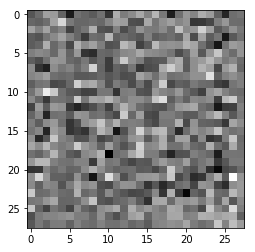

Discriminator-Real-Loss: 0.68635064
Discriminator-Fake-Loss: 0.6965612
Discriminator Loss: 1.3829119
Generator Loss: 0.9212208


 10%|███████▋                                                                     | 5000/50000 [03:00<23:56, 31.33it/s]

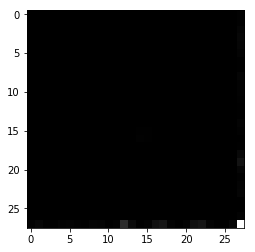

Discriminator-Real-Loss: 0.32510385
Discriminator-Fake-Loss: 1.5062562e-06
Discriminator Loss: 0.32510537
Generator Loss: 13.397854


 20%|███████████████▍                                                             | 9998/50000 [05:44<21:19, 31.25it/s]

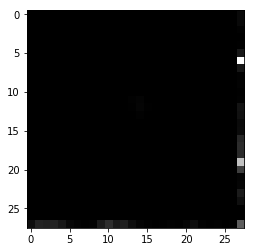

Discriminator-Real-Loss: 0.32508567
Discriminator-Fake-Loss: 3.283815e-07
Discriminator Loss: 0.325086
Generator Loss: 14.927467


 30%|██████████████████████▊                                                     | 14997/50000 [08:27<18:46, 31.07it/s]

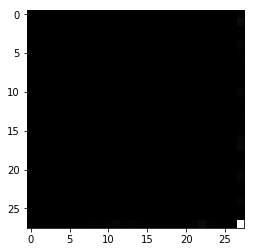

Discriminator-Real-Loss: 0.32508364
Discriminator-Fake-Loss: 4.8119574e-08
Discriminator Loss: 0.3250837
Generator Loss: 16.851734


 40%|██████████████████████████████▍                                             | 19999/50000 [11:10<16:02, 31.17it/s]

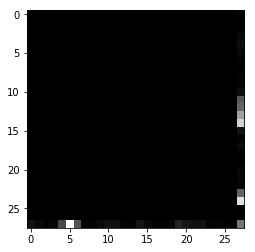

Discriminator-Real-Loss: 0.32508433
Discriminator-Fake-Loss: 1.6810053e-07
Discriminator Loss: 0.3250845
Generator Loss: 15.600878


 50%|█████████████████████████████████████▉                                      | 24997/50000 [13:54<13:18, 31.33it/s]

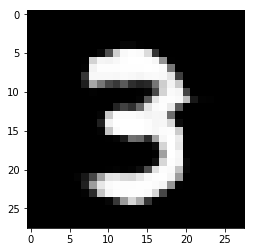

Discriminator-Real-Loss: 0.4139835
Discriminator-Fake-Loss: 0.021095257
Discriminator Loss: 0.43507874
Generator Loss: 5.039605


 60%|█████████████████████████████████████████████▌                              | 30000/50000 [16:37<10:36, 31.41it/s]

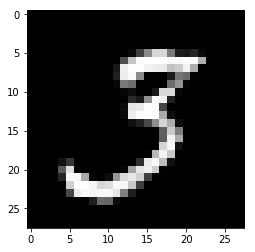

Discriminator-Real-Loss: 0.37328988
Discriminator-Fake-Loss: 0.04339194
Discriminator Loss: 0.41668183
Generator Loss: 4.734874


 70%|█████████████████████████████████████████████████████▏                      | 34997/50000 [19:25<08:02, 31.07it/s]

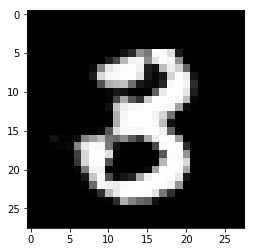

Discriminator-Real-Loss: 0.41104218
Discriminator-Fake-Loss: 0.042105936
Discriminator Loss: 0.45314813
Generator Loss: 4.818472


 80%|████████████████████████████████████████████████████████████▊               | 40000/50000 [22:09<05:20, 31.24it/s]

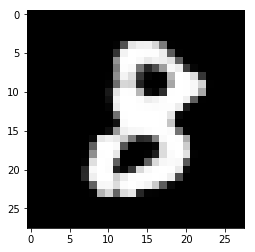

Discriminator-Real-Loss: 0.3335458
Discriminator-Fake-Loss: 0.020229602
Discriminator Loss: 0.3537754
Generator Loss: 6.70752


 90%|████████████████████████████████████████████████████████████████████▍       | 45000/50000 [24:52<02:40, 31.11it/s]

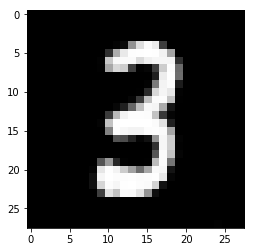

Discriminator-Real-Loss: 0.38303527
Discriminator-Fake-Loss: 0.017072631
Discriminator Loss: 0.4001079
Generator Loss: 5.7814693


100%|████████████████████████████████████████████████████████████████████████████| 50000/50000 [27:36<00:00, 30.18it/s]


---------------------------------------------
leakyRelu-1_differentLearnRates-0_smoothing-0.9_pretrain-1
---------------------------------------------
---------------------------------------------


  0%|                                                                                        | 0/50000 [00:00<?, ?it/s]

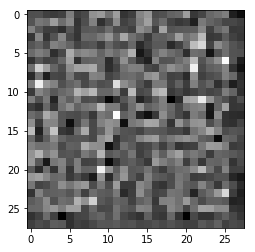

Discriminator-Real-Loss: 0.349571
Discriminator-Fake-Loss: 3.5721696e-06
Discriminator Loss: 0.34957457
Generator Loss: 12.691359


 10%|███████▋                                                                     | 4997/50000 [02:46<24:32, 30.55it/s]

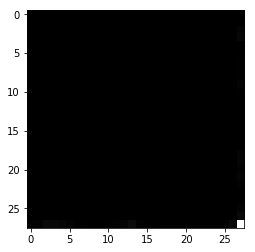

Discriminator-Real-Loss: 0.32509786
Discriminator-Fake-Loss: 1.6725941e-06
Discriminator Loss: 0.32509953
Generator Loss: 13.294639


 20%|███████████████▍                                                             | 9998/50000 [05:31<21:22, 31.18it/s]

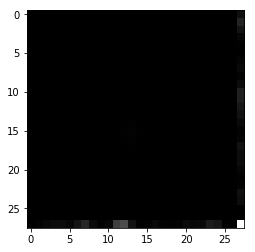

Discriminator-Real-Loss: 0.32509136
Discriminator-Fake-Loss: 2.3274806e-07
Discriminator Loss: 0.3250916
Generator Loss: 15.273701


 30%|██████████████████████▊                                                     | 14997/50000 [08:15<18:50, 30.97it/s]

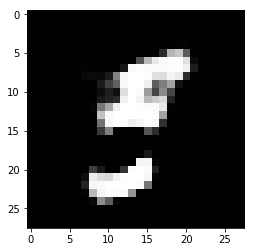

Discriminator-Real-Loss: 0.59976226
Discriminator-Fake-Loss: 0.0017359061
Discriminator Loss: 0.6014982
Generator Loss: 5.8628697


 40%|██████████████████████████████▍                                             | 19997/50000 [11:00<16:10, 30.92it/s]

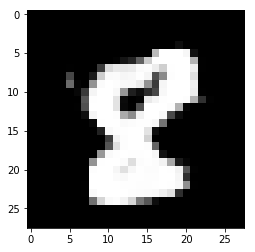

Discriminator-Real-Loss: 0.3664844
Discriminator-Fake-Loss: 0.021423815
Discriminator Loss: 0.38790822
Generator Loss: 5.1785975


 50%|█████████████████████████████████████▉                                      | 24998/50000 [13:44<13:24, 31.07it/s]

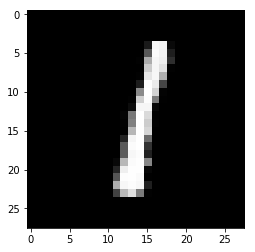

Discriminator-Real-Loss: 0.66536593
Discriminator-Fake-Loss: 0.008437051
Discriminator Loss: 0.673803
Generator Loss: 4.8243585


 60%|█████████████████████████████████████████████▌                              | 30000/50000 [16:28<10:36, 31.41it/s]

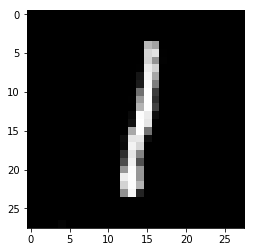

Discriminator-Real-Loss: 0.5527422
Discriminator-Fake-Loss: 0.02810107
Discriminator Loss: 0.58084327
Generator Loss: 2.662855


 70%|█████████████████████████████████████████████████████▏                      | 34998/50000 [19:12<08:01, 31.14it/s]

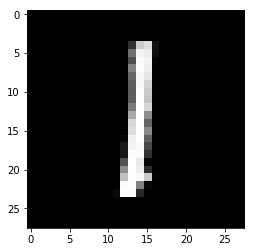

Discriminator-Real-Loss: 0.5045897
Discriminator-Fake-Loss: 0.053935096
Discriminator Loss: 0.5585248
Generator Loss: 3.421266


 80%|████████████████████████████████████████████████████████████▊               | 40000/50000 [21:57<05:22, 31.00it/s]

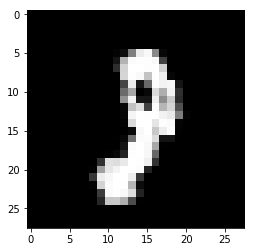

Discriminator-Real-Loss: 0.41822463
Discriminator-Fake-Loss: 0.014386785
Discriminator Loss: 0.4326114
Generator Loss: 4.816938


 90%|████████████████████████████████████████████████████████████████████▍       | 44998/50000 [24:41<02:40, 31.14it/s]

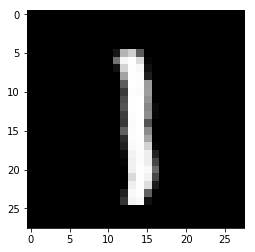

Discriminator-Real-Loss: 0.34020746
Discriminator-Fake-Loss: 0.0955267
Discriminator Loss: 0.43573415
Generator Loss: 4.6209164


100%|████████████████████████████████████████████████████████████████████████████| 50000/50000 [27:26<00:00, 31.02it/s]


---------------------------------------------
leakyRelu-1_differentLearnRates-0_smoothing-1_pretrain-0
---------------------------------------------
---------------------------------------------


  0%|                                                                                        | 0/50000 [00:00<?, ?it/s]

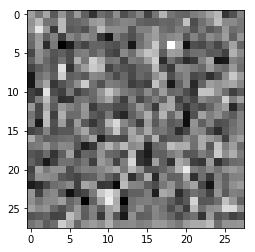

Discriminator-Real-Loss: 0.695159
Discriminator-Fake-Loss: 0.6860534
Discriminator Loss: 1.3812125
Generator Loss: 0.9226831


 10%|███████▋                                                                     | 4997/50000 [03:00<24:20, 30.82it/s]

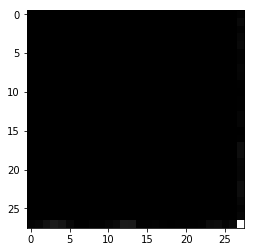

Discriminator-Real-Loss: 5.3242677e-10
Discriminator-Fake-Loss: 9.4014474e-08
Discriminator Loss: 9.45469e-08
Generator Loss: 16.180805


 20%|███████████████▍                                                             | 9998/50000 [05:46<21:39, 30.79it/s]

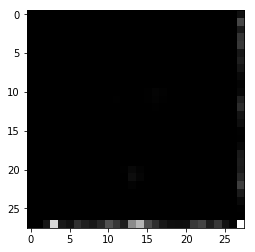

Discriminator-Real-Loss: 7.843501e-12
Discriminator-Fake-Loss: 5.686931e-09
Discriminator Loss: 5.6947744e-09
Generator Loss: 18.986328


 30%|██████████████████████▊                                                     | 15000/50000 [08:31<18:53, 30.87it/s]

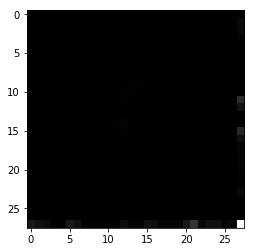

Discriminator-Real-Loss: 1.5827236e-14
Discriminator-Fake-Loss: 4.3012935e-10
Discriminator Loss: 4.3014517e-10
Generator Loss: 21.567871


 40%|██████████████████████████████▍                                             | 19997/50000 [11:15<15:57, 31.34it/s]

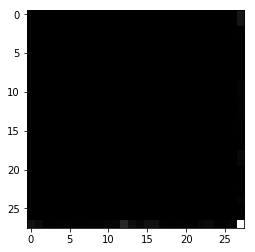

Discriminator-Real-Loss: 7.2476776e-16
Discriminator-Fake-Loss: 4.416439e-11
Discriminator Loss: 4.4165116e-11
Generator Loss: 23.84441


 50%|█████████████████████████████████████▉                                      | 24999/50000 [13:59<13:23, 31.13it/s]

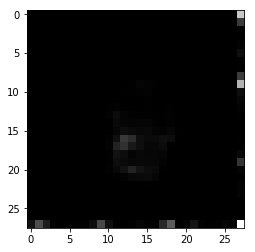

Discriminator-Real-Loss: 1.8074901e-18
Discriminator-Fake-Loss: 4.223394e-12
Discriminator Loss: 4.223396e-12
Generator Loss: 26.191101


 60%|█████████████████████████████████████████████▌                              | 29997/50000 [16:43<10:50, 30.75it/s]

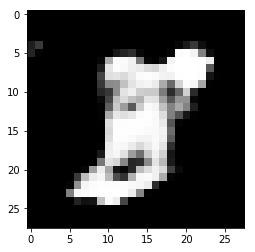

Discriminator-Real-Loss: 0.15079312
Discriminator-Fake-Loss: 0.034242164
Discriminator Loss: 0.18503529
Generator Loss: 5.512566


 70%|█████████████████████████████████████████████████████▏                      | 34999/50000 [19:30<08:57, 27.88it/s]

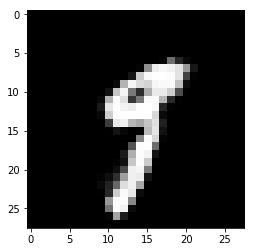

Discriminator-Real-Loss: 0.15844406
Discriminator-Fake-Loss: 0.027331855
Discriminator Loss: 0.18577592
Generator Loss: 3.3053935


 80%|████████████████████████████████████████████████████████████▊               | 39997/50000 [22:20<05:20, 31.20it/s]

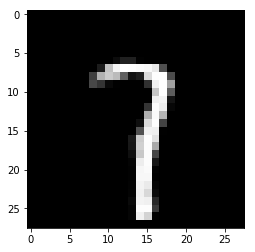

Discriminator-Real-Loss: 0.10176847
Discriminator-Fake-Loss: 0.102262825
Discriminator Loss: 0.20403129
Generator Loss: 2.70846


 90%|████████████████████████████████████████████████████████████████████▍       | 44997/50000 [25:07<02:41, 30.92it/s]

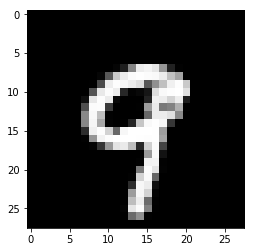

Discriminator-Real-Loss: 0.076910965
Discriminator-Fake-Loss: 0.027976451
Discriminator Loss: 0.10488742
Generator Loss: 3.5776496


100%|████████████████████████████████████████████████████████████████████████████| 50000/50000 [27:53<00:00, 29.88it/s]


---------------------------------------------
leakyRelu-1_differentLearnRates-0_smoothing-1_pretrain-1
---------------------------------------------
---------------------------------------------


  0%|                                                                                        | 0/50000 [00:00<?, ?it/s]

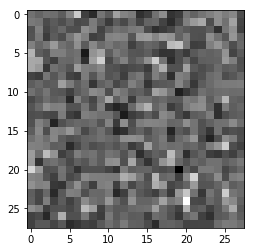

Discriminator-Real-Loss: 0.00010744177
Discriminator-Fake-Loss: 1.818376e-05
Discriminator Loss: 0.00012562552
Generator Loss: 11.301515


 10%|███████▋                                                                     | 4999/50000 [02:47<24:21, 30.78it/s]

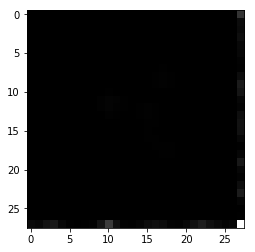

Discriminator-Real-Loss: 9.018276e-12
Discriminator-Fake-Loss: 8.6520004e-08
Discriminator Loss: 8.652902e-08
Generator Loss: 16.263659


 20%|███████████████▏                                                            | 10000/50000 [05:32<21:30, 30.99it/s]

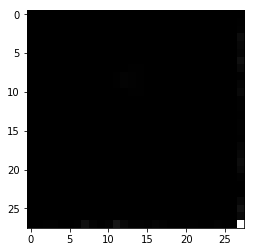

Discriminator-Real-Loss: 8.9503345e-07
Discriminator-Fake-Loss: 4.0748405e-09
Discriminator Loss: 8.991083e-07
Generator Loss: 19.278471


 30%|██████████████████████▊                                                     | 14999/50000 [08:17<18:56, 30.80it/s]

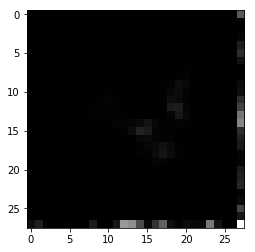

Discriminator-Real-Loss: 6.649605e-14
Discriminator-Fake-Loss: 4.0425183e-10
Discriminator Loss: 4.0431833e-10
Generator Loss: 21.631096


 40%|██████████████████████████████▍                                             | 19998/50000 [11:01<16:04, 31.11it/s]

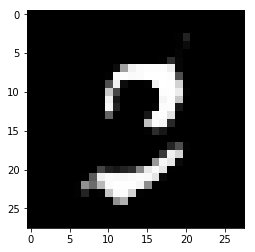

Discriminator-Real-Loss: 0.18541656
Discriminator-Fake-Loss: 0.16743094
Discriminator Loss: 0.35284752
Generator Loss: 3.1350338


 50%|█████████████████████████████████████▉                                      | 24999/50000 [13:46<13:26, 30.98it/s]

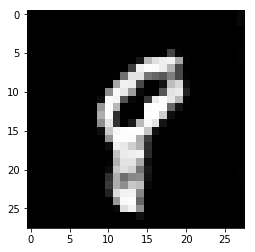

Discriminator-Real-Loss: 0.10227002
Discriminator-Fake-Loss: 0.15994431
Discriminator Loss: 0.26221433
Generator Loss: 2.9183884


 60%|█████████████████████████████████████████████▌                              | 30000/50000 [16:31<10:37, 31.38it/s]

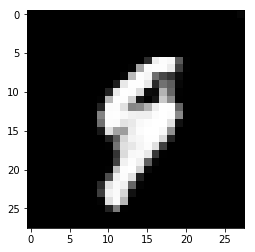

Discriminator-Real-Loss: 0.18670468
Discriminator-Fake-Loss: 0.11284785
Discriminator Loss: 0.29955253
Generator Loss: 3.2958753


 70%|█████████████████████████████████████████████████████▏                      | 34999/50000 [19:15<08:03, 31.04it/s]

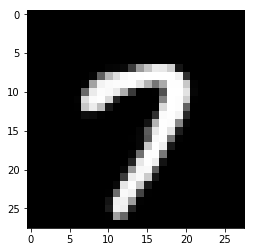

Discriminator-Real-Loss: 0.045033064
Discriminator-Fake-Loss: 0.080411
Discriminator Loss: 0.12544407
Generator Loss: 3.5752225


 80%|████████████████████████████████████████████████████████████▊               | 39998/50000 [22:00<05:20, 31.16it/s]

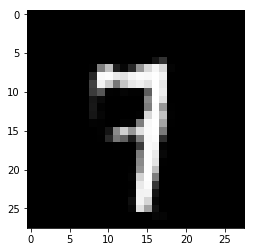

Discriminator-Real-Loss: 0.35581926
Discriminator-Fake-Loss: 0.026794665
Discriminator Loss: 0.38261393
Generator Loss: 3.1933587


 90%|████████████████████████████████████████████████████████████████████▍       | 45000/50000 [24:52<02:42, 30.76it/s]

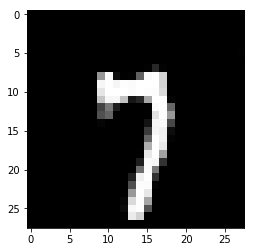

Discriminator-Real-Loss: 0.09699967
Discriminator-Fake-Loss: 0.04426475
Discriminator Loss: 0.14126441
Generator Loss: 4.9073467


100%|████████████████████████████████████████████████████████████████████████████| 50000/50000 [27:36<00:00, 30.18it/s]


---------------------------------------------
leakyRelu-1_differentLearnRates-1_smoothing-0.9_pretrain-0
---------------------------------------------
---------------------------------------------


  0%|                                                                                        | 0/50000 [00:00<?, ?it/s]

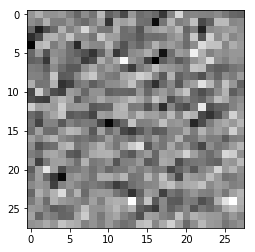

Discriminator-Real-Loss: 0.6912814
Discriminator-Fake-Loss: 0.676881
Discriminator Loss: 1.3681624
Generator Loss: 0.9367079


 10%|███████▋                                                                     | 4997/50000 [03:00<24:34, 30.52it/s]

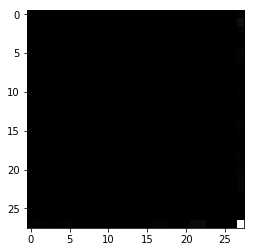

Discriminator-Real-Loss: 0.32513443
Discriminator-Fake-Loss: 1.9489611e-05
Discriminator Loss: 0.32515392
Generator Loss: 10.86175


 20%|███████████████▍                                                             | 9998/50000 [05:46<21:38, 30.80it/s]

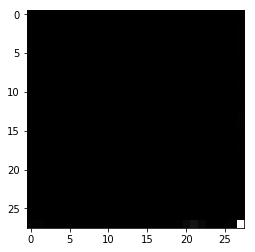

Discriminator-Real-Loss: 0.3250846
Discriminator-Fake-Loss: 2.6568176e-07
Discriminator Loss: 0.32508487
Generator Loss: 15.144261


 30%|██████████████████████▊                                                     | 15000/50000 [08:31<18:43, 31.14it/s]

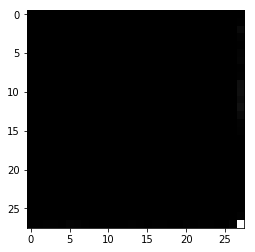

Discriminator-Real-Loss: 0.3250845
Discriminator-Fake-Loss: 5.082227e-08
Discriminator Loss: 0.32508457
Generator Loss: 16.796457


 40%|██████████████████████████████▍                                             | 19999/50000 [11:16<16:03, 31.15it/s]

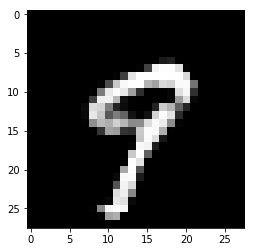

Discriminator-Real-Loss: 0.35945058
Discriminator-Fake-Loss: 0.034865767
Discriminator Loss: 0.39431635
Generator Loss: 3.8382826


 50%|█████████████████████████████████████▉                                      | 24997/50000 [14:01<13:26, 31.00it/s]

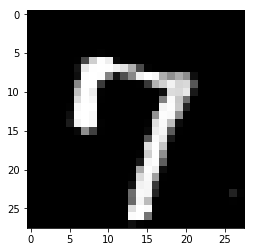

Discriminator-Real-Loss: 0.33576602
Discriminator-Fake-Loss: 0.096208476
Discriminator Loss: 0.4319745
Generator Loss: 5.0533204


 60%|█████████████████████████████████████████████▌                              | 29998/50000 [16:45<10:44, 31.04it/s]

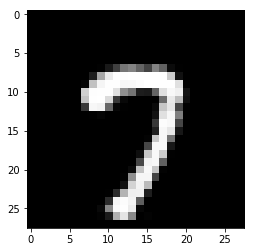

Discriminator-Real-Loss: 0.36998355
Discriminator-Fake-Loss: 0.027980933
Discriminator Loss: 0.39796448
Generator Loss: 5.088745


 70%|█████████████████████████████████████████████████████▏                      | 34999/50000 [19:30<08:02, 31.10it/s]

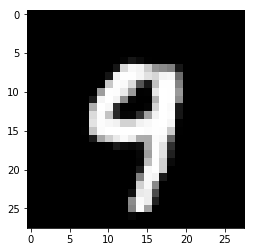

Discriminator-Real-Loss: 0.34252343
Discriminator-Fake-Loss: 0.09483233
Discriminator Loss: 0.43735576
Generator Loss: 3.3159683


 80%|████████████████████████████████████████████████████████████▊               | 40000/50000 [22:16<05:19, 31.34it/s]

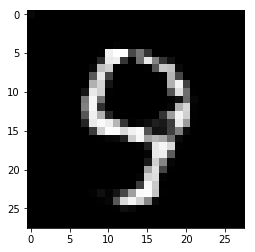

Discriminator-Real-Loss: 0.36929375
Discriminator-Fake-Loss: 0.015897697
Discriminator Loss: 0.38519144
Generator Loss: 6.5232887


 90%|████████████████████████████████████████████████████████████████████▍       | 44998/50000 [25:01<02:43, 30.69it/s]

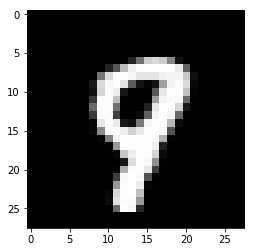

Discriminator-Real-Loss: 0.35020444
Discriminator-Fake-Loss: 0.014833269
Discriminator Loss: 0.3650377
Generator Loss: 5.594426


100%|████████████████████████████████████████████████████████████████████████████| 50000/50000 [27:46<00:00, 30.01it/s]


---------------------------------------------
leakyRelu-1_differentLearnRates-1_smoothing-0.9_pretrain-1
---------------------------------------------
---------------------------------------------


  0%|                                                                                        | 0/50000 [00:00<?, ?it/s]

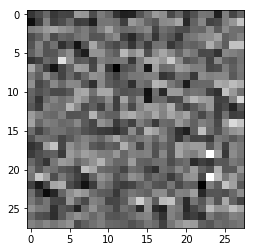

Discriminator-Real-Loss: 0.3479026
Discriminator-Fake-Loss: 1.289834e-06
Discriminator Loss: 0.34790388
Generator Loss: 13.496535


 10%|███████▋                                                                     | 4997/50000 [02:47<24:21, 30.79it/s]

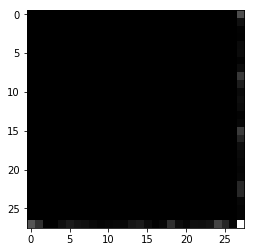

Discriminator-Real-Loss: 0.32512784
Discriminator-Fake-Loss: 1.0720922e-06
Discriminator Loss: 0.3251289
Generator Loss: 13.732


 20%|███████████████▍                                                             | 9998/50000 [05:34<21:36, 30.86it/s]

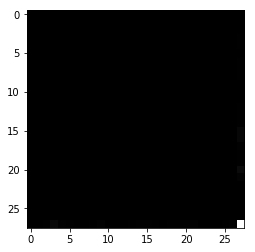

Discriminator-Real-Loss: 0.3250841
Discriminator-Fake-Loss: 8.7201315e-08
Discriminator Loss: 0.32508418
Generator Loss: 16.257816


 30%|██████████████████████▊                                                     | 15000/50000 [08:22<19:13, 30.34it/s]

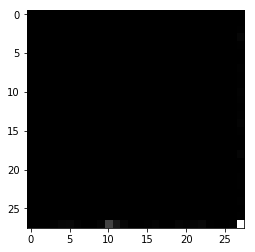

Discriminator-Real-Loss: 0.32508343
Discriminator-Fake-Loss: 6.604986e-08
Discriminator Loss: 0.3250835
Generator Loss: 16.531784


 40%|██████████████████████████████▍                                             | 20000/50000 [11:10<16:10, 30.92it/s]

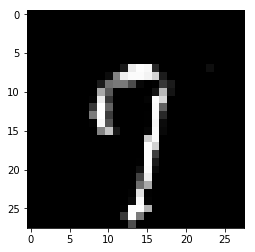

Discriminator-Real-Loss: 0.3505253
Discriminator-Fake-Loss: 0.050929714
Discriminator Loss: 0.40145501
Generator Loss: 5.0252047


 50%|█████████████████████████████████████▉                                      | 24998/50000 [13:55<13:27, 30.97it/s]

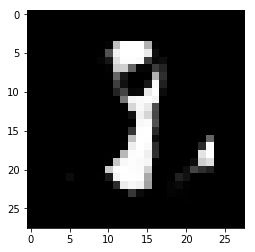

Discriminator-Real-Loss: 0.3479868
Discriminator-Fake-Loss: 0.064592
Discriminator Loss: 0.4125788
Generator Loss: 4.298356


 60%|█████████████████████████████████████████████▌                              | 29998/50000 [16:40<10:46, 30.95it/s]

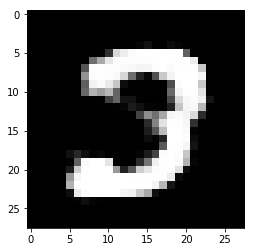

Discriminator-Real-Loss: 0.5203016
Discriminator-Fake-Loss: 0.0058181877
Discriminator Loss: 0.52611977
Generator Loss: 7.5197773


 70%|█████████████████████████████████████████████████████▏                      | 34999/50000 [19:25<08:03, 31.05it/s]

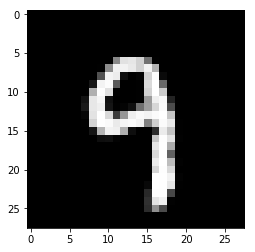

Discriminator-Real-Loss: 0.33835682
Discriminator-Fake-Loss: 0.061549015
Discriminator Loss: 0.39990583
Generator Loss: 5.8706098


 80%|████████████████████████████████████████████████████████████▊               | 39997/50000 [22:10<05:22, 31.02it/s]

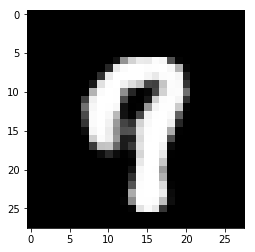

Discriminator-Real-Loss: 0.3308285
Discriminator-Fake-Loss: 0.13290066
Discriminator Loss: 0.46372914
Generator Loss: 4.0543666


 90%|████████████████████████████████████████████████████████████████████▍       | 44997/50000 [24:55<02:42, 30.81it/s]

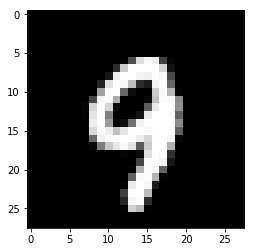

Discriminator-Real-Loss: 0.34580377
Discriminator-Fake-Loss: 0.025289986
Discriminator Loss: 0.37109375
Generator Loss: 7.2800336


100%|████████████████████████████████████████████████████████████████████████████| 50000/50000 [27:41<00:00, 30.10it/s]


---------------------------------------------
leakyRelu-1_differentLearnRates-1_smoothing-1_pretrain-0
---------------------------------------------
---------------------------------------------


  0%|                                                                                        | 0/50000 [00:00<?, ?it/s]

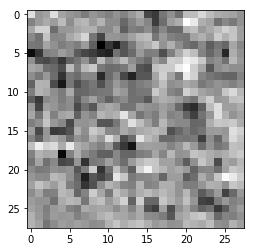

Discriminator-Real-Loss: 0.6693142
Discriminator-Fake-Loss: 0.7259671
Discriminator Loss: 1.3952813
Generator Loss: 0.9621895


 10%|███████▋                                                                     | 4997/50000 [03:01<24:28, 30.65it/s]

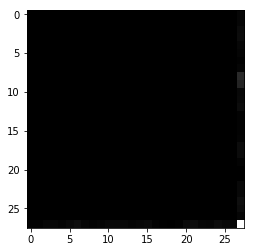

Discriminator-Real-Loss: 3.857449e-12
Discriminator-Fake-Loss: 1.2522794e-07
Discriminator Loss: 1.252318e-07
Generator Loss: 15.895985


 20%|███████████████▍                                                             | 9997/50000 [05:47<21:45, 30.63it/s]

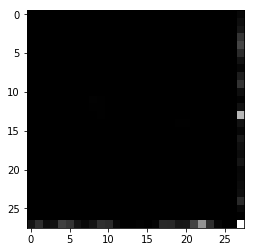

Discriminator-Real-Loss: 1.6426605e-11
Discriminator-Fake-Loss: 4.7616706e-09
Discriminator Loss: 4.778097e-09
Generator Loss: 19.163363


 30%|██████████████████████▊                                                     | 15000/50000 [08:38<19:16, 30.26it/s]

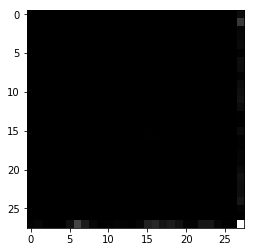

Discriminator-Real-Loss: 4.5843685e-15
Discriminator-Fake-Loss: 3.3538441e-10
Discriminator Loss: 3.35389e-10
Generator Loss: 21.816475


 40%|██████████████████████████████▍                                             | 20000/50000 [11:25<16:06, 31.05it/s]

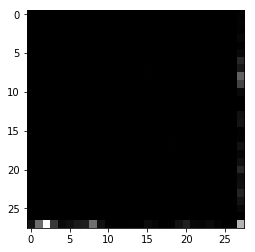

Discriminator-Real-Loss: 1.0462317e-18
Discriminator-Fake-Loss: 3.722648e-11
Discriminator Loss: 3.722648e-11
Generator Loss: 24.015358


 50%|█████████████████████████████████████▉                                      | 24999/50000 [14:10<13:27, 30.94it/s]

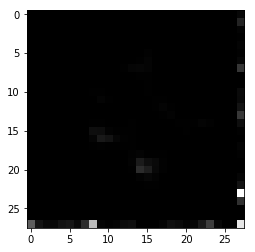

Discriminator-Real-Loss: 8.875282e-19
Discriminator-Fake-Loss: 4.4713816e-12
Discriminator Loss: 4.4713825e-12
Generator Loss: 26.13421


 60%|█████████████████████████████████████████████▌                              | 29997/50000 [16:55<10:47, 30.90it/s]

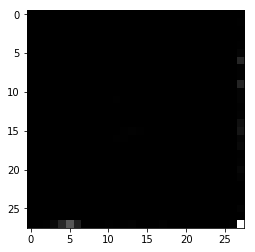

Discriminator-Real-Loss: 1.9697627e-19
Discriminator-Fake-Loss: 1.759702e-12
Discriminator Loss: 1.7597022e-12
Generator Loss: 27.069687


 70%|█████████████████████████████████████████████████████▏                      | 34999/50000 [19:39<08:05, 30.91it/s]

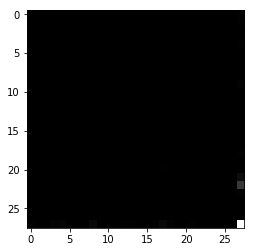

Discriminator-Real-Loss: 1.3449941e-23
Discriminator-Fake-Loss: 5.1946826e-13
Discriminator Loss: 5.1946826e-13
Generator Loss: 28.286499


 80%|████████████████████████████████████████████████████████████▊               | 39998/50000 [22:24<05:23, 30.89it/s]

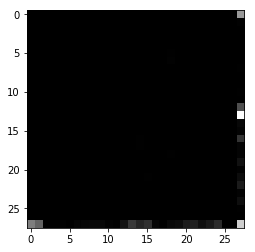

Discriminator-Real-Loss: 4.609818e-19
Discriminator-Fake-Loss: 3.63287e-13
Discriminator Loss: 3.6328747e-13
Generator Loss: 28.643972


 90%|████████████████████████████████████████████████████████████████████▍       | 45000/50000 [25:09<02:40, 31.11it/s]

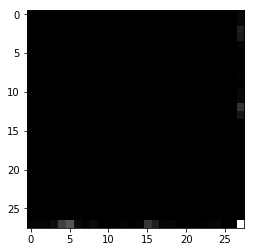

Discriminator-Real-Loss: 1.3830566e-20
Discriminator-Fake-Loss: 4.2423167e-13
Discriminator Loss: 4.242317e-13
Generator Loss: 28.489307


100%|████████████████████████████████████████████████████████████████████████████| 50000/50000 [27:53<00:00, 29.87it/s]


---------------------------------------------
leakyRelu-1_differentLearnRates-1_smoothing-1_pretrain-1
---------------------------------------------
---------------------------------------------


  0%|                                                                                        | 0/50000 [00:00<?, ?it/s]

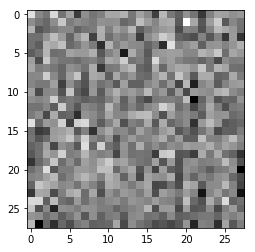

Discriminator-Real-Loss: 0.00026328754
Discriminator-Fake-Loss: 2.3203876e-05
Discriminator Loss: 0.0002864914
Generator Loss: 11.090158


 10%|███████▋                                                                     | 4999/50000 [02:47<24:39, 30.42it/s]

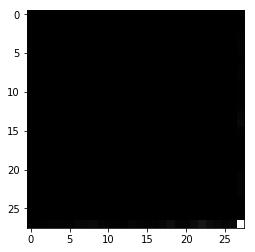

Discriminator-Real-Loss: 9.855714e-13
Discriminator-Fake-Loss: 8.420725e-08
Discriminator Loss: 8.420824e-08
Generator Loss: 16.291304


 20%|███████████████▍                                                             | 9998/50000 [05:34<21:34, 30.90it/s]

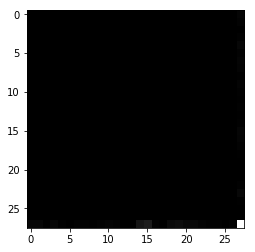

Discriminator-Real-Loss: 4.132989e-13
Discriminator-Fake-Loss: 5.630253e-09
Discriminator Loss: 5.6306666e-09
Generator Loss: 18.997208


 30%|██████████████████████▊                                                     | 15000/50000 [08:20<18:53, 30.88it/s]

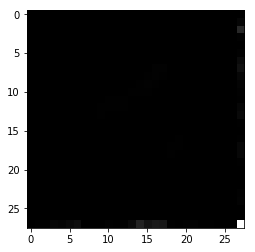

Discriminator-Real-Loss: 2.0531242e-16
Discriminator-Fake-Loss: 3.9423373e-10
Discriminator Loss: 3.9423392e-10
Generator Loss: 21.655724


 40%|██████████████████████████████▍                                             | 19997/50000 [11:05<16:10, 30.91it/s]

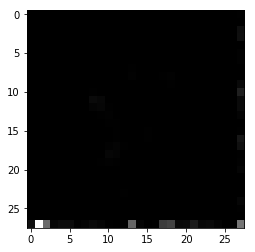

Discriminator-Real-Loss: 4.6933244e-18
Discriminator-Fake-Loss: 3.3929057e-11
Discriminator Loss: 3.392906e-11
Generator Loss: 24.107733


 50%|█████████████████████████████████████▉                                      | 24997/50000 [13:50<13:30, 30.86it/s]

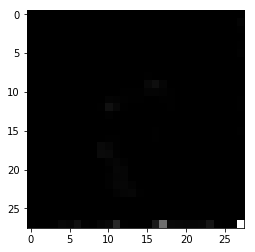

Discriminator-Real-Loss: 4.3236074e-12
Discriminator-Fake-Loss: 6.497199e-12
Discriminator Loss: 1.0820806e-11
Generator Loss: 25.758808


 60%|█████████████████████████████████████████████▌                              | 29997/50000 [16:36<10:48, 30.84it/s]

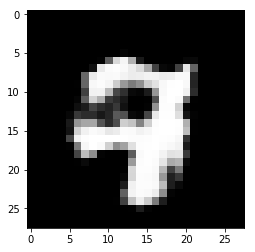

Discriminator-Real-Loss: 0.1958353
Discriminator-Fake-Loss: 0.06717423
Discriminator Loss: 0.26300955
Generator Loss: 3.8248205


 70%|█████████████████████████████████████████████████████▏                      | 34999/50000 [19:22<08:04, 30.98it/s]

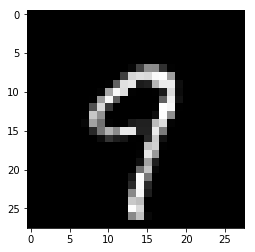

Discriminator-Real-Loss: 0.07724511
Discriminator-Fake-Loss: 0.11318216
Discriminator Loss: 0.19042727
Generator Loss: 2.7147427


 80%|████████████████████████████████████████████████████████████▊               | 40000/50000 [22:08<05:25, 30.75it/s]

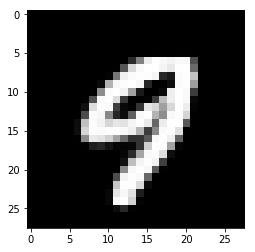

Discriminator-Real-Loss: 0.06265408
Discriminator-Fake-Loss: 0.15981294
Discriminator Loss: 0.22246702
Generator Loss: 3.7378178


 90%|████████████████████████████████████████████████████████████████████▍       | 45000/50000 [24:53<02:42, 30.72it/s]

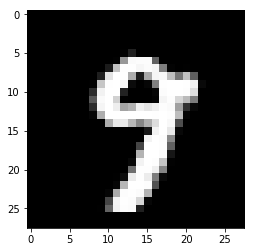

Discriminator-Real-Loss: 0.00586747
Discriminator-Fake-Loss: 0.040184923
Discriminator Loss: 0.046052393
Generator Loss: 4.064617


100%|████████████████████████████████████████████████████████████████████████████| 50000/50000 [27:39<00:00, 30.60it/s]


In [22]:
# Train for each model

for model in models:  
    SMOOTHING = model[1]
       
    # fill gan config string with model specific 
    gan_config = "batchSize-100_leakyRelu-1_smoothing-{0}_pretrain-{1}".format(model[0], model[1]) 
    
    print("---------------------------------------------")
    print(gan_config)    
    print("---------------------------------------------")
    print("---------------------------------------------")

    # Start Session
    with tf.Session(config=config) as sess:
        
        # Initialize Session
        sess.run(init)

        # add a tensorboard
        writer = tf.summary.FileWriter('./tensorboard/{0}_{1}'.format(now.strftime("%Y_%m_%d-%H-%M"), gan_config), sess.graph)
        
        # Pretraining Discriminator
        if model[2]==1:
            for pretrain in tqdm(range(200)):
                batch_images = sess.run(nextbatch)

                batch_z = np.random.uniform(-1,1,size=(BATCH_SIZE,100))

                _ = sess.run(D_trainer, feed_dict={real_images:batch_images, z:batch_z, smooth_placeholder:SMOOTHING})

        for epoch in tqdm(range(EPOCHS)):
            # Get next batch of images
            batch_images = sess.run(nextbatch)
            
            # create normal distributed random values for Generator
            batch_z = np.random.uniform(-1,1,size=(BATCH_SIZE,100))

            # Discriminator Train
            D_summary, _, discrloss, discr_r_loss, discr_f_loss = sess.run([merged, D_trainer, D_loss, D_real_loss, D_fake_loss], feed_dict={real_images:batch_images, z:batch_z, smooth_placeholder:SMOOTHING})

            # Generator Train
            genloss, _= sess.run([G_loss, G_trainer], feed_dict={z:batch_z})

            
            
            # Add a summary to tensorboard Every 10 epochs
            if (epoch % 10 == 0):{
                # SUMMARIES
                writer.add_summary(D_summary, epoch)
            }

                
                
            # Generate an Image every 5000 Epochs and Print out all losses
            if (epoch%5000 == 0):
                sample_z = np.random.uniform(-1,1,size=(1,100))

                gen_sample = sess.run(gen(z, reuse_vars=True), feed_dict={z: sample_z})

                samples.append(gen_sample)

                plt.imshow(gen_sample.reshape(28,28), cmap="gray")
                plt.show()
                
                print("Discriminator-Real-Loss:", discr_r_loss)
                
                
                print("Discriminator-Fake-Loss:", discr_f_loss)
                
                print("Discriminator Loss:",discrloss)
                
                print("Generator Loss:",genloss)
                

## Further Ideas

### Change the Loss Function to Wasserstein Distance
[Wasserstein GANs (WGAN)](https://arxiv.org/pdf/1701.07875.pdf) are an alternative to *classical* GANs. They use a different loss function and prooved to be more stable to hyperparameter selection. While the paper offers a good theoretical introduction and reasoning why they perform better in many cases, [this article](https://wiseodd.github.io/techblog/2017/02/04/wasserstein-gan/) provides a good practical introduction

> Please look at the WGAN Notebook